This notebook is used to run runtime or accuracy comparison experiments.

In [1]:
import arviz as az
import matplotlib.pyplot as plt
plt.rcParams["figure.autolayout"] = True # to for tight_layout()

import os, sys
sys.path.append(os.path.join("../"))

# our library
from src.mcmc_sat import models, mcmc

## Triangle

In [27]:
(g, num_bits, num_vars) = models.get_triangle_sat()
backends = ['spur', 'cmsgen']
traces_triangle = [ 
    mcmc.sample_mh_trace_from_z3_model(backend=backend,
                                       z3_problem=g,
                                       num_bits=num_bits,
                                       num_vars=num_vars,
                                       num_samples=10000)
    for backend in backends ]

Using default filename: "spur_input/samples_z3_problem.txt"
Performing Uniform Model Sampling...
Input File:  spur_input/z3_problem.cnf
Output File: spur_input/samples_z3_problem.txt

Preprocessing ... DONE
variables (all/used/free): 	48/48/0
independent support size:  	0
clauses (all/long/binary/unit): 154/76/71/7
Initialize cache
Size of Cacheable Component:	56
Size of MPZ Class:	16
Maximum cache size:	402 MB

STAGE #1: Build the initial partial assignments
STAGE #1: COMPLETED building initial partial assignments
STAGE #2 - Filling in partial assignments...
Initialize cache
Size of Cacheable Component:	56
Size of MPZ Class:	16
Maximum cache size:	402 MB

Sample #1 of 2 is already a complete assignment.  Continuing...
Completing sample #2 of 2 which has 9 variables unset and 120 samples.
STAGE #2 - COMPLETE


variables (total / active / free)	48/48/0
clauses (removed) 		154 (0)
decisions 				14
conflicts 				0
conflict clauses (all/bin/unit) 	3/2/7
failed literals found by implicit BC

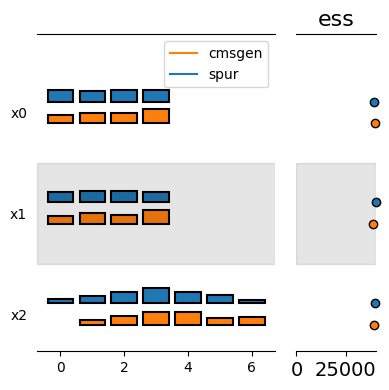

In [85]:
az.plot_forest(traces_triangle, combined=True, model_names=backends, hdi_prob=0.95, kind='ridgeplot', figsize=(4,4), ess=True, ridgeplot_overlap=0.5);

## DB CACM

In [8]:
(g, num_bits, num_vars) = models.get_db_cacm_sat()
backends = ['spur', 'cmsgen']
traces_db_cacm = [ 
    mcmc.sample_mh_trace_from_z3_model(backend=backend,
                                       z3_problem=g,
                                       num_bits=num_bits,
                                       num_vars=num_vars,
                                       num_samples=10000)
    for backend in backends ]

Using default filename: "spur_input/samples_z3_problem.txt"
Performing Uniform Model Sampling...
Input File:  spur_input/z3_problem.cnf
Output File: spur_input/samples_z3_problem.txt

Preprocessing ... DONE
variables (all/used/free): 	1590/1590/0
independent support size:  	0
clauses (all/long/binary/unit): 7458/5927/1472/59
Initialize cache
Size of Cacheable Component:	56
Size of MPZ Class:	16
Maximum cache size:	326 MB

STAGE #1: Build the initial partial assignments


STAGE #1: COMPLETED building initial partial assignments
STAGE #2 - Filling in partial assignments...
Initialize cache
Size of Cacheable Component:	56
Size of MPZ Class:	16

 Free RAM 326MB
Maximum cache size:	326 MB

Sample #1 of 129 is already a complete assignment.  Continuing...
Completing sample #2 of 129 which has 18 variables unset and 2 samples.
Completing sample #3 of 129 which has 54 variables unset and 1 sample.
Completing sample #4 of 129 which has 15 variables unset and 2 samples.
Completing sample #5 of 129 which has 20 variables unset and 1 sample.
Completing sample #6 of 129 which has 148 variables unset and 4 samples.
Completing sample #7 of 129 which has 65 variables unset and 7 samples.
Completing sample #8 of 129 which has 78 variables unset and 3 samples.
Completing sample #9 of 129 which has 56 variables unset and 3 samples.
Completing sample #10 of 129 which has 51 variables unset and 2 samples.
Completing sample #11 of 129 which has 64 variables unset and 2 samp

Completing sample #35 of 129 which has 24 variables unset and 7 samples.
Completing sample #36 of 129 which has 55 variables unset and 1 sample.
Completing sample #37 of 129 which has 53 variables unset and 3 samples.
Completing sample #38 of 129 which has 35 variables unset and 1 sample.
Completing sample #39 of 129 which has 36 variables unset and 2 samples.
Completing sample #40 of 129 which has 79 variables unset and 3 samples.
Completing sample #41 of 129 which has 44 variables unset and 5 samples.
Completing sample #42 of 129 which has 25 variables unset and 3 samples.
Completing sample #43 of 129 which has 62 variables unset and 2 samples.
Completing sample #44 of 129 which has 50 variables unset and 2 samples.
Completing sample #45 of 129 which has 61 variables unset and 2 samples.
Completing sample #46 of 129 which has 25 variables unset and 4 samples.
Completing sample #47 of 129 which has 25 variables unset and 2 samples.
Completing sample #48 of 129 which has 49 variables u

Completing sample #73 of 129 which has 16 variables unset and 1 sample.
Completing sample #74 of 129 which has 55 variables unset and 3 samples.
Completing sample #75 of 129 which has 39 variables unset and 2 samples.
Completing sample #76 of 129 which has 37 variables unset and 1 sample.
Completing sample #77 of 129 which has 66 variables unset and 1 sample.
Completing sample #78 of 129 which has 17 variables unset and 4 samples.
Completing sample #79 of 129 which has 61 variables unset and 3 samples.
Completing sample #80 of 129 which has 65 variables unset and 2 samples.
Completing sample #81 of 129 which has 62 variables unset and 1 sample.
Completing sample #82 of 129 which has 61 variables unset and 2 samples.
Completing sample #83 of 129 which has 75 variables unset and 1 sample.
Completing sample #84 of 129 which has 36 variables unset and 2 samples.
Completing sample #85 of 129 which has 28 variables unset and 3 samples.
Completing sample #86 of 129 which has 38 variables unse

Completing sample #109 of 129 which has 20 variables unset and 2 samples.
Completing sample #110 of 129 which has 27 variables unset and 2 samples.
Completing sample #111 of 129 which has 52 variables unset and 3 samples.
Completing sample #112 of 129 which has 100 variables unset and 1 sample.
Completing sample #113 of 129 which has 98 variables unset and 4 samples.
Completing sample #114 of 129 which has 53 variables unset and 1 sample.
Completing sample #115 of 129 which has 55 variables unset and 1 sample.
Completing sample #116 of 129 which has 56 variables unset and 2 samples.
Completing sample #117 of 129 which has 44 variables unset and 3 samples.
Completing sample #118 of 129 which has 19 variables unset and 2 samples.
Completing sample #119 of 129 which has 92 variables unset and 3 samples.
Completing sample #120 of 129 which has 49 variables unset and 1 sample.
Completing sample #121 of 129 which has 35 variables unset and 2 samples.
Completing sample #122 of 129 which has 6

c CMSGen Copyright Mate Soos (soos.mate@gmail.com)
c CMSGen SHA revision 00791438b32bb387e1f6ba7c1b211d7f6595aa06
c CMSGen is MIT licensed
c CMSGen compilation env CMAKE_CXX_COMPILER = /usr/bin/c++ | CMAKE_CXX_FLAGS =  -fno-stack-protector -mtune=native -Wlogical-op -Wrestrict -Wnull-dereference -Wdouble-promotion -Wshadow -Wformat=2 -Wextra-semi -pedantic | COMPILE_DEFINES =  -DNDEBUG -D_FORTIFY_SOURCE=0 -DUSE_GAUSS -DUSE_ZLIB -DYALSAT_FPU | STATICCOMPILE = ON | ZLIB_FOUND = TRUE | VALGRIND_FOUND =  | ENABLE_TESTING = ON | SLOW_DEBUG = OFF | ENABLE_ASSERTIONS = OFF | MY_TARGETS =  | LARGEMEM =  | LIMITMEM =  | 
c CMSGen compiled with gcc version 9.4.0
c executed with command line: cmsgen --samples 1000 --samplefile cmsgen_input/cmsgen_samples.out cmsgen_input/z3_problem.cnf
c Writing samples to file: cmsgen_input/cmsgen_samples.out
c Number of samples found until now:     10
c Number of samples found until now:     20
c Number of samples found until now:     30
c Number of samples fou

c Number of samples found until now:    140
c Number of samples found until now:    150
c Number of samples found until now:    160
c Number of samples found until now:    170
c Number of samples found until now:    180
c Number of samples found until now:    190
c Number of samples found until now:    200
c Number of samples found until now:    210
c Number of samples found until now:    220
c Number of samples found until now:    230
c Number of samples found until now:    240
c Number of samples found until now:    250
c Number of samples found until now:    260
c Number of samples found until now:    270
c Number of samples found until now:    280
c Number of samples found until now:    290
c Number of samples found until now:    300
c Number of samples found until now:    310


c Number of samples found until now:    320
c Number of samples found until now:    330
c Number of samples found until now:    340
c Number of samples found until now:    350
c Number of samples found until now:    360
c Number of samples found until now:    370
c Number of samples found until now:    380
c Number of samples found until now:    390


c Number of samples found until now:    400
c Number of samples found until now:    410
c Number of samples found until now:    420
c Number of samples found until now:    430
c Number of samples found until now:    440
c Number of samples found until now:    450
c Number of samples found until now:    460
c Number of samples found until now:    470
c Number of samples found until now:    480
c Number of samples found until now:    490
c Number of samples found until now:    500
c Number of samples found until now:    510
c Number of samples found until now:    520
c Number of samples found until now:    530
c Number of samples found until now:    540
c Number of samples found until now:    550
c Number of samples found until now:    560
c Number of samples found until now:    570
c Number of samples found until now:    580
c Number of samples found until now:    590
c Number of samples found until now:    600
c Number of samples found until now:    610
c Number of samples found until 

c Number of samples found until now:    680
c Number of samples found until now:    690
c Number of samples found until now:    700
c Number of samples found until now:    710
c Number of samples found until now:    720
c Number of samples found until now:    730
c Number of samples found until now:    740
c Number of samples found until now:    750
c Number of samples found until now:    760
c Number of samples found until now:    770
c Number of samples found until now:    780
c Number of samples found until now:    790
c Number of samples found until now:    800
c Number of samples found until now:    810
c Number of samples found until now:    820
c Number of samples found until now:    830
c Number of samples found until now:    840
c Number of samples found until now:    850
c Number of samples found until now:    860
c Number of samples found until now:    870
c Number of samples found until now:    880
c Number of samples found until now:    890
c Number of samples found until 

c Number of samples found until now:    940
c Number of samples found until now:    950
c Number of samples found until now:    960
c Number of samples found until now:    970
c Number of samples found until now:    980
c Number of samples found until now:    990
c Finished generating all 1000 samples
c Total time: 1 s 


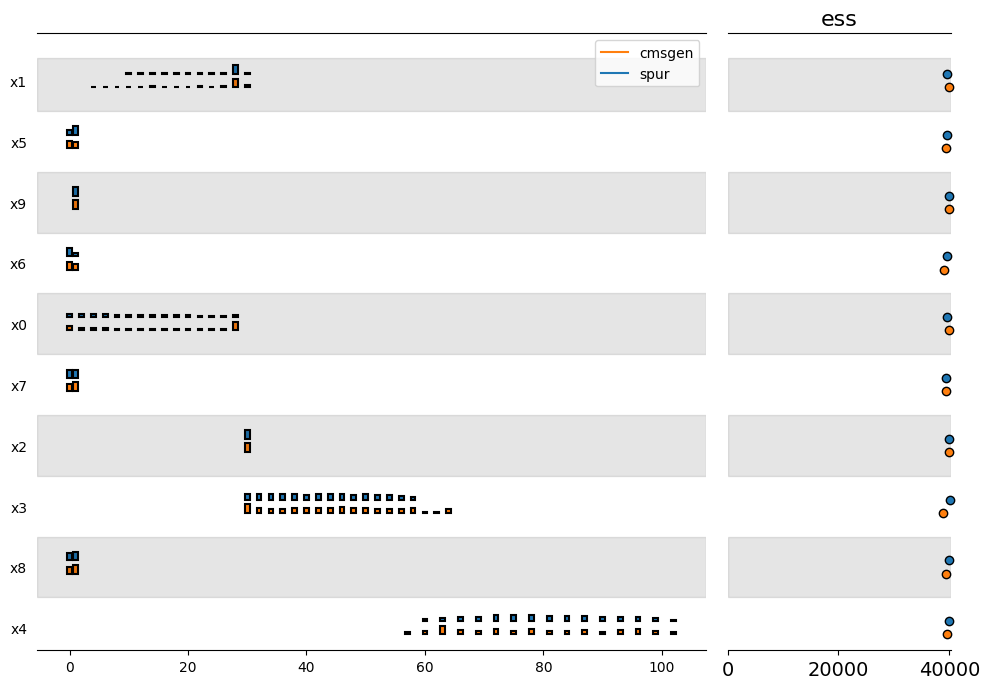

In [82]:
az.plot_forest(traces_db_cacm, combined=True, model_names=backends, hdi_prob=0.95, kind='ridgeplot', figsize=(10,7), ridgeplot_overlap=0.5, ess=True);

## NZ Stats

In [32]:
(g, num_bits, num_vars) = models.get_nz_stats_sat(
    path_to_dataset='sat/spur/nz_db/south_head.csv'
)
backends = ['spur', 'cmsgen']
traces_nz_stats = [ 
    mcmc.sample_mh_trace_from_z3_model(backend=backend,
                                       z3_problem=g,
                                       num_bits=num_bits,
                                       num_vars=num_vars,
                                       num_samples=10000)
    for backend in backends ]

Using default filename: "spur_input/samples_z3_problem.txt"
Performing Uniform Model Sampling...
Input File:  spur_input/z3_problem.cnf
Output File: spur_input/samples_z3_problem.txt

Preprocessing ... DONE
variables (all/used/free): 	661/661/0
independent support size:  	0
clauses (all/long/binary/unit): 2025/1183/754/88
Initialize cache
Size of Cacheable Component:	56
Size of MPZ Class:	16
Maximum cache size:	464 MB

STAGE #1: Build the initial partial assignments
STAGE #1: COMPLETED building initial partial assignments
STAGE #2 - Filling in partial assignments...
Initialize cache
Size of Cacheable Component:	56
Size of MPZ Class:	16
Maximum cache size:	464 MB

Sample #1 of 2 is already a complete assignment.  Continuing...
Completing sample #2 of 2 which has 3 variables unset and 102 samples.
STAGE #2 - COMPLETE


variables (total / active / free)	661/661/0
clauses (removed) 		2025 (0)
decisions 				188
conflicts 				1
conflict clauses (all/bin/unit) 	30/19/88
failed literals found 

c CMSGen Copyright Mate Soos (soos.mate@gmail.com)
c CMSGen SHA revision 00791438b32bb387e1f6ba7c1b211d7f6595aa06
c CMSGen is MIT licensed
c CMSGen compilation env CMAKE_CXX_COMPILER = /usr/bin/c++ | CMAKE_CXX_FLAGS =  -fno-stack-protector -mtune=native -Wlogical-op -Wrestrict -Wnull-dereference -Wdouble-promotion -Wshadow -Wformat=2 -Wextra-semi -pedantic | COMPILE_DEFINES =  -DNDEBUG -D_FORTIFY_SOURCE=0 -DUSE_GAUSS -DUSE_ZLIB -DYALSAT_FPU | STATICCOMPILE = ON | ZLIB_FOUND = TRUE | VALGRIND_FOUND =  | ENABLE_TESTING = ON | SLOW_DEBUG = OFF | ENABLE_ASSERTIONS = OFF | MY_TARGETS =  | LARGEMEM =  | LIMITMEM =  | 
c CMSGen compiled with gcc version 9.4.0
c executed with command line: cmsgen --samples 1000 --samplefile cmsgen_input/cmsgen_samples.out cmsgen_input/z3_problem.cnf
c Writing samples to file: cmsgen_input/cmsgen_samples.out
c Number of samples found until now:     10
c Number of samples found until now:     20
c Number of samples found until now:     30
c Number of samples fou

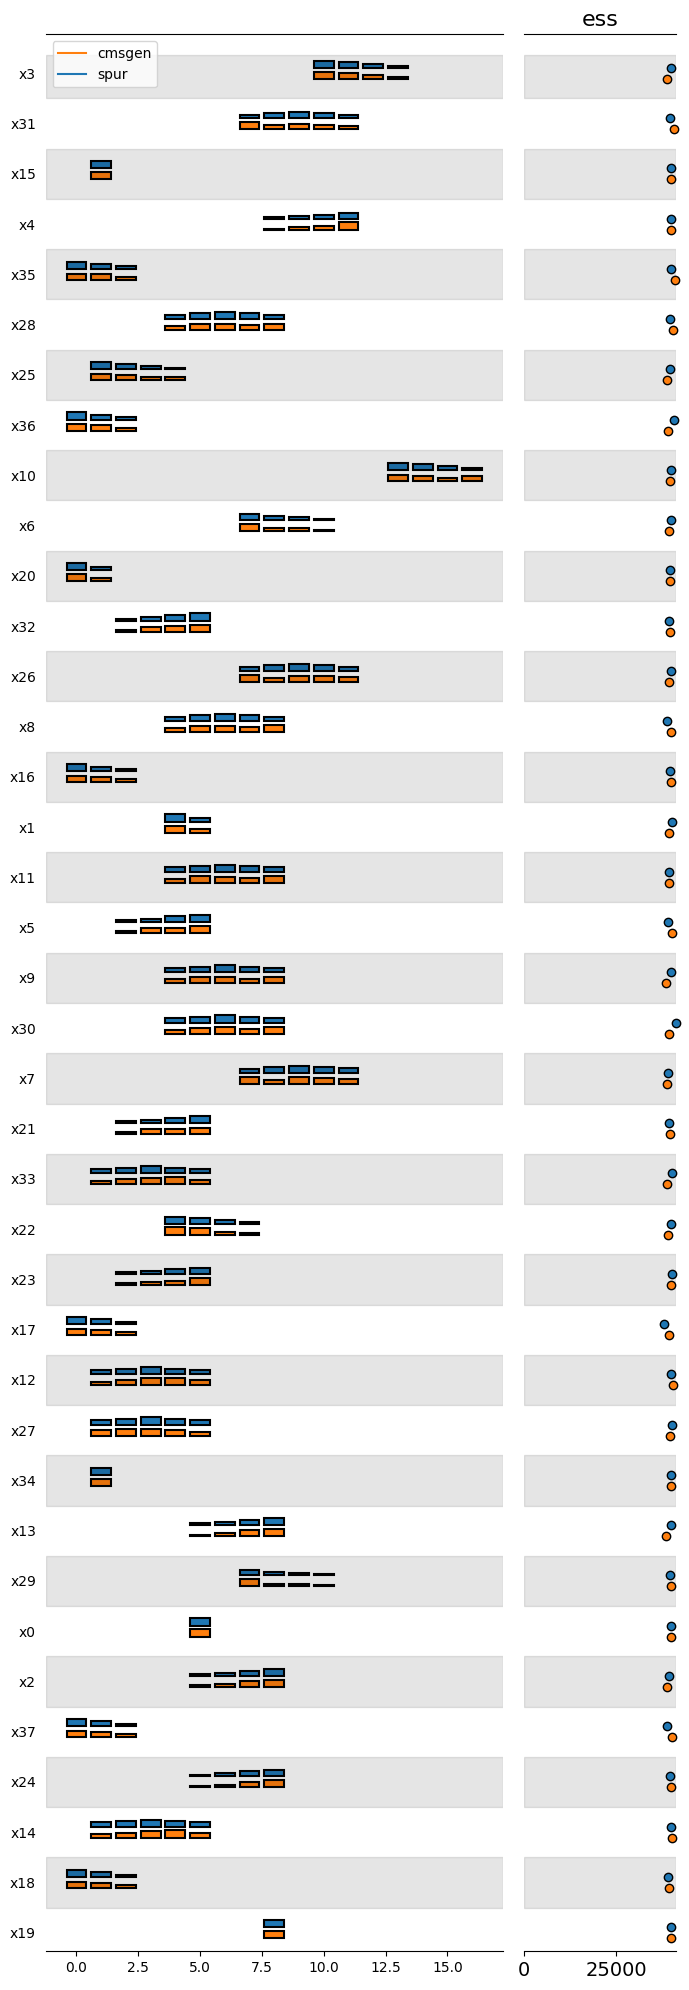

In [88]:
az.plot_forest(traces_nz_stats, combined=True, model_names=backends, hdi_prob=0.95, kind='ridgeplot', figsize=(7,20), ridgeplot_overlap=0.5, ess=True);

## Roads

In [56]:
(g, num_bits, num_vars) = models.get_roads_sat(num_bits = 7,
                                               max_int_bv = 2**5-1)
backends = ['spur', 'cmsgen']
traces_roads = [ 
    mcmc.sample_mh_trace_from_z3_model(backend=backend,
                                       z3_problem=g,
                                       num_bits=num_bits,
                                       num_vars=num_vars,
                                       num_samples=10000)
    for backend in backends ]

[(1, 2), (1, 3), (1, 4), (1, 5), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (4, 5)]


Using default filename: "spur_input/samples_z3_problem.txt"
Performing Uniform Model Sampling...
Input File:  spur_input/z3_problem.cnf
Output File: spur_input/samples_z3_problem.txt

Preprocessing ... DONE
variables (all/used/free): 	830/830/0
independent support size:  	0
clauses (all/long/binary/unit): 3804/2997/772/35
Initialize cache
Size of Cacheable Component:	56
Size of MPZ Class:	16
Maximum cache size:	1601 MB

STAGE #1: Build the initial partial assignments


STAGE #1: COMPLETED building initial partial assignments
STAGE #2 - Filling in partial assignments...
Initialize cache
Size of Cacheable Component:	56
Size of MPZ Class:	16
Maximum cache size:	1601 MB

Sample #1 of 936 is already a complete assignment.  Continuing...
Completing sample #2 of 936 which has 76 variables unset and 1 sample.
Completing sample #3 of 936 which has 78 variables unset and 1 sample.
Completing sample #4 of 936 which has 29 variables unset and 3 samples.
Completing sample #5 of 936 which has 60 variables unset and 3 samples.
Completing sample #6 of 936 which has 26 variables unset and 3 samples.
Completing sample #7 of 936 which has 55 variables unset and 1 sample.
Completing sample #8 of 936 which has 58 variables unset and 3 samples.
Completing sample #9 of 936 which has 54 variables unset and 6 samples.
Completing sample #10 of 936 which has 52 variables unset and 2 samples.
Completing sample #11 of 936 which has 41 variables unset and 2 samples.
Completing sa

Completing sample #58 of 936 which has 40 variables unset and 1 sample.
Completing sample #59 of 936 which has 33 variables unset and 14 samples.
Completing sample #60 of 936 which has 23 variables unset and 21 samples.
Completing sample #61 of 936 which has 83 variables unset and 13 samples.
Completing sample #62 of 936 which has 47 variables unset and 22 samples.
Completing sample #63 of 936 which has 84 variables unset and 3 samples.
Completing sample #64 of 936 which has 91 variables unset and 2 samples.
Completing sample #65 of 936 which has 28 variables unset and 2 samples.
Completing sample #66 of 936 which has 52 variables unset and 8 samples.
Completing sample #67 of 936 which has 65 variables unset and 5 samples.
Completing sample #68 of 936 which has 28 variables unset and 8 samples.
Completing sample #69 of 936 which has 32 variables unset and 2 samples.
Completing sample #70 of 936 which has 32 variables unset and 1 sample.
Completing sample #71 of 936 which has 62 variabl

Completing sample #131 of 936 which has 34 variables unset and 1 sample.
Completing sample #132 of 936 which has 46 variables unset and 2 samples.
Completing sample #133 of 936 which has 111 variables unset and 4 samples.
Completing sample #134 of 936 which has 86 variables unset and 1 sample.
Completing sample #135 of 936 which has 38 variables unset and 3 samples.
Completing sample #136 of 936 which has 87 variables unset and 3 samples.
Completing sample #137 of 936 which has 68 variables unset and 2 samples.
Completing sample #138 of 936 which has 50 variables unset and 3 samples.
Completing sample #139 of 936 which has 51 variables unset and 7 samples.
Completing sample #140 of 936 which has 71 variables unset and 7 samples.
Completing sample #141 of 936 which has 56 variables unset and 1 sample.
Completing sample #142 of 936 which has 47 variables unset and 30 samples.
Completing sample #143 of 936 which has 145 variables unset and 3 samples.
Completing sample #144 of 936 which ha

Completing sample #194 of 936 which has 102 variables unset and 5 samples.
Completing sample #195 of 936 which has 45 variables unset and 2 samples.
Completing sample #196 of 936 which has 76 variables unset and 2 samples.
Completing sample #197 of 936 which has 66 variables unset and 2 samples.
Completing sample #198 of 936 which has 73 variables unset and 6 samples.
Completing sample #199 of 936 which has 102 variables unset and 3 samples.
Completing sample #200 of 936 which has 103 variables unset and 3 samples.
Completing sample #201 of 936 which has 61 variables unset and 16 samples.
Completing sample #202 of 936 which has 59 variables unset and 20 samples.
Completing sample #203 of 936 which has 137 variables unset and 4 samples.
Completing sample #204 of 936 which has 76 variables unset and 4 samples.
Completing sample #205 of 936 which has 126 variables unset and 2 samples.
Completing sample #206 of 936 which has 72 variables unset and 2 samples.
Completing sample #207 of 936 w

Completing sample #262 of 936 which has 70 variables unset and 3 samples.
Completing sample #263 of 936 which has 40 variables unset and 5 samples.
Completing sample #264 of 936 which has 65 variables unset and 5 samples.
Completing sample #265 of 936 which has 34 variables unset and 1 sample.
Completing sample #266 of 936 which has 42 variables unset and 6 samples.
Completing sample #267 of 936 which has 56 variables unset and 6 samples.
Completing sample #268 of 936 which has 28 variables unset and 8 samples.
Completing sample #269 of 936 which has 77 variables unset and 3 samples.
Completing sample #270 of 936 which has 43 variables unset and 10 samples.
Completing sample #271 of 936 which has 34 variables unset and 1 sample.
Completing sample #272 of 936 which has 38 variables unset and 6 samples.
Completing sample #273 of 936 which has 90 variables unset and 4 samples.
Completing sample #274 of 936 which has 59 variables unset and 3 samples.
Completing sample #275 of 936 which has

Completing sample #327 of 936 which has 51 variables unset and 1 sample.
Completing sample #328 of 936 which has 29 variables unset and 1 sample.
Completing sample #329 of 936 which has 70 variables unset and 6 samples.
Completing sample #330 of 936 which has 68 variables unset and 6 samples.
Completing sample #331 of 936 which has 149 variables unset and 4 samples.
Completing sample #332 of 936 which has 167 variables unset and 4 samples.
Completing sample #333 of 936 which has 72 variables unset and 2 samples.
Completing sample #334 of 936 which has 100 variables unset and 1 sample.
Completing sample #335 of 936 which has 58 variables unset and 3 samples.
Completing sample #336 of 936 which has 38 variables unset and 3 samples.
Completing sample #337 of 936 which has 44 variables unset and 7 samples.
Completing sample #338 of 936 which has 145 variables unset and 1 sample.
Completing sample #339 of 936 which has 17 variables unset and 3 samples.
Completing sample #340 of 936 which ha

Completing sample #387 of 936 which has 53 variables unset and 2 samples.
Completing sample #388 of 936 which has 93 variables unset and 5 samples.
Completing sample #389 of 936 which has 61 variables unset and 3 samples.
Completing sample #390 of 936 which has 27 variables unset and 1 sample.
Completing sample #391 of 936 which has 63 variables unset and 3 samples.
Completing sample #392 of 936 which has 79 variables unset and 2 samples.
Completing sample #393 of 936 which has 60 variables unset and 2 samples.
Completing sample #394 of 936 which has 139 variables unset and 1 sample.
Completing sample #395 of 936 which has 173 variables unset and 5 samples.
Completing sample #396 of 936 which has 177 variables unset and 3 samples.
Completing sample #397 of 936 which has 77 variables unset and 2 samples.
Completing sample #398 of 936 which has 45 variables unset and 9 samples.
Completing sample #399 of 936 which has 80 variables unset and 5 samples.
Completing sample #400 of 936 which h

Completing sample #449 of 936 which has 120 variables unset and 5 samples.
Completing sample #450 of 936 which has 59 variables unset and 3 samples.
Completing sample #451 of 936 which has 70 variables unset and 6 samples.
Completing sample #452 of 936 which has 55 variables unset and 1 sample.
Completing sample #453 of 936 which has 26 variables unset and 2 samples.
Completing sample #454 of 936 which has 57 variables unset and 7 samples.
Completing sample #455 of 936 which has 26 variables unset and 3 samples.
Completing sample #456 of 936 which has 67 variables unset and 8 samples.
Completing sample #457 of 936 which has 20 variables unset and 15 samples.
Completing sample #458 of 936 which has 86 variables unset and 2 samples.
Completing sample #459 of 936 which has 60 variables unset and 6 samples.
Completing sample #460 of 936 which has 17 variables unset and 52 samples.
Completing sample #461 of 936 which has 42 variables unset and 17 samples.
Completing sample #462 of 936 which

Completing sample #517 of 936 which has 79 variables unset and 3 samples.
Completing sample #518 of 936 which has 35 variables unset and 7 samples.
Completing sample #519 of 936 which has 40 variables unset and 4 samples.
Completing sample #520 of 936 which has 41 variables unset and 2 samples.
Completing sample #521 of 936 which has 75 variables unset and 10 samples.
Completing sample #522 of 936 which has 50 variables unset and 2 samples.
Completing sample #523 of 936 which has 79 variables unset and 4 samples.
Completing sample #524 of 936 which has 75 variables unset and 6 samples.
Completing sample #525 of 936 which has 68 variables unset and 14 samples.
Completing sample #526 of 936 which has 65 variables unset and 4 samples.
Completing sample #527 of 936 which has 89 variables unset and 3 samples.
Completing sample #528 of 936 which has 79 variables unset and 5 samples.
Completing sample #529 of 936 which has 107 variables unset and 8 samples.
Completing sample #530 of 936 which

Completing sample #585 of 936 which has 65 variables unset and 10 samples.
Completing sample #586 of 936 which has 40 variables unset and 1 sample.
Completing sample #587 of 936 which has 156 variables unset and 2 samples.
Completing sample #588 of 936 which has 123 variables unset and 2 samples.
Completing sample #589 of 936 which has 164 variables unset and 3 samples.
Completing sample #590 of 936 which has 138 variables unset and 2 samples.
Completing sample #591 of 936 which has 52 variables unset and 5 samples.
Completing sample #592 of 936 which has 42 variables unset and 2 samples.
Completing sample #593 of 936 which has 27 variables unset and 9 samples.
Completing sample #594 of 936 which has 27 variables unset and 4 samples.
Completing sample #595 of 936 which has 29 variables unset and 1 sample.
Completing sample #596 of 936 which has 95 variables unset and 3 samples.
Completing sample #597 of 936 which has 84 variables unset and 9 samples.
Completing sample #598 of 936 which

Completing sample #648 of 936 which has 141 variables unset and 8 samples.
Completing sample #649 of 936 which has 60 variables unset and 2 samples.
Completing sample #650 of 936 which has 76 variables unset and 2 samples.
Completing sample #651 of 936 which has 63 variables unset and 1 sample.
Completing sample #652 of 936 which has 132 variables unset and 5 samples.
Completing sample #653 of 936 which has 31 variables unset and 1 sample.
Completing sample #654 of 936 which has 48 variables unset and 3 samples.
Completing sample #655 of 936 which has 68 variables unset and 3 samples.
Completing sample #656 of 936 which has 20 variables unset and 10 samples.
Completing sample #657 of 936 which has 55 variables unset and 1 sample.
Completing sample #658 of 936 which has 29 variables unset and 4 samples.
Completing sample #659 of 936 which has 40 variables unset and 4 samples.
Completing sample #660 of 936 which has 24 variables unset and 1 sample.
Completing sample #661 of 936 which has

Completing sample #713 of 936 which has 63 variables unset and 4 samples.
Completing sample #714 of 936 which has 32 variables unset and 1 sample.
Completing sample #715 of 936 which has 65 variables unset and 1 sample.
Completing sample #716 of 936 which has 72 variables unset and 1 sample.
Completing sample #717 of 936 which has 76 variables unset and 8 samples.
Completing sample #718 of 936 which has 69 variables unset and 1 sample.
Completing sample #719 of 936 which has 31 variables unset and 4 samples.
Completing sample #720 of 936 which has 70 variables unset and 6 samples.
Completing sample #721 of 936 which has 67 variables unset and 3 samples.
Completing sample #722 of 936 which has 94 variables unset and 4 samples.
Completing sample #723 of 936 which has 69 variables unset and 1 sample.
Completing sample #724 of 936 which has 134 variables unset and 3 samples.
Completing sample #725 of 936 which has 65 variables unset and 1 sample.
Completing sample #726 of 936 which has 42 

Completing sample #775 of 936 which has 104 variables unset and 1 sample.
Completing sample #776 of 936 which has 53 variables unset and 1 sample.
Completing sample #777 of 936 which has 65 variables unset and 4 samples.
Completing sample #778 of 936 which has 62 variables unset and 1 sample.
Completing sample #779 of 936 which has 153 variables unset and 2 samples.
Completing sample #780 of 936 which has 57 variables unset and 2 samples.
Completing sample #781 of 936 which has 147 variables unset and 3 samples.
Completing sample #782 of 936 which has 93 variables unset and 6 samples.
Completing sample #783 of 936 which has 130 variables unset and 6 samples.
Completing sample #784 of 936 which has 192 variables unset and 13 samples.
Completing sample #785 of 936 which has 105 variables unset and 6 samples.
Completing sample #786 of 936 which has 39 variables unset and 1 sample.
Completing sample #787 of 936 which has 80 variables unset and 3 samples.
Completing sample #788 of 936 which

Completing sample #834 of 936 which has 65 variables unset and 3 samples.
Completing sample #835 of 936 which has 104 variables unset and 5 samples.
Completing sample #836 of 936 which has 129 variables unset and 1 sample.
Completing sample #837 of 936 which has 108 variables unset and 2 samples.
Completing sample #838 of 936 which has 30 variables unset and 1 sample.
Completing sample #839 of 936 which has 141 variables unset and 1 sample.
Completing sample #840 of 936 which has 38 variables unset and 2 samples.
Completing sample #841 of 936 which has 43 variables unset and 3 samples.
Completing sample #842 of 936 which has 110 variables unset and 2 samples.
Completing sample #843 of 936 which has 66 variables unset and 3 samples.
Completing sample #844 of 936 which has 74 variables unset and 3 samples.
Completing sample #845 of 936 which has 44 variables unset and 1 sample.
Completing sample #846 of 936 which has 95 variables unset and 10 samples.
Completing sample #847 of 936 which 

Completing sample #896 of 936 which has 49 variables unset and 1 sample.
Completing sample #897 of 936 which has 56 variables unset and 2 samples.
Completing sample #898 of 936 which has 38 variables unset and 2 samples.
Completing sample #899 of 936 which has 67 variables unset and 2 samples.
Completing sample #900 of 936 which has 57 variables unset and 2 samples.
Completing sample #901 of 936 which has 62 variables unset and 4 samples.
Completing sample #902 of 936 which has 99 variables unset and 11 samples.
Completing sample #903 of 936 which has 49 variables unset and 1 sample.
Completing sample #904 of 936 which has 52 variables unset and 5 samples.
Completing sample #905 of 936 which has 82 variables unset and 3 samples.
Completing sample #906 of 936 which has 54 variables unset and 3 samples.
Completing sample #907 of 936 which has 25 variables unset and 2 samples.
Completing sample #908 of 936 which has 57 variables unset and 5 samples.
Completing sample #909 of 936 which has



variables (total / active / free)	830/830/0
clauses (removed) 		3804 (18446744073709551613)
decisions 				9728
conflicts 				1079
conflict clauses (all/bin/unit) 	9903/156/38
failed literals found by implicit BCP 	 6230
implicit BCP miss rate 	99.2114%
bytes cache size     	25325992	
bytes cache (overall) 	25786528
bytes cache (infra / comps) 20234408/5091584	
bytes pure comp data (curr)    4501648
bytes pure comp data (overall) 4933512
bytes cache with sysoverh (curr)    5663504
bytes cache with sysoverh (overall) 6151616
cache (stores / hits) 			9218/1989
cache miss rate 		83.0247%
avg. variable count (stores / hits) 	215.294/52.4384


# solutions 
12441

# END

time: 5.92487s


Total Sampler Execution Time: 5.92487s

#START_HEADER
start_time,Wed Jul 17 19:19:02 2024
formula_file,spur_input/z3_problem.cnf
num_vars,830
independent_support_size,0
num_clauses,3807
tot_num_models,12441
max_component_split_depth,1
max_branch_var_depth,29
num_samples,10000
num_second_pass_groups,936
num_

c CMSGen Copyright Mate Soos (soos.mate@gmail.com)
c CMSGen SHA revision 00791438b32bb387e1f6ba7c1b211d7f6595aa06
c CMSGen is MIT licensed
c CMSGen compilation env CMAKE_CXX_COMPILER = /usr/bin/c++ | CMAKE_CXX_FLAGS =  -fno-stack-protector -mtune=native -Wlogical-op -Wrestrict -Wnull-dereference -Wdouble-promotion -Wshadow -Wformat=2 -Wextra-semi -pedantic | COMPILE_DEFINES =  -DNDEBUG -D_FORTIFY_SOURCE=0 -DUSE_GAUSS -DUSE_ZLIB -DYALSAT_FPU | STATICCOMPILE = ON | ZLIB_FOUND = TRUE | VALGRIND_FOUND =  | ENABLE_TESTING = ON | SLOW_DEBUG = OFF | ENABLE_ASSERTIONS = OFF | MY_TARGETS =  | LARGEMEM =  | LIMITMEM =  | 
c CMSGen compiled with gcc version 9.4.0
c executed with command line: cmsgen --samples 10000 --samplefile cmsgen_input/cmsgen_samples.out cmsgen_input/z3_problem.cnf
c Writing samples to file: cmsgen_input/cmsgen_samples.out


c Number of samples found until now:     10


c Number of samples found until now:     20


c Number of samples found until now:     30


c Number of samples found until now:     40


c Number of samples found until now:     50
c Number of samples found until now:     60


c Number of samples found until now:     70


c Number of samples found until now:     80


c Number of samples found until now:     90
c Number of samples found until now:    100


c Number of samples found until now:    110
c Number of samples found until now:    120


c Number of samples found until now:    130
c Number of samples found until now:    140


c Number of samples found until now:    150
c Number of samples found until now:    160


c Number of samples found until now:    170
c Number of samples found until now:    180


c Number of samples found until now:    190
c Number of samples found until now:    200
c Number of samples found until now:    210


c Number of samples found until now:    220
c Number of samples found until now:    230


c Number of samples found until now:    240
c Number of samples found until now:    250
c Number of samples found until now:    260


c Number of samples found until now:    270
c Number of samples found until now:    280


c Number of samples found until now:    290
c Number of samples found until now:    300


c Number of samples found until now:    310
c Number of samples found until now:    320


c Number of samples found until now:    330
c Number of samples found until now:    340


c Number of samples found until now:    350


c Number of samples found until now:    360
c Number of samples found until now:    370
c Number of samples found until now:    380


c Number of samples found until now:    390


c Number of samples found until now:    400
c Number of samples found until now:    410


c Number of samples found until now:    420
c Number of samples found until now:    430


c Number of samples found until now:    440
c Number of samples found until now:    450


c Number of samples found until now:    460
c Number of samples found until now:    470
c Number of samples found until now:    480


c Number of samples found until now:    490
c Number of samples found until now:    500


c Number of samples found until now:    510
c Number of samples found until now:    520
c Number of samples found until now:    530


c Number of samples found until now:    540
c Number of samples found until now:    550


c Number of samples found until now:    560
c Number of samples found until now:    570


c Number of samples found until now:    580
c Number of samples found until now:    590


c Number of samples found until now:    600
c Number of samples found until now:    610


c Number of samples found until now:    620
c Number of samples found until now:    630


c Number of samples found until now:    640
c Number of samples found until now:    650
c Number of samples found until now:    660
c Number of samples found until now:    670


c Number of samples found until now:    680
c Number of samples found until now:    690
c Number of samples found until now:    700


c Number of samples found until now:    710
c Number of samples found until now:    720


c Number of samples found until now:    730
c Number of samples found until now:    740


c Number of samples found until now:    750
c Number of samples found until now:    760
c Number of samples found until now:    770


c Number of samples found until now:    780
c Number of samples found until now:    790
c Number of samples found until now:    800


c Number of samples found until now:    810
c Number of samples found until now:    820
c Number of samples found until now:    830
c Number of samples found until now:    840


c Number of samples found until now:    850
c Number of samples found until now:    860


c Number of samples found until now:    870
c Number of samples found until now:    880


c Number of samples found until now:    890
c Number of samples found until now:    900
c Number of samples found until now:    910


c Number of samples found until now:    920
c Number of samples found until now:    930
c Number of samples found until now:    940


c Number of samples found until now:    950
c Number of samples found until now:    960


c Number of samples found until now:    970
c Number of samples found until now:    980


c Number of samples found until now:    990
c Number of samples found until now:   1000
c Number of samples found until now:   1010


c Number of samples found until now:   1020
c Number of samples found until now:   1030
c Number of samples found until now:   1040


c Number of samples found until now:   1050
c Number of samples found until now:   1060
c Number of samples found until now:   1070


c Number of samples found until now:   1080
c Number of samples found until now:   1090
c Number of samples found until now:   1100


c Number of samples found until now:   1110
c Number of samples found until now:   1120
c Number of samples found until now:   1130


c Number of samples found until now:   1140
c Number of samples found until now:   1150
c Number of samples found until now:   1160


c Number of samples found until now:   1170
c Number of samples found until now:   1180
c Number of samples found until now:   1190
c Number of samples found until now:   1200


c Number of samples found until now:   1210
c Number of samples found until now:   1220


c Number of samples found until now:   1230
c Number of samples found until now:   1240
c Number of samples found until now:   1250


c Number of samples found until now:   1260
c Number of samples found until now:   1270
c Number of samples found until now:   1280
c Number of samples found until now:   1290


c Number of samples found until now:   1300
c Number of samples found until now:   1310
c Number of samples found until now:   1320
c Number of samples found until now:   1330
c Number of samples found until now:   1340


c Number of samples found until now:   1350
c Number of samples found until now:   1360
c Number of samples found until now:   1370


c Number of samples found until now:   1380
c Number of samples found until now:   1390
c Number of samples found until now:   1400


c Number of samples found until now:   1410
c Number of samples found until now:   1420
c Number of samples found until now:   1430


c Number of samples found until now:   1440
c Number of samples found until now:   1450
c Number of samples found until now:   1460
c Number of samples found until now:   1470


c Number of samples found until now:   1480
c Number of samples found until now:   1490
c Number of samples found until now:   1500
c Number of samples found until now:   1510


c Number of samples found until now:   1520
c Number of samples found until now:   1530
c Number of samples found until now:   1540
c Number of samples found until now:   1550


c Number of samples found until now:   1560
c Number of samples found until now:   1570
c Number of samples found until now:   1580


c Number of samples found until now:   1590
c Number of samples found until now:   1600
c Number of samples found until now:   1610
c Number of samples found until now:   1620


c Number of samples found until now:   1630
c Number of samples found until now:   1640
c Number of samples found until now:   1650


c Number of samples found until now:   1660
c Number of samples found until now:   1670
c Number of samples found until now:   1680


c Number of samples found until now:   1690
c Number of samples found until now:   1700
c Number of samples found until now:   1710
c Number of samples found until now:   1720


c Number of samples found until now:   1730
c Number of samples found until now:   1740
c Number of samples found until now:   1750


c Number of samples found until now:   1760
c Number of samples found until now:   1770
c Number of samples found until now:   1780


c Number of samples found until now:   1790
c Number of samples found until now:   1800
c Number of samples found until now:   1810


c Number of samples found until now:   1820
c Number of samples found until now:   1830
c Number of samples found until now:   1840
c Number of samples found until now:   1850


c Number of samples found until now:   1860
c Number of samples found until now:   1870
c Number of samples found until now:   1880
c Number of samples found until now:   1890


c Number of samples found until now:   1900
c Number of samples found until now:   1910
c Number of samples found until now:   1920


c Number of samples found until now:   1930
c Number of samples found until now:   1940


c Number of samples found until now:   1950
c Number of samples found until now:   1960
c Number of samples found until now:   1970


c Number of samples found until now:   1980
c Number of samples found until now:   1990


c Number of samples found until now:   2000
c Number of samples found until now:   2010
c Number of samples found until now:   2020


c Number of samples found until now:   2030
c Number of samples found until now:   2040


c Number of samples found until now:   2050
c Number of samples found until now:   2060
c Number of samples found until now:   2070
c Number of samples found until now:   2080


c Number of samples found until now:   2090
c Number of samples found until now:   2100
c Number of samples found until now:   2110
c Number of samples found until now:   2120


c Number of samples found until now:   2130
c Number of samples found until now:   2140
c Number of samples found until now:   2150
c Number of samples found until now:   2160


c Number of samples found until now:   2170
c Number of samples found until now:   2180
c Number of samples found until now:   2190


c Number of samples found until now:   2200
c Number of samples found until now:   2210
c Number of samples found until now:   2220


c Number of samples found until now:   2230
c Number of samples found until now:   2240
c Number of samples found until now:   2250
c Number of samples found until now:   2260
c Number of samples found until now:   2270


c Number of samples found until now:   2280
c Number of samples found until now:   2290
c Number of samples found until now:   2300


c Number of samples found until now:   2310
c Number of samples found until now:   2320
c Number of samples found until now:   2330
c Number of samples found until now:   2340
c Number of samples found until now:   2350
c Number of samples found until now:   2360


c Number of samples found until now:   2370
c Number of samples found until now:   2380


c Number of samples found until now:   2390
c Number of samples found until now:   2400


c Number of samples found until now:   2410
c Number of samples found until now:   2420
c Number of samples found until now:   2430


c Number of samples found until now:   2440
c Number of samples found until now:   2450
c Number of samples found until now:   2460


c Number of samples found until now:   2470
c Number of samples found until now:   2480
c Number of samples found until now:   2490


c Number of samples found until now:   2500


c Number of samples found until now:   2510
c Number of samples found until now:   2520
c Number of samples found until now:   2530


c Number of samples found until now:   2540
c Number of samples found until now:   2550
c Number of samples found until now:   2560
c Number of samples found until now:   2570
c Number of samples found until now:   2580


c Number of samples found until now:   2590
c Number of samples found until now:   2600
c Number of samples found until now:   2610


c Number of samples found until now:   2620
c Number of samples found until now:   2630
c Number of samples found until now:   2640
c Number of samples found until now:   2650
c Number of samples found until now:   2660


c Number of samples found until now:   2670
c Number of samples found until now:   2680
c Number of samples found until now:   2690


c Number of samples found until now:   2700
c Number of samples found until now:   2710
c Number of samples found until now:   2720
c Number of samples found until now:   2730
c Number of samples found until now:   2740


c Number of samples found until now:   2750
c Number of samples found until now:   2760
c Number of samples found until now:   2770
c Number of samples found until now:   2780


c Number of samples found until now:   2790
c Number of samples found until now:   2800
c Number of samples found until now:   2810
c Number of samples found until now:   2820
c Number of samples found until now:   2830


c Number of samples found until now:   2840
c Number of samples found until now:   2850
c Number of samples found until now:   2860


c Number of samples found until now:   2870
c Number of samples found until now:   2880
c Number of samples found until now:   2890


c Number of samples found until now:   2900
c Number of samples found until now:   2910


c Number of samples found until now:   2920
c Number of samples found until now:   2930
c Number of samples found until now:   2940


c Number of samples found until now:   2950
c Number of samples found until now:   2960
c Number of samples found until now:   2970


c Number of samples found until now:   2980
c Number of samples found until now:   2990
c Number of samples found until now:   3000


c Number of samples found until now:   3010
c Number of samples found until now:   3020


c Number of samples found until now:   3030
c Number of samples found until now:   3040
c Number of samples found until now:   3050
c Number of samples found until now:   3060


c Number of samples found until now:   3070
c Number of samples found until now:   3080
c Number of samples found until now:   3090


c Number of samples found until now:   3100
c Number of samples found until now:   3110
c Number of samples found until now:   3120


c Number of samples found until now:   3130
c Number of samples found until now:   3140
c Number of samples found until now:   3150
c Number of samples found until now:   3160


c Number of samples found until now:   3170
c Number of samples found until now:   3180
c Number of samples found until now:   3190


c Number of samples found until now:   3200
c Number of samples found until now:   3210
c Number of samples found until now:   3220


c Number of samples found until now:   3230
c Number of samples found until now:   3240
c Number of samples found until now:   3250


c Number of samples found until now:   3260
c Number of samples found until now:   3270
c Number of samples found until now:   3280
c Number of samples found until now:   3290
c Number of samples found until now:   3300


c Number of samples found until now:   3310
c Number of samples found until now:   3320
c Number of samples found until now:   3330


c Number of samples found until now:   3340
c Number of samples found until now:   3350


c Number of samples found until now:   3360
c Number of samples found until now:   3370
c Number of samples found until now:   3380
c Number of samples found until now:   3390
c Number of samples found until now:   3400


c Number of samples found until now:   3410
c Number of samples found until now:   3420
c Number of samples found until now:   3430


c Number of samples found until now:   3440
c Number of samples found until now:   3450
c Number of samples found until now:   3460
c Number of samples found until now:   3470


c Number of samples found until now:   3480
c Number of samples found until now:   3490
c Number of samples found until now:   3500
c Number of samples found until now:   3510


c Number of samples found until now:   3520
c Number of samples found until now:   3530
c Number of samples found until now:   3540
c Number of samples found until now:   3550


c Number of samples found until now:   3560
c Number of samples found until now:   3570
c Number of samples found until now:   3580
c Number of samples found until now:   3590


c Number of samples found until now:   3600
c Number of samples found until now:   3610
c Number of samples found until now:   3620
c Number of samples found until now:   3630


c Number of samples found until now:   3640
c Number of samples found until now:   3650
c Number of samples found until now:   3660


c Number of samples found until now:   3670
c Number of samples found until now:   3680
c Number of samples found until now:   3690
c Number of samples found until now:   3700


c Number of samples found until now:   3710
c Number of samples found until now:   3720
c Number of samples found until now:   3730
c Number of samples found until now:   3740


c Number of samples found until now:   3750
c Number of samples found until now:   3760
c Number of samples found until now:   3770


c Number of samples found until now:   3780
c Number of samples found until now:   3790
c Number of samples found until now:   3800
c Number of samples found until now:   3810


c Number of samples found until now:   3820
c Number of samples found until now:   3830
c Number of samples found until now:   3840
c Number of samples found until now:   3850


c Number of samples found until now:   3860
c Number of samples found until now:   3870
c Number of samples found until now:   3880
c Number of samples found until now:   3890
c Number of samples found until now:   3900


c Number of samples found until now:   3910
c Number of samples found until now:   3920
c Number of samples found until now:   3930
c Number of samples found until now:   3940


c Number of samples found until now:   3950
c Number of samples found until now:   3960
c Number of samples found until now:   3970
c Number of samples found until now:   3980


c Number of samples found until now:   3990
c Number of samples found until now:   4000
c Number of samples found until now:   4010


c Number of samples found until now:   4020
c Number of samples found until now:   4030
c Number of samples found until now:   4040


c Number of samples found until now:   4050
c Number of samples found until now:   4060
c Number of samples found until now:   4070


c Number of samples found until now:   4080
c Number of samples found until now:   4090
c Number of samples found until now:   4100


c Number of samples found until now:   4110
c Number of samples found until now:   4120
c Number of samples found until now:   4130


c Number of samples found until now:   4140
c Number of samples found until now:   4150
c Number of samples found until now:   4160
c Number of samples found until now:   4170


c Number of samples found until now:   4180
c Number of samples found until now:   4190
c Number of samples found until now:   4200


c Number of samples found until now:   4210
c Number of samples found until now:   4220
c Number of samples found until now:   4230
c Number of samples found until now:   4240


c Number of samples found until now:   4250
c Number of samples found until now:   4260
c Number of samples found until now:   4270
c Number of samples found until now:   4280
c Number of samples found until now:   4290


c Number of samples found until now:   4300
c Number of samples found until now:   4310


c Number of samples found until now:   4320
c Number of samples found until now:   4330
c Number of samples found until now:   4340
c Number of samples found until now:   4350
c Number of samples found until now:   4360


c Number of samples found until now:   4370
c Number of samples found until now:   4380
c Number of samples found until now:   4390
c Number of samples found until now:   4400
c Number of samples found until now:   4410


c Number of samples found until now:   4420
c Number of samples found until now:   4430
c Number of samples found until now:   4440


c Number of samples found until now:   4450
c Number of samples found until now:   4460
c Number of samples found until now:   4470


c Number of samples found until now:   4480
c Number of samples found until now:   4490
c Number of samples found until now:   4500


c Number of samples found until now:   4510
c Number of samples found until now:   4520
c Number of samples found until now:   4530
c Number of samples found until now:   4540
c Number of samples found until now:   4550


c Number of samples found until now:   4560
c Number of samples found until now:   4570
c Number of samples found until now:   4580
c Number of samples found until now:   4590


c Number of samples found until now:   4600
c Number of samples found until now:   4610
c Number of samples found until now:   4620
c Number of samples found until now:   4630


c Number of samples found until now:   4640
c Number of samples found until now:   4650
c Number of samples found until now:   4660


c Number of samples found until now:   4670
c Number of samples found until now:   4680
c Number of samples found until now:   4690


c Number of samples found until now:   4700
c Number of samples found until now:   4710
c Number of samples found until now:   4720


c Number of samples found until now:   4730
c Number of samples found until now:   4740


c Number of samples found until now:   4750
c Number of samples found until now:   4760
c Number of samples found until now:   4770
c Number of samples found until now:   4780


c Number of samples found until now:   4790
c Number of samples found until now:   4800
c Number of samples found until now:   4810
c Number of samples found until now:   4820


c Number of samples found until now:   4830
c Number of samples found until now:   4840
c Number of samples found until now:   4850


c Number of samples found until now:   4860
c Number of samples found until now:   4870
c Number of samples found until now:   4880


c Number of samples found until now:   4890
c Number of samples found until now:   4900
c Number of samples found until now:   4910
c Number of samples found until now:   4920
c Number of samples found until now:   4930
c Number of samples found until now:   4940


c Number of samples found until now:   4950
c Number of samples found until now:   4960
c Number of samples found until now:   4970


c Number of samples found until now:   4980
c Number of samples found until now:   4990
c Number of samples found until now:   5000
c Number of samples found until now:   5010


c Number of samples found until now:   5020
c Number of samples found until now:   5030
c Number of samples found until now:   5040


c Number of samples found until now:   5050
c Number of samples found until now:   5060
c Number of samples found until now:   5070


c Number of samples found until now:   5080
c Number of samples found until now:   5090
c Number of samples found until now:   5100


c Number of samples found until now:   5110
c Number of samples found until now:   5120
c Number of samples found until now:   5130
c Number of samples found until now:   5140


c Number of samples found until now:   5150
c Number of samples found until now:   5160
c Number of samples found until now:   5170


c Number of samples found until now:   5180
c Number of samples found until now:   5190
c Number of samples found until now:   5200
c Number of samples found until now:   5210


c Number of samples found until now:   5220
c Number of samples found until now:   5230
c Number of samples found until now:   5240


c Number of samples found until now:   5250
c Number of samples found until now:   5260
c Number of samples found until now:   5270
c Number of samples found until now:   5280


c Number of samples found until now:   5290
c Number of samples found until now:   5300
c Number of samples found until now:   5310


c Number of samples found until now:   5320
c Number of samples found until now:   5330


c Number of samples found until now:   5340
c Number of samples found until now:   5350
c Number of samples found until now:   5360


c Number of samples found until now:   5370
c Number of samples found until now:   5380
c Number of samples found until now:   5390


c Number of samples found until now:   5400
c Number of samples found until now:   5410
c Number of samples found until now:   5420


c Number of samples found until now:   5430
c Number of samples found until now:   5440
c Number of samples found until now:   5450
c Number of samples found until now:   5460


c Number of samples found until now:   5470
c Number of samples found until now:   5480
c Number of samples found until now:   5490
c Number of samples found until now:   5500
c Number of samples found until now:   5510


c Number of samples found until now:   5520
c Number of samples found until now:   5530
c Number of samples found until now:   5540


c Number of samples found until now:   5550
c Number of samples found until now:   5560
c Number of samples found until now:   5570


c Number of samples found until now:   5580
c Number of samples found until now:   5590
c Number of samples found until now:   5600


c Number of samples found until now:   5610
c Number of samples found until now:   5620
c Number of samples found until now:   5630
c Number of samples found until now:   5640


c Number of samples found until now:   5650
c Number of samples found until now:   5660
c Number of samples found until now:   5670
c Number of samples found until now:   5680


c Number of samples found until now:   5690
c Number of samples found until now:   5700


c Number of samples found until now:   5710
c Number of samples found until now:   5720
c Number of samples found until now:   5730
c Number of samples found until now:   5740
c Number of samples found until now:   5750


c Number of samples found until now:   5760
c Number of samples found until now:   5770


c Number of samples found until now:   5780
c Number of samples found until now:   5790
c Number of samples found until now:   5800


c Number of samples found until now:   5810
c Number of samples found until now:   5820
c Number of samples found until now:   5830
c Number of samples found until now:   5840
c Number of samples found until now:   5850


c Number of samples found until now:   5860
c Number of samples found until now:   5870
c Number of samples found until now:   5880
c Number of samples found until now:   5890


c Number of samples found until now:   5900
c Number of samples found until now:   5910
c Number of samples found until now:   5920
c Number of samples found until now:   5930


c Number of samples found until now:   5940
c Number of samples found until now:   5950
c Number of samples found until now:   5960
c Number of samples found until now:   5970
c Number of samples found until now:   5980


c Number of samples found until now:   5990
c Number of samples found until now:   6000
c Number of samples found until now:   6010


c Number of samples found until now:   6020
c Number of samples found until now:   6030
c Number of samples found until now:   6040
c Number of samples found until now:   6050
c Number of samples found until now:   6060


c Number of samples found until now:   6070
c Number of samples found until now:   6080
c Number of samples found until now:   6090
c Number of samples found until now:   6100
c Number of samples found until now:   6110


c Number of samples found until now:   6120
c Number of samples found until now:   6130


c Number of samples found until now:   6140
c Number of samples found until now:   6150
c Number of samples found until now:   6160
c Number of samples found until now:   6170
c Number of samples found until now:   6180
c Number of samples found until now:   6190


c Number of samples found until now:   6200
c Number of samples found until now:   6210
c Number of samples found until now:   6220
c Number of samples found until now:   6230
c Number of samples found until now:   6240


c Number of samples found until now:   6250
c Number of samples found until now:   6260
c Number of samples found until now:   6270


c Number of samples found until now:   6280
c Number of samples found until now:   6290
c Number of samples found until now:   6300
c Number of samples found until now:   6310
c Number of samples found until now:   6320


c Number of samples found until now:   6330
c Number of samples found until now:   6340
c Number of samples found until now:   6350
c Number of samples found until now:   6360


c Number of samples found until now:   6370
c Number of samples found until now:   6380
c Number of samples found until now:   6390
c Number of samples found until now:   6400


c Number of samples found until now:   6410
c Number of samples found until now:   6420
c Number of samples found until now:   6430


c Number of samples found until now:   6440
c Number of samples found until now:   6450
c Number of samples found until now:   6460
c Number of samples found until now:   6470


c Number of samples found until now:   6480
c Number of samples found until now:   6490
c Number of samples found until now:   6500
c Number of samples found until now:   6510


c Number of samples found until now:   6520
c Number of samples found until now:   6530
c Number of samples found until now:   6540


c Number of samples found until now:   6550
c Number of samples found until now:   6560
c Number of samples found until now:   6570
c Number of samples found until now:   6580


c Number of samples found until now:   6590
c Number of samples found until now:   6600
c Number of samples found until now:   6610
c Number of samples found until now:   6620


c Number of samples found until now:   6630
c Number of samples found until now:   6640
c Number of samples found until now:   6650


c Number of samples found until now:   6660
c Number of samples found until now:   6670
c Number of samples found until now:   6680
c Number of samples found until now:   6690


c Number of samples found until now:   6700
c Number of samples found until now:   6710
c Number of samples found until now:   6720
c Number of samples found until now:   6730


c Number of samples found until now:   6740
c Number of samples found until now:   6750
c Number of samples found until now:   6760
c Number of samples found until now:   6770


c Number of samples found until now:   6780
c Number of samples found until now:   6790
c Number of samples found until now:   6800
c Number of samples found until now:   6810


c Number of samples found until now:   6820
c Number of samples found until now:   6830
c Number of samples found until now:   6840
c Number of samples found until now:   6850


c Number of samples found until now:   6860
c Number of samples found until now:   6870
c Number of samples found until now:   6880
c Number of samples found until now:   6890
c Number of samples found until now:   6900


c Number of samples found until now:   6910
c Number of samples found until now:   6920
c Number of samples found until now:   6930
c Number of samples found until now:   6940
c Number of samples found until now:   6950
c Number of samples found until now:   6960
c Number of samples found until now:   6970


c Number of samples found until now:   6980
c Number of samples found until now:   6990
c Number of samples found until now:   7000
c Number of samples found until now:   7010
c Number of samples found until now:   7020
c Number of samples found until now:   7030


c Number of samples found until now:   7040
c Number of samples found until now:   7050
c Number of samples found until now:   7060
c Number of samples found until now:   7070


c Number of samples found until now:   7080
c Number of samples found until now:   7090
c Number of samples found until now:   7100


c Number of samples found until now:   7110
c Number of samples found until now:   7120
c Number of samples found until now:   7130
c Number of samples found until now:   7140
c Number of samples found until now:   7150


c Number of samples found until now:   7160
c Number of samples found until now:   7170
c Number of samples found until now:   7180
c Number of samples found until now:   7190


c Number of samples found until now:   7200
c Number of samples found until now:   7210
c Number of samples found until now:   7220
c Number of samples found until now:   7230


c Number of samples found until now:   7240
c Number of samples found until now:   7250
c Number of samples found until now:   7260
c Number of samples found until now:   7270
c Number of samples found until now:   7280
c Number of samples found until now:   7290


c Number of samples found until now:   7300
c Number of samples found until now:   7310
c Number of samples found until now:   7320
c Number of samples found until now:   7330
c Number of samples found until now:   7340


c Number of samples found until now:   7350
c Number of samples found until now:   7360
c Number of samples found until now:   7370
c Number of samples found until now:   7380


c Number of samples found until now:   7390
c Number of samples found until now:   7400
c Number of samples found until now:   7410
c Number of samples found until now:   7420


c Number of samples found until now:   7430
c Number of samples found until now:   7440
c Number of samples found until now:   7450
c Number of samples found until now:   7460
c Number of samples found until now:   7470


c Number of samples found until now:   7480
c Number of samples found until now:   7490
c Number of samples found until now:   7500
c Number of samples found until now:   7510
c Number of samples found until now:   7520
c Number of samples found until now:   7530


c Number of samples found until now:   7540
c Number of samples found until now:   7550
c Number of samples found until now:   7560
c Number of samples found until now:   7570
c Number of samples found until now:   7580


c Number of samples found until now:   7590
c Number of samples found until now:   7600
c Number of samples found until now:   7610
c Number of samples found until now:   7620
c Number of samples found until now:   7630


c Number of samples found until now:   7640
c Number of samples found until now:   7650
c Number of samples found until now:   7660
c Number of samples found until now:   7670


c Number of samples found until now:   7680
c Number of samples found until now:   7690
c Number of samples found until now:   7700
c Number of samples found until now:   7710
c Number of samples found until now:   7720


c Number of samples found until now:   7730
c Number of samples found until now:   7740
c Number of samples found until now:   7750
c Number of samples found until now:   7760
c Number of samples found until now:   7770


c Number of samples found until now:   7780
c Number of samples found until now:   7790
c Number of samples found until now:   7800
c Number of samples found until now:   7810


c Number of samples found until now:   7820
c Number of samples found until now:   7830
c Number of samples found until now:   7840
c Number of samples found until now:   7850
c Number of samples found until now:   7860


c Number of samples found until now:   7870
c Number of samples found until now:   7880
c Number of samples found until now:   7890
c Number of samples found until now:   7900
c Number of samples found until now:   7910
c Number of samples found until now:   7920
c Number of samples found until now:   7930


c Number of samples found until now:   7940
c Number of samples found until now:   7950
c Number of samples found until now:   7960
c Number of samples found until now:   7970
c Number of samples found until now:   7980


c Number of samples found until now:   7990
c Number of samples found until now:   8000
c Number of samples found until now:   8010


c Number of samples found until now:   8020
c Number of samples found until now:   8030
c Number of samples found until now:   8040
c Number of samples found until now:   8050
c Number of samples found until now:   8060
c Number of samples found until now:   8070


c Number of samples found until now:   8080
c Number of samples found until now:   8090
c Number of samples found until now:   8100
c Number of samples found until now:   8110
c Number of samples found until now:   8120
c Number of samples found until now:   8130
c Number of samples found until now:   8140


c Number of samples found until now:   8150
c Number of samples found until now:   8160
c Number of samples found until now:   8170
c Number of samples found until now:   8180
c Number of samples found until now:   8190


c Number of samples found until now:   8200
c Number of samples found until now:   8210
c Number of samples found until now:   8220
c Number of samples found until now:   8230
c Number of samples found until now:   8240


c Number of samples found until now:   8250
c Number of samples found until now:   8260
c Number of samples found until now:   8270
c Number of samples found until now:   8280
c Number of samples found until now:   8290
c Number of samples found until now:   8300
c Number of samples found until now:   8310


c Number of samples found until now:   8320
c Number of samples found until now:   8330
c Number of samples found until now:   8340
c Number of samples found until now:   8350
c Number of samples found until now:   8360


c Number of samples found until now:   8370
c Number of samples found until now:   8380
c Number of samples found until now:   8390
c Number of samples found until now:   8400
c Number of samples found until now:   8410
c Number of samples found until now:   8420


c Number of samples found until now:   8430
c Number of samples found until now:   8440
c Number of samples found until now:   8450
c Number of samples found until now:   8460
c Number of samples found until now:   8470


c Number of samples found until now:   8480
c Number of samples found until now:   8490
c Number of samples found until now:   8500
c Number of samples found until now:   8510
c Number of samples found until now:   8520


c Number of samples found until now:   8530
c Number of samples found until now:   8540
c Number of samples found until now:   8550
c Number of samples found until now:   8560
c Number of samples found until now:   8570
c Number of samples found until now:   8580


c Number of samples found until now:   8590
c Number of samples found until now:   8600
c Number of samples found until now:   8610
c Number of samples found until now:   8620


c Number of samples found until now:   8630
c Number of samples found until now:   8640
c Number of samples found until now:   8650
c Number of samples found until now:   8660
c Number of samples found until now:   8670
c Number of samples found until now:   8680
c Number of samples found until now:   8690


c Number of samples found until now:   8700
c Number of samples found until now:   8710
c Number of samples found until now:   8720
c Number of samples found until now:   8730
c Number of samples found until now:   8740
c Number of samples found until now:   8750
c Number of samples found until now:   8760
c Number of samples found until now:   8770


c Number of samples found until now:   8780
c Number of samples found until now:   8790
c Number of samples found until now:   8800
c Number of samples found until now:   8810
c Number of samples found until now:   8820
c Number of samples found until now:   8830
c Number of samples found until now:   8840


c Number of samples found until now:   8850
c Number of samples found until now:   8860
c Number of samples found until now:   8870
c Number of samples found until now:   8880
c Number of samples found until now:   8890
c Number of samples found until now:   8900
c Number of samples found until now:   8910


c Number of samples found until now:   8920
c Number of samples found until now:   8930
c Number of samples found until now:   8940


c Number of samples found until now:   8950
c Number of samples found until now:   8960
c Number of samples found until now:   8970
c Number of samples found until now:   8980
c Number of samples found until now:   8990
c Number of samples found until now:   9000


c Number of samples found until now:   9010
c Number of samples found until now:   9020
c Number of samples found until now:   9030
c Number of samples found until now:   9040
c Number of samples found until now:   9050
c Number of samples found until now:   9060
c Number of samples found until now:   9070


c Number of samples found until now:   9080
c Number of samples found until now:   9090
c Number of samples found until now:   9100
c Number of samples found until now:   9110
c Number of samples found until now:   9120
c Number of samples found until now:   9130


c Number of samples found until now:   9140
c Number of samples found until now:   9150
c Number of samples found until now:   9160
c Number of samples found until now:   9170
c Number of samples found until now:   9180
c Number of samples found until now:   9190


c Number of samples found until now:   9200
c Number of samples found until now:   9210
c Number of samples found until now:   9220
c Number of samples found until now:   9230
c Number of samples found until now:   9240
c Number of samples found until now:   9250
c Number of samples found until now:   9260


c Number of samples found until now:   9270
c Number of samples found until now:   9280
c Number of samples found until now:   9290
c Number of samples found until now:   9300
c Number of samples found until now:   9310
c Number of samples found until now:   9320


c Number of samples found until now:   9330
c Number of samples found until now:   9340
c Number of samples found until now:   9350
c Number of samples found until now:   9360
c Number of samples found until now:   9370
c Number of samples found until now:   9380
c Number of samples found until now:   9390
c Number of samples found until now:   9400


c Number of samples found until now:   9410
c Number of samples found until now:   9420
c Number of samples found until now:   9430
c Number of samples found until now:   9440
c Number of samples found until now:   9450
c Number of samples found until now:   9460
c Number of samples found until now:   9470


c Number of samples found until now:   9480
c Number of samples found until now:   9490
c Number of samples found until now:   9500
c Number of samples found until now:   9510
c Number of samples found until now:   9520
c Number of samples found until now:   9530


c Number of samples found until now:   9540
c Number of samples found until now:   9550
c Number of samples found until now:   9560
c Number of samples found until now:   9570
c Number of samples found until now:   9580
c Number of samples found until now:   9590
c Number of samples found until now:   9600


c Number of samples found until now:   9610
c Number of samples found until now:   9620
c Number of samples found until now:   9630
c Number of samples found until now:   9640


c Number of samples found until now:   9650
c Number of samples found until now:   9660
c Number of samples found until now:   9670
c Number of samples found until now:   9680
c Number of samples found until now:   9690
c Number of samples found until now:   9700
c Number of samples found until now:   9710


c Number of samples found until now:   9720
c Number of samples found until now:   9730
c Number of samples found until now:   9740
c Number of samples found until now:   9750
c Number of samples found until now:   9760
c Number of samples found until now:   9770
c Number of samples found until now:   9780


c Number of samples found until now:   9790
c Number of samples found until now:   9800
c Number of samples found until now:   9810
c Number of samples found until now:   9820
c Number of samples found until now:   9830
c Number of samples found until now:   9840


c Number of samples found until now:   9850
c Number of samples found until now:   9860
c Number of samples found until now:   9870
c Number of samples found until now:   9880


c Number of samples found until now:   9890
c Number of samples found until now:   9900
c Number of samples found until now:   9910
c Number of samples found until now:   9920
c Number of samples found until now:   9930
c Number of samples found until now:   9940


c Number of samples found until now:   9950
c Number of samples found until now:   9960
c Number of samples found until now:   9970
c Number of samples found until now:   9980
c Number of samples found until now:   9990


c Finished generating all 10000 samples
c Total time: 78 s 


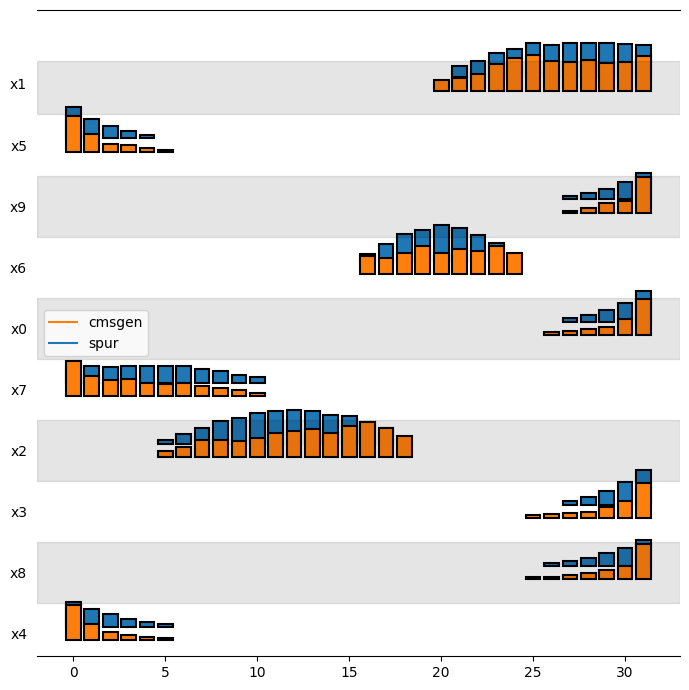

In [58]:
az.plot_forest(traces_roads, combined=True, model_names=backends, hdi_prob=0.95, kind='ridgeplot', figsize=(7,7));

## Books

In [60]:
(g, num_bits, num_vars) = models.get_books_sat()
backends = ['spur', 'cmsgen']
traces_books = [ 
    mcmc.sample_mh_trace_from_z3_model(backend=backend,
                                       z3_problem=g,
                                       num_bits=num_bits,
                                       num_vars=num_vars,
                                       num_samples=10000)
    for backend in backends ]

Using default filename: "spur_input/samples_z3_problem.txt"
Performing Uniform Model Sampling...
Input File:  spur_input/z3_problem.cnf
Output File: spur_input/samples_z3_problem.txt

Preprocessing ... DONE
variables (all/used/free): 	2788/2788/0
independent support size:  	0
clauses (all/long/binary/unit): 10830/7749/2911/170
Initialize cache
Size of Cacheable Component:	56
Size of MPZ Class:	16
Maximum cache size:	2055 MB

STAGE #1: Build the initial partial assignments


STAGE #1: COMPLETED building initial partial assignments
STAGE #2 - Filling in partial assignments...


Initialize cache
Size of Cacheable Component:	56
Size of MPZ Class:	16

 Free RAM 1717MB
Maximum cache size:	2055 MB

Completing sample #1 of 9998 which has 104 variables unset and 1 sample.
Completing sample #2 of 9998 which has 144 variables unset and 1 sample.
Completing sample #3 of 9998 which has 65 variables unset and 1 sample.
Completing sample #4 of 9998 which has 220 variables unset and 1 sample.


Completing sample #5 of 9998 which has 187 variables unset and 1 sample.
Completing sample #6 of 9998 which has 190 variables unset and 1 sample.
Completing sample #7 of 9998 which has 124 variables unset and 1 sample.
Completing sample #8 of 9998 which has 54 variables unset and 1 sample.
Completing sample #9 of 9998 which has 15 variables unset and 1 sample.
Completing sample #10 of 9998 which has 169 variables unset and 1 sample.
Completing sample #11 of 9998 which has 110 variables unset and 1 sample.
Completing sample #12 of 9998 which has 142 variables unset and 1 sample.
Completing sample #13 of 9998 which has 97 variables unset and 1 sample.
Completing sample #14 of 9998 which has 138 variables unset and 1 sample.
Completing sample #15 of 9998 which has 217 variables unset and 1 sample.
Completing sample #16 of 9998 which has 46 variables unset and 1 sample.
Completing sample #17 of 9998 which has 105 variables unset and 1 sample.
Completing sample #18 of 9998 which has 163 var

Completing sample #29 of 9998 which has 155 variables unset and 1 sample.
Completing sample #30 of 9998 which has 219 variables unset and 1 sample.
Completing sample #31 of 9998 which has 250 variables unset and 1 sample.
Completing sample #32 of 9998 which has 159 variables unset and 1 sample.
Completing sample #33 of 9998 which has 122 variables unset and 1 sample.
Completing sample #34 of 9998 which has 113 variables unset and 1 sample.
Completing sample #35 of 9998 which has 77 variables unset and 1 sample.
Completing sample #36 of 9998 which has 109 variables unset and 1 sample.
Completing sample #37 of 9998 which has 132 variables unset and 1 sample.
Completing sample #38 of 9998 which has 235 variables unset and 1 sample.
Completing sample #39 of 9998 which has 154 variables unset and 1 sample.
Completing sample #40 of 9998 which has 166 variables unset and 1 sample.
Completing sample #41 of 9998 which has 166 variables unset and 1 sample.
Completing sample #42 of 9998 which has

Completing sample #52 of 9998 which has 130 variables unset and 1 sample.
Completing sample #53 of 9998 which has 101 variables unset and 1 sample.
Completing sample #54 of 9998 which has 205 variables unset and 1 sample.
Completing sample #55 of 9998 which has 170 variables unset and 1 sample.
Completing sample #56 of 9998 which has 149 variables unset and 1 sample.
Completing sample #57 of 9998 which has 125 variables unset and 1 sample.
Completing sample #58 of 9998 which has 83 variables unset and 1 sample.
Completing sample #59 of 9998 which has 137 variables unset and 1 sample.
Completing sample #60 of 9998 which has 147 variables unset and 1 sample.
Completing sample #61 of 9998 which has 208 variables unset and 1 sample.
Completing sample #62 of 9998 which has 156 variables unset and 1 sample.
Completing sample #63 of 9998 which has 211 variables unset and 1 sample.
Completing sample #64 of 9998 which has 200 variables unset and 1 sample.
Completing sample #65 of 9998 which has

Completing sample #75 of 9998 which has 100 variables unset and 1 sample.
Completing sample #76 of 9998 which has 112 variables unset and 1 sample.
Completing sample #77 of 9998 which has 104 variables unset and 1 sample.
Completing sample #78 of 9998 which has 158 variables unset and 1 sample.
Completing sample #79 of 9998 which has 132 variables unset and 1 sample.
Completing sample #80 of 9998 which has 79 variables unset and 1 sample.
Completing sample #81 of 9998 which has 138 variables unset and 1 sample.
Completing sample #82 of 9998 which has 176 variables unset and 1 sample.
Completing sample #83 of 9998 which has 79 variables unset and 1 sample.
Completing sample #84 of 9998 which has 52 variables unset and 1 sample.
Completing sample #85 of 9998 which has 174 variables unset and 1 sample.
Completing sample #86 of 9998 which has 17 variables unset and 1 sample.
Completing sample #87 of 9998 which has 96 variables unset and 1 sample.
Completing sample #88 of 9998 which has 110

Completing sample #99 of 9998 which has 105 variables unset and 1 sample.
Completing sample #100 of 9998 which has 104 variables unset and 1 sample.
Completing sample #101 of 9998 which has 154 variables unset and 1 sample.
Completing sample #102 of 9998 which has 111 variables unset and 1 sample.
Completing sample #103 of 9998 which has 66 variables unset and 1 sample.
Completing sample #104 of 9998 which has 124 variables unset and 1 sample.
Completing sample #105 of 9998 which has 172 variables unset and 1 sample.
Completing sample #106 of 9998 which has 142 variables unset and 1 sample.
Completing sample #107 of 9998 which has 55 variables unset and 1 sample.
Completing sample #108 of 9998 which has 136 variables unset and 1 sample.
Completing sample #109 of 9998 which has 134 variables unset and 1 sample.
Completing sample #110 of 9998 which has 96 variables unset and 1 sample.
Completing sample #111 of 9998 which has 171 variables unset and 1 sample.
Completing sample #112 of 999

Completing sample #122 of 9998 which has 119 variables unset and 1 sample.
Completing sample #123 of 9998 which has 85 variables unset and 1 sample.
Completing sample #124 of 9998 which has 40 variables unset and 1 sample.
Completing sample #125 of 9998 which has 94 variables unset and 1 sample.
Completing sample #126 of 9998 which has 129 variables unset and 1 sample.
Completing sample #127 of 9998 which has 209 variables unset and 1 sample.
Completing sample #128 of 9998 which has 54 variables unset and 1 sample.
Completing sample #129 of 9998 which has 120 variables unset and 1 sample.
Completing sample #130 of 9998 which has 81 variables unset and 1 sample.
Completing sample #131 of 9998 which has 121 variables unset and 1 sample.
Completing sample #132 of 9998 which has 137 variables unset and 1 sample.
Completing sample #133 of 9998 which has 69 variables unset and 1 sample.
Completing sample #134 of 9998 which has 102 variables unset and 1 sample.
Completing sample #135 of 9998 

Completing sample #145 of 9998 which has 136 variables unset and 1 sample.
Completing sample #146 of 9998 which has 130 variables unset and 1 sample.
Completing sample #147 of 9998 which has 194 variables unset and 1 sample.
Completing sample #148 of 9998 which has 118 variables unset and 1 sample.
Completing sample #149 of 9998 which has 81 variables unset and 1 sample.
Completing sample #150 of 9998 which has 54 variables unset and 1 sample.
Completing sample #151 of 9998 which has 108 variables unset and 1 sample.
Completing sample #152 of 9998 which has 214 variables unset and 1 sample.
Completing sample #153 of 9998 which has 78 variables unset and 1 sample.
Completing sample #154 of 9998 which has 134 variables unset and 1 sample.
Completing sample #155 of 9998 which has 165 variables unset and 1 sample.
Completing sample #156 of 9998 which has 51 variables unset and 1 sample.
Completing sample #157 of 9998 which has 243 variables unset and 1 sample.
Completing sample #158 of 999

Completing sample #168 of 9998 which has 108 variables unset and 1 sample.
Completing sample #169 of 9998 which has 58 variables unset and 1 sample.
Completing sample #170 of 9998 which has 111 variables unset and 1 sample.
Completing sample #171 of 9998 which has 58 variables unset and 1 sample.
Completing sample #172 of 9998 which has 158 variables unset and 1 sample.
Completing sample #173 of 9998 which has 73 variables unset and 1 sample.
Completing sample #174 of 9998 which has 176 variables unset and 1 sample.
Completing sample #175 of 9998 which has 209 variables unset and 1 sample.
Completing sample #176 of 9998 which has 137 variables unset and 1 sample.
Completing sample #177 of 9998 which has 218 variables unset and 1 sample.
Completing sample #178 of 9998 which has 167 variables unset and 1 sample.
Completing sample #179 of 9998 which has 183 variables unset and 1 sample.
Completing sample #180 of 9998 which has 162 variables unset and 1 sample.
Completing sample #181 of 99

Completing sample #190 of 9998 which has 202 variables unset and 1 sample.
Completing sample #191 of 9998 which has 57 variables unset and 1 sample.
Completing sample #192 of 9998 which has 170 variables unset and 1 sample.
Completing sample #193 of 9998 which has 170 variables unset and 1 sample.
Completing sample #194 of 9998 which has 106 variables unset and 1 sample.
Completing sample #195 of 9998 which has 168 variables unset and 1 sample.
Completing sample #196 of 9998 which has 55 variables unset and 1 sample.
Completing sample #197 of 9998 which has 101 variables unset and 1 sample.
Completing sample #198 of 9998 which has 135 variables unset and 1 sample.
Completing sample #199 of 9998 which has 94 variables unset and 1 sample.
Completing sample #200 of 9998 which has 74 variables unset and 1 sample.
Completing sample #201 of 9998 which has 182 variables unset and 1 sample.
Completing sample #202 of 9998 which has 168 variables unset and 1 sample.
Completing sample #203 of 999

Completing sample #212 of 9998 which has 155 variables unset and 1 sample.
Completing sample #213 of 9998 which has 147 variables unset and 1 sample.
Completing sample #214 of 9998 which has 67 variables unset and 1 sample.
Completing sample #215 of 9998 which has 159 variables unset and 1 sample.
Completing sample #216 of 9998 which has 155 variables unset and 1 sample.
Completing sample #217 of 9998 which has 231 variables unset and 1 sample.
Completing sample #218 of 9998 which has 160 variables unset and 1 sample.
Completing sample #219 of 9998 which has 101 variables unset and 1 sample.
Completing sample #220 of 9998 which has 179 variables unset and 1 sample.
Completing sample #221 of 9998 which has 57 variables unset and 1 sample.
Completing sample #222 of 9998 which has 139 variables unset and 1 sample.
Completing sample #223 of 9998 which has 71 variables unset and 1 sample.
Completing sample #224 of 9998 which has 79 variables unset and 1 sample.
Completing sample #225 of 999

Completing sample #235 of 9998 which has 79 variables unset and 1 sample.
Completing sample #236 of 9998 which has 136 variables unset and 1 sample.
Completing sample #237 of 9998 which has 38 variables unset and 1 sample.
Completing sample #238 of 9998 which has 87 variables unset and 1 sample.
Completing sample #239 of 9998 which has 100 variables unset and 1 sample.
Completing sample #240 of 9998 which has 215 variables unset and 1 sample.
Completing sample #241 of 9998 which has 91 variables unset and 1 sample.
Completing sample #242 of 9998 which has 165 variables unset and 1 sample.
Completing sample #243 of 9998 which has 75 variables unset and 1 sample.
Completing sample #244 of 9998 which has 166 variables unset and 1 sample.
Completing sample #245 of 9998 which has 93 variables unset and 1 sample.
Completing sample #246 of 9998 which has 145 variables unset and 1 sample.
Completing sample #247 of 9998 which has 180 variables unset and 1 sample.
Completing sample #248 of 9998 

Completing sample #258 of 9998 which has 68 variables unset and 1 sample.
Completing sample #259 of 9998 which has 224 variables unset and 1 sample.
Completing sample #260 of 9998 which has 201 variables unset and 1 sample.
Completing sample #261 of 9998 which has 110 variables unset and 1 sample.
Completing sample #262 of 9998 which has 97 variables unset and 1 sample.
Completing sample #263 of 9998 which has 126 variables unset and 1 sample.
Completing sample #264 of 9998 which has 106 variables unset and 1 sample.
Completing sample #265 of 9998 which has 206 variables unset and 1 sample.
Completing sample #266 of 9998 which has 162 variables unset and 1 sample.
Completing sample #267 of 9998 which has 73 variables unset and 1 sample.
Completing sample #268 of 9998 which has 205 variables unset and 1 sample.
Completing sample #269 of 9998 which has 74 variables unset and 1 sample.
Completing sample #270 of 9998 which has 151 variables unset and 1 sample.
Completing sample #271 of 999

Completing sample #279 of 9998 which has 166 variables unset and 1 sample.
Completing sample #280 of 9998 which has 101 variables unset and 1 sample.
Completing sample #281 of 9998 which has 45 variables unset and 1 sample.
Completing sample #282 of 9998 which has 128 variables unset and 1 sample.
Completing sample #283 of 9998 which has 146 variables unset and 1 sample.
Completing sample #284 of 9998 which has 114 variables unset and 1 sample.
Completing sample #285 of 9998 which has 267 variables unset and 1 sample.
Completing sample #286 of 9998 which has 237 variables unset and 1 sample.
Completing sample #287 of 9998 which has 141 variables unset and 1 sample.
Completing sample #288 of 9998 which has 161 variables unset and 1 sample.
Completing sample #289 of 9998 which has 187 variables unset and 1 sample.
Completing sample #290 of 9998 which has 160 variables unset and 1 sample.
Completing sample #291 of 9998 which has 131 variables unset and 1 sample.
Completing sample #292 of 

Completing sample #301 of 9998 which has 120 variables unset and 1 sample.
Completing sample #302 of 9998 which has 86 variables unset and 1 sample.
Completing sample #303 of 9998 which has 65 variables unset and 1 sample.
Completing sample #304 of 9998 which has 80 variables unset and 1 sample.
Completing sample #305 of 9998 which has 61 variables unset and 1 sample.
Completing sample #306 of 9998 which has 124 variables unset and 1 sample.
Completing sample #307 of 9998 which has 121 variables unset and 1 sample.
Completing sample #308 of 9998 which has 147 variables unset and 1 sample.
Completing sample #309 of 9998 which has 70 variables unset and 1 sample.
Completing sample #310 of 9998 which has 88 variables unset and 1 sample.
Completing sample #311 of 9998 which has 98 variables unset and 1 sample.
Completing sample #312 of 9998 which has 130 variables unset and 1 sample.
Completing sample #313 of 9998 which has 193 variables unset and 1 sample.
Completing sample #314 of 9998 w

Completing sample #324 of 9998 which has 153 variables unset and 1 sample.
Completing sample #325 of 9998 which has 135 variables unset and 1 sample.
Completing sample #326 of 9998 which has 73 variables unset and 1 sample.
Completing sample #327 of 9998 which has 239 variables unset and 1 sample.
Completing sample #328 of 9998 which has 147 variables unset and 1 sample.
Completing sample #329 of 9998 which has 140 variables unset and 1 sample.
Completing sample #330 of 9998 which has 120 variables unset and 1 sample.
Completing sample #331 of 9998 which has 108 variables unset and 1 sample.
Completing sample #332 of 9998 which has 160 variables unset and 1 sample.
Completing sample #333 of 9998 which has 125 variables unset and 1 sample.
Completing sample #334 of 9998 which has 86 variables unset and 1 sample.
Completing sample #335 of 9998 which has 125 variables unset and 1 sample.
Completing sample #336 of 9998 which has 123 variables unset and 1 sample.
Completing sample #337 of 9

Completing sample #346 of 9998 which has 140 variables unset and 1 sample.
Completing sample #347 of 9998 which has 37 variables unset and 1 sample.
Completing sample #348 of 9998 which has 195 variables unset and 1 sample.
Completing sample #349 of 9998 which has 98 variables unset and 1 sample.
Completing sample #350 of 9998 which has 146 variables unset and 1 sample.
Completing sample #351 of 9998 which has 81 variables unset and 1 sample.
Completing sample #352 of 9998 which has 86 variables unset and 1 sample.
Completing sample #353 of 9998 which has 196 variables unset and 1 sample.
Completing sample #354 of 9998 which has 127 variables unset and 1 sample.
Completing sample #355 of 9998 which has 113 variables unset and 1 sample.
Completing sample #356 of 9998 which has 105 variables unset and 1 sample.
Completing sample #357 of 9998 which has 112 variables unset and 1 sample.
Completing sample #358 of 9998 which has 121 variables unset and 1 sample.
Completing sample #359 of 999

Completing sample #369 of 9998 which has 153 variables unset and 1 sample.
Completing sample #370 of 9998 which has 116 variables unset and 1 sample.
Completing sample #371 of 9998 which has 139 variables unset and 1 sample.
Completing sample #372 of 9998 which has 165 variables unset and 1 sample.
Completing sample #373 of 9998 which has 191 variables unset and 1 sample.
Completing sample #374 of 9998 which has 196 variables unset and 1 sample.
Completing sample #375 of 9998 which has 67 variables unset and 1 sample.
Completing sample #376 of 9998 which has 99 variables unset and 1 sample.
Completing sample #377 of 9998 which has 134 variables unset and 1 sample.
Completing sample #378 of 9998 which has 42 variables unset and 1 sample.
Completing sample #379 of 9998 which has 156 variables unset and 1 sample.
Completing sample #380 of 9998 which has 164 variables unset and 1 sample.
Completing sample #381 of 9998 which has 127 variables unset and 1 sample.
Completing sample #382 of 99

Completing sample #391 of 9998 which has 95 variables unset and 1 sample.
Completing sample #392 of 9998 which has 136 variables unset and 1 sample.
Completing sample #393 of 9998 which has 147 variables unset and 1 sample.
Completing sample #394 of 9998 which has 66 variables unset and 1 sample.
Completing sample #395 of 9998 which has 141 variables unset and 1 sample.
Completing sample #396 of 9998 which has 177 variables unset and 1 sample.
Completing sample #397 of 9998 which has 147 variables unset and 1 sample.
Completing sample #398 of 9998 which has 126 variables unset and 1 sample.
Completing sample #399 of 9998 which has 98 variables unset and 1 sample.
Completing sample #400 of 9998 which has 147 variables unset and 1 sample.
Completing sample #401 of 9998 which has 135 variables unset and 1 sample.
Completing sample #402 of 9998 which has 171 variables unset and 1 sample.
Completing sample #403 of 9998 which has 88 variables unset and 1 sample.
Completing sample #404 of 999

Completing sample #413 of 9998 which has 50 variables unset and 1 sample.
Completing sample #414 of 9998 which has 91 variables unset and 1 sample.
Completing sample #415 of 9998 which has 117 variables unset and 1 sample.
Completing sample #416 of 9998 which has 149 variables unset and 1 sample.
Completing sample #417 of 9998 which has 84 variables unset and 1 sample.
Completing sample #418 of 9998 which has 122 variables unset and 1 sample.
Completing sample #419 of 9998 which has 64 variables unset and 1 sample.
Completing sample #420 of 9998 which has 98 variables unset and 1 sample.
Completing sample #421 of 9998 which has 117 variables unset and 1 sample.
Completing sample #422 of 9998 which has 207 variables unset and 1 sample.
Completing sample #423 of 9998 which has 127 variables unset and 1 sample.
Completing sample #424 of 9998 which has 71 variables unset and 1 sample.
Completing sample #425 of 9998 which has 91 variables unset and 1 sample.
Completing sample #426 of 9998 w

Completing sample #435 of 9998 which has 145 variables unset and 1 sample.
Completing sample #436 of 9998 which has 164 variables unset and 1 sample.
Completing sample #437 of 9998 which has 59 variables unset and 1 sample.
Completing sample #438 of 9998 which has 75 variables unset and 1 sample.
Completing sample #439 of 9998 which has 144 variables unset and 1 sample.
Completing sample #440 of 9998 which has 159 variables unset and 1 sample.
Completing sample #441 of 9998 which has 132 variables unset and 1 sample.
Completing sample #442 of 9998 which has 136 variables unset and 1 sample.
Completing sample #443 of 9998 which has 147 variables unset and 1 sample.
Completing sample #444 of 9998 which has 142 variables unset and 1 sample.
Completing sample #445 of 9998 which has 141 variables unset and 1 sample.
Completing sample #446 of 9998 which has 156 variables unset and 1 sample.
Completing sample #447 of 9998 which has 76 variables unset and 1 sample.
Completing sample #448 of 99

Completing sample #457 of 9998 which has 199 variables unset and 1 sample.
Completing sample #458 of 9998 which has 93 variables unset and 1 sample.
Completing sample #459 of 9998 which has 130 variables unset and 1 sample.
Completing sample #460 of 9998 which has 106 variables unset and 1 sample.
Completing sample #461 of 9998 which has 135 variables unset and 1 sample.
Completing sample #462 of 9998 which has 105 variables unset and 1 sample.
Completing sample #463 of 9998 which has 63 variables unset and 1 sample.
Completing sample #464 of 9998 which has 94 variables unset and 1 sample.
Completing sample #465 of 9998 which has 94 variables unset and 1 sample.
Completing sample #466 of 9998 which has 115 variables unset and 1 sample.
Completing sample #467 of 9998 which has 203 variables unset and 1 sample.
Completing sample #468 of 9998 which has 155 variables unset and 1 sample.
Completing sample #469 of 9998 which has 220 variables unset and 1 sample.
Completing sample #470 of 999

Completing sample #479 of 9998 which has 179 variables unset and 1 sample.
Completing sample #480 of 9998 which has 97 variables unset and 1 sample.
Completing sample #481 of 9998 which has 60 variables unset and 1 sample.
Completing sample #482 of 9998 which has 159 variables unset and 1 sample.
Completing sample #483 of 9998 which has 188 variables unset and 1 sample.
Completing sample #484 of 9998 which has 116 variables unset and 1 sample.
Completing sample #485 of 9998 which has 150 variables unset and 1 sample.
Completing sample #486 of 9998 which has 127 variables unset and 1 sample.
Completing sample #487 of 9998 which has 107 variables unset and 1 sample.
Completing sample #488 of 9998 which has 111 variables unset and 1 sample.
Completing sample #489 of 9998 which has 65 variables unset and 1 sample.
Completing sample #490 of 9998 which has 95 variables unset and 1 sample.
Completing sample #491 of 9998 which has 127 variables unset and 1 sample.
Completing sample #492 of 999

Completing sample #501 of 9998 which has 94 variables unset and 1 sample.
Completing sample #502 of 9998 which has 83 variables unset and 1 sample.
Completing sample #503 of 9998 which has 92 variables unset and 1 sample.
Completing sample #504 of 9998 which has 130 variables unset and 1 sample.
Completing sample #505 of 9998 which has 57 variables unset and 1 sample.
Completing sample #506 of 9998 which has 166 variables unset and 1 sample.
Completing sample #507 of 9998 which has 159 variables unset and 1 sample.
Completing sample #508 of 9998 which has 67 variables unset and 1 sample.
Completing sample #509 of 9998 which has 82 variables unset and 1 sample.
Completing sample #510 of 9998 which has 132 variables unset and 1 sample.
Completing sample #511 of 9998 which has 245 variables unset and 1 sample.
Completing sample #512 of 9998 which has 85 variables unset and 1 sample.
Completing sample #513 of 9998 which has 91 variables unset and 1 sample.
Completing sample #514 of 9998 wh

Completing sample #523 of 9998 which has 163 variables unset and 1 sample.
Completing sample #524 of 9998 which has 162 variables unset and 1 sample.
Completing sample #525 of 9998 which has 90 variables unset and 1 sample.
Completing sample #526 of 9998 which has 81 variables unset and 1 sample.
Completing sample #527 of 9998 which has 160 variables unset and 1 sample.
Completing sample #528 of 9998 which has 148 variables unset and 1 sample.
Completing sample #529 of 9998 which has 196 variables unset and 1 sample.
Completing sample #530 of 9998 which has 102 variables unset and 1 sample.
Completing sample #531 of 9998 which has 161 variables unset and 1 sample.
Completing sample #532 of 9998 which has 129 variables unset and 1 sample.
Completing sample #533 of 9998 which has 147 variables unset and 1 sample.
Completing sample #534 of 9998 which has 179 variables unset and 1 sample.
Completing sample #535 of 9998 which has 45 variables unset and 1 sample.
Completing sample #536 of 99

Completing sample #544 of 9998 which has 161 variables unset and 1 sample.
Completing sample #545 of 9998 which has 136 variables unset and 1 sample.
Completing sample #546 of 9998 which has 341 variables unset and 1 sample.
Completing sample #547 of 9998 which has 63 variables unset and 1 sample.
Completing sample #548 of 9998 which has 187 variables unset and 1 sample.
Completing sample #549 of 9998 which has 122 variables unset and 1 sample.
Completing sample #550 of 9998 which has 97 variables unset and 1 sample.
Completing sample #551 of 9998 which has 259 variables unset and 1 sample.
Completing sample #552 of 9998 which has 116 variables unset and 1 sample.
Completing sample #553 of 9998 which has 78 variables unset and 1 sample.
Completing sample #554 of 9998 which has 132 variables unset and 1 sample.
Completing sample #555 of 9998 which has 131 variables unset and 1 sample.
Completing sample #556 of 9998 which has 84 variables unset and 1 sample.
Completing sample #557 of 999

Completing sample #565 of 9998 which has 166 variables unset and 1 sample.
Completing sample #566 of 9998 which has 88 variables unset and 1 sample.
Completing sample #567 of 9998 which has 230 variables unset and 1 sample.
Completing sample #568 of 9998 which has 134 variables unset and 1 sample.
Completing sample #569 of 9998 which has 287 variables unset and 1 sample.
Completing sample #570 of 9998 which has 86 variables unset and 1 sample.
Completing sample #571 of 9998 which has 216 variables unset and 1 sample.
Completing sample #572 of 9998 which has 109 variables unset and 1 sample.
Completing sample #573 of 9998 which has 92 variables unset and 1 sample.
Completing sample #574 of 9998 which has 111 variables unset and 1 sample.
Completing sample #575 of 9998 which has 96 variables unset and 1 sample.
Completing sample #576 of 9998 which has 214 variables unset and 1 sample.
Completing sample #577 of 9998 which has 169 variables unset and 1 sample.
Completing sample #578 of 999

Completing sample #586 of 9998 which has 278 variables unset and 1 sample.
Completing sample #587 of 9998 which has 149 variables unset and 1 sample.
Completing sample #588 of 9998 which has 133 variables unset and 1 sample.
Completing sample #589 of 9998 which has 125 variables unset and 1 sample.
Completing sample #590 of 9998 which has 173 variables unset and 1 sample.
Completing sample #591 of 9998 which has 43 variables unset and 1 sample.
Completing sample #592 of 9998 which has 122 variables unset and 1 sample.
Completing sample #593 of 9998 which has 49 variables unset and 1 sample.
Completing sample #594 of 9998 which has 60 variables unset and 1 sample.
Completing sample #595 of 9998 which has 172 variables unset and 1 sample.
Completing sample #596 of 9998 which has 119 variables unset and 1 sample.
Completing sample #597 of 9998 which has 152 variables unset and 1 sample.
Completing sample #598 of 9998 which has 135 variables unset and 1 sample.
Completing sample #599 of 99

Completing sample #607 of 9998 which has 182 variables unset and 1 sample.
Completing sample #608 of 9998 which has 172 variables unset and 1 sample.
Completing sample #609 of 9998 which has 47 variables unset and 1 sample.
Completing sample #610 of 9998 which has 191 variables unset and 1 sample.
Completing sample #611 of 9998 which has 95 variables unset and 1 sample.
Completing sample #612 of 9998 which has 114 variables unset and 1 sample.
Completing sample #613 of 9998 which has 66 variables unset and 1 sample.
Completing sample #614 of 9998 which has 79 variables unset and 1 sample.
Completing sample #615 of 9998 which has 144 variables unset and 1 sample.
Completing sample #616 of 9998 which has 218 variables unset and 1 sample.
Completing sample #617 of 9998 which has 90 variables unset and 1 sample.
Completing sample #618 of 9998 which has 167 variables unset and 1 sample.
Completing sample #619 of 9998 which has 137 variables unset and 1 sample.
Completing sample #620 of 9998

Completing sample #628 of 9998 which has 118 variables unset and 1 sample.
Completing sample #629 of 9998 which has 154 variables unset and 1 sample.
Completing sample #630 of 9998 which has 75 variables unset and 1 sample.
Completing sample #631 of 9998 which has 115 variables unset and 1 sample.
Completing sample #632 of 9998 which has 107 variables unset and 1 sample.
Completing sample #633 of 9998 which has 262 variables unset and 1 sample.
Completing sample #634 of 9998 which has 51 variables unset and 1 sample.
Completing sample #635 of 9998 which has 39 variables unset and 1 sample.
Completing sample #636 of 9998 which has 170 variables unset and 1 sample.
Completing sample #637 of 9998 which has 117 variables unset and 1 sample.
Completing sample #638 of 9998 which has 154 variables unset and 1 sample.
Completing sample #639 of 9998 which has 116 variables unset and 1 sample.
Completing sample #640 of 9998 which has 179 variables unset and 1 sample.
Completing sample #641 of 99

Completing sample #649 of 9998 which has 172 variables unset and 1 sample.
Completing sample #650 of 9998 which has 79 variables unset and 1 sample.
Completing sample #651 of 9998 which has 158 variables unset and 1 sample.
Completing sample #652 of 9998 which has 137 variables unset and 1 sample.
Completing sample #653 of 9998 which has 91 variables unset and 1 sample.
Completing sample #654 of 9998 which has 120 variables unset and 1 sample.
Completing sample #655 of 9998 which has 47 variables unset and 1 sample.
Completing sample #656 of 9998 which has 67 variables unset and 1 sample.
Completing sample #657 of 9998 which has 229 variables unset and 1 sample.
Completing sample #658 of 9998 which has 129 variables unset and 1 sample.
Completing sample #659 of 9998 which has 42 variables unset and 1 sample.
Completing sample #660 of 9998 which has 117 variables unset and 1 sample.
Completing sample #661 of 9998 which has 144 variables unset and 1 sample.
Completing sample #662 of 9998

Completing sample #671 of 9998 which has 156 variables unset and 1 sample.
Completing sample #672 of 9998 which has 4 variables unset and 1 sample.
Completing sample #673 of 9998 which has 139 variables unset and 1 sample.
Completing sample #674 of 9998 which has 83 variables unset and 1 sample.
Completing sample #675 of 9998 which has 131 variables unset and 1 sample.
Completing sample #676 of 9998 which has 105 variables unset and 1 sample.
Completing sample #677 of 9998 which has 67 variables unset and 1 sample.
Completing sample #678 of 9998 which has 44 variables unset and 1 sample.
Completing sample #679 of 9998 which has 99 variables unset and 1 sample.
Completing sample #680 of 9998 which has 170 variables unset and 1 sample.
Completing sample #681 of 9998 which has 146 variables unset and 1 sample.
Completing sample #682 of 9998 which has 97 variables unset and 1 sample.
Completing sample #683 of 9998 which has 117 variables unset and 1 sample.
Completing sample #684 of 9998 w

Completing sample #693 of 9998 which has 155 variables unset and 1 sample.
Completing sample #694 of 9998 which has 274 variables unset and 1 sample.
Completing sample #695 of 9998 which has 119 variables unset and 1 sample.
Completing sample #696 of 9998 which has 136 variables unset and 1 sample.
Completing sample #697 of 9998 which has 137 variables unset and 1 sample.
Completing sample #698 of 9998 which has 160 variables unset and 1 sample.
Completing sample #699 of 9998 which has 153 variables unset and 1 sample.
Completing sample #700 of 9998 which has 196 variables unset and 1 sample.
Completing sample #701 of 9998 which has 98 variables unset and 1 sample.
Completing sample #702 of 9998 which has 201 variables unset and 1 sample.
Completing sample #703 of 9998 which has 133 variables unset and 1 sample.
Completing sample #704 of 9998 which has 120 variables unset and 1 sample.
Completing sample #705 of 9998 which has 67 variables unset and 1 sample.
Completing sample #706 of 9

Completing sample #714 of 9998 which has 142 variables unset and 1 sample.
Completing sample #715 of 9998 which has 6 variables unset and 1 sample.
Completing sample #716 of 9998 which has 177 variables unset and 1 sample.
Completing sample #717 of 9998 which has 177 variables unset and 1 sample.
Completing sample #718 of 9998 which has 135 variables unset and 1 sample.
Completing sample #719 of 9998 which has 193 variables unset and 1 sample.
Completing sample #720 of 9998 which has 156 variables unset and 1 sample.
Completing sample #721 of 9998 which has 59 variables unset and 1 sample.
Completing sample #722 of 9998 which has 65 variables unset and 1 sample.
Completing sample #723 of 9998 which has 137 variables unset and 1 sample.
Completing sample #724 of 9998 which has 106 variables unset and 1 sample.
Completing sample #725 of 9998 which has 153 variables unset and 1 sample.
Completing sample #726 of 9998 which has 136 variables unset and 1 sample.
Completing sample #727 of 999

Completing sample #735 of 9998 which has 153 variables unset and 1 sample.
Completing sample #736 of 9998 which has 108 variables unset and 1 sample.
Completing sample #737 of 9998 which has 41 variables unset and 1 sample.
Completing sample #738 of 9998 which has 30 variables unset and 1 sample.
Completing sample #739 of 9998 which has 105 variables unset and 1 sample.
Completing sample #740 of 9998 which has 187 variables unset and 1 sample.
Completing sample #741 of 9998 which has 81 variables unset and 1 sample.
Completing sample #742 of 9998 which has 138 variables unset and 1 sample.
Completing sample #743 of 9998 which has 162 variables unset and 1 sample.
Completing sample #744 of 9998 which has 80 variables unset and 1 sample.
Completing sample #745 of 9998 which has 172 variables unset and 1 sample.
Completing sample #746 of 9998 which has 70 variables unset and 1 sample.
Completing sample #747 of 9998 which has 202 variables unset and 1 sample.
Completing sample #748 of 9998

Completing sample #756 of 9998 which has 151 variables unset and 1 sample.
Completing sample #757 of 9998 which has 97 variables unset and 1 sample.
Completing sample #758 of 9998 which has 93 variables unset and 1 sample.
Completing sample #759 of 9998 which has 138 variables unset and 1 sample.
Completing sample #760 of 9998 which has 105 variables unset and 1 sample.
Completing sample #761 of 9998 which has 160 variables unset and 1 sample.
Completing sample #762 of 9998 which has 186 variables unset and 1 sample.
Completing sample #763 of 9998 which has 144 variables unset and 1 sample.
Completing sample #764 of 9998 which has 61 variables unset and 1 sample.
Completing sample #765 of 9998 which has 240 variables unset and 1 sample.
Completing sample #766 of 9998 which has 111 variables unset and 1 sample.
Completing sample #767 of 9998 which has 180 variables unset and 1 sample.
Completing sample #768 of 9998 which has 37 variables unset and 1 sample.
Completing sample #769 of 999

Completing sample #777 of 9998 which has 65 variables unset and 1 sample.
Completing sample #778 of 9998 which has 79 variables unset and 1 sample.
Completing sample #779 of 9998 which has 123 variables unset and 1 sample.
Completing sample #780 of 9998 which has 108 variables unset and 1 sample.
Completing sample #781 of 9998 which has 74 variables unset and 1 sample.
Completing sample #782 of 9998 which has 138 variables unset and 1 sample.
Completing sample #783 of 9998 which has 123 variables unset and 1 sample.
Completing sample #784 of 9998 which has 194 variables unset and 1 sample.
Completing sample #785 of 9998 which has 61 variables unset and 1 sample.
Completing sample #786 of 9998 which has 181 variables unset and 1 sample.
Completing sample #787 of 9998 which has 95 variables unset and 1 sample.
Completing sample #788 of 9998 which has 116 variables unset and 1 sample.
Completing sample #789 of 9998 which has 188 variables unset and 1 sample.
Completing sample #790 of 9998

Completing sample #798 of 9998 which has 163 variables unset and 1 sample.
Completing sample #799 of 9998 which has 126 variables unset and 1 sample.
Completing sample #800 of 9998 which has 108 variables unset and 1 sample.
Completing sample #801 of 9998 which has 125 variables unset and 1 sample.
Completing sample #802 of 9998 which has 126 variables unset and 1 sample.
Completing sample #803 of 9998 which has 109 variables unset and 1 sample.
Completing sample #804 of 9998 which has 165 variables unset and 1 sample.
Completing sample #805 of 9998 which has 184 variables unset and 1 sample.
Completing sample #806 of 9998 which has 81 variables unset and 1 sample.
Completing sample #807 of 9998 which has 123 variables unset and 1 sample.
Completing sample #808 of 9998 which has 162 variables unset and 1 sample.
Completing sample #809 of 9998 which has 155 variables unset and 1 sample.
Completing sample #810 of 9998 which has 74 variables unset and 1 sample.
Completing sample #811 of 9

Completing sample #819 of 9998 which has 156 variables unset and 1 sample.
Completing sample #820 of 9998 which has 165 variables unset and 1 sample.
Completing sample #821 of 9998 which has 152 variables unset and 1 sample.
Completing sample #822 of 9998 which has 71 variables unset and 1 sample.
Completing sample #823 of 9998 which has 71 variables unset and 1 sample.
Completing sample #824 of 9998 which has 135 variables unset and 1 sample.
Completing sample #825 of 9998 which has 137 variables unset and 1 sample.
Completing sample #826 of 9998 which has 150 variables unset and 1 sample.
Completing sample #827 of 9998 which has 6 variables unset and 1 sample.
Completing sample #828 of 9998 which has 100 variables unset and 1 sample.
Completing sample #829 of 9998 which has 131 variables unset and 1 sample.
Completing sample #830 of 9998 which has 114 variables unset and 1 sample.
Completing sample #831 of 9998 which has 102 variables unset and 1 sample.
Completing sample #832 of 999

Completing sample #840 of 9998 which has 64 variables unset and 1 sample.
Completing sample #841 of 9998 which has 67 variables unset and 1 sample.
Completing sample #842 of 9998 which has 114 variables unset and 1 sample.
Completing sample #843 of 9998 which has 90 variables unset and 1 sample.
Completing sample #844 of 9998 which has 75 variables unset and 1 sample.
Completing sample #845 of 9998 which has 147 variables unset and 1 sample.
Completing sample #846 of 9998 which has 181 variables unset and 1 sample.
Completing sample #847 of 9998 which has 77 variables unset and 1 sample.
Completing sample #848 of 9998 which has 65 variables unset and 1 sample.
Completing sample #849 of 9998 which has 107 variables unset and 1 sample.
Completing sample #850 of 9998 which has 175 variables unset and 1 sample.
Completing sample #851 of 9998 which has 131 variables unset and 1 sample.
Completing sample #852 of 9998 which has 67 variables unset and 1 sample.
Completing sample #853 of 9998 w

Completing sample #861 of 9998 which has 74 variables unset and 1 sample.
Completing sample #862 of 9998 which has 132 variables unset and 1 sample.
Completing sample #863 of 9998 which has 54 variables unset and 1 sample.
Completing sample #864 of 9998 which has 61 variables unset and 1 sample.
Completing sample #865 of 9998 which has 105 variables unset and 1 sample.
Completing sample #866 of 9998 which has 168 variables unset and 1 sample.
Completing sample #867 of 9998 which has 101 variables unset and 1 sample.
Completing sample #868 of 9998 which has 99 variables unset and 1 sample.
Completing sample #869 of 9998 which has 87 variables unset and 1 sample.
Completing sample #870 of 9998 which has 143 variables unset and 1 sample.
Completing sample #871 of 9998 which has 139 variables unset and 1 sample.
Completing sample #872 of 9998 which has 187 variables unset and 1 sample.
Completing sample #873 of 9998 which has 193 variables unset and 1 sample.
Completing sample #874 of 9998

Completing sample #881 of 9998 which has 166 variables unset and 1 sample.
Completing sample #882 of 9998 which has 116 variables unset and 1 sample.
Completing sample #883 of 9998 which has 141 variables unset and 1 sample.
Completing sample #884 of 9998 which has 153 variables unset and 1 sample.
Completing sample #885 of 9998 which has 136 variables unset and 1 sample.
Completing sample #886 of 9998 which has 105 variables unset and 1 sample.
Completing sample #887 of 9998 which has 210 variables unset and 1 sample.
Completing sample #888 of 9998 which has 145 variables unset and 1 sample.
Completing sample #889 of 9998 which has 134 variables unset and 1 sample.
Completing sample #890 of 9998 which has 158 variables unset and 1 sample.
Completing sample #891 of 9998 which has 192 variables unset and 1 sample.
Completing sample #892 of 9998 which has 32 variables unset and 1 sample.
Completing sample #893 of 9998 which has 138 variables unset and 1 sample.
Completing sample #894 of 

Completing sample #902 of 9998 which has 124 variables unset and 1 sample.
Completing sample #903 of 9998 which has 122 variables unset and 1 sample.
Completing sample #904 of 9998 which has 176 variables unset and 1 sample.
Completing sample #905 of 9998 which has 94 variables unset and 1 sample.
Completing sample #906 of 9998 which has 231 variables unset and 1 sample.
Completing sample #907 of 9998 which has 166 variables unset and 1 sample.
Completing sample #908 of 9998 which has 186 variables unset and 1 sample.
Completing sample #909 of 9998 which has 138 variables unset and 1 sample.
Completing sample #910 of 9998 which has 184 variables unset and 1 sample.
Completing sample #911 of 9998 which has 131 variables unset and 1 sample.
Completing sample #912 of 9998 which has 140 variables unset and 1 sample.
Completing sample #913 of 9998 which has 194 variables unset and 1 sample.
Completing sample #914 of 9998 which has 100 variables unset and 1 sample.
Completing sample #915 of 

Completing sample #922 of 9998 which has 100 variables unset and 1 sample.
Completing sample #923 of 9998 which has 138 variables unset and 1 sample.
Completing sample #924 of 9998 which has 120 variables unset and 1 sample.
Completing sample #925 of 9998 which has 123 variables unset and 1 sample.
Completing sample #926 of 9998 which has 182 variables unset and 1 sample.
Completing sample #927 of 9998 which has 63 variables unset and 1 sample.
Completing sample #928 of 9998 which has 151 variables unset and 1 sample.
Completing sample #929 of 9998 which has 20 variables unset and 1 sample.
Completing sample #930 of 9998 which has 149 variables unset and 1 sample.
Completing sample #931 of 9998 which has 108 variables unset and 1 sample.
Completing sample #932 of 9998 which has 167 variables unset and 1 sample.
Completing sample #933 of 9998 which has 122 variables unset and 1 sample.
Completing sample #934 of 9998 which has 141 variables unset and 1 sample.
Completing sample #935 of 9

Completing sample #942 of 9998 which has 108 variables unset and 1 sample.
Completing sample #943 of 9998 which has 131 variables unset and 1 sample.
Completing sample #944 of 9998 which has 144 variables unset and 1 sample.
Completing sample #945 of 9998 which has 179 variables unset and 1 sample.
Completing sample #946 of 9998 which has 46 variables unset and 1 sample.
Completing sample #947 of 9998 which has 255 variables unset and 1 sample.
Completing sample #948 of 9998 which has 132 variables unset and 1 sample.
Completing sample #949 of 9998 which has 99 variables unset and 1 sample.
Completing sample #950 of 9998 which has 66 variables unset and 1 sample.
Completing sample #951 of 9998 which has 115 variables unset and 1 sample.
Completing sample #952 of 9998 which has 95 variables unset and 1 sample.
Completing sample #953 of 9998 which has 77 variables unset and 1 sample.
Completing sample #954 of 9998 which has 135 variables unset and 1 sample.
Completing sample #955 of 9998

Completing sample #963 of 9998 which has 232 variables unset and 1 sample.
Completing sample #964 of 9998 which has 129 variables unset and 1 sample.
Completing sample #965 of 9998 which has 158 variables unset and 1 sample.
Completing sample #966 of 9998 which has 113 variables unset and 1 sample.
Completing sample #967 of 9998 which has 105 variables unset and 1 sample.
Completing sample #968 of 9998 which has 165 variables unset and 1 sample.
Completing sample #969 of 9998 which has 108 variables unset and 1 sample.
Completing sample #970 of 9998 which has 78 variables unset and 1 sample.
Completing sample #971 of 9998 which has 182 variables unset and 1 sample.
Completing sample #972 of 9998 which has 116 variables unset and 1 sample.
Completing sample #973 of 9998 which has 151 variables unset and 1 sample.
Completing sample #974 of 9998 which has 140 variables unset and 1 sample.
Completing sample #975 of 9998 which has 108 variables unset and 1 sample.
Completing sample #976 of 

Completing sample #984 of 9998 which has 43 variables unset and 1 sample.
Completing sample #985 of 9998 which has 230 variables unset and 1 sample.
Completing sample #986 of 9998 which has 195 variables unset and 1 sample.
Completing sample #987 of 9998 which has 127 variables unset and 1 sample.
Completing sample #988 of 9998 which has 52 variables unset and 1 sample.
Completing sample #989 of 9998 which has 143 variables unset and 1 sample.
Completing sample #990 of 9998 which has 124 variables unset and 1 sample.
Completing sample #991 of 9998 which has 50 variables unset and 1 sample.
Completing sample #992 of 9998 which has 59 variables unset and 1 sample.
Completing sample #993 of 9998 which has 108 variables unset and 1 sample.
Completing sample #994 of 9998 which has 28 variables unset and 1 sample.
Completing sample #995 of 9998 which has 160 variables unset and 1 sample.
Completing sample #996 of 9998 which has 77 variables unset and 1 sample.
Completing sample #997 of 9998 

Completing sample #1005 of 9998 which has 113 variables unset and 1 sample.
Completing sample #1006 of 9998 which has 158 variables unset and 1 sample.
Completing sample #1007 of 9998 which has 80 variables unset and 1 sample.
Completing sample #1008 of 9998 which has 75 variables unset and 1 sample.
Completing sample #1009 of 9998 which has 139 variables unset and 1 sample.
Completing sample #1010 of 9998 which has 118 variables unset and 1 sample.
Completing sample #1011 of 9998 which has 153 variables unset and 1 sample.
Completing sample #1012 of 9998 which has 87 variables unset and 1 sample.
Completing sample #1013 of 9998 which has 130 variables unset and 1 sample.
Completing sample #1014 of 9998 which has 107 variables unset and 1 sample.
Completing sample #1015 of 9998 which has 138 variables unset and 1 sample.
Completing sample #1016 of 9998 which has 136 variables unset and 1 sample.
Completing sample #1017 of 9998 which has 109 variables unset and 1 sample.
Completing samp

Completing sample #1026 of 9998 which has 96 variables unset and 1 sample.
Completing sample #1027 of 9998 which has 75 variables unset and 1 sample.
Completing sample #1028 of 9998 which has 160 variables unset and 1 sample.
Completing sample #1029 of 9998 which has 74 variables unset and 1 sample.
Completing sample #1030 of 9998 which has 119 variables unset and 1 sample.
Completing sample #1031 of 9998 which has 65 variables unset and 1 sample.
Completing sample #1032 of 9998 which has 246 variables unset and 1 sample.
Completing sample #1033 of 9998 which has 147 variables unset and 1 sample.
Completing sample #1034 of 9998 which has 49 variables unset and 1 sample.
Completing sample #1035 of 9998 which has 44 variables unset and 1 sample.
Completing sample #1036 of 9998 which has 111 variables unset and 1 sample.
Completing sample #1037 of 9998 which has 88 variables unset and 1 sample.
Completing sample #1038 of 9998 which has 174 variables unset and 1 sample.
Completing sample #

Completing sample #1047 of 9998 which has 112 variables unset and 1 sample.
Completing sample #1048 of 9998 which has 134 variables unset and 1 sample.
Completing sample #1049 of 9998 which has 88 variables unset and 1 sample.
Completing sample #1050 of 9998 which has 204 variables unset and 1 sample.
Completing sample #1051 of 9998 which has 120 variables unset and 1 sample.
Completing sample #1052 of 9998 which has 68 variables unset and 1 sample.
Completing sample #1053 of 9998 which has 214 variables unset and 1 sample.
Completing sample #1054 of 9998 which has 156 variables unset and 1 sample.
Completing sample #1055 of 9998 which has 270 variables unset and 1 sample.
Completing sample #1056 of 9998 which has 104 variables unset and 1 sample.
Completing sample #1057 of 9998 which has 100 variables unset and 1 sample.
Completing sample #1058 of 9998 which has 160 variables unset and 1 sample.
Completing sample #1059 of 9998 which has 119 variables unset and 1 sample.
Completing sam

Completing sample #1068 of 9998 which has 219 variables unset and 1 sample.
Completing sample #1069 of 9998 which has 81 variables unset and 1 sample.
Completing sample #1070 of 9998 which has 92 variables unset and 1 sample.
Completing sample #1071 of 9998 which has 223 variables unset and 1 sample.
Completing sample #1072 of 9998 which has 131 variables unset and 1 sample.
Completing sample #1073 of 9998 which has 124 variables unset and 1 sample.
Completing sample #1074 of 9998 which has 91 variables unset and 1 sample.
Completing sample #1075 of 9998 which has 169 variables unset and 1 sample.
Completing sample #1076 of 9998 which has 92 variables unset and 1 sample.
Completing sample #1077 of 9998 which has 145 variables unset and 1 sample.
Completing sample #1078 of 9998 which has 159 variables unset and 1 sample.
Completing sample #1079 of 9998 which has 104 variables unset and 1 sample.
Completing sample #1080 of 9998 which has 111 variables unset and 1 sample.
Completing sampl

Completing sample #1088 of 9998 which has 209 variables unset and 1 sample.
Completing sample #1089 of 9998 which has 110 variables unset and 1 sample.
Completing sample #1090 of 9998 which has 139 variables unset and 1 sample.
Completing sample #1091 of 9998 which has 177 variables unset and 1 sample.
Completing sample #1092 of 9998 which has 161 variables unset and 1 sample.
Completing sample #1093 of 9998 which has 75 variables unset and 1 sample.
Completing sample #1094 of 9998 which has 173 variables unset and 1 sample.
Completing sample #1095 of 9998 which has 83 variables unset and 1 sample.
Completing sample #1096 of 9998 which has 101 variables unset and 1 sample.
Completing sample #1097 of 9998 which has 191 variables unset and 1 sample.
Completing sample #1098 of 9998 which has 221 variables unset and 1 sample.
Completing sample #1099 of 9998 which has 169 variables unset and 1 sample.
Completing sample #1100 of 9998 which has 191 variables unset and 1 sample.
Completing sam

Completing sample #1108 of 9998 which has 154 variables unset and 1 sample.
Completing sample #1109 of 9998 which has 60 variables unset and 1 sample.
Completing sample #1110 of 9998 which has 218 variables unset and 1 sample.
Completing sample #1111 of 9998 which has 96 variables unset and 1 sample.
Completing sample #1112 of 9998 which has 186 variables unset and 1 sample.
Completing sample #1113 of 9998 which has 135 variables unset and 1 sample.
Completing sample #1114 of 9998 which has 64 variables unset and 1 sample.
Completing sample #1115 of 9998 which has 133 variables unset and 1 sample.
Completing sample #1116 of 9998 which has 113 variables unset and 1 sample.
Completing sample #1117 of 9998 which has 73 variables unset and 1 sample.
Completing sample #1118 of 9998 which has 80 variables unset and 1 sample.
Completing sample #1119 of 9998 which has 103 variables unset and 1 sample.
Completing sample #1120 of 9998 which has 58 variables unset and 1 sample.
Completing sample 

Completing sample #1129 of 9998 which has 160 variables unset and 1 sample.
Completing sample #1130 of 9998 which has 96 variables unset and 1 sample.
Completing sample #1131 of 9998 which has 185 variables unset and 1 sample.
Completing sample #1132 of 9998 which has 138 variables unset and 1 sample.
Completing sample #1133 of 9998 which has 152 variables unset and 1 sample.
Completing sample #1134 of 9998 which has 54 variables unset and 1 sample.
Completing sample #1135 of 9998 which has 110 variables unset and 1 sample.
Completing sample #1136 of 9998 which has 39 variables unset and 1 sample.
Completing sample #1137 of 9998 which has 104 variables unset and 1 sample.
Completing sample #1138 of 9998 which has 125 variables unset and 1 sample.
Completing sample #1139 of 9998 which has 121 variables unset and 1 sample.
Completing sample #1140 of 9998 which has 160 variables unset and 1 sample.
Completing sample #1141 of 9998 which has 160 variables unset and 1 sample.
Completing samp

Completing sample #1150 of 9998 which has 82 variables unset and 1 sample.
Completing sample #1151 of 9998 which has 209 variables unset and 1 sample.
Completing sample #1152 of 9998 which has 178 variables unset and 1 sample.
Completing sample #1153 of 9998 which has 105 variables unset and 1 sample.
Completing sample #1154 of 9998 which has 186 variables unset and 1 sample.
Completing sample #1155 of 9998 which has 196 variables unset and 1 sample.
Completing sample #1156 of 9998 which has 158 variables unset and 1 sample.
Completing sample #1157 of 9998 which has 146 variables unset and 1 sample.
Completing sample #1158 of 9998 which has 84 variables unset and 1 sample.
Completing sample #1159 of 9998 which has 133 variables unset and 1 sample.
Completing sample #1160 of 9998 which has 270 variables unset and 1 sample.
Completing sample #1161 of 9998 which has 89 variables unset and 1 sample.
Completing sample #1162 of 9998 which has 226 variables unset and 1 sample.
Completing samp

Completing sample #1170 of 9998 which has 108 variables unset and 1 sample.
Completing sample #1171 of 9998 which has 77 variables unset and 1 sample.
Completing sample #1172 of 9998 which has 160 variables unset and 1 sample.
Completing sample #1173 of 9998 which has 185 variables unset and 1 sample.
Completing sample #1174 of 9998 which has 88 variables unset and 1 sample.
Completing sample #1175 of 9998 which has 175 variables unset and 1 sample.
Completing sample #1176 of 9998 which has 198 variables unset and 1 sample.
Completing sample #1177 of 9998 which has 147 variables unset and 1 sample.
Completing sample #1178 of 9998 which has 67 variables unset and 1 sample.
Completing sample #1179 of 9998 which has 175 variables unset and 1 sample.
Completing sample #1180 of 9998 which has 125 variables unset and 1 sample.
Completing sample #1181 of 9998 which has 114 variables unset and 1 sample.
Completing sample #1182 of 9998 which has 158 variables unset and 1 sample.
Completing samp

Completing sample #1190 of 9998 which has 128 variables unset and 1 sample.
Completing sample #1191 of 9998 which has 243 variables unset and 1 sample.
Completing sample #1192 of 9998 which has 85 variables unset and 1 sample.
Completing sample #1193 of 9998 which has 134 variables unset and 1 sample.
Completing sample #1194 of 9998 which has 103 variables unset and 1 sample.
Completing sample #1195 of 9998 which has 117 variables unset and 1 sample.
Completing sample #1196 of 9998 which has 186 variables unset and 1 sample.
Completing sample #1197 of 9998 which has 140 variables unset and 1 sample.
Completing sample #1198 of 9998 which has 140 variables unset and 1 sample.
Completing sample #1199 of 9998 which has 104 variables unset and 1 sample.
Completing sample #1200 of 9998 which has 73 variables unset and 1 sample.
Completing sample #1201 of 9998 which has 91 variables unset and 1 sample.
Completing sample #1202 of 9998 which has 161 variables unset and 1 sample.
Completing samp

Completing sample #1210 of 9998 which has 228 variables unset and 1 sample.
Completing sample #1211 of 9998 which has 99 variables unset and 1 sample.
Completing sample #1212 of 9998 which has 149 variables unset and 1 sample.
Completing sample #1213 of 9998 which has 284 variables unset and 1 sample.
Completing sample #1214 of 9998 which has 122 variables unset and 1 sample.
Completing sample #1215 of 9998 which has 169 variables unset and 1 sample.
Completing sample #1216 of 9998 which has 113 variables unset and 1 sample.
Completing sample #1217 of 9998 which has 122 variables unset and 1 sample.
Completing sample #1218 of 9998 which has 146 variables unset and 1 sample.
Completing sample #1219 of 9998 which has 196 variables unset and 1 sample.
Completing sample #1220 of 9998 which has 88 variables unset and 1 sample.
Completing sample #1221 of 9998 which has 162 variables unset and 1 sample.
Completing sample #1222 of 9998 which has 165 variables unset and 1 sample.
Completing sam

Completing sample #1230 of 9998 which has 98 variables unset and 1 sample.
Completing sample #1231 of 9998 which has 103 variables unset and 1 sample.
Completing sample #1232 of 9998 which has 83 variables unset and 1 sample.
Completing sample #1233 of 9998 which has 127 variables unset and 1 sample.
Completing sample #1234 of 9998 which has 133 variables unset and 1 sample.
Completing sample #1235 of 9998 which has 109 variables unset and 1 sample.
Completing sample #1236 of 9998 which has 227 variables unset and 1 sample.
Completing sample #1237 of 9998 which has 111 variables unset and 1 sample.
Completing sample #1238 of 9998 which has 59 variables unset and 1 sample.
Completing sample #1239 of 9998 which has 35 variables unset and 1 sample.
Completing sample #1240 of 9998 which has 111 variables unset and 1 sample.
Completing sample #1241 of 9998 which has 114 variables unset and 1 sample.
Completing sample #1242 of 9998 which has 79 variables unset and 1 sample.
Completing sample

Completing sample #1250 of 9998 which has 83 variables unset and 1 sample.
Completing sample #1251 of 9998 which has 26 variables unset and 1 sample.
Completing sample #1252 of 9998 which has 151 variables unset and 1 sample.
Completing sample #1253 of 9998 which has 84 variables unset and 1 sample.
Completing sample #1254 of 9998 which has 123 variables unset and 1 sample.
Completing sample #1255 of 9998 which has 72 variables unset and 1 sample.
Completing sample #1256 of 9998 which has 102 variables unset and 1 sample.
Completing sample #1257 of 9998 which has 52 variables unset and 1 sample.
Completing sample #1258 of 9998 which has 69 variables unset and 1 sample.
Completing sample #1259 of 9998 which has 110 variables unset and 1 sample.
Completing sample #1260 of 9998 which has 120 variables unset and 1 sample.
Completing sample #1261 of 9998 which has 182 variables unset and 1 sample.
Completing sample #1262 of 9998 which has 73 variables unset and 1 sample.
Completing sample #

Completing sample #1270 of 9998 which has 112 variables unset and 1 sample.
Completing sample #1271 of 9998 which has 109 variables unset and 1 sample.
Completing sample #1272 of 9998 which has 70 variables unset and 1 sample.
Completing sample #1273 of 9998 which has 94 variables unset and 1 sample.
Completing sample #1274 of 9998 which has 90 variables unset and 1 sample.
Completing sample #1275 of 9998 which has 201 variables unset and 1 sample.
Completing sample #1276 of 9998 which has 187 variables unset and 1 sample.
Completing sample #1277 of 9998 which has 188 variables unset and 1 sample.
Completing sample #1278 of 9998 which has 99 variables unset and 1 sample.
Completing sample #1279 of 9998 which has 95 variables unset and 1 sample.
Completing sample #1280 of 9998 which has 160 variables unset and 1 sample.
Completing sample #1281 of 9998 which has 190 variables unset and 1 sample.
Completing sample #1282 of 9998 which has 110 variables unset and 1 sample.
Completing sample

Completing sample #1290 of 9998 which has 102 variables unset and 1 sample.
Completing sample #1291 of 9998 which has 122 variables unset and 1 sample.
Completing sample #1292 of 9998 which has 122 variables unset and 1 sample.
Completing sample #1293 of 9998 which has 118 variables unset and 1 sample.
Completing sample #1294 of 9998 which has 87 variables unset and 1 sample.
Completing sample #1295 of 9998 which has 82 variables unset and 1 sample.
Completing sample #1296 of 9998 which has 173 variables unset and 1 sample.
Completing sample #1297 of 9998 which has 97 variables unset and 1 sample.
Completing sample #1298 of 9998 which has 157 variables unset and 1 sample.
Completing sample #1299 of 9998 which has 128 variables unset and 1 sample.
Completing sample #1300 of 9998 which has 210 variables unset and 1 sample.
Completing sample #1301 of 9998 which has 136 variables unset and 1 sample.
Completing sample #1302 of 9998 which has 68 variables unset and 1 sample.
Completing sampl

Completing sample #1310 of 9998 which has 114 variables unset and 1 sample.
Completing sample #1311 of 9998 which has 218 variables unset and 1 sample.
Completing sample #1312 of 9998 which has 98 variables unset and 1 sample.
Completing sample #1313 of 9998 which has 169 variables unset and 1 sample.
Completing sample #1314 of 9998 which has 199 variables unset and 1 sample.
Completing sample #1315 of 9998 which has 69 variables unset and 1 sample.
Completing sample #1316 of 9998 which has 114 variables unset and 1 sample.
Completing sample #1317 of 9998 which has 151 variables unset and 1 sample.
Completing sample #1318 of 9998 which has 105 variables unset and 1 sample.
Completing sample #1319 of 9998 which has 97 variables unset and 1 sample.
Completing sample #1320 of 9998 which has 91 variables unset and 1 sample.
Completing sample #1321 of 9998 which has 128 variables unset and 1 sample.
Completing sample #1322 of 9998 which has 78 variables unset and 1 sample.
Completing sample

Completing sample #1330 of 9998 which has 182 variables unset and 1 sample.
Completing sample #1331 of 9998 which has 117 variables unset and 1 sample.
Completing sample #1332 of 9998 which has 78 variables unset and 1 sample.
Completing sample #1333 of 9998 which has 179 variables unset and 1 sample.
Completing sample #1334 of 9998 which has 195 variables unset and 1 sample.
Completing sample #1335 of 9998 which has 87 variables unset and 1 sample.
Completing sample #1336 of 9998 which has 260 variables unset and 1 sample.
Completing sample #1337 of 9998 which has 91 variables unset and 1 sample.
Completing sample #1338 of 9998 which has 66 variables unset and 1 sample.
Completing sample #1339 of 9998 which has 109 variables unset and 1 sample.
Completing sample #1340 of 9998 which has 138 variables unset and 1 sample.
Completing sample #1341 of 9998 which has 64 variables unset and 1 sample.
Completing sample #1342 of 9998 which has 115 variables unset and 1 sample.
Completing sample

Completing sample #1350 of 9998 which has 168 variables unset and 1 sample.
Completing sample #1351 of 9998 which has 161 variables unset and 1 sample.
Completing sample #1352 of 9998 which has 130 variables unset and 1 sample.
Completing sample #1353 of 9998 which has 142 variables unset and 1 sample.
Completing sample #1354 of 9998 which has 126 variables unset and 1 sample.
Completing sample #1355 of 9998 which has 120 variables unset and 1 sample.
Completing sample #1356 of 9998 which has 55 variables unset and 1 sample.
Completing sample #1357 of 9998 which has 145 variables unset and 1 sample.
Completing sample #1358 of 9998 which has 119 variables unset and 1 sample.
Completing sample #1359 of 9998 which has 95 variables unset and 1 sample.
Completing sample #1360 of 9998 which has 160 variables unset and 1 sample.
Completing sample #1361 of 9998 which has 132 variables unset and 1 sample.
Completing sample #1362 of 9998 which has 116 variables unset and 1 sample.
Completing sam

Completing sample #1371 of 9998 which has 116 variables unset and 1 sample.
Completing sample #1372 of 9998 which has 98 variables unset and 1 sample.
Completing sample #1373 of 9998 which has 167 variables unset and 1 sample.
Completing sample #1374 of 9998 which has 158 variables unset and 1 sample.
Completing sample #1375 of 9998 which has 158 variables unset and 1 sample.
Completing sample #1376 of 9998 which has 81 variables unset and 1 sample.
Completing sample #1377 of 9998 which has 138 variables unset and 1 sample.
Completing sample #1378 of 9998 which has 88 variables unset and 1 sample.
Completing sample #1379 of 9998 which has 169 variables unset and 1 sample.
Completing sample #1380 of 9998 which has 133 variables unset and 1 sample.
Completing sample #1381 of 9998 which has 75 variables unset and 1 sample.
Completing sample #1382 of 9998 which has 182 variables unset and 1 sample.
Completing sample #1383 of 9998 which has 151 variables unset and 1 sample.
Completing sampl

Completing sample #1391 of 9998 which has 79 variables unset and 1 sample.
Completing sample #1392 of 9998 which has 53 variables unset and 1 sample.
Completing sample #1393 of 9998 which has 144 variables unset and 1 sample.
Completing sample #1394 of 9998 which has 166 variables unset and 1 sample.
Completing sample #1395 of 9998 which has 129 variables unset and 1 sample.
Completing sample #1396 of 9998 which has 231 variables unset and 1 sample.
Completing sample #1397 of 9998 which has 97 variables unset and 1 sample.
Completing sample #1398 of 9998 which has 95 variables unset and 1 sample.
Completing sample #1399 of 9998 which has 123 variables unset and 1 sample.
Completing sample #1400 of 9998 which has 128 variables unset and 1 sample.
Completing sample #1401 of 9998 which has 92 variables unset and 1 sample.
Completing sample #1402 of 9998 which has 123 variables unset and 1 sample.
Completing sample #1403 of 9998 which has 149 variables unset and 1 sample.
Completing sample

Completing sample #1411 of 9998 which has 229 variables unset and 1 sample.
Completing sample #1412 of 9998 which has 199 variables unset and 1 sample.
Completing sample #1413 of 9998 which has 250 variables unset and 1 sample.
Completing sample #1414 of 9998 which has 101 variables unset and 1 sample.
Completing sample #1415 of 9998 which has 62 variables unset and 1 sample.
Completing sample #1416 of 9998 which has 145 variables unset and 1 sample.
Completing sample #1417 of 9998 which has 167 variables unset and 1 sample.
Completing sample #1418 of 9998 which has 85 variables unset and 1 sample.
Completing sample #1419 of 9998 which has 150 variables unset and 1 sample.
Completing sample #1420 of 9998 which has 42 variables unset and 1 sample.
Completing sample #1421 of 9998 which has 95 variables unset and 1 sample.
Completing sample #1422 of 9998 which has 120 variables unset and 1 sample.
Completing sample #1423 of 9998 which has 167 variables unset and 1 sample.
Completing sampl

Completing sample #1430 of 9998 which has 155 variables unset and 1 sample.
Completing sample #1431 of 9998 which has 114 variables unset and 1 sample.
Completing sample #1432 of 9998 which has 128 variables unset and 1 sample.
Completing sample #1433 of 9998 which has 81 variables unset and 1 sample.
Completing sample #1434 of 9998 which has 211 variables unset and 1 sample.
Completing sample #1435 of 9998 which has 91 variables unset and 1 sample.
Completing sample #1436 of 9998 which has 123 variables unset and 1 sample.
Completing sample #1437 of 9998 which has 143 variables unset and 1 sample.
Completing sample #1438 of 9998 which has 101 variables unset and 1 sample.
Completing sample #1439 of 9998 which has 94 variables unset and 1 sample.
Completing sample #1440 of 9998 which has 197 variables unset and 1 sample.
Completing sample #1441 of 9998 which has 118 variables unset and 1 sample.
Completing sample #1442 of 9998 which has 184 variables unset and 1 sample.
Completing samp

Completing sample #1450 of 9998 which has 173 variables unset and 1 sample.
Completing sample #1451 of 9998 which has 64 variables unset and 1 sample.
Completing sample #1452 of 9998 which has 23 variables unset and 1 sample.
Completing sample #1453 of 9998 which has 121 variables unset and 1 sample.
Completing sample #1454 of 9998 which has 94 variables unset and 1 sample.
Completing sample #1455 of 9998 which has 194 variables unset and 1 sample.
Completing sample #1456 of 9998 which has 34 variables unset and 1 sample.
Completing sample #1457 of 9998 which has 200 variables unset and 1 sample.
Completing sample #1458 of 9998 which has 151 variables unset and 1 sample.
Completing sample #1459 of 9998 which has 175 variables unset and 1 sample.
Completing sample #1460 of 9998 which has 33 variables unset and 1 sample.
Completing sample #1461 of 9998 which has 120 variables unset and 1 sample.
Completing sample #1462 of 9998 which has 138 variables unset and 1 sample.
Completing sample

Completing sample #1470 of 9998 which has 122 variables unset and 1 sample.
Completing sample #1471 of 9998 which has 86 variables unset and 1 sample.
Completing sample #1472 of 9998 which has 104 variables unset and 1 sample.
Completing sample #1473 of 9998 which has 194 variables unset and 1 sample.
Completing sample #1474 of 9998 which has 105 variables unset and 1 sample.
Completing sample #1475 of 9998 which has 139 variables unset and 1 sample.
Completing sample #1476 of 9998 which has 87 variables unset and 1 sample.
Completing sample #1477 of 9998 which has 123 variables unset and 1 sample.
Completing sample #1478 of 9998 which has 94 variables unset and 1 sample.
Completing sample #1479 of 9998 which has 143 variables unset and 1 sample.
Completing sample #1480 of 9998 which has 152 variables unset and 1 sample.
Completing sample #1481 of 9998 which has 95 variables unset and 1 sample.
Completing sample #1482 of 9998 which has 120 variables unset and 1 sample.
Completing sampl

Completing sample #1490 of 9998 which has 100 variables unset and 1 sample.
Completing sample #1491 of 9998 which has 128 variables unset and 1 sample.
Completing sample #1492 of 9998 which has 118 variables unset and 1 sample.
Completing sample #1493 of 9998 which has 97 variables unset and 1 sample.
Completing sample #1494 of 9998 which has 73 variables unset and 1 sample.
Completing sample #1495 of 9998 which has 149 variables unset and 1 sample.
Completing sample #1496 of 9998 which has 157 variables unset and 1 sample.
Completing sample #1497 of 9998 which has 184 variables unset and 1 sample.
Completing sample #1498 of 9998 which has 140 variables unset and 1 sample.
Completing sample #1499 of 9998 which has 74 variables unset and 1 sample.
Completing sample #1500 of 9998 which has 88 variables unset and 1 sample.
Completing sample #1501 of 9998 which has 100 variables unset and 1 sample.
Completing sample #1502 of 9998 which has 94 variables unset and 1 sample.
Completing sample

Completing sample #1509 of 9998 which has 152 variables unset and 1 sample.
Completing sample #1510 of 9998 which has 65 variables unset and 1 sample.
Completing sample #1511 of 9998 which has 118 variables unset and 1 sample.
Completing sample #1512 of 9998 which has 18 variables unset and 1 sample.
Completing sample #1513 of 9998 which has 149 variables unset and 1 sample.
Completing sample #1514 of 9998 which has 161 variables unset and 1 sample.
Completing sample #1515 of 9998 which has 153 variables unset and 1 sample.
Completing sample #1516 of 9998 which has 123 variables unset and 1 sample.
Completing sample #1517 of 9998 which has 123 variables unset and 1 sample.
Completing sample #1518 of 9998 which has 88 variables unset and 1 sample.
Completing sample #1519 of 9998 which has 102 variables unset and 1 sample.
Completing sample #1520 of 9998 which has 74 variables unset and 1 sample.
Completing sample #1521 of 9998 which has 126 variables unset and 1 sample.
Completing sampl

Completing sample #1528 of 9998 which has 111 variables unset and 1 sample.
Completing sample #1529 of 9998 which has 167 variables unset and 1 sample.
Completing sample #1530 of 9998 which has 86 variables unset and 1 sample.
Completing sample #1531 of 9998 which has 99 variables unset and 1 sample.
Completing sample #1532 of 9998 which has 95 variables unset and 1 sample.
Completing sample #1533 of 9998 which has 176 variables unset and 1 sample.
Completing sample #1534 of 9998 which has 115 variables unset and 1 sample.
Completing sample #1535 of 9998 which has 123 variables unset and 1 sample.
Completing sample #1536 of 9998 which has 77 variables unset and 1 sample.
Completing sample #1537 of 9998 which has 230 variables unset and 1 sample.
Completing sample #1538 of 9998 which has 98 variables unset and 1 sample.
Completing sample #1539 of 9998 which has 222 variables unset and 1 sample.
Completing sample #1540 of 9998 which has 216 variables unset and 1 sample.
Completing sample

Completing sample #1548 of 9998 which has 200 variables unset and 1 sample.
Completing sample #1549 of 9998 which has 117 variables unset and 1 sample.
Completing sample #1550 of 9998 which has 146 variables unset and 1 sample.
Completing sample #1551 of 9998 which has 65 variables unset and 1 sample.
Completing sample #1552 of 9998 which has 105 variables unset and 1 sample.
Completing sample #1553 of 9998 which has 149 variables unset and 1 sample.
Completing sample #1554 of 9998 which has 151 variables unset and 1 sample.
Completing sample #1555 of 9998 which has 131 variables unset and 1 sample.
Completing sample #1556 of 9998 which has 143 variables unset and 1 sample.
Completing sample #1557 of 9998 which has 180 variables unset and 1 sample.
Completing sample #1558 of 9998 which has 242 variables unset and 1 sample.
Completing sample #1559 of 9998 which has 65 variables unset and 1 sample.
Completing sample #1560 of 9998 which has 145 variables unset and 1 sample.
Completing sam

Completing sample #1567 of 9998 which has 242 variables unset and 1 sample.
Completing sample #1568 of 9998 which has 131 variables unset and 1 sample.
Completing sample #1569 of 9998 which has 16 variables unset and 1 sample.
Completing sample #1570 of 9998 which has 139 variables unset and 1 sample.
Completing sample #1571 of 9998 which has 178 variables unset and 1 sample.
Completing sample #1572 of 9998 which has 120 variables unset and 1 sample.
Completing sample #1573 of 9998 which has 83 variables unset and 1 sample.
Completing sample #1574 of 9998 which has 78 variables unset and 1 sample.
Completing sample #1575 of 9998 which has 89 variables unset and 1 sample.
Completing sample #1576 of 9998 which has 144 variables unset and 1 sample.
Completing sample #1577 of 9998 which has 199 variables unset and 1 sample.
Completing sample #1578 of 9998 which has 79 variables unset and 1 sample.
Completing sample #1579 of 9998 which has 97 variables unset and 1 sample.
Completing sample 

Completing sample #1586 of 9998 which has 118 variables unset and 1 sample.
Completing sample #1587 of 9998 which has 82 variables unset and 1 sample.
Completing sample #1588 of 9998 which has 89 variables unset and 1 sample.
Completing sample #1589 of 9998 which has 114 variables unset and 1 sample.
Completing sample #1590 of 9998 which has 126 variables unset and 1 sample.
Completing sample #1591 of 9998 which has 84 variables unset and 1 sample.
Completing sample #1592 of 9998 which has 153 variables unset and 1 sample.
Completing sample #1593 of 9998 which has 128 variables unset and 1 sample.
Completing sample #1594 of 9998 which has 145 variables unset and 1 sample.
Completing sample #1595 of 9998 which has 71 variables unset and 1 sample.
Completing sample #1596 of 9998 which has 77 variables unset and 1 sample.
Completing sample #1597 of 9998 which has 197 variables unset and 1 sample.
Completing sample #1598 of 9998 which has 145 variables unset and 1 sample.
Completing sample

Completing sample #1605 of 9998 which has 142 variables unset and 1 sample.
Completing sample #1606 of 9998 which has 140 variables unset and 1 sample.
Completing sample #1607 of 9998 which has 69 variables unset and 1 sample.
Completing sample #1608 of 9998 which has 69 variables unset and 1 sample.
Completing sample #1609 of 9998 which has 85 variables unset and 1 sample.
Completing sample #1610 of 9998 which has 183 variables unset and 1 sample.
Completing sample #1611 of 9998 which has 119 variables unset and 1 sample.
Completing sample #1612 of 9998 which has 234 variables unset and 1 sample.
Completing sample #1613 of 9998 which has 154 variables unset and 1 sample.
Completing sample #1614 of 9998 which has 109 variables unset and 1 sample.
Completing sample #1615 of 9998 which has 105 variables unset and 1 sample.
Completing sample #1616 of 9998 which has 149 variables unset and 1 sample.
Completing sample #1617 of 9998 which has 127 variables unset and 1 sample.
Completing samp

Completing sample #1624 of 9998 which has 121 variables unset and 1 sample.
Completing sample #1625 of 9998 which has 57 variables unset and 1 sample.
Completing sample #1626 of 9998 which has 131 variables unset and 1 sample.
Completing sample #1627 of 9998 which has 88 variables unset and 1 sample.
Completing sample #1628 of 9998 which has 93 variables unset and 1 sample.
Completing sample #1629 of 9998 which has 142 variables unset and 1 sample.
Completing sample #1630 of 9998 which has 140 variables unset and 1 sample.
Completing sample #1631 of 9998 which has 206 variables unset and 1 sample.
Completing sample #1632 of 9998 which has 183 variables unset and 1 sample.
Completing sample #1633 of 9998 which has 163 variables unset and 1 sample.
Completing sample #1634 of 9998 which has 149 variables unset and 1 sample.
Completing sample #1635 of 9998 which has 78 variables unset and 1 sample.
Completing sample #1636 of 9998 which has 194 variables unset and 1 sample.
Completing sampl

Completing sample #1643 of 9998 which has 177 variables unset and 1 sample.
Completing sample #1644 of 9998 which has 169 variables unset and 1 sample.
Completing sample #1645 of 9998 which has 49 variables unset and 1 sample.
Completing sample #1646 of 9998 which has 135 variables unset and 1 sample.
Completing sample #1647 of 9998 which has 100 variables unset and 1 sample.
Completing sample #1648 of 9998 which has 77 variables unset and 1 sample.
Completing sample #1649 of 9998 which has 34 variables unset and 1 sample.
Completing sample #1650 of 9998 which has 47 variables unset and 1 sample.
Completing sample #1651 of 9998 which has 163 variables unset and 1 sample.
Completing sample #1652 of 9998 which has 120 variables unset and 1 sample.
Completing sample #1653 of 9998 which has 144 variables unset and 1 sample.
Completing sample #1654 of 9998 which has 130 variables unset and 1 sample.
Completing sample #1655 of 9998 which has 113 variables unset and 1 sample.
Completing sampl

Completing sample #1662 of 9998 which has 189 variables unset and 1 sample.
Completing sample #1663 of 9998 which has 112 variables unset and 1 sample.
Completing sample #1664 of 9998 which has 82 variables unset and 1 sample.
Completing sample #1665 of 9998 which has 79 variables unset and 1 sample.
Completing sample #1666 of 9998 which has 145 variables unset and 1 sample.
Completing sample #1667 of 9998 which has 103 variables unset and 1 sample.
Completing sample #1668 of 9998 which has 176 variables unset and 1 sample.
Completing sample #1669 of 9998 which has 189 variables unset and 1 sample.
Completing sample #1670 of 9998 which has 188 variables unset and 1 sample.
Completing sample #1671 of 9998 which has 188 variables unset and 1 sample.
Completing sample #1672 of 9998 which has 92 variables unset and 1 sample.
Completing sample #1673 of 9998 which has 228 variables unset and 1 sample.
Completing sample #1674 of 9998 which has 141 variables unset and 1 sample.
Completing samp

Completing sample #1681 of 9998 which has 239 variables unset and 1 sample.
Completing sample #1682 of 9998 which has 151 variables unset and 1 sample.
Completing sample #1683 of 9998 which has 133 variables unset and 1 sample.
Completing sample #1684 of 9998 which has 210 variables unset and 1 sample.
Completing sample #1685 of 9998 which has 177 variables unset and 1 sample.
Completing sample #1686 of 9998 which has 237 variables unset and 1 sample.
Completing sample #1687 of 9998 which has 64 variables unset and 1 sample.
Completing sample #1688 of 9998 which has 113 variables unset and 1 sample.
Completing sample #1689 of 9998 which has 127 variables unset and 1 sample.
Completing sample #1690 of 9998 which has 208 variables unset and 1 sample.
Completing sample #1691 of 9998 which has 90 variables unset and 1 sample.
Completing sample #1692 of 9998 which has 138 variables unset and 1 sample.
Completing sample #1693 of 9998 which has 108 variables unset and 1 sample.
Completing sam

Completing sample #1700 of 9998 which has 64 variables unset and 1 sample.
Completing sample #1701 of 9998 which has 41 variables unset and 1 sample.
Completing sample #1702 of 9998 which has 92 variables unset and 1 sample.
Completing sample #1703 of 9998 which has 84 variables unset and 1 sample.
Completing sample #1704 of 9998 which has 81 variables unset and 1 sample.
Completing sample #1705 of 9998 which has 81 variables unset and 1 sample.
Completing sample #1706 of 9998 which has 185 variables unset and 1 sample.
Completing sample #1707 of 9998 which has 130 variables unset and 1 sample.
Completing sample #1708 of 9998 which has 88 variables unset and 1 sample.
Completing sample #1709 of 9998 which has 166 variables unset and 1 sample.
Completing sample #1710 of 9998 which has 137 variables unset and 1 sample.
Completing sample #1711 of 9998 which has 125 variables unset and 1 sample.
Completing sample #1712 of 9998 which has 79 variables unset and 1 sample.
Completing sample #1

Completing sample #1720 of 9998 which has 227 variables unset and 1 sample.
Completing sample #1721 of 9998 which has 64 variables unset and 1 sample.
Completing sample #1722 of 9998 which has 195 variables unset and 1 sample.
Completing sample #1723 of 9998 which has 167 variables unset and 1 sample.
Completing sample #1724 of 9998 which has 123 variables unset and 1 sample.
Completing sample #1725 of 9998 which has 77 variables unset and 1 sample.
Completing sample #1726 of 9998 which has 70 variables unset and 1 sample.
Completing sample #1727 of 9998 which has 157 variables unset and 1 sample.
Completing sample #1728 of 9998 which has 108 variables unset and 1 sample.
Completing sample #1729 of 9998 which has 247 variables unset and 1 sample.
Completing sample #1730 of 9998 which has 94 variables unset and 1 sample.
Completing sample #1731 of 9998 which has 67 variables unset and 1 sample.
Completing sample #1732 of 9998 which has 130 variables unset and 1 sample.
Completing sample

Completing sample #1739 of 9998 which has 235 variables unset and 1 sample.
Completing sample #1740 of 9998 which has 173 variables unset and 1 sample.
Completing sample #1741 of 9998 which has 248 variables unset and 1 sample.
Completing sample #1742 of 9998 which has 252 variables unset and 1 sample.
Completing sample #1743 of 9998 which has 4 variables unset and 1 sample.
Completing sample #1744 of 9998 which has 126 variables unset and 1 sample.
Completing sample #1745 of 9998 which has 147 variables unset and 1 sample.
Completing sample #1746 of 9998 which has 129 variables unset and 1 sample.
Completing sample #1747 of 9998 which has 169 variables unset and 1 sample.
Completing sample #1748 of 9998 which has 177 variables unset and 1 sample.
Completing sample #1749 of 9998 which has 143 variables unset and 1 sample.
Completing sample #1750 of 9998 which has 133 variables unset and 1 sample.
Completing sample #1751 of 9998 which has 101 variables unset and 1 sample.
Completing sam

Completing sample #1758 of 9998 which has 180 variables unset and 1 sample.
Completing sample #1759 of 9998 which has 81 variables unset and 1 sample.
Completing sample #1760 of 9998 which has 130 variables unset and 1 sample.
Completing sample #1761 of 9998 which has 128 variables unset and 1 sample.
Completing sample #1762 of 9998 which has 63 variables unset and 1 sample.
Completing sample #1763 of 9998 which has 98 variables unset and 1 sample.
Completing sample #1764 of 9998 which has 209 variables unset and 1 sample.
Completing sample #1765 of 9998 which has 108 variables unset and 1 sample.
Completing sample #1766 of 9998 which has 72 variables unset and 1 sample.
Completing sample #1767 of 9998 which has 93 variables unset and 1 sample.
Completing sample #1768 of 9998 which has 160 variables unset and 1 sample.
Completing sample #1769 of 9998 which has 271 variables unset and 1 sample.
Completing sample #1770 of 9998 which has 114 variables unset and 1 sample.
Completing sample

Completing sample #1777 of 9998 which has 174 variables unset and 1 sample.
Completing sample #1778 of 9998 which has 189 variables unset and 1 sample.
Completing sample #1779 of 9998 which has 133 variables unset and 1 sample.
Completing sample #1780 of 9998 which has 138 variables unset and 1 sample.
Completing sample #1781 of 9998 which has 32 variables unset and 1 sample.
Completing sample #1782 of 9998 which has 118 variables unset and 1 sample.
Completing sample #1783 of 9998 which has 168 variables unset and 1 sample.
Completing sample #1784 of 9998 which has 190 variables unset and 1 sample.
Completing sample #1785 of 9998 which has 113 variables unset and 1 sample.
Completing sample #1786 of 9998 which has 119 variables unset and 1 sample.
Completing sample #1787 of 9998 which has 97 variables unset and 1 sample.
Completing sample #1788 of 9998 which has 132 variables unset and 1 sample.
Completing sample #1789 of 9998 which has 145 variables unset and 1 sample.
Completing sam

Completing sample #1796 of 9998 which has 246 variables unset and 1 sample.
Completing sample #1797 of 9998 which has 131 variables unset and 1 sample.
Completing sample #1798 of 9998 which has 180 variables unset and 1 sample.
Completing sample #1799 of 9998 which has 179 variables unset and 1 sample.
Completing sample #1800 of 9998 which has 62 variables unset and 1 sample.
Completing sample #1801 of 9998 which has 129 variables unset and 1 sample.
Completing sample #1802 of 9998 which has 114 variables unset and 1 sample.
Completing sample #1803 of 9998 which has 203 variables unset and 1 sample.
Completing sample #1804 of 9998 which has 34 variables unset and 1 sample.
Completing sample #1805 of 9998 which has 237 variables unset and 1 sample.
Completing sample #1806 of 9998 which has 51 variables unset and 1 sample.
Completing sample #1807 of 9998 which has 225 variables unset and 1 sample.
Completing sample #1808 of 9998 which has 137 variables unset and 1 sample.
Completing samp

Completing sample #1815 of 9998 which has 207 variables unset and 1 sample.
Completing sample #1816 of 9998 which has 204 variables unset and 1 sample.
Completing sample #1817 of 9998 which has 120 variables unset and 1 sample.
Completing sample #1818 of 9998 which has 126 variables unset and 1 sample.
Completing sample #1819 of 9998 which has 193 variables unset and 1 sample.
Completing sample #1820 of 9998 which has 124 variables unset and 1 sample.
Completing sample #1821 of 9998 which has 202 variables unset and 1 sample.
Completing sample #1822 of 9998 which has 89 variables unset and 1 sample.
Completing sample #1823 of 9998 which has 60 variables unset and 1 sample.
Completing sample #1824 of 9998 which has 76 variables unset and 1 sample.
Completing sample #1825 of 9998 which has 178 variables unset and 1 sample.
Completing sample #1826 of 9998 which has 83 variables unset and 1 sample.
Completing sample #1827 of 9998 which has 68 variables unset and 1 sample.
Completing sample

Completing sample #1834 of 9998 which has 88 variables unset and 1 sample.
Completing sample #1835 of 9998 which has 144 variables unset and 1 sample.
Completing sample #1836 of 9998 which has 141 variables unset and 1 sample.
Completing sample #1837 of 9998 which has 102 variables unset and 1 sample.
Completing sample #1838 of 9998 which has 57 variables unset and 1 sample.
Completing sample #1839 of 9998 which has 156 variables unset and 1 sample.
Completing sample #1840 of 9998 which has 129 variables unset and 1 sample.
Completing sample #1841 of 9998 which has 140 variables unset and 1 sample.
Completing sample #1842 of 9998 which has 122 variables unset and 1 sample.
Completing sample #1843 of 9998 which has 146 variables unset and 1 sample.
Completing sample #1844 of 9998 which has 102 variables unset and 1 sample.
Completing sample #1845 of 9998 which has 87 variables unset and 1 sample.
Completing sample #1846 of 9998 which has 103 variables unset and 1 sample.
Completing samp

Completing sample #1850 of 9998 which has 100 variables unset and 1 sample.
Completing sample #1851 of 9998 which has 243 variables unset and 1 sample.
Completing sample #1852 of 9998 which has 121 variables unset and 1 sample.
Completing sample #1853 of 9998 which has 141 variables unset and 1 sample.
Completing sample #1854 of 9998 which has 207 variables unset and 1 sample.
Completing sample #1855 of 9998 which has 127 variables unset and 1 sample.
Completing sample #1856 of 9998 which has 101 variables unset and 1 sample.
Completing sample #1857 of 9998 which has 192 variables unset and 1 sample.
Completing sample #1858 of 9998 which has 69 variables unset and 1 sample.
Completing sample #1859 of 9998 which has 60 variables unset and 1 sample.
Completing sample #1860 of 9998 which has 95 variables unset and 1 sample.
Completing sample #1861 of 9998 which has 104 variables unset and 1 sample.
Completing sample #1862 of 9998 which has 95 variables unset and 1 sample.
Completing sampl

Completing sample #1867 of 9998 which has 164 variables unset and 1 sample.
Completing sample #1868 of 9998 which has 128 variables unset and 1 sample.
Completing sample #1869 of 9998 which has 197 variables unset and 1 sample.
Completing sample #1870 of 9998 which has 91 variables unset and 1 sample.
Completing sample #1871 of 9998 which has 142 variables unset and 1 sample.
Completing sample #1872 of 9998 which has 126 variables unset and 1 sample.
Completing sample #1873 of 9998 which has 159 variables unset and 1 sample.
Completing sample #1874 of 9998 which has 119 variables unset and 1 sample.
Completing sample #1875 of 9998 which has 187 variables unset and 1 sample.
Completing sample #1876 of 9998 which has 146 variables unset and 1 sample.
Completing sample #1877 of 9998 which has 180 variables unset and 1 sample.
Completing sample #1878 of 9998 which has 222 variables unset and 1 sample.
Completing sample #1879 of 9998 which has 108 variables unset and 1 sample.
Completing sa

Completing sample #1885 of 9998 which has 164 variables unset and 1 sample.
Completing sample #1886 of 9998 which has 107 variables unset and 1 sample.
Completing sample #1887 of 9998 which has 75 variables unset and 1 sample.
Completing sample #1888 of 9998 which has 140 variables unset and 1 sample.
Completing sample #1889 of 9998 which has 49 variables unset and 1 sample.
Completing sample #1890 of 9998 which has 104 variables unset and 1 sample.
Completing sample #1891 of 9998 which has 133 variables unset and 1 sample.
Completing sample #1892 of 9998 which has 165 variables unset and 1 sample.
Completing sample #1893 of 9998 which has 121 variables unset and 1 sample.
Completing sample #1894 of 9998 which has 90 variables unset and 1 sample.
Completing sample #1895 of 9998 which has 292 variables unset and 1 sample.
Completing sample #1896 of 9998 which has 272 variables unset and 1 sample.
Completing sample #1897 of 9998 which has 175 variables unset and 1 sample.
Completing samp

Completing sample #1904 of 9998 which has 229 variables unset and 1 sample.
Completing sample #1905 of 9998 which has 49 variables unset and 1 sample.
Completing sample #1906 of 9998 which has 161 variables unset and 1 sample.
Completing sample #1907 of 9998 which has 66 variables unset and 1 sample.
Completing sample #1908 of 9998 which has 69 variables unset and 1 sample.
Completing sample #1909 of 9998 which has 147 variables unset and 1 sample.
Completing sample #1910 of 9998 which has 194 variables unset and 1 sample.
Completing sample #1911 of 9998 which has 98 variables unset and 1 sample.
Completing sample #1912 of 9998 which has 128 variables unset and 1 sample.
Completing sample #1913 of 9998 which has 99 variables unset and 1 sample.
Completing sample #1914 of 9998 which has 274 variables unset and 1 sample.
Completing sample #1915 of 9998 which has 81 variables unset and 1 sample.
Completing sample #1916 of 9998 which has 166 variables unset and 1 sample.
Completing sample 

Completing sample #1923 of 9998 which has 130 variables unset and 1 sample.
Completing sample #1924 of 9998 which has 62 variables unset and 1 sample.
Completing sample #1925 of 9998 which has 193 variables unset and 1 sample.
Completing sample #1926 of 9998 which has 88 variables unset and 1 sample.
Completing sample #1927 of 9998 which has 113 variables unset and 1 sample.
Completing sample #1928 of 9998 which has 116 variables unset and 1 sample.
Completing sample #1929 of 9998 which has 205 variables unset and 1 sample.
Completing sample #1930 of 9998 which has 163 variables unset and 1 sample.
Completing sample #1931 of 9998 which has 126 variables unset and 1 sample.
Completing sample #1932 of 9998 which has 211 variables unset and 1 sample.
Completing sample #1933 of 9998 which has 56 variables unset and 1 sample.
Completing sample #1934 of 9998 which has 80 variables unset and 1 sample.
Completing sample #1935 of 9998 which has 72 variables unset and 1 sample.
Completing sample

Completing sample #1942 of 9998 which has 88 variables unset and 1 sample.
Completing sample #1943 of 9998 which has 126 variables unset and 1 sample.
Completing sample #1944 of 9998 which has 133 variables unset and 1 sample.
Completing sample #1945 of 9998 which has 89 variables unset and 1 sample.
Completing sample #1946 of 9998 which has 158 variables unset and 1 sample.
Completing sample #1947 of 9998 which has 147 variables unset and 1 sample.
Completing sample #1948 of 9998 which has 120 variables unset and 1 sample.
Completing sample #1949 of 9998 which has 131 variables unset and 1 sample.
Completing sample #1950 of 9998 which has 110 variables unset and 1 sample.
Completing sample #1951 of 9998 which has 155 variables unset and 1 sample.
Completing sample #1952 of 9998 which has 87 variables unset and 1 sample.
Completing sample #1953 of 9998 which has 112 variables unset and 1 sample.
Completing sample #1954 of 9998 which has 111 variables unset and 1 sample.
Completing samp

Completing sample #1961 of 9998 which has 76 variables unset and 1 sample.
Completing sample #1962 of 9998 which has 118 variables unset and 1 sample.
Completing sample #1963 of 9998 which has 178 variables unset and 1 sample.
Completing sample #1964 of 9998 which has 118 variables unset and 1 sample.
Completing sample #1965 of 9998 which has 100 variables unset and 1 sample.
Completing sample #1966 of 9998 which has 137 variables unset and 1 sample.
Completing sample #1967 of 9998 which has 62 variables unset and 1 sample.
Completing sample #1968 of 9998 which has 122 variables unset and 1 sample.
Completing sample #1969 of 9998 which has 198 variables unset and 1 sample.
Completing sample #1970 of 9998 which has 107 variables unset and 1 sample.
Completing sample #1971 of 9998 which has 150 variables unset and 1 sample.
Completing sample #1972 of 9998 which has 142 variables unset and 1 sample.
Completing sample #1973 of 9998 which has 129 variables unset and 1 sample.
Completing sam

Completing sample #1980 of 9998 which has 155 variables unset and 1 sample.
Completing sample #1981 of 9998 which has 166 variables unset and 1 sample.
Completing sample #1982 of 9998 which has 179 variables unset and 1 sample.
Completing sample #1983 of 9998 which has 119 variables unset and 1 sample.
Completing sample #1984 of 9998 which has 211 variables unset and 1 sample.
Completing sample #1985 of 9998 which has 66 variables unset and 1 sample.
Completing sample #1986 of 9998 which has 215 variables unset and 1 sample.
Completing sample #1987 of 9998 which has 144 variables unset and 1 sample.
Completing sample #1988 of 9998 which has 189 variables unset and 1 sample.
Completing sample #1989 of 9998 which has 155 variables unset and 1 sample.
Completing sample #1990 of 9998 which has 87 variables unset and 1 sample.
Completing sample #1991 of 9998 which has 136 variables unset and 1 sample.
Completing sample #1992 of 9998 which has 57 variables unset and 1 sample.
Completing samp

Completing sample #1999 of 9998 which has 89 variables unset and 1 sample.
Completing sample #2000 of 9998 which has 175 variables unset and 1 sample.
Completing sample #2001 of 9998 which has 256 variables unset and 1 sample.
Completing sample #2002 of 9998 which has 193 variables unset and 1 sample.
Completing sample #2003 of 9998 which has 79 variables unset and 1 sample.
Completing sample #2004 of 9998 which has 105 variables unset and 1 sample.
Completing sample #2005 of 9998 which has 246 variables unset and 1 sample.
Completing sample #2006 of 9998 which has 145 variables unset and 1 sample.
Completing sample #2007 of 9998 which has 63 variables unset and 1 sample.
Completing sample #2008 of 9998 which has 144 variables unset and 1 sample.
Completing sample #2009 of 9998 which has 97 variables unset and 1 sample.
Completing sample #2010 of 9998 which has 95 variables unset and 1 sample.
Completing sample #2011 of 9998 which has 135 variables unset and 1 sample.
Completing sample

Completing sample #2018 of 9998 which has 48 variables unset and 1 sample.
Completing sample #2019 of 9998 which has 144 variables unset and 1 sample.
Completing sample #2020 of 9998 which has 120 variables unset and 1 sample.
Completing sample #2021 of 9998 which has 108 variables unset and 1 sample.
Completing sample #2022 of 9998 which has 158 variables unset and 1 sample.
Completing sample #2023 of 9998 which has 123 variables unset and 1 sample.
Completing sample #2024 of 9998 which has 25 variables unset and 1 sample.
Completing sample #2025 of 9998 which has 200 variables unset and 1 sample.
Completing sample #2026 of 9998 which has 165 variables unset and 1 sample.
Completing sample #2027 of 9998 which has 182 variables unset and 1 sample.
Completing sample #2028 of 9998 which has 105 variables unset and 1 sample.
Completing sample #2029 of 9998 which has 157 variables unset and 1 sample.
Completing sample #2030 of 9998 which has 158 variables unset and 1 sample.
Completing sam

Completing sample #2037 of 9998 which has 60 variables unset and 1 sample.
Completing sample #2038 of 9998 which has 90 variables unset and 1 sample.
Completing sample #2039 of 9998 which has 210 variables unset and 1 sample.
Completing sample #2040 of 9998 which has 155 variables unset and 1 sample.
Completing sample #2041 of 9998 which has 103 variables unset and 1 sample.
Completing sample #2042 of 9998 which has 108 variables unset and 1 sample.
Completing sample #2043 of 9998 which has 195 variables unset and 1 sample.
Completing sample #2044 of 9998 which has 137 variables unset and 1 sample.
Completing sample #2045 of 9998 which has 99 variables unset and 1 sample.
Completing sample #2046 of 9998 which has 191 variables unset and 1 sample.
Completing sample #2047 of 9998 which has 179 variables unset and 1 sample.
Completing sample #2048 of 9998 which has 159 variables unset and 1 sample.
Completing sample #2049 of 9998 which has 126 variables unset and 1 sample.
Completing samp

Completing sample #2056 of 9998 which has 70 variables unset and 1 sample.
Completing sample #2057 of 9998 which has 178 variables unset and 1 sample.
Completing sample #2058 of 9998 which has 173 variables unset and 1 sample.
Completing sample #2059 of 9998 which has 208 variables unset and 1 sample.
Completing sample #2060 of 9998 which has 101 variables unset and 1 sample.
Completing sample #2061 of 9998 which has 133 variables unset and 1 sample.
Completing sample #2062 of 9998 which has 166 variables unset and 1 sample.
Completing sample #2063 of 9998 which has 156 variables unset and 1 sample.
Completing sample #2064 of 9998 which has 141 variables unset and 1 sample.
Completing sample #2065 of 9998 which has 98 variables unset and 1 sample.
Completing sample #2066 of 9998 which has 116 variables unset and 1 sample.
Completing sample #2067 of 9998 which has 71 variables unset and 1 sample.
Completing sample #2068 of 9998 which has 63 variables unset and 1 sample.
Completing sampl

Completing sample #2075 of 9998 which has 264 variables unset and 1 sample.
Completing sample #2076 of 9998 which has 133 variables unset and 1 sample.
Completing sample #2077 of 9998 which has 85 variables unset and 1 sample.
Completing sample #2078 of 9998 which has 221 variables unset and 1 sample.
Completing sample #2079 of 9998 which has 72 variables unset and 1 sample.
Completing sample #2080 of 9998 which has 149 variables unset and 1 sample.
Completing sample #2081 of 9998 which has 96 variables unset and 1 sample.
Completing sample #2082 of 9998 which has 211 variables unset and 1 sample.
Completing sample #2083 of 9998 which has 123 variables unset and 1 sample.
Completing sample #2084 of 9998 which has 121 variables unset and 1 sample.
Completing sample #2085 of 9998 which has 168 variables unset and 1 sample.
Completing sample #2086 of 9998 which has 152 variables unset and 1 sample.
Completing sample #2087 of 9998 which has 116 variables unset and 1 sample.
Completing samp

Completing sample #2093 of 9998 which has 166 variables unset and 1 sample.
Completing sample #2094 of 9998 which has 175 variables unset and 1 sample.
Completing sample #2095 of 9998 which has 173 variables unset and 1 sample.
Completing sample #2096 of 9998 which has 148 variables unset and 1 sample.
Completing sample #2097 of 9998 which has 117 variables unset and 1 sample.
Completing sample #2098 of 9998 which has 112 variables unset and 1 sample.
Completing sample #2099 of 9998 which has 99 variables unset and 1 sample.
Completing sample #2100 of 9998 which has 171 variables unset and 1 sample.
Completing sample #2101 of 9998 which has 237 variables unset and 1 sample.
Completing sample #2102 of 9998 which has 186 variables unset and 1 sample.
Completing sample #2103 of 9998 which has 106 variables unset and 1 sample.
Completing sample #2104 of 9998 which has 103 variables unset and 1 sample.
Completing sample #2105 of 9998 which has 108 variables unset and 1 sample.
Completing sa

Completing sample #2112 of 9998 which has 171 variables unset and 1 sample.
Completing sample #2113 of 9998 which has 24 variables unset and 1 sample.
Completing sample #2114 of 9998 which has 85 variables unset and 1 sample.
Completing sample #2115 of 9998 which has 148 variables unset and 1 sample.
Completing sample #2116 of 9998 which has 150 variables unset and 1 sample.
Completing sample #2117 of 9998 which has 144 variables unset and 1 sample.
Completing sample #2118 of 9998 which has 26 variables unset and 1 sample.
Completing sample #2119 of 9998 which has 143 variables unset and 1 sample.
Completing sample #2120 of 9998 which has 130 variables unset and 1 sample.
Completing sample #2121 of 9998 which has 109 variables unset and 1 sample.
Completing sample #2122 of 9998 which has 102 variables unset and 1 sample.
Completing sample #2123 of 9998 which has 158 variables unset and 1 sample.
Completing sample #2124 of 9998 which has 165 variables unset and 1 sample.
Completing samp

Completing sample #2131 of 9998 which has 120 variables unset and 1 sample.
Completing sample #2132 of 9998 which has 137 variables unset and 1 sample.
Completing sample #2133 of 9998 which has 22 variables unset and 1 sample.
Completing sample #2134 of 9998 which has 147 variables unset and 1 sample.
Completing sample #2135 of 9998 which has 75 variables unset and 1 sample.
Completing sample #2136 of 9998 which has 127 variables unset and 1 sample.
Completing sample #2137 of 9998 which has 86 variables unset and 1 sample.
Completing sample #2138 of 9998 which has 205 variables unset and 1 sample.
Completing sample #2139 of 9998 which has 45 variables unset and 1 sample.
Completing sample #2140 of 9998 which has 103 variables unset and 1 sample.
Completing sample #2141 of 9998 which has 115 variables unset and 1 sample.
Completing sample #2142 of 9998 which has 192 variables unset and 1 sample.
Completing sample #2143 of 9998 which has 124 variables unset and 1 sample.
Completing sampl

Completing sample #2150 of 9998 which has 91 variables unset and 1 sample.
Completing sample #2151 of 9998 which has 122 variables unset and 1 sample.
Completing sample #2152 of 9998 which has 181 variables unset and 1 sample.
Completing sample #2153 of 9998 which has 151 variables unset and 1 sample.
Completing sample #2154 of 9998 which has 208 variables unset and 1 sample.
Completing sample #2155 of 9998 which has 154 variables unset and 1 sample.
Completing sample #2156 of 9998 which has 182 variables unset and 1 sample.
Completing sample #2157 of 9998 which has 79 variables unset and 1 sample.
Completing sample #2158 of 9998 which has 155 variables unset and 1 sample.
Completing sample #2159 of 9998 which has 81 variables unset and 1 sample.
Completing sample #2160 of 9998 which has 152 variables unset and 1 sample.
Completing sample #2161 of 9998 which has 150 variables unset and 1 sample.
Completing sample #2162 of 9998 which has 136 variables unset and 1 sample.
Completing samp

Completing sample #2169 of 9998 which has 157 variables unset and 1 sample.
Completing sample #2170 of 9998 which has 192 variables unset and 1 sample.
Completing sample #2171 of 9998 which has 117 variables unset and 1 sample.
Completing sample #2172 of 9998 which has 169 variables unset and 1 sample.
Completing sample #2173 of 9998 which has 167 variables unset and 1 sample.
Completing sample #2174 of 9998 which has 147 variables unset and 1 sample.
Completing sample #2175 of 9998 which has 97 variables unset and 1 sample.
Completing sample #2176 of 9998 which has 79 variables unset and 1 sample.
Completing sample #2177 of 9998 which has 112 variables unset and 1 sample.
Completing sample #2178 of 9998 which has 159 variables unset and 1 sample.
Completing sample #2179 of 9998 which has 94 variables unset and 1 sample.
Completing sample #2180 of 9998 which has 115 variables unset and 1 sample.
Completing sample #2181 of 9998 which has 86 variables unset and 1 sample.
Completing sampl

Completing sample #2188 of 9998 which has 100 variables unset and 1 sample.
Completing sample #2189 of 9998 which has 182 variables unset and 1 sample.
Completing sample #2190 of 9998 which has 163 variables unset and 1 sample.
Completing sample #2191 of 9998 which has 142 variables unset and 1 sample.
Completing sample #2192 of 9998 which has 24 variables unset and 1 sample.
Completing sample #2193 of 9998 which has 73 variables unset and 1 sample.
Completing sample #2194 of 9998 which has 112 variables unset and 1 sample.
Completing sample #2195 of 9998 which has 109 variables unset and 1 sample.
Completing sample #2196 of 9998 which has 129 variables unset and 1 sample.
Completing sample #2197 of 9998 which has 101 variables unset and 1 sample.
Completing sample #2198 of 9998 which has 157 variables unset and 1 sample.
Completing sample #2199 of 9998 which has 191 variables unset and 1 sample.
Completing sample #2200 of 9998 which has 228 variables unset and 1 sample.
Completing sam

Completing sample #2207 of 9998 which has 192 variables unset and 1 sample.
Completing sample #2208 of 9998 which has 69 variables unset and 1 sample.
Completing sample #2209 of 9998 which has 84 variables unset and 1 sample.
Completing sample #2210 of 9998 which has 124 variables unset and 1 sample.
Completing sample #2211 of 9998 which has 94 variables unset and 1 sample.
Completing sample #2212 of 9998 which has 92 variables unset and 1 sample.
Completing sample #2213 of 9998 which has 68 variables unset and 1 sample.
Completing sample #2214 of 9998 which has 105 variables unset and 1 sample.
Completing sample #2215 of 9998 which has 131 variables unset and 1 sample.
Completing sample #2216 of 9998 which has 92 variables unset and 1 sample.
Completing sample #2217 of 9998 which has 127 variables unset and 1 sample.
Completing sample #2218 of 9998 which has 96 variables unset and 1 sample.
Completing sample #2219 of 9998 which has 97 variables unset and 1 sample.
Completing sample #2

Completing sample #2226 of 9998 which has 105 variables unset and 1 sample.
Completing sample #2227 of 9998 which has 71 variables unset and 1 sample.
Completing sample #2228 of 9998 which has 156 variables unset and 1 sample.
Completing sample #2229 of 9998 which has 135 variables unset and 1 sample.
Completing sample #2230 of 9998 which has 184 variables unset and 1 sample.
Completing sample #2231 of 9998 which has 89 variables unset and 1 sample.
Completing sample #2232 of 9998 which has 204 variables unset and 1 sample.
Completing sample #2233 of 9998 which has 98 variables unset and 1 sample.
Completing sample #2234 of 9998 which has 67 variables unset and 1 sample.
Completing sample #2235 of 9998 which has 223 variables unset and 1 sample.
Completing sample #2236 of 9998 which has 245 variables unset and 1 sample.
Completing sample #2237 of 9998 which has 95 variables unset and 1 sample.
Completing sample #2238 of 9998 which has 168 variables unset and 1 sample.
Completing sample

Completing sample #2245 of 9998 which has 117 variables unset and 1 sample.
Completing sample #2246 of 9998 which has 83 variables unset and 1 sample.
Completing sample #2247 of 9998 which has 91 variables unset and 1 sample.
Completing sample #2248 of 9998 which has 146 variables unset and 1 sample.
Completing sample #2249 of 9998 which has 103 variables unset and 1 sample.
Completing sample #2250 of 9998 which has 132 variables unset and 1 sample.
Completing sample #2251 of 9998 which has 184 variables unset and 1 sample.
Completing sample #2252 of 9998 which has 122 variables unset and 1 sample.
Completing sample #2253 of 9998 which has 109 variables unset and 1 sample.
Completing sample #2254 of 9998 which has 107 variables unset and 1 sample.
Completing sample #2255 of 9998 which has 97 variables unset and 1 sample.
Completing sample #2256 of 9998 which has 103 variables unset and 1 sample.
Completing sample #2257 of 9998 which has 227 variables unset and 1 sample.
Completing samp

Completing sample #2264 of 9998 which has 59 variables unset and 1 sample.
Completing sample #2265 of 9998 which has 122 variables unset and 1 sample.
Completing sample #2266 of 9998 which has 149 variables unset and 1 sample.
Completing sample #2267 of 9998 which has 135 variables unset and 1 sample.
Completing sample #2268 of 9998 which has 95 variables unset and 1 sample.
Completing sample #2269 of 9998 which has 131 variables unset and 1 sample.
Completing sample #2270 of 9998 which has 82 variables unset and 1 sample.
Completing sample #2271 of 9998 which has 211 variables unset and 1 sample.
Completing sample #2272 of 9998 which has 126 variables unset and 1 sample.
Completing sample #2273 of 9998 which has 128 variables unset and 1 sample.
Completing sample #2274 of 9998 which has 186 variables unset and 1 sample.
Completing sample #2275 of 9998 which has 177 variables unset and 1 sample.
Completing sample #2276 of 9998 which has 159 variables unset and 1 sample.
Completing samp

Completing sample #2283 of 9998 which has 185 variables unset and 1 sample.
Completing sample #2284 of 9998 which has 99 variables unset and 1 sample.
Completing sample #2285 of 9998 which has 142 variables unset and 1 sample.
Completing sample #2286 of 9998 which has 201 variables unset and 1 sample.
Completing sample #2287 of 9998 which has 103 variables unset and 1 sample.
Completing sample #2288 of 9998 which has 128 variables unset and 1 sample.
Completing sample #2289 of 9998 which has 138 variables unset and 1 sample.
Completing sample #2290 of 9998 which has 153 variables unset and 1 sample.
Completing sample #2291 of 9998 which has 120 variables unset and 1 sample.
Completing sample #2292 of 9998 which has 156 variables unset and 1 sample.
Completing sample #2293 of 9998 which has 127 variables unset and 1 sample.
Completing sample #2294 of 9998 which has 71 variables unset and 1 sample.
Completing sample #2295 of 9998 which has 25 variables unset and 1 sample.
Completing samp

Completing sample #2302 of 9998 which has 174 variables unset and 1 sample.
Completing sample #2303 of 9998 which has 141 variables unset and 1 sample.
Completing sample #2304 of 9998 which has 90 variables unset and 1 sample.
Completing sample #2305 of 9998 which has 147 variables unset and 1 sample.
Completing sample #2306 of 9998 which has 130 variables unset and 1 sample.
Completing sample #2307 of 9998 which has 121 variables unset and 1 sample.
Completing sample #2308 of 9998 which has 131 variables unset and 1 sample.
Completing sample #2309 of 9998 which has 117 variables unset and 1 sample.
Completing sample #2310 of 9998 which has 196 variables unset and 1 sample.
Completing sample #2311 of 9998 which has 150 variables unset and 1 sample.
Completing sample #2312 of 9998 which has 109 variables unset and 1 sample.
Completing sample #2313 of 9998 which has 158 variables unset and 1 sample.
Completing sample #2314 of 9998 which has 136 variables unset and 1 sample.
Completing sa

Completing sample #2321 of 9998 which has 150 variables unset and 1 sample.
Completing sample #2322 of 9998 which has 160 variables unset and 1 sample.
Completing sample #2323 of 9998 which has 45 variables unset and 1 sample.
Completing sample #2324 of 9998 which has 74 variables unset and 1 sample.
Completing sample #2325 of 9998 which has 114 variables unset and 1 sample.
Completing sample #2326 of 9998 which has 174 variables unset and 1 sample.
Completing sample #2327 of 9998 which has 123 variables unset and 1 sample.
Completing sample #2328 of 9998 which has 114 variables unset and 1 sample.
Completing sample #2329 of 9998 which has 56 variables unset and 1 sample.
Completing sample #2330 of 9998 which has 137 variables unset and 1 sample.
Completing sample #2331 of 9998 which has 235 variables unset and 1 sample.
Completing sample #2332 of 9998 which has 113 variables unset and 1 sample.
Completing sample #2333 of 9998 which has 132 variables unset and 1 sample.
Completing samp

Completing sample #2340 of 9998 which has 118 variables unset and 1 sample.
Completing sample #2341 of 9998 which has 118 variables unset and 1 sample.
Completing sample #2342 of 9998 which has 51 variables unset and 1 sample.
Completing sample #2343 of 9998 which has 132 variables unset and 1 sample.
Completing sample #2344 of 9998 which has 124 variables unset and 1 sample.
Completing sample #2345 of 9998 which has 78 variables unset and 1 sample.
Completing sample #2346 of 9998 which has 225 variables unset and 1 sample.
Completing sample #2347 of 9998 which has 80 variables unset and 1 sample.
Completing sample #2348 of 9998 which has 166 variables unset and 1 sample.
Completing sample #2349 of 9998 which has 224 variables unset and 1 sample.
Completing sample #2350 of 9998 which has 210 variables unset and 1 sample.
Completing sample #2351 of 9998 which has 124 variables unset and 1 sample.
Completing sample #2352 of 9998 which has 108 variables unset and 1 sample.
Completing samp

Completing sample #2359 of 9998 which has 162 variables unset and 1 sample.
Completing sample #2360 of 9998 which has 183 variables unset and 1 sample.
Completing sample #2361 of 9998 which has 140 variables unset and 1 sample.
Completing sample #2362 of 9998 which has 228 variables unset and 1 sample.
Completing sample #2363 of 9998 which has 130 variables unset and 1 sample.
Completing sample #2364 of 9998 which has 210 variables unset and 1 sample.
Completing sample #2365 of 9998 which has 69 variables unset and 1 sample.
Completing sample #2366 of 9998 which has 134 variables unset and 1 sample.
Completing sample #2367 of 9998 which has 87 variables unset and 1 sample.
Completing sample #2368 of 9998 which has 126 variables unset and 1 sample.
Completing sample #2369 of 9998 which has 98 variables unset and 1 sample.
Completing sample #2370 of 9998 which has 234 variables unset and 1 sample.
Completing sample #2371 of 9998 which has 160 variables unset and 1 sample.
Completing samp

Completing sample #2378 of 9998 which has 142 variables unset and 1 sample.
Completing sample #2379 of 9998 which has 124 variables unset and 1 sample.
Completing sample #2380 of 9998 which has 98 variables unset and 1 sample.
Completing sample #2381 of 9998 which has 165 variables unset and 1 sample.
Completing sample #2382 of 9998 which has 155 variables unset and 1 sample.
Completing sample #2383 of 9998 which has 119 variables unset and 1 sample.
Completing sample #2384 of 9998 which has 123 variables unset and 1 sample.
Completing sample #2385 of 9998 which has 64 variables unset and 1 sample.
Completing sample #2386 of 9998 which has 132 variables unset and 1 sample.
Completing sample #2387 of 9998 which has 91 variables unset and 1 sample.
Completing sample #2388 of 9998 which has 120 variables unset and 1 sample.
Completing sample #2389 of 9998 which has 119 variables unset and 1 sample.
Completing sample #2390 of 9998 which has 191 variables unset and 1 sample.
Completing samp

Completing sample #2397 of 9998 which has 112 variables unset and 1 sample.
Completing sample #2398 of 9998 which has 93 variables unset and 1 sample.
Completing sample #2399 of 9998 which has 186 variables unset and 1 sample.
Completing sample #2400 of 9998 which has 74 variables unset and 1 sample.
Completing sample #2401 of 9998 which has 188 variables unset and 1 sample.
Completing sample #2402 of 9998 which has 111 variables unset and 1 sample.
Completing sample #2403 of 9998 which has 159 variables unset and 1 sample.
Completing sample #2404 of 9998 which has 203 variables unset and 1 sample.
Completing sample #2405 of 9998 which has 136 variables unset and 1 sample.
Completing sample #2406 of 9998 which has 108 variables unset and 1 sample.
Completing sample #2407 of 9998 which has 88 variables unset and 1 sample.
Completing sample #2408 of 9998 which has 67 variables unset and 1 sample.
Completing sample #2409 of 9998 which has 162 variables unset and 1 sample.
Completing sampl

Completing sample #2416 of 9998 which has 154 variables unset and 1 sample.
Completing sample #2417 of 9998 which has 182 variables unset and 1 sample.
Completing sample #2418 of 9998 which has 33 variables unset and 1 sample.
Completing sample #2419 of 9998 which has 150 variables unset and 1 sample.
Completing sample #2420 of 9998 which has 117 variables unset and 1 sample.
Completing sample #2421 of 9998 which has 90 variables unset and 1 sample.
Completing sample #2422 of 9998 which has 157 variables unset and 1 sample.
Completing sample #2423 of 9998 which has 236 variables unset and 1 sample.
Completing sample #2424 of 9998 which has 68 variables unset and 1 sample.
Completing sample #2425 of 9998 which has 116 variables unset and 1 sample.
Completing sample #2426 of 9998 which has 111 variables unset and 1 sample.
Completing sample #2427 of 9998 which has 277 variables unset and 1 sample.
Completing sample #2428 of 9998 which has 83 variables unset and 1 sample.
Completing sampl

Completing sample #2435 of 9998 which has 128 variables unset and 1 sample.
Completing sample #2436 of 9998 which has 260 variables unset and 1 sample.
Completing sample #2437 of 9998 which has 169 variables unset and 1 sample.
Completing sample #2438 of 9998 which has 181 variables unset and 1 sample.
Completing sample #2439 of 9998 which has 183 variables unset and 1 sample.
Completing sample #2440 of 9998 which has 90 variables unset and 1 sample.
Completing sample #2441 of 9998 which has 64 variables unset and 1 sample.
Completing sample #2442 of 9998 which has 113 variables unset and 1 sample.
Completing sample #2443 of 9998 which has 127 variables unset and 1 sample.
Completing sample #2444 of 9998 which has 182 variables unset and 1 sample.
Completing sample #2445 of 9998 which has 156 variables unset and 1 sample.
Completing sample #2446 of 9998 which has 144 variables unset and 1 sample.
Completing sample #2447 of 9998 which has 107 variables unset and 1 sample.
Completing sam

Completing sample #2454 of 9998 which has 203 variables unset and 1 sample.
Completing sample #2455 of 9998 which has 63 variables unset and 1 sample.
Completing sample #2456 of 9998 which has 89 variables unset and 1 sample.
Completing sample #2457 of 9998 which has 158 variables unset and 1 sample.
Completing sample #2458 of 9998 which has 155 variables unset and 1 sample.
Completing sample #2459 of 9998 which has 108 variables unset and 1 sample.
Completing sample #2460 of 9998 which has 133 variables unset and 1 sample.
Completing sample #2461 of 9998 which has 119 variables unset and 1 sample.
Completing sample #2462 of 9998 which has 143 variables unset and 1 sample.
Completing sample #2463 of 9998 which has 191 variables unset and 1 sample.
Completing sample #2464 of 9998 which has 47 variables unset and 1 sample.
Completing sample #2465 of 9998 which has 189 variables unset and 1 sample.
Completing sample #2466 of 9998 which has 185 variables unset and 1 sample.
Completing samp

Completing sample #2473 of 9998 which has 119 variables unset and 1 sample.
Completing sample #2474 of 9998 which has 104 variables unset and 1 sample.
Completing sample #2475 of 9998 which has 160 variables unset and 1 sample.
Completing sample #2476 of 9998 which has 86 variables unset and 1 sample.
Completing sample #2477 of 9998 which has 167 variables unset and 1 sample.
Completing sample #2478 of 9998 which has 95 variables unset and 1 sample.
Completing sample #2479 of 9998 which has 107 variables unset and 1 sample.
Completing sample #2480 of 9998 which has 93 variables unset and 1 sample.
Completing sample #2481 of 9998 which has 79 variables unset and 1 sample.
Completing sample #2482 of 9998 which has 215 variables unset and 1 sample.
Completing sample #2483 of 9998 which has 160 variables unset and 1 sample.
Completing sample #2484 of 9998 which has 72 variables unset and 1 sample.
Completing sample #2485 of 9998 which has 155 variables unset and 1 sample.
Completing sample

Completing sample #2492 of 9998 which has 117 variables unset and 1 sample.
Completing sample #2493 of 9998 which has 110 variables unset and 1 sample.
Completing sample #2494 of 9998 which has 175 variables unset and 1 sample.
Completing sample #2495 of 9998 which has 179 variables unset and 1 sample.
Completing sample #2496 of 9998 which has 80 variables unset and 1 sample.
Completing sample #2497 of 9998 which has 158 variables unset and 1 sample.
Completing sample #2498 of 9998 which has 116 variables unset and 1 sample.
Completing sample #2499 of 9998 which has 37 variables unset and 1 sample.
Completing sample #2500 of 9998 which has 80 variables unset and 1 sample.
Completing sample #2501 of 9998 which has 148 variables unset and 1 sample.
Completing sample #2502 of 9998 which has 105 variables unset and 1 sample.
Completing sample #2503 of 9998 which has 90 variables unset and 1 sample.
Completing sample #2504 of 9998 which has 170 variables unset and 1 sample.
Completing sampl

Completing sample #2511 of 9998 which has 97 variables unset and 1 sample.
Completing sample #2512 of 9998 which has 107 variables unset and 1 sample.
Completing sample #2513 of 9998 which has 113 variables unset and 1 sample.
Completing sample #2514 of 9998 which has 119 variables unset and 1 sample.
Completing sample #2515 of 9998 which has 123 variables unset and 1 sample.
Completing sample #2516 of 9998 which has 213 variables unset and 1 sample.
Completing sample #2517 of 9998 which has 61 variables unset and 1 sample.
Completing sample #2518 of 9998 which has 165 variables unset and 1 sample.
Completing sample #2519 of 9998 which has 94 variables unset and 1 sample.
Completing sample #2520 of 9998 which has 178 variables unset and 1 sample.
Completing sample #2521 of 9998 which has 59 variables unset and 1 sample.
Completing sample #2522 of 9998 which has 153 variables unset and 1 sample.
Completing sample #2523 of 9998 which has 140 variables unset and 1 sample.
Completing sampl

Completing sample #2530 of 9998 which has 124 variables unset and 1 sample.
Completing sample #2531 of 9998 which has 91 variables unset and 1 sample.
Completing sample #2532 of 9998 which has 158 variables unset and 1 sample.
Completing sample #2533 of 9998 which has 158 variables unset and 1 sample.
Completing sample #2534 of 9998 which has 104 variables unset and 1 sample.
Completing sample #2535 of 9998 which has 116 variables unset and 1 sample.
Completing sample #2536 of 9998 which has 146 variables unset and 1 sample.
Completing sample #2537 of 9998 which has 173 variables unset and 1 sample.
Completing sample #2538 of 9998 which has 65 variables unset and 1 sample.
Completing sample #2539 of 9998 which has 127 variables unset and 1 sample.
Completing sample #2540 of 9998 which has 182 variables unset and 1 sample.
Completing sample #2541 of 9998 which has 117 variables unset and 1 sample.
Completing sample #2542 of 9998 which has 128 variables unset and 1 sample.
Completing sam

Completing sample #2549 of 9998 which has 77 variables unset and 1 sample.
Completing sample #2550 of 9998 which has 132 variables unset and 1 sample.
Completing sample #2551 of 9998 which has 211 variables unset and 1 sample.
Completing sample #2552 of 9998 which has 83 variables unset and 1 sample.
Completing sample #2553 of 9998 which has 97 variables unset and 1 sample.
Completing sample #2554 of 9998 which has 112 variables unset and 1 sample.
Completing sample #2555 of 9998 which has 148 variables unset and 1 sample.
Completing sample #2556 of 9998 which has 111 variables unset and 1 sample.
Completing sample #2557 of 9998 which has 170 variables unset and 1 sample.
Completing sample #2558 of 9998 which has 150 variables unset and 1 sample.
Completing sample #2559 of 9998 which has 120 variables unset and 1 sample.
Completing sample #2560 of 9998 which has 106 variables unset and 1 sample.
Completing sample #2561 of 9998 which has 218 variables unset and 1 sample.
Completing samp

Completing sample #2568 of 9998 which has 57 variables unset and 1 sample.
Completing sample #2569 of 9998 which has 210 variables unset and 1 sample.
Completing sample #2570 of 9998 which has 113 variables unset and 1 sample.
Completing sample #2571 of 9998 which has 121 variables unset and 1 sample.
Completing sample #2572 of 9998 which has 134 variables unset and 1 sample.
Completing sample #2573 of 9998 which has 104 variables unset and 1 sample.
Completing sample #2574 of 9998 which has 230 variables unset and 1 sample.
Completing sample #2575 of 9998 which has 105 variables unset and 1 sample.
Completing sample #2576 of 9998 which has 149 variables unset and 1 sample.
Completing sample #2577 of 9998 which has 35 variables unset and 1 sample.
Completing sample #2578 of 9998 which has 130 variables unset and 1 sample.
Completing sample #2579 of 9998 which has 63 variables unset and 1 sample.
Completing sample #2580 of 9998 which has 165 variables unset and 1 sample.
Completing samp

Completing sample #2587 of 9998 which has 208 variables unset and 1 sample.
Completing sample #2588 of 9998 which has 88 variables unset and 1 sample.
Completing sample #2589 of 9998 which has 181 variables unset and 1 sample.
Completing sample #2590 of 9998 which has 124 variables unset and 1 sample.
Completing sample #2591 of 9998 which has 152 variables unset and 1 sample.
Completing sample #2592 of 9998 which has 135 variables unset and 1 sample.
Completing sample #2593 of 9998 which has 132 variables unset and 1 sample.
Completing sample #2594 of 9998 which has 97 variables unset and 1 sample.
Completing sample #2595 of 9998 which has 119 variables unset and 1 sample.
Completing sample #2596 of 9998 which has 140 variables unset and 1 sample.
Completing sample #2597 of 9998 which has 165 variables unset and 1 sample.
Completing sample #2598 of 9998 which has 89 variables unset and 1 sample.
Completing sample #2599 of 9998 which has 120 variables unset and 1 sample.
Completing samp

Completing sample #2606 of 9998 which has 139 variables unset and 1 sample.
Completing sample #2607 of 9998 which has 153 variables unset and 1 sample.
Completing sample #2608 of 9998 which has 96 variables unset and 1 sample.
Completing sample #2609 of 9998 which has 121 variables unset and 1 sample.
Completing sample #2610 of 9998 which has 85 variables unset and 1 sample.
Completing sample #2611 of 9998 which has 98 variables unset and 1 sample.
Completing sample #2612 of 9998 which has 148 variables unset and 1 sample.
Completing sample #2613 of 9998 which has 155 variables unset and 1 sample.
Completing sample #2614 of 9998 which has 59 variables unset and 1 sample.
Completing sample #2615 of 9998 which has 96 variables unset and 1 sample.
Completing sample #2616 of 9998 which has 137 variables unset and 1 sample.
Completing sample #2617 of 9998 which has 209 variables unset and 1 sample.
Completing sample #2618 of 9998 which has 146 variables unset and 1 sample.
Completing sample

Completing sample #2625 of 9998 which has 153 variables unset and 1 sample.
Completing sample #2626 of 9998 which has 129 variables unset and 1 sample.
Completing sample #2627 of 9998 which has 81 variables unset and 1 sample.
Completing sample #2628 of 9998 which has 159 variables unset and 1 sample.
Completing sample #2629 of 9998 which has 91 variables unset and 1 sample.
Completing sample #2630 of 9998 which has 67 variables unset and 1 sample.
Completing sample #2631 of 9998 which has 84 variables unset and 1 sample.
Completing sample #2632 of 9998 which has 178 variables unset and 1 sample.
Completing sample #2633 of 9998 which has 149 variables unset and 1 sample.
Completing sample #2634 of 9998 which has 226 variables unset and 1 sample.
Completing sample #2635 of 9998 which has 94 variables unset and 1 sample.
Completing sample #2636 of 9998 which has 119 variables unset and 1 sample.
Completing sample #2637 of 9998 which has 84 variables unset and 1 sample.
Completing sample 

Completing sample #2644 of 9998 which has 66 variables unset and 1 sample.
Completing sample #2645 of 9998 which has 101 variables unset and 1 sample.
Completing sample #2646 of 9998 which has 154 variables unset and 1 sample.
Completing sample #2647 of 9998 which has 94 variables unset and 1 sample.
Completing sample #2648 of 9998 which has 240 variables unset and 1 sample.
Completing sample #2649 of 9998 which has 149 variables unset and 1 sample.
Completing sample #2650 of 9998 which has 105 variables unset and 1 sample.
Completing sample #2651 of 9998 which has 139 variables unset and 1 sample.
Completing sample #2652 of 9998 which has 45 variables unset and 1 sample.
Completing sample #2653 of 9998 which has 85 variables unset and 1 sample.
Completing sample #2654 of 9998 which has 128 variables unset and 1 sample.
Completing sample #2655 of 9998 which has 175 variables unset and 1 sample.
Completing sample #2656 of 9998 which has 187 variables unset and 1 sample.
Completing sampl

Completing sample #2663 of 9998 which has 151 variables unset and 1 sample.
Completing sample #2664 of 9998 which has 89 variables unset and 1 sample.
Completing sample #2665 of 9998 which has 221 variables unset and 1 sample.
Completing sample #2666 of 9998 which has 96 variables unset and 1 sample.
Completing sample #2667 of 9998 which has 84 variables unset and 1 sample.
Completing sample #2668 of 9998 which has 192 variables unset and 1 sample.
Completing sample #2669 of 9998 which has 55 variables unset and 1 sample.
Completing sample #2670 of 9998 which has 76 variables unset and 1 sample.
Completing sample #2671 of 9998 which has 93 variables unset and 1 sample.
Completing sample #2672 of 9998 which has 106 variables unset and 1 sample.
Completing sample #2673 of 9998 which has 129 variables unset and 1 sample.
Completing sample #2674 of 9998 which has 239 variables unset and 1 sample.
Completing sample #2675 of 9998 which has 125 variables unset and 1 sample.
Completing sample 

Completing sample #2681 of 9998 which has 213 variables unset and 1 sample.
Completing sample #2682 of 9998 which has 116 variables unset and 1 sample.
Completing sample #2683 of 9998 which has 85 variables unset and 1 sample.
Completing sample #2684 of 9998 which has 100 variables unset and 1 sample.
Completing sample #2685 of 9998 which has 37 variables unset and 1 sample.
Completing sample #2686 of 9998 which has 144 variables unset and 1 sample.
Completing sample #2687 of 9998 which has 116 variables unset and 1 sample.
Completing sample #2688 of 9998 which has 104 variables unset and 1 sample.
Completing sample #2689 of 9998 which has 217 variables unset and 1 sample.
Completing sample #2690 of 9998 which has 126 variables unset and 1 sample.
Completing sample #2691 of 9998 which has 82 variables unset and 1 sample.
Completing sample #2692 of 9998 which has 148 variables unset and 1 sample.
Completing sample #2693 of 9998 which has 102 variables unset and 1 sample.
Completing samp

Completing sample #2700 of 9998 which has 173 variables unset and 1 sample.
Completing sample #2701 of 9998 which has 120 variables unset and 1 sample.
Completing sample #2702 of 9998 which has 101 variables unset and 1 sample.
Completing sample #2703 of 9998 which has 88 variables unset and 1 sample.
Completing sample #2704 of 9998 which has 142 variables unset and 1 sample.
Completing sample #2705 of 9998 which has 86 variables unset and 1 sample.
Completing sample #2706 of 9998 which has 110 variables unset and 1 sample.
Completing sample #2707 of 9998 which has 112 variables unset and 1 sample.
Completing sample #2708 of 9998 which has 190 variables unset and 1 sample.
Completing sample #2709 of 9998 which has 161 variables unset and 1 sample.
Completing sample #2710 of 9998 which has 122 variables unset and 1 sample.
Completing sample #2711 of 9998 which has 152 variables unset and 1 sample.
Completing sample #2712 of 9998 which has 150 variables unset and 1 sample.
Completing sam

Completing sample #2719 of 9998 which has 141 variables unset and 1 sample.
Completing sample #2720 of 9998 which has 89 variables unset and 1 sample.
Completing sample #2721 of 9998 which has 99 variables unset and 1 sample.
Completing sample #2722 of 9998 which has 99 variables unset and 1 sample.
Completing sample #2723 of 9998 which has 99 variables unset and 1 sample.
Completing sample #2724 of 9998 which has 107 variables unset and 1 sample.
Completing sample #2725 of 9998 which has 171 variables unset and 1 sample.
Completing sample #2726 of 9998 which has 175 variables unset and 1 sample.
Completing sample #2727 of 9998 which has 109 variables unset and 1 sample.
Completing sample #2728 of 9998 which has 231 variables unset and 1 sample.
Completing sample #2729 of 9998 which has 167 variables unset and 1 sample.
Completing sample #2730 of 9998 which has 166 variables unset and 1 sample.
Completing sample #2731 of 9998 which has 117 variables unset and 1 sample.
Completing sampl

Completing sample #2738 of 9998 which has 219 variables unset and 1 sample.
Completing sample #2739 of 9998 which has 99 variables unset and 1 sample.
Completing sample #2740 of 9998 which has 92 variables unset and 1 sample.
Completing sample #2741 of 9998 which has 138 variables unset and 1 sample.
Completing sample #2742 of 9998 which has 119 variables unset and 1 sample.
Completing sample #2743 of 9998 which has 160 variables unset and 1 sample.
Completing sample #2744 of 9998 which has 90 variables unset and 1 sample.
Completing sample #2745 of 9998 which has 145 variables unset and 1 sample.
Completing sample #2746 of 9998 which has 109 variables unset and 1 sample.
Completing sample #2747 of 9998 which has 109 variables unset and 1 sample.
Completing sample #2748 of 9998 which has 119 variables unset and 1 sample.
Completing sample #2749 of 9998 which has 171 variables unset and 1 sample.
Completing sample #2750 of 9998 which has 157 variables unset and 1 sample.
Completing samp

Completing sample #2756 of 9998 which has 174 variables unset and 1 sample.
Completing sample #2757 of 9998 which has 220 variables unset and 1 sample.
Completing sample #2758 of 9998 which has 115 variables unset and 1 sample.
Completing sample #2759 of 9998 which has 107 variables unset and 1 sample.
Completing sample #2760 of 9998 which has 123 variables unset and 1 sample.
Completing sample #2761 of 9998 which has 133 variables unset and 1 sample.
Completing sample #2762 of 9998 which has 189 variables unset and 1 sample.
Completing sample #2763 of 9998 which has 191 variables unset and 1 sample.
Completing sample #2764 of 9998 which has 143 variables unset and 1 sample.
Completing sample #2765 of 9998 which has 159 variables unset and 1 sample.
Completing sample #2766 of 9998 which has 158 variables unset and 1 sample.
Completing sample #2767 of 9998 which has 128 variables unset and 1 sample.
Completing sample #2768 of 9998 which has 131 variables unset and 1 sample.
Completing s

Completing sample #2774 of 9998 which has 224 variables unset and 1 sample.
Completing sample #2775 of 9998 which has 195 variables unset and 1 sample.
Completing sample #2776 of 9998 which has 115 variables unset and 1 sample.
Completing sample #2777 of 9998 which has 62 variables unset and 1 sample.
Completing sample #2778 of 9998 which has 103 variables unset and 1 sample.
Completing sample #2779 of 9998 which has 213 variables unset and 1 sample.
Completing sample #2780 of 9998 which has 137 variables unset and 1 sample.
Completing sample #2781 of 9998 which has 107 variables unset and 1 sample.
Completing sample #2782 of 9998 which has 111 variables unset and 1 sample.
Completing sample #2783 of 9998 which has 187 variables unset and 1 sample.
Completing sample #2784 of 9998 which has 95 variables unset and 1 sample.
Completing sample #2785 of 9998 which has 126 variables unset and 1 sample.
Completing sample #2786 of 9998 which has 102 variables unset and 1 sample.
Completing sam

Completing sample #2791 of 9998 which has 99 variables unset and 1 sample.
Completing sample #2792 of 9998 which has 110 variables unset and 1 sample.
Completing sample #2793 of 9998 which has 115 variables unset and 1 sample.
Completing sample #2794 of 9998 which has 111 variables unset and 1 sample.
Completing sample #2795 of 9998 which has 104 variables unset and 1 sample.
Completing sample #2796 of 9998 which has 155 variables unset and 1 sample.
Completing sample #2797 of 9998 which has 169 variables unset and 1 sample.
Completing sample #2798 of 9998 which has 113 variables unset and 1 sample.
Completing sample #2799 of 9998 which has 87 variables unset and 1 sample.
Completing sample #2800 of 9998 which has 145 variables unset and 1 sample.
Completing sample #2801 of 9998 which has 103 variables unset and 1 sample.
Completing sample #2802 of 9998 which has 195 variables unset and 1 sample.
Completing sample #2803 of 9998 which has 93 variables unset and 1 sample.
Completing samp

Completing sample #2810 of 9998 which has 220 variables unset and 1 sample.
Completing sample #2811 of 9998 which has 180 variables unset and 1 sample.
Completing sample #2812 of 9998 which has 25 variables unset and 1 sample.
Completing sample #2813 of 9998 which has 193 variables unset and 1 sample.
Completing sample #2814 of 9998 which has 111 variables unset and 1 sample.
Completing sample #2815 of 9998 which has 150 variables unset and 1 sample.
Completing sample #2816 of 9998 which has 163 variables unset and 1 sample.
Completing sample #2817 of 9998 which has 54 variables unset and 1 sample.
Completing sample #2818 of 9998 which has 67 variables unset and 1 sample.
Completing sample #2819 of 9998 which has 160 variables unset and 1 sample.
Completing sample #2820 of 9998 which has 237 variables unset and 1 sample.
Completing sample #2821 of 9998 which has 144 variables unset and 1 sample.
Completing sample #2822 of 9998 which has 167 variables unset and 1 sample.
Completing samp

Completing sample #2829 of 9998 which has 177 variables unset and 1 sample.
Completing sample #2830 of 9998 which has 204 variables unset and 1 sample.
Completing sample #2831 of 9998 which has 142 variables unset and 1 sample.
Completing sample #2832 of 9998 which has 111 variables unset and 1 sample.
Completing sample #2833 of 9998 which has 69 variables unset and 1 sample.
Completing sample #2834 of 9998 which has 125 variables unset and 1 sample.
Completing sample #2835 of 9998 which has 82 variables unset and 1 sample.
Completing sample #2836 of 9998 which has 131 variables unset and 1 sample.
Completing sample #2837 of 9998 which has 54 variables unset and 1 sample.
Completing sample #2838 of 9998 which has 112 variables unset and 1 sample.
Completing sample #2839 of 9998 which has 140 variables unset and 1 sample.
Completing sample #2840 of 9998 which has 64 variables unset and 1 sample.
Completing sample #2841 of 9998 which has 132 variables unset and 1 sample.
Completing sampl

Completing sample #2848 of 9998 which has 113 variables unset and 1 sample.
Completing sample #2849 of 9998 which has 210 variables unset and 1 sample.
Completing sample #2850 of 9998 which has 188 variables unset and 1 sample.
Completing sample #2851 of 9998 which has 93 variables unset and 1 sample.
Completing sample #2852 of 9998 which has 111 variables unset and 1 sample.
Completing sample #2853 of 9998 which has 173 variables unset and 1 sample.
Completing sample #2854 of 9998 which has 125 variables unset and 1 sample.
Completing sample #2855 of 9998 which has 124 variables unset and 1 sample.
Completing sample #2856 of 9998 which has 126 variables unset and 1 sample.
Completing sample #2857 of 9998 which has 121 variables unset and 1 sample.
Completing sample #2858 of 9998 which has 90 variables unset and 1 sample.
Completing sample #2859 of 9998 which has 183 variables unset and 1 sample.
Completing sample #2860 of 9998 which has 172 variables unset and 1 sample.
Completing sam

Completing sample #2866 of 9998 which has 221 variables unset and 1 sample.
Completing sample #2867 of 9998 which has 164 variables unset and 1 sample.
Completing sample #2868 of 9998 which has 173 variables unset and 1 sample.
Completing sample #2869 of 9998 which has 181 variables unset and 1 sample.
Completing sample #2870 of 9998 which has 68 variables unset and 1 sample.
Completing sample #2871 of 9998 which has 98 variables unset and 1 sample.
Completing sample #2872 of 9998 which has 180 variables unset and 1 sample.
Completing sample #2873 of 9998 which has 130 variables unset and 1 sample.
Completing sample #2874 of 9998 which has 94 variables unset and 1 sample.
Completing sample #2875 of 9998 which has 144 variables unset and 1 sample.
Completing sample #2876 of 9998 which has 178 variables unset and 1 sample.
Completing sample #2877 of 9998 which has 90 variables unset and 1 sample.
Completing sample #2878 of 9998 which has 128 variables unset and 1 sample.
Completing sampl

Completing sample #2884 of 9998 which has 218 variables unset and 1 sample.
Completing sample #2885 of 9998 which has 201 variables unset and 1 sample.
Completing sample #2886 of 9998 which has 70 variables unset and 1 sample.
Completing sample #2887 of 9998 which has 111 variables unset and 1 sample.
Completing sample #2888 of 9998 which has 217 variables unset and 1 sample.
Completing sample #2889 of 9998 which has 147 variables unset and 1 sample.
Completing sample #2890 of 9998 which has 143 variables unset and 1 sample.
Completing sample #2891 of 9998 which has 187 variables unset and 1 sample.
Completing sample #2892 of 9998 which has 132 variables unset and 1 sample.
Completing sample #2893 of 9998 which has 145 variables unset and 1 sample.
Completing sample #2894 of 9998 which has 221 variables unset and 1 sample.
Completing sample #2895 of 9998 which has 151 variables unset and 1 sample.
Completing sample #2896 of 9998 which has 174 variables unset and 1 sample.
Completing sa

Completing sample #2902 of 9998 which has 78 variables unset and 1 sample.
Completing sample #2903 of 9998 which has 113 variables unset and 1 sample.
Completing sample #2904 of 9998 which has 171 variables unset and 1 sample.
Completing sample #2905 of 9998 which has 126 variables unset and 1 sample.
Completing sample #2906 of 9998 which has 56 variables unset and 1 sample.
Completing sample #2907 of 9998 which has 91 variables unset and 1 sample.
Completing sample #2908 of 9998 which has 118 variables unset and 1 sample.
Completing sample #2909 of 9998 which has 40 variables unset and 1 sample.
Completing sample #2910 of 9998 which has 109 variables unset and 1 sample.
Completing sample #2911 of 9998 which has 134 variables unset and 1 sample.
Completing sample #2912 of 9998 which has 129 variables unset and 1 sample.
Completing sample #2913 of 9998 which has 194 variables unset and 1 sample.
Completing sample #2914 of 9998 which has 129 variables unset and 1 sample.
Completing sampl

Completing sample #2920 of 9998 which has 121 variables unset and 1 sample.
Completing sample #2921 of 9998 which has 153 variables unset and 1 sample.
Completing sample #2922 of 9998 which has 117 variables unset and 1 sample.
Completing sample #2923 of 9998 which has 99 variables unset and 1 sample.
Completing sample #2924 of 9998 which has 100 variables unset and 1 sample.
Completing sample #2925 of 9998 which has 123 variables unset and 1 sample.
Completing sample #2926 of 9998 which has 85 variables unset and 1 sample.
Completing sample #2927 of 9998 which has 151 variables unset and 1 sample.
Completing sample #2928 of 9998 which has 57 variables unset and 1 sample.
Completing sample #2929 of 9998 which has 153 variables unset and 1 sample.
Completing sample #2930 of 9998 which has 104 variables unset and 1 sample.
Completing sample #2931 of 9998 which has 81 variables unset and 1 sample.
Completing sample #2932 of 9998 which has 173 variables unset and 1 sample.
Completing sampl

Completing sample #2938 of 9998 which has 90 variables unset and 1 sample.
Completing sample #2939 of 9998 which has 148 variables unset and 1 sample.
Completing sample #2940 of 9998 which has 86 variables unset and 1 sample.
Completing sample #2941 of 9998 which has 111 variables unset and 1 sample.
Completing sample #2942 of 9998 which has 79 variables unset and 1 sample.
Completing sample #2943 of 9998 which has 186 variables unset and 1 sample.
Completing sample #2944 of 9998 which has 191 variables unset and 1 sample.
Completing sample #2945 of 9998 which has 192 variables unset and 1 sample.
Completing sample #2946 of 9998 which has 132 variables unset and 1 sample.
Completing sample #2947 of 9998 which has 110 variables unset and 1 sample.
Completing sample #2948 of 9998 which has 141 variables unset and 1 sample.
Completing sample #2949 of 9998 which has 130 variables unset and 1 sample.
Completing sample #2950 of 9998 which has 80 variables unset and 1 sample.
Completing sampl

Completing sample #2956 of 9998 which has 50 variables unset and 1 sample.
Completing sample #2957 of 9998 which has 60 variables unset and 1 sample.
Completing sample #2958 of 9998 which has 189 variables unset and 1 sample.
Completing sample #2959 of 9998 which has 126 variables unset and 1 sample.
Completing sample #2960 of 9998 which has 204 variables unset and 1 sample.
Completing sample #2961 of 9998 which has 89 variables unset and 1 sample.
Completing sample #2962 of 9998 which has 159 variables unset and 1 sample.
Completing sample #2963 of 9998 which has 157 variables unset and 1 sample.
Completing sample #2964 of 9998 which has 106 variables unset and 1 sample.
Completing sample #2965 of 9998 which has 69 variables unset and 1 sample.
Completing sample #2966 of 9998 which has 166 variables unset and 1 sample.
Completing sample #2967 of 9998 which has 285 variables unset and 1 sample.
Completing sample #2968 of 9998 which has 59 variables unset and 1 sample.
Completing sample

Completing sample #2974 of 9998 which has 120 variables unset and 1 sample.
Completing sample #2975 of 9998 which has 104 variables unset and 1 sample.
Completing sample #2976 of 9998 which has 203 variables unset and 1 sample.
Completing sample #2977 of 9998 which has 120 variables unset and 1 sample.
Completing sample #2978 of 9998 which has 107 variables unset and 1 sample.
Completing sample #2979 of 9998 which has 174 variables unset and 1 sample.
Completing sample #2980 of 9998 which has 112 variables unset and 1 sample.
Completing sample #2981 of 9998 which has 135 variables unset and 1 sample.
Completing sample #2982 of 9998 which has 126 variables unset and 1 sample.
Completing sample #2983 of 9998 which has 78 variables unset and 1 sample.
Completing sample #2984 of 9998 which has 228 variables unset and 1 sample.
Completing sample #2985 of 9998 which has 91 variables unset and 1 sample.
Completing sample #2986 of 9998 which has 112 variables unset and 1 sample.
Completing sam

Completing sample #2992 of 9998 which has 161 variables unset and 1 sample.
Completing sample #2993 of 9998 which has 104 variables unset and 1 sample.
Completing sample #2994 of 9998 which has 74 variables unset and 1 sample.
Completing sample #2995 of 9998 which has 108 variables unset and 1 sample.
Completing sample #2996 of 9998 which has 134 variables unset and 1 sample.
Completing sample #2997 of 9998 which has 76 variables unset and 1 sample.
Completing sample #2998 of 9998 which has 50 variables unset and 1 sample.
Completing sample #2999 of 9998 which has 175 variables unset and 1 sample.
Completing sample #3000 of 9998 which has 129 variables unset and 1 sample.
Completing sample #3001 of 9998 which has 178 variables unset and 1 sample.
Completing sample #3002 of 9998 which has 71 variables unset and 1 sample.
Completing sample #3003 of 9998 which has 138 variables unset and 1 sample.
Completing sample #3004 of 9998 which has 123 variables unset and 1 sample.
Completing sampl

Completing sample #3010 of 9998 which has 78 variables unset and 1 sample.
Completing sample #3011 of 9998 which has 85 variables unset and 1 sample.
Completing sample #3012 of 9998 which has 201 variables unset and 1 sample.
Completing sample #3013 of 9998 which has 92 variables unset and 1 sample.
Completing sample #3014 of 9998 which has 172 variables unset and 1 sample.
Completing sample #3015 of 9998 which has 75 variables unset and 1 sample.
Completing sample #3016 of 9998 which has 130 variables unset and 1 sample.
Completing sample #3017 of 9998 which has 196 variables unset and 1 sample.
Completing sample #3018 of 9998 which has 119 variables unset and 1 sample.
Completing sample #3019 of 9998 which has 95 variables unset and 1 sample.
Completing sample #3020 of 9998 which has 128 variables unset and 1 sample.
Completing sample #3021 of 9998 which has 135 variables unset and 1 sample.
Completing sample #3022 of 9998 which has 188 variables unset and 1 sample.
Completing sample

Completing sample #3028 of 9998 which has 99 variables unset and 1 sample.
Completing sample #3029 of 9998 which has 154 variables unset and 1 sample.
Completing sample #3030 of 9998 which has 96 variables unset and 1 sample.
Completing sample #3031 of 9998 which has 94 variables unset and 1 sample.
Completing sample #3032 of 9998 which has 143 variables unset and 1 sample.
Completing sample #3033 of 9998 which has 6 variables unset and 1 sample.
Completing sample #3034 of 9998 which has 190 variables unset and 1 sample.
Completing sample #3035 of 9998 which has 177 variables unset and 1 sample.
Completing sample #3036 of 9998 which has 147 variables unset and 1 sample.
Completing sample #3037 of 9998 which has 192 variables unset and 1 sample.
Completing sample #3038 of 9998 which has 75 variables unset and 1 sample.
Completing sample #3039 of 9998 which has 52 variables unset and 1 sample.
Completing sample #3040 of 9998 which has 185 variables unset and 1 sample.
Completing sample #

Completing sample #3046 of 9998 which has 94 variables unset and 1 sample.
Completing sample #3047 of 9998 which has 214 variables unset and 1 sample.
Completing sample #3048 of 9998 which has 180 variables unset and 1 sample.
Completing sample #3049 of 9998 which has 168 variables unset and 1 sample.
Completing sample #3050 of 9998 which has 150 variables unset and 1 sample.
Completing sample #3051 of 9998 which has 143 variables unset and 1 sample.
Completing sample #3052 of 9998 which has 40 variables unset and 1 sample.
Completing sample #3053 of 9998 which has 136 variables unset and 1 sample.
Completing sample #3054 of 9998 which has 207 variables unset and 1 sample.
Completing sample #3055 of 9998 which has 49 variables unset and 1 sample.
Completing sample #3056 of 9998 which has 199 variables unset and 1 sample.
Completing sample #3057 of 9998 which has 144 variables unset and 1 sample.
Completing sample #3058 of 9998 which has 152 variables unset and 1 sample.
Completing samp

Completing sample #3064 of 9998 which has 133 variables unset and 1 sample.
Completing sample #3065 of 9998 which has 138 variables unset and 1 sample.
Completing sample #3066 of 9998 which has 211 variables unset and 1 sample.
Completing sample #3067 of 9998 which has 129 variables unset and 1 sample.
Completing sample #3068 of 9998 which has 147 variables unset and 1 sample.
Completing sample #3069 of 9998 which has 152 variables unset and 1 sample.
Completing sample #3070 of 9998 which has 188 variables unset and 1 sample.
Completing sample #3071 of 9998 which has 73 variables unset and 1 sample.
Completing sample #3072 of 9998 which has 91 variables unset and 1 sample.
Completing sample #3073 of 9998 which has 39 variables unset and 1 sample.
Completing sample #3074 of 9998 which has 173 variables unset and 1 sample.
Completing sample #3075 of 9998 which has 170 variables unset and 1 sample.
Completing sample #3076 of 9998 which has 287 variables unset and 1 sample.
Completing samp

Completing sample #3082 of 9998 which has 171 variables unset and 1 sample.
Completing sample #3083 of 9998 which has 159 variables unset and 1 sample.
Completing sample #3084 of 9998 which has 140 variables unset and 1 sample.
Completing sample #3085 of 9998 which has 187 variables unset and 1 sample.
Completing sample #3086 of 9998 which has 128 variables unset and 1 sample.
Completing sample #3087 of 9998 which has 158 variables unset and 1 sample.
Completing sample #3088 of 9998 which has 151 variables unset and 1 sample.
Completing sample #3089 of 9998 which has 170 variables unset and 1 sample.
Completing sample #3090 of 9998 which has 88 variables unset and 1 sample.
Completing sample #3091 of 9998 which has 112 variables unset and 1 sample.
Completing sample #3092 of 9998 which has 175 variables unset and 1 sample.
Completing sample #3093 of 9998 which has 85 variables unset and 1 sample.
Completing sample #3094 of 9998 which has 101 variables unset and 1 sample.
Completing sam

Completing sample #3100 of 9998 which has 146 variables unset and 1 sample.
Completing sample #3101 of 9998 which has 149 variables unset and 1 sample.
Completing sample #3102 of 9998 which has 171 variables unset and 1 sample.
Completing sample #3103 of 9998 which has 189 variables unset and 1 sample.
Completing sample #3104 of 9998 which has 32 variables unset and 1 sample.
Completing sample #3105 of 9998 which has 159 variables unset and 1 sample.
Completing sample #3106 of 9998 which has 142 variables unset and 1 sample.
Completing sample #3107 of 9998 which has 241 variables unset and 1 sample.
Completing sample #3108 of 9998 which has 159 variables unset and 1 sample.
Completing sample #3109 of 9998 which has 148 variables unset and 1 sample.
Completing sample #3110 of 9998 which has 193 variables unset and 1 sample.
Completing sample #3111 of 9998 which has 162 variables unset and 1 sample.
Completing sample #3112 of 9998 which has 139 variables unset and 1 sample.
Completing sa

Completing sample #3118 of 9998 which has 204 variables unset and 1 sample.
Completing sample #3119 of 9998 which has 171 variables unset and 1 sample.
Completing sample #3120 of 9998 which has 148 variables unset and 1 sample.
Completing sample #3121 of 9998 which has 174 variables unset and 1 sample.
Completing sample #3122 of 9998 which has 156 variables unset and 1 sample.
Completing sample #3123 of 9998 which has 185 variables unset and 1 sample.
Completing sample #3124 of 9998 which has 63 variables unset and 1 sample.
Completing sample #3125 of 9998 which has 121 variables unset and 1 sample.
Completing sample #3126 of 9998 which has 55 variables unset and 1 sample.
Completing sample #3127 of 9998 which has 101 variables unset and 1 sample.
Completing sample #3128 of 9998 which has 118 variables unset and 1 sample.
Completing sample #3129 of 9998 which has 45 variables unset and 1 sample.
Completing sample #3130 of 9998 which has 71 variables unset and 1 sample.
Completing sampl

Completing sample #3136 of 9998 which has 83 variables unset and 1 sample.
Completing sample #3137 of 9998 which has 74 variables unset and 1 sample.
Completing sample #3138 of 9998 which has 192 variables unset and 1 sample.
Completing sample #3139 of 9998 which has 57 variables unset and 1 sample.
Completing sample #3140 of 9998 which has 129 variables unset and 1 sample.
Completing sample #3141 of 9998 which has 126 variables unset and 1 sample.
Completing sample #3142 of 9998 which has 72 variables unset and 1 sample.
Completing sample #3143 of 9998 which has 199 variables unset and 1 sample.
Completing sample #3144 of 9998 which has 123 variables unset and 1 sample.
Completing sample #3145 of 9998 which has 120 variables unset and 1 sample.
Completing sample #3146 of 9998 which has 58 variables unset and 1 sample.
Completing sample #3147 of 9998 which has 207 variables unset and 1 sample.
Completing sample #3148 of 9998 which has 89 variables unset and 1 sample.
Completing sample 

Completing sample #3154 of 9998 which has 164 variables unset and 1 sample.
Completing sample #3155 of 9998 which has 133 variables unset and 1 sample.
Completing sample #3156 of 9998 which has 224 variables unset and 1 sample.
Completing sample #3157 of 9998 which has 82 variables unset and 1 sample.
Completing sample #3158 of 9998 which has 77 variables unset and 1 sample.
Completing sample #3159 of 9998 which has 154 variables unset and 1 sample.
Completing sample #3160 of 9998 which has 172 variables unset and 1 sample.
Completing sample #3161 of 9998 which has 105 variables unset and 1 sample.
Completing sample #3162 of 9998 which has 130 variables unset and 1 sample.
Completing sample #3163 of 9998 which has 85 variables unset and 1 sample.
Completing sample #3164 of 9998 which has 156 variables unset and 1 sample.
Completing sample #3165 of 9998 which has 124 variables unset and 1 sample.
Completing sample #3166 of 9998 which has 89 variables unset and 1 sample.
Completing sampl

Completing sample #3172 of 9998 which has 110 variables unset and 1 sample.
Completing sample #3173 of 9998 which has 50 variables unset and 1 sample.
Completing sample #3174 of 9998 which has 177 variables unset and 1 sample.
Completing sample #3175 of 9998 which has 162 variables unset and 1 sample.
Completing sample #3176 of 9998 which has 115 variables unset and 1 sample.
Completing sample #3177 of 9998 which has 92 variables unset and 1 sample.
Completing sample #3178 of 9998 which has 210 variables unset and 1 sample.
Completing sample #3179 of 9998 which has 68 variables unset and 1 sample.
Completing sample #3180 of 9998 which has 159 variables unset and 1 sample.
Completing sample #3181 of 9998 which has 89 variables unset and 1 sample.
Completing sample #3182 of 9998 which has 191 variables unset and 1 sample.
Completing sample #3183 of 9998 which has 117 variables unset and 1 sample.
Completing sample #3184 of 9998 which has 145 variables unset and 1 sample.
Completing sampl

Completing sample #3190 of 9998 which has 87 variables unset and 1 sample.
Completing sample #3191 of 9998 which has 92 variables unset and 1 sample.
Completing sample #3192 of 9998 which has 123 variables unset and 1 sample.
Completing sample #3193 of 9998 which has 86 variables unset and 1 sample.
Completing sample #3194 of 9998 which has 94 variables unset and 1 sample.
Completing sample #3195 of 9998 which has 297 variables unset and 1 sample.
Completing sample #3196 of 9998 which has 86 variables unset and 1 sample.
Completing sample #3197 of 9998 which has 224 variables unset and 1 sample.
Completing sample #3198 of 9998 which has 98 variables unset and 1 sample.
Completing sample #3199 of 9998 which has 90 variables unset and 1 sample.
Completing sample #3200 of 9998 which has 137 variables unset and 1 sample.
Completing sample #3201 of 9998 which has 106 variables unset and 1 sample.
Completing sample #3202 of 9998 which has 95 variables unset and 1 sample.
Completing sample #3

Completing sample #3208 of 9998 which has 180 variables unset and 1 sample.
Completing sample #3209 of 9998 which has 47 variables unset and 1 sample.
Completing sample #3210 of 9998 which has 89 variables unset and 1 sample.
Completing sample #3211 of 9998 which has 195 variables unset and 1 sample.
Completing sample #3212 of 9998 which has 123 variables unset and 1 sample.
Completing sample #3213 of 9998 which has 150 variables unset and 1 sample.
Completing sample #3214 of 9998 which has 137 variables unset and 1 sample.
Completing sample #3215 of 9998 which has 159 variables unset and 1 sample.
Completing sample #3216 of 9998 which has 104 variables unset and 1 sample.
Completing sample #3217 of 9998 which has 70 variables unset and 1 sample.
Completing sample #3218 of 9998 which has 53 variables unset and 1 sample.
Completing sample #3219 of 9998 which has 120 variables unset and 1 sample.
Completing sample #3220 of 9998 which has 99 variables unset and 1 sample.
Completing sample

Completing sample #3226 of 9998 which has 117 variables unset and 1 sample.
Completing sample #3227 of 9998 which has 101 variables unset and 1 sample.
Completing sample #3228 of 9998 which has 218 variables unset and 1 sample.
Completing sample #3229 of 9998 which has 83 variables unset and 1 sample.
Completing sample #3230 of 9998 which has 170 variables unset and 1 sample.
Completing sample #3231 of 9998 which has 136 variables unset and 1 sample.
Completing sample #3232 of 9998 which has 40 variables unset and 1 sample.
Completing sample #3233 of 9998 which has 128 variables unset and 1 sample.
Completing sample #3234 of 9998 which has 82 variables unset and 1 sample.
Completing sample #3235 of 9998 which has 172 variables unset and 1 sample.
Completing sample #3236 of 9998 which has 182 variables unset and 1 sample.
Completing sample #3237 of 9998 which has 31 variables unset and 1 sample.
Completing sample #3238 of 9998 which has 124 variables unset and 1 sample.
Completing sampl

Completing sample #3244 of 9998 which has 137 variables unset and 1 sample.
Completing sample #3245 of 9998 which has 137 variables unset and 1 sample.
Completing sample #3246 of 9998 which has 91 variables unset and 1 sample.
Completing sample #3247 of 9998 which has 133 variables unset and 1 sample.
Completing sample #3248 of 9998 which has 120 variables unset and 1 sample.
Completing sample #3249 of 9998 which has 128 variables unset and 1 sample.
Completing sample #3250 of 9998 which has 58 variables unset and 1 sample.
Completing sample #3251 of 9998 which has 173 variables unset and 1 sample.
Completing sample #3252 of 9998 which has 94 variables unset and 1 sample.
Completing sample #3253 of 9998 which has 89 variables unset and 1 sample.
Completing sample #3254 of 9998 which has 155 variables unset and 1 sample.
Completing sample #3255 of 9998 which has 118 variables unset and 1 sample.
Completing sample #3256 of 9998 which has 164 variables unset and 1 sample.
Completing sampl

Completing sample #3261 of 9998 which has 137 variables unset and 1 sample.
Completing sample #3262 of 9998 which has 109 variables unset and 1 sample.
Completing sample #3263 of 9998 which has 117 variables unset and 1 sample.
Completing sample #3264 of 9998 which has 117 variables unset and 1 sample.
Completing sample #3265 of 9998 which has 96 variables unset and 1 sample.
Completing sample #3266 of 9998 which has 80 variables unset and 1 sample.
Completing sample #3267 of 9998 which has 57 variables unset and 1 sample.
Completing sample #3268 of 9998 which has 187 variables unset and 1 sample.
Completing sample #3269 of 9998 which has 132 variables unset and 1 sample.
Completing sample #3270 of 9998 which has 175 variables unset and 1 sample.
Completing sample #3271 of 9998 which has 151 variables unset and 1 sample.
Completing sample #3272 of 9998 which has 57 variables unset and 1 sample.
Completing sample #3273 of 9998 which has 131 variables unset and 1 sample.
Completing sampl

Completing sample #3279 of 9998 which has 96 variables unset and 1 sample.
Completing sample #3280 of 9998 which has 221 variables unset and 1 sample.
Completing sample #3281 of 9998 which has 129 variables unset and 1 sample.
Completing sample #3282 of 9998 which has 125 variables unset and 1 sample.
Completing sample #3283 of 9998 which has 143 variables unset and 1 sample.
Completing sample #3284 of 9998 which has 43 variables unset and 1 sample.
Completing sample #3285 of 9998 which has 146 variables unset and 1 sample.
Completing sample #3286 of 9998 which has 25 variables unset and 1 sample.
Completing sample #3287 of 9998 which has 132 variables unset and 1 sample.
Completing sample #3288 of 9998 which has 159 variables unset and 1 sample.
Completing sample #3289 of 9998 which has 161 variables unset and 1 sample.
Completing sample #3290 of 9998 which has 157 variables unset and 1 sample.
Completing sample #3291 of 9998 which has 135 variables unset and 1 sample.
Completing samp

Completing sample #3297 of 9998 which has 127 variables unset and 1 sample.
Completing sample #3298 of 9998 which has 247 variables unset and 1 sample.
Completing sample #3299 of 9998 which has 112 variables unset and 1 sample.
Completing sample #3300 of 9998 which has 79 variables unset and 1 sample.
Completing sample #3301 of 9998 which has 181 variables unset and 1 sample.
Completing sample #3302 of 9998 which has 117 variables unset and 1 sample.
Completing sample #3303 of 9998 which has 203 variables unset and 1 sample.
Completing sample #3304 of 9998 which has 113 variables unset and 1 sample.
Completing sample #3305 of 9998 which has 55 variables unset and 1 sample.
Completing sample #3306 of 9998 which has 122 variables unset and 1 sample.
Completing sample #3307 of 9998 which has 54 variables unset and 1 sample.
Completing sample #3308 of 9998 which has 75 variables unset and 1 sample.
Completing sample #3309 of 9998 which has 79 variables unset and 1 sample.
Completing sample

Completing sample #3315 of 9998 which has 152 variables unset and 1 sample.
Completing sample #3316 of 9998 which has 144 variables unset and 1 sample.
Completing sample #3317 of 9998 which has 163 variables unset and 1 sample.
Completing sample #3318 of 9998 which has 113 variables unset and 1 sample.
Completing sample #3319 of 9998 which has 221 variables unset and 1 sample.
Completing sample #3320 of 9998 which has 115 variables unset and 1 sample.
Completing sample #3321 of 9998 which has 81 variables unset and 1 sample.
Completing sample #3322 of 9998 which has 95 variables unset and 1 sample.
Completing sample #3323 of 9998 which has 131 variables unset and 1 sample.
Completing sample #3324 of 9998 which has 121 variables unset and 1 sample.
Completing sample #3325 of 9998 which has 149 variables unset and 1 sample.
Completing sample #3326 of 9998 which has 168 variables unset and 1 sample.
Completing sample #3327 of 9998 which has 168 variables unset and 1 sample.
Completing sam

Completing sample #3333 of 9998 which has 110 variables unset and 1 sample.
Completing sample #3334 of 9998 which has 98 variables unset and 1 sample.
Completing sample #3335 of 9998 which has 129 variables unset and 1 sample.
Completing sample #3336 of 9998 which has 66 variables unset and 1 sample.
Completing sample #3337 of 9998 which has 161 variables unset and 1 sample.
Completing sample #3338 of 9998 which has 151 variables unset and 1 sample.
Completing sample #3339 of 9998 which has 76 variables unset and 1 sample.
Completing sample #3340 of 9998 which has 132 variables unset and 1 sample.
Completing sample #3341 of 9998 which has 22 variables unset and 1 sample.
Completing sample #3342 of 9998 which has 121 variables unset and 1 sample.
Completing sample #3343 of 9998 which has 103 variables unset and 1 sample.
Completing sample #3344 of 9998 which has 195 variables unset and 1 sample.
Completing sample #3345 of 9998 which has 138 variables unset and 1 sample.
Completing sampl

Completing sample #3351 of 9998 which has 128 variables unset and 1 sample.
Completing sample #3352 of 9998 which has 107 variables unset and 1 sample.
Completing sample #3353 of 9998 which has 179 variables unset and 1 sample.
Completing sample #3354 of 9998 which has 131 variables unset and 1 sample.
Completing sample #3355 of 9998 which has 204 variables unset and 1 sample.
Completing sample #3356 of 9998 which has 138 variables unset and 1 sample.
Completing sample #3357 of 9998 which has 69 variables unset and 1 sample.
Completing sample #3358 of 9998 which has 100 variables unset and 1 sample.
Completing sample #3359 of 9998 which has 167 variables unset and 1 sample.
Completing sample #3360 of 9998 which has 56 variables unset and 1 sample.
Completing sample #3361 of 9998 which has 172 variables unset and 1 sample.
Completing sample #3362 of 9998 which has 115 variables unset and 1 sample.
Completing sample #3363 of 9998 which has 119 variables unset and 1 sample.
Completing sam

Completing sample #3369 of 9998 which has 142 variables unset and 1 sample.
Completing sample #3370 of 9998 which has 138 variables unset and 1 sample.
Completing sample #3371 of 9998 which has 148 variables unset and 1 sample.
Completing sample #3372 of 9998 which has 115 variables unset and 1 sample.
Completing sample #3373 of 9998 which has 152 variables unset and 1 sample.
Completing sample #3374 of 9998 which has 91 variables unset and 1 sample.
Completing sample #3375 of 9998 which has 126 variables unset and 1 sample.
Completing sample #3376 of 9998 which has 156 variables unset and 1 sample.
Completing sample #3377 of 9998 which has 172 variables unset and 1 sample.
Completing sample #3378 of 9998 which has 85 variables unset and 1 sample.
Completing sample #3379 of 9998 which has 118 variables unset and 1 sample.
Completing sample #3380 of 9998 which has 121 variables unset and 1 sample.
Completing sample #3381 of 9998 which has 107 variables unset and 1 sample.
Completing sam

Completing sample #3387 of 9998 which has 131 variables unset and 1 sample.
Completing sample #3388 of 9998 which has 140 variables unset and 1 sample.
Completing sample #3389 of 9998 which has 38 variables unset and 1 sample.
Completing sample #3390 of 9998 which has 85 variables unset and 1 sample.
Completing sample #3391 of 9998 which has 175 variables unset and 1 sample.
Completing sample #3392 of 9998 which has 157 variables unset and 1 sample.
Completing sample #3393 of 9998 which has 188 variables unset and 1 sample.
Completing sample #3394 of 9998 which has 119 variables unset and 1 sample.
Completing sample #3395 of 9998 which has 116 variables unset and 1 sample.
Completing sample #3396 of 9998 which has 109 variables unset and 1 sample.
Completing sample #3397 of 9998 which has 88 variables unset and 1 sample.
Completing sample #3398 of 9998 which has 116 variables unset and 1 sample.
Completing sample #3399 of 9998 which has 91 variables unset and 1 sample.
Completing sampl

Completing sample #3405 of 9998 which has 198 variables unset and 1 sample.
Completing sample #3406 of 9998 which has 52 variables unset and 1 sample.
Completing sample #3407 of 9998 which has 131 variables unset and 1 sample.
Completing sample #3408 of 9998 which has 194 variables unset and 1 sample.
Completing sample #3409 of 9998 which has 206 variables unset and 1 sample.
Completing sample #3410 of 9998 which has 210 variables unset and 1 sample.
Completing sample #3411 of 9998 which has 130 variables unset and 1 sample.
Completing sample #3412 of 9998 which has 145 variables unset and 1 sample.
Completing sample #3413 of 9998 which has 163 variables unset and 1 sample.
Completing sample #3414 of 9998 which has 221 variables unset and 1 sample.
Completing sample #3415 of 9998 which has 174 variables unset and 1 sample.
Completing sample #3416 of 9998 which has 80 variables unset and 1 sample.
Completing sample #3417 of 9998 which has 105 variables unset and 1 sample.
Completing sam

Completing sample #3423 of 9998 which has 55 variables unset and 1 sample.
Completing sample #3424 of 9998 which has 199 variables unset and 1 sample.
Completing sample #3425 of 9998 which has 60 variables unset and 1 sample.
Completing sample #3426 of 9998 which has 95 variables unset and 1 sample.
Completing sample #3427 of 9998 which has 150 variables unset and 1 sample.
Completing sample #3428 of 9998 which has 194 variables unset and 1 sample.
Completing sample #3429 of 9998 which has 150 variables unset and 1 sample.
Completing sample #3430 of 9998 which has 131 variables unset and 1 sample.
Completing sample #3431 of 9998 which has 123 variables unset and 1 sample.
Completing sample #3432 of 9998 which has 172 variables unset and 1 sample.
Completing sample #3433 of 9998 which has 61 variables unset and 1 sample.
Completing sample #3434 of 9998 which has 201 variables unset and 1 sample.
Completing sample #3435 of 9998 which has 186 variables unset and 1 sample.
Completing sampl

Completing sample #3441 of 9998 which has 161 variables unset and 1 sample.
Completing sample #3442 of 9998 which has 64 variables unset and 1 sample.
Completing sample #3443 of 9998 which has 87 variables unset and 1 sample.
Completing sample #3444 of 9998 which has 151 variables unset and 1 sample.
Completing sample #3445 of 9998 which has 181 variables unset and 1 sample.
Completing sample #3446 of 9998 which has 141 variables unset and 1 sample.
Completing sample #3447 of 9998 which has 116 variables unset and 1 sample.
Completing sample #3448 of 9998 which has 118 variables unset and 1 sample.
Completing sample #3449 of 9998 which has 108 variables unset and 1 sample.
Completing sample #3450 of 9998 which has 129 variables unset and 1 sample.
Completing sample #3451 of 9998 which has 100 variables unset and 1 sample.
Completing sample #3452 of 9998 which has 163 variables unset and 1 sample.
Completing sample #3453 of 9998 which has 158 variables unset and 1 sample.
Completing sam

Completing sample #3459 of 9998 which has 112 variables unset and 1 sample.
Completing sample #3460 of 9998 which has 157 variables unset and 1 sample.
Completing sample #3461 of 9998 which has 114 variables unset and 1 sample.
Completing sample #3462 of 9998 which has 132 variables unset and 1 sample.
Completing sample #3463 of 9998 which has 99 variables unset and 1 sample.
Completing sample #3464 of 9998 which has 208 variables unset and 1 sample.
Completing sample #3465 of 9998 which has 140 variables unset and 1 sample.
Completing sample #3466 of 9998 which has 48 variables unset and 1 sample.
Completing sample #3467 of 9998 which has 158 variables unset and 1 sample.
Completing sample #3468 of 9998 which has 125 variables unset and 1 sample.
Completing sample #3469 of 9998 which has 138 variables unset and 1 sample.
Completing sample #3470 of 9998 which has 125 variables unset and 1 sample.
Completing sample #3471 of 9998 which has 134 variables unset and 1 sample.
Completing sam

Completing sample #3477 of 9998 which has 113 variables unset and 1 sample.
Completing sample #3478 of 9998 which has 215 variables unset and 1 sample.
Completing sample #3479 of 9998 which has 108 variables unset and 1 sample.
Completing sample #3480 of 9998 which has 100 variables unset and 1 sample.
Completing sample #3481 of 9998 which has 75 variables unset and 1 sample.
Completing sample #3482 of 9998 which has 190 variables unset and 1 sample.
Completing sample #3483 of 9998 which has 131 variables unset and 1 sample.
Completing sample #3484 of 9998 which has 207 variables unset and 1 sample.
Completing sample #3485 of 9998 which has 222 variables unset and 1 sample.
Completing sample #3486 of 9998 which has 138 variables unset and 1 sample.
Completing sample #3487 of 9998 which has 76 variables unset and 1 sample.
Completing sample #3488 of 9998 which has 119 variables unset and 1 sample.
Completing sample #3489 of 9998 which has 116 variables unset and 1 sample.
Completing sam

Completing sample #3495 of 9998 which has 147 variables unset and 1 sample.
Completing sample #3496 of 9998 which has 87 variables unset and 1 sample.
Completing sample #3497 of 9998 which has 135 variables unset and 1 sample.
Completing sample #3498 of 9998 which has 106 variables unset and 1 sample.
Completing sample #3499 of 9998 which has 159 variables unset and 1 sample.
Completing sample #3500 of 9998 which has 91 variables unset and 1 sample.
Completing sample #3501 of 9998 which has 121 variables unset and 1 sample.
Completing sample #3502 of 9998 which has 107 variables unset and 1 sample.
Completing sample #3503 of 9998 which has 192 variables unset and 1 sample.
Completing sample #3504 of 9998 which has 135 variables unset and 1 sample.
Completing sample #3505 of 9998 which has 127 variables unset and 1 sample.
Completing sample #3506 of 9998 which has 182 variables unset and 1 sample.
Completing sample #3507 of 9998 which has 110 variables unset and 1 sample.
Completing sam

Completing sample #3513 of 9998 which has 109 variables unset and 1 sample.
Completing sample #3514 of 9998 which has 126 variables unset and 1 sample.
Completing sample #3515 of 9998 which has 268 variables unset and 1 sample.
Completing sample #3516 of 9998 which has 48 variables unset and 1 sample.
Completing sample #3517 of 9998 which has 95 variables unset and 1 sample.
Completing sample #3518 of 9998 which has 102 variables unset and 1 sample.
Completing sample #3519 of 9998 which has 78 variables unset and 1 sample.
Completing sample #3520 of 9998 which has 107 variables unset and 1 sample.
Completing sample #3521 of 9998 which has 179 variables unset and 1 sample.
Completing sample #3522 of 9998 which has 158 variables unset and 1 sample.
Completing sample #3523 of 9998 which has 198 variables unset and 1 sample.
Completing sample #3524 of 9998 which has 122 variables unset and 1 sample.
Completing sample #3525 of 9998 which has 172 variables unset and 1 sample.
Completing samp

Completing sample #3531 of 9998 which has 95 variables unset and 1 sample.
Completing sample #3532 of 9998 which has 58 variables unset and 1 sample.
Completing sample #3533 of 9998 which has 245 variables unset and 1 sample.
Completing sample #3534 of 9998 which has 144 variables unset and 1 sample.
Completing sample #3535 of 9998 which has 173 variables unset and 1 sample.
Completing sample #3536 of 9998 which has 155 variables unset and 1 sample.
Completing sample #3537 of 9998 which has 104 variables unset and 1 sample.
Completing sample #3538 of 9998 which has 103 variables unset and 1 sample.
Completing sample #3539 of 9998 which has 54 variables unset and 1 sample.
Completing sample #3540 of 9998 which has 136 variables unset and 1 sample.
Completing sample #3541 of 9998 which has 131 variables unset and 1 sample.
Completing sample #3542 of 9998 which has 121 variables unset and 1 sample.
Completing sample #3543 of 9998 which has 162 variables unset and 1 sample.
Completing samp

Completing sample #3549 of 9998 which has 146 variables unset and 1 sample.
Completing sample #3550 of 9998 which has 124 variables unset and 1 sample.
Completing sample #3551 of 9998 which has 79 variables unset and 1 sample.
Completing sample #3552 of 9998 which has 130 variables unset and 1 sample.
Completing sample #3553 of 9998 which has 104 variables unset and 1 sample.
Completing sample #3554 of 9998 which has 180 variables unset and 1 sample.
Completing sample #3555 of 9998 which has 124 variables unset and 1 sample.
Completing sample #3556 of 9998 which has 167 variables unset and 1 sample.
Completing sample #3557 of 9998 which has 67 variables unset and 1 sample.
Completing sample #3558 of 9998 which has 131 variables unset and 1 sample.
Completing sample #3559 of 9998 which has 100 variables unset and 1 sample.
Completing sample #3560 of 9998 which has 78 variables unset and 1 sample.
Completing sample #3561 of 9998 which has 157 variables unset and 1 sample.
Completing samp

Completing sample #3567 of 9998 which has 141 variables unset and 1 sample.
Completing sample #3568 of 9998 which has 111 variables unset and 1 sample.
Completing sample #3569 of 9998 which has 129 variables unset and 1 sample.
Completing sample #3570 of 9998 which has 185 variables unset and 1 sample.
Completing sample #3571 of 9998 which has 97 variables unset and 1 sample.
Completing sample #3572 of 9998 which has 137 variables unset and 1 sample.
Completing sample #3573 of 9998 which has 78 variables unset and 1 sample.
Completing sample #3574 of 9998 which has 136 variables unset and 1 sample.
Completing sample #3575 of 9998 which has 67 variables unset and 1 sample.
Completing sample #3576 of 9998 which has 68 variables unset and 1 sample.
Completing sample #3577 of 9998 which has 154 variables unset and 1 sample.
Completing sample #3578 of 9998 which has 184 variables unset and 1 sample.
Completing sample #3579 of 9998 which has 108 variables unset and 1 sample.
Completing sampl

Completing sample #3585 of 9998 which has 25 variables unset and 1 sample.
Completing sample #3586 of 9998 which has 173 variables unset and 1 sample.
Completing sample #3587 of 9998 which has 181 variables unset and 1 sample.
Completing sample #3588 of 9998 which has 81 variables unset and 1 sample.
Completing sample #3589 of 9998 which has 149 variables unset and 1 sample.
Completing sample #3590 of 9998 which has 161 variables unset and 1 sample.
Completing sample #3591 of 9998 which has 79 variables unset and 1 sample.
Completing sample #3592 of 9998 which has 72 variables unset and 1 sample.
Completing sample #3593 of 9998 which has 213 variables unset and 1 sample.
Completing sample #3594 of 9998 which has 119 variables unset and 1 sample.
Completing sample #3595 of 9998 which has 160 variables unset and 1 sample.
Completing sample #3596 of 9998 which has 118 variables unset and 1 sample.
Completing sample #3597 of 9998 which has 71 variables unset and 1 sample.
Completing sample

Completing sample #3603 of 9998 which has 256 variables unset and 1 sample.
Completing sample #3604 of 9998 which has 151 variables unset and 1 sample.
Completing sample #3605 of 9998 which has 152 variables unset and 1 sample.
Completing sample #3606 of 9998 which has 86 variables unset and 1 sample.
Completing sample #3607 of 9998 which has 76 variables unset and 1 sample.
Completing sample #3608 of 9998 which has 131 variables unset and 1 sample.
Completing sample #3609 of 9998 which has 236 variables unset and 1 sample.
Completing sample #3610 of 9998 which has 42 variables unset and 1 sample.
Completing sample #3611 of 9998 which has 45 variables unset and 1 sample.
Completing sample #3612 of 9998 which has 183 variables unset and 1 sample.
Completing sample #3613 of 9998 which has 136 variables unset and 1 sample.
Completing sample #3614 of 9998 which has 80 variables unset and 1 sample.
Completing sample #3615 of 9998 which has 167 variables unset and 1 sample.
Completing sample

Completing sample #3621 of 9998 which has 166 variables unset and 1 sample.
Completing sample #3622 of 9998 which has 101 variables unset and 1 sample.
Completing sample #3623 of 9998 which has 82 variables unset and 1 sample.
Completing sample #3624 of 9998 which has 146 variables unset and 1 sample.
Completing sample #3625 of 9998 which has 128 variables unset and 1 sample.
Completing sample #3626 of 9998 which has 176 variables unset and 1 sample.
Completing sample #3627 of 9998 which has 185 variables unset and 1 sample.
Completing sample #3628 of 9998 which has 74 variables unset and 1 sample.
Completing sample #3629 of 9998 which has 6 variables unset and 1 sample.
Completing sample #3630 of 9998 which has 81 variables unset and 1 sample.
Completing sample #3631 of 9998 which has 60 variables unset and 1 sample.
Completing sample #3632 of 9998 which has 155 variables unset and 1 sample.
Completing sample #3633 of 9998 which has 78 variables unset and 1 sample.
Completing sample #

Completing sample #3639 of 9998 which has 139 variables unset and 1 sample.
Completing sample #3640 of 9998 which has 193 variables unset and 1 sample.
Completing sample #3641 of 9998 which has 77 variables unset and 1 sample.
Completing sample #3642 of 9998 which has 59 variables unset and 1 sample.
Completing sample #3643 of 9998 which has 165 variables unset and 1 sample.
Completing sample #3644 of 9998 which has 50 variables unset and 1 sample.
Completing sample #3645 of 9998 which has 28 variables unset and 1 sample.
Completing sample #3646 of 9998 which has 279 variables unset and 1 sample.
Completing sample #3647 of 9998 which has 188 variables unset and 1 sample.
Completing sample #3648 of 9998 which has 182 variables unset and 1 sample.
Completing sample #3649 of 9998 which has 149 variables unset and 1 sample.
Completing sample #3650 of 9998 which has 148 variables unset and 1 sample.
Completing sample #3651 of 9998 which has 97 variables unset and 1 sample.
Completing sample

Completing sample #3657 of 9998 which has 124 variables unset and 1 sample.
Completing sample #3658 of 9998 which has 115 variables unset and 1 sample.
Completing sample #3659 of 9998 which has 78 variables unset and 1 sample.
Completing sample #3660 of 9998 which has 133 variables unset and 1 sample.
Completing sample #3661 of 9998 which has 149 variables unset and 1 sample.
Completing sample #3662 of 9998 which has 119 variables unset and 1 sample.
Completing sample #3663 of 9998 which has 48 variables unset and 1 sample.
Completing sample #3664 of 9998 which has 266 variables unset and 1 sample.
Completing sample #3665 of 9998 which has 121 variables unset and 1 sample.
Completing sample #3666 of 9998 which has 227 variables unset and 1 sample.
Completing sample #3667 of 9998 which has 198 variables unset and 1 sample.
Completing sample #3668 of 9998 which has 138 variables unset and 1 sample.
Completing sample #3669 of 9998 which has 126 variables unset and 1 sample.
Completing sam

Completing sample #3674 of 9998 which has 142 variables unset and 1 sample.
Completing sample #3675 of 9998 which has 184 variables unset and 1 sample.
Completing sample #3676 of 9998 which has 102 variables unset and 1 sample.
Completing sample #3677 of 9998 which has 31 variables unset and 1 sample.
Completing sample #3678 of 9998 which has 155 variables unset and 1 sample.
Completing sample #3679 of 9998 which has 166 variables unset and 1 sample.
Completing sample #3680 of 9998 which has 140 variables unset and 1 sample.
Completing sample #3681 of 9998 which has 37 variables unset and 1 sample.
Completing sample #3682 of 9998 which has 117 variables unset and 1 sample.
Completing sample #3683 of 9998 which has 146 variables unset and 1 sample.
Completing sample #3684 of 9998 which has 182 variables unset and 1 sample.
Completing sample #3685 of 9998 which has 157 variables unset and 1 sample.
Completing sample #3686 of 9998 which has 100 variables unset and 1 sample.
Completing sam

Completing sample #3692 of 9998 which has 111 variables unset and 1 sample.
Completing sample #3693 of 9998 which has 81 variables unset and 1 sample.
Completing sample #3694 of 9998 which has 191 variables unset and 1 sample.
Completing sample #3695 of 9998 which has 183 variables unset and 1 sample.
Completing sample #3696 of 9998 which has 156 variables unset and 1 sample.
Completing sample #3697 of 9998 which has 177 variables unset and 1 sample.
Completing sample #3698 of 9998 which has 195 variables unset and 1 sample.
Completing sample #3699 of 9998 which has 103 variables unset and 1 sample.
Completing sample #3700 of 9998 which has 241 variables unset and 1 sample.
Completing sample #3701 of 9998 which has 92 variables unset and 1 sample.
Completing sample #3702 of 9998 which has 175 variables unset and 1 sample.
Completing sample #3703 of 9998 which has 46 variables unset and 1 sample.
Completing sample #3704 of 9998 which has 191 variables unset and 1 sample.
Completing samp

Completing sample #3710 of 9998 which has 250 variables unset and 1 sample.
Completing sample #3711 of 9998 which has 158 variables unset and 1 sample.
Completing sample #3712 of 9998 which has 36 variables unset and 1 sample.
Completing sample #3713 of 9998 which has 51 variables unset and 1 sample.
Completing sample #3714 of 9998 which has 86 variables unset and 1 sample.
Completing sample #3715 of 9998 which has 157 variables unset and 1 sample.
Completing sample #3716 of 9998 which has 155 variables unset and 1 sample.
Completing sample #3717 of 9998 which has 101 variables unset and 1 sample.
Completing sample #3718 of 9998 which has 190 variables unset and 1 sample.
Completing sample #3719 of 9998 which has 111 variables unset and 1 sample.
Completing sample #3720 of 9998 which has 121 variables unset and 1 sample.
Completing sample #3721 of 9998 which has 186 variables unset and 1 sample.
Completing sample #3722 of 9998 which has 120 variables unset and 1 sample.
Completing samp

Completing sample #3728 of 9998 which has 77 variables unset and 1 sample.
Completing sample #3729 of 9998 which has 107 variables unset and 1 sample.
Completing sample #3730 of 9998 which has 121 variables unset and 1 sample.
Completing sample #3731 of 9998 which has 88 variables unset and 1 sample.
Completing sample #3732 of 9998 which has 137 variables unset and 1 sample.
Completing sample #3733 of 9998 which has 127 variables unset and 1 sample.
Completing sample #3734 of 9998 which has 189 variables unset and 1 sample.
Completing sample #3735 of 9998 which has 86 variables unset and 1 sample.
Completing sample #3736 of 9998 which has 152 variables unset and 1 sample.
Completing sample #3737 of 9998 which has 72 variables unset and 1 sample.
Completing sample #3738 of 9998 which has 188 variables unset and 1 sample.
Completing sample #3739 of 9998 which has 82 variables unset and 1 sample.
Completing sample #3740 of 9998 which has 240 variables unset and 1 sample.
Completing sample

Completing sample #3746 of 9998 which has 58 variables unset and 1 sample.
Completing sample #3747 of 9998 which has 84 variables unset and 1 sample.
Completing sample #3748 of 9998 which has 152 variables unset and 1 sample.
Completing sample #3749 of 9998 which has 121 variables unset and 1 sample.
Completing sample #3750 of 9998 which has 142 variables unset and 1 sample.
Completing sample #3751 of 9998 which has 119 variables unset and 1 sample.
Completing sample #3752 of 9998 which has 85 variables unset and 1 sample.
Completing sample #3753 of 9998 which has 96 variables unset and 1 sample.
Completing sample #3754 of 9998 which has 198 variables unset and 1 sample.
Completing sample #3755 of 9998 which has 89 variables unset and 1 sample.
Completing sample #3756 of 9998 which has 51 variables unset and 1 sample.
Completing sample #3757 of 9998 which has 98 variables unset and 1 sample.
Completing sample #3758 of 9998 which has 153 variables unset and 1 sample.
Completing sample #

Completing sample #3764 of 9998 which has 175 variables unset and 1 sample.
Completing sample #3765 of 9998 which has 128 variables unset and 1 sample.
Completing sample #3766 of 9998 which has 143 variables unset and 1 sample.
Completing sample #3767 of 9998 which has 160 variables unset and 1 sample.
Completing sample #3768 of 9998 which has 155 variables unset and 1 sample.
Completing sample #3769 of 9998 which has 108 variables unset and 1 sample.
Completing sample #3770 of 9998 which has 35 variables unset and 1 sample.
Completing sample #3771 of 9998 which has 38 variables unset and 1 sample.
Completing sample #3772 of 9998 which has 90 variables unset and 1 sample.
Completing sample #3773 of 9998 which has 159 variables unset and 1 sample.
Completing sample #3774 of 9998 which has 130 variables unset and 1 sample.
Completing sample #3775 of 9998 which has 143 variables unset and 1 sample.
Completing sample #3776 of 9998 which has 95 variables unset and 1 sample.
Completing sampl

Completing sample #3782 of 9998 which has 115 variables unset and 1 sample.
Completing sample #3783 of 9998 which has 185 variables unset and 1 sample.
Completing sample #3784 of 9998 which has 150 variables unset and 1 sample.
Completing sample #3785 of 9998 which has 100 variables unset and 1 sample.
Completing sample #3786 of 9998 which has 149 variables unset and 1 sample.
Completing sample #3787 of 9998 which has 248 variables unset and 1 sample.
Completing sample #3788 of 9998 which has 98 variables unset and 1 sample.
Completing sample #3789 of 9998 which has 76 variables unset and 1 sample.
Completing sample #3790 of 9998 which has 70 variables unset and 1 sample.
Completing sample #3791 of 9998 which has 173 variables unset and 1 sample.
Completing sample #3792 of 9998 which has 157 variables unset and 1 sample.
Completing sample #3793 of 9998 which has 142 variables unset and 1 sample.
Completing sample #3794 of 9998 which has 118 variables unset and 1 sample.
Completing samp

Completing sample #3800 of 9998 which has 99 variables unset and 1 sample.
Completing sample #3801 of 9998 which has 154 variables unset and 1 sample.
Completing sample #3802 of 9998 which has 132 variables unset and 1 sample.
Completing sample #3803 of 9998 which has 128 variables unset and 1 sample.
Completing sample #3804 of 9998 which has 91 variables unset and 1 sample.
Completing sample #3805 of 9998 which has 79 variables unset and 1 sample.
Completing sample #3806 of 9998 which has 33 variables unset and 1 sample.
Completing sample #3807 of 9998 which has 84 variables unset and 1 sample.
Completing sample #3808 of 9998 which has 129 variables unset and 1 sample.
Completing sample #3809 of 9998 which has 107 variables unset and 1 sample.
Completing sample #3810 of 9998 which has 107 variables unset and 1 sample.
Completing sample #3811 of 9998 which has 134 variables unset and 1 sample.
Completing sample #3812 of 9998 which has 83 variables unset and 1 sample.
Completing sample 

Completing sample #3817 of 9998 which has 132 variables unset and 1 sample.
Completing sample #3818 of 9998 which has 153 variables unset and 1 sample.
Completing sample #3819 of 9998 which has 219 variables unset and 1 sample.
Completing sample #3820 of 9998 which has 139 variables unset and 1 sample.
Completing sample #3821 of 9998 which has 70 variables unset and 1 sample.
Completing sample #3822 of 9998 which has 26 variables unset and 1 sample.
Completing sample #3823 of 9998 which has 102 variables unset and 1 sample.
Completing sample #3824 of 9998 which has 110 variables unset and 1 sample.
Completing sample #3825 of 9998 which has 162 variables unset and 1 sample.
Completing sample #3826 of 9998 which has 117 variables unset and 1 sample.
Completing sample #3827 of 9998 which has 134 variables unset and 1 sample.
Completing sample #3828 of 9998 which has 35 variables unset and 1 sample.
Completing sample #3829 of 9998 which has 86 variables unset and 1 sample.
Completing sampl

Completing sample #3835 of 9998 which has 190 variables unset and 1 sample.
Completing sample #3836 of 9998 which has 126 variables unset and 1 sample.
Completing sample #3837 of 9998 which has 249 variables unset and 1 sample.
Completing sample #3838 of 9998 which has 156 variables unset and 1 sample.
Completing sample #3839 of 9998 which has 79 variables unset and 1 sample.
Completing sample #3840 of 9998 which has 95 variables unset and 1 sample.
Completing sample #3841 of 9998 which has 156 variables unset and 1 sample.
Completing sample #3842 of 9998 which has 44 variables unset and 1 sample.
Completing sample #3843 of 9998 which has 275 variables unset and 1 sample.
Completing sample #3844 of 9998 which has 163 variables unset and 1 sample.
Completing sample #3845 of 9998 which has 122 variables unset and 1 sample.
Completing sample #3846 of 9998 which has 47 variables unset and 1 sample.
Completing sample #3847 of 9998 which has 179 variables unset and 1 sample.
Completing sampl

Completing sample #3853 of 9998 which has 111 variables unset and 1 sample.
Completing sample #3854 of 9998 which has 96 variables unset and 1 sample.
Completing sample #3855 of 9998 which has 94 variables unset and 1 sample.
Completing sample #3856 of 9998 which has 133 variables unset and 1 sample.
Completing sample #3857 of 9998 which has 113 variables unset and 1 sample.
Completing sample #3858 of 9998 which has 132 variables unset and 1 sample.
Completing sample #3859 of 9998 which has 71 variables unset and 1 sample.
Completing sample #3860 of 9998 which has 163 variables unset and 1 sample.
Completing sample #3861 of 9998 which has 103 variables unset and 1 sample.
Completing sample #3862 of 9998 which has 130 variables unset and 1 sample.
Completing sample #3863 of 9998 which has 151 variables unset and 1 sample.
Completing sample #3864 of 9998 which has 195 variables unset and 1 sample.
Completing sample #3865 of 9998 which has 38 variables unset and 1 sample.
Completing sampl

Completing sample #3871 of 9998 which has 124 variables unset and 1 sample.
Completing sample #3872 of 9998 which has 137 variables unset and 1 sample.
Completing sample #3873 of 9998 which has 105 variables unset and 1 sample.
Completing sample #3874 of 9998 which has 93 variables unset and 1 sample.
Completing sample #3875 of 9998 which has 113 variables unset and 1 sample.
Completing sample #3876 of 9998 which has 107 variables unset and 1 sample.
Completing sample #3877 of 9998 which has 197 variables unset and 1 sample.
Completing sample #3878 of 9998 which has 101 variables unset and 1 sample.
Completing sample #3879 of 9998 which has 102 variables unset and 1 sample.
Completing sample #3880 of 9998 which has 105 variables unset and 1 sample.
Completing sample #3881 of 9998 which has 211 variables unset and 1 sample.
Completing sample #3882 of 9998 which has 154 variables unset and 1 sample.
Completing sample #3883 of 9998 which has 129 variables unset and 1 sample.
Completing sa

Completing sample #3889 of 9998 which has 123 variables unset and 1 sample.
Completing sample #3890 of 9998 which has 146 variables unset and 1 sample.
Completing sample #3891 of 9998 which has 168 variables unset and 1 sample.
Completing sample #3892 of 9998 which has 122 variables unset and 1 sample.
Completing sample #3893 of 9998 which has 103 variables unset and 1 sample.
Completing sample #3894 of 9998 which has 279 variables unset and 1 sample.
Completing sample #3895 of 9998 which has 67 variables unset and 1 sample.
Completing sample #3896 of 9998 which has 272 variables unset and 1 sample.
Completing sample #3897 of 9998 which has 152 variables unset and 1 sample.
Completing sample #3898 of 9998 which has 118 variables unset and 1 sample.
Completing sample #3899 of 9998 which has 62 variables unset and 1 sample.
Completing sample #3900 of 9998 which has 106 variables unset and 1 sample.
Completing sample #3901 of 9998 which has 153 variables unset and 1 sample.
Completing sam

Completing sample #3907 of 9998 which has 225 variables unset and 1 sample.
Completing sample #3908 of 9998 which has 76 variables unset and 1 sample.
Completing sample #3909 of 9998 which has 95 variables unset and 1 sample.
Completing sample #3910 of 9998 which has 170 variables unset and 1 sample.
Completing sample #3911 of 9998 which has 166 variables unset and 1 sample.
Completing sample #3912 of 9998 which has 165 variables unset and 1 sample.
Completing sample #3913 of 9998 which has 239 variables unset and 1 sample.
Completing sample #3914 of 9998 which has 117 variables unset and 1 sample.
Completing sample #3915 of 9998 which has 117 variables unset and 1 sample.
Completing sample #3916 of 9998 which has 106 variables unset and 1 sample.
Completing sample #3917 of 9998 which has 151 variables unset and 1 sample.
Completing sample #3918 of 9998 which has 190 variables unset and 1 sample.
Completing sample #3919 of 9998 which has 142 variables unset and 1 sample.
Completing sam

Completing sample #3925 of 9998 which has 185 variables unset and 1 sample.
Completing sample #3926 of 9998 which has 97 variables unset and 1 sample.
Completing sample #3927 of 9998 which has 85 variables unset and 1 sample.
Completing sample #3928 of 9998 which has 62 variables unset and 1 sample.
Completing sample #3929 of 9998 which has 137 variables unset and 1 sample.
Completing sample #3930 of 9998 which has 193 variables unset and 1 sample.
Completing sample #3931 of 9998 which has 97 variables unset and 1 sample.
Completing sample #3932 of 9998 which has 61 variables unset and 1 sample.
Completing sample #3933 of 9998 which has 93 variables unset and 1 sample.
Completing sample #3934 of 9998 which has 106 variables unset and 1 sample.
Completing sample #3935 of 9998 which has 115 variables unset and 1 sample.
Completing sample #3936 of 9998 which has 131 variables unset and 1 sample.
Completing sample #3937 of 9998 which has 155 variables unset and 1 sample.
Completing sample 

Completing sample #3943 of 9998 which has 92 variables unset and 1 sample.
Completing sample #3944 of 9998 which has 191 variables unset and 1 sample.
Completing sample #3945 of 9998 which has 124 variables unset and 1 sample.
Completing sample #3946 of 9998 which has 117 variables unset and 1 sample.
Completing sample #3947 of 9998 which has 98 variables unset and 1 sample.
Completing sample #3948 of 9998 which has 120 variables unset and 1 sample.
Completing sample #3949 of 9998 which has 128 variables unset and 1 sample.
Completing sample #3950 of 9998 which has 81 variables unset and 1 sample.
Completing sample #3951 of 9998 which has 47 variables unset and 1 sample.
Completing sample #3952 of 9998 which has 139 variables unset and 1 sample.
Completing sample #3953 of 9998 which has 156 variables unset and 1 sample.
Completing sample #3954 of 9998 which has 104 variables unset and 1 sample.
Completing sample #3955 of 9998 which has 185 variables unset and 1 sample.
Completing sampl

Completing sample #3961 of 9998 which has 154 variables unset and 1 sample.
Completing sample #3962 of 9998 which has 77 variables unset and 1 sample.
Completing sample #3963 of 9998 which has 87 variables unset and 1 sample.
Completing sample #3964 of 9998 which has 183 variables unset and 1 sample.
Completing sample #3965 of 9998 which has 208 variables unset and 1 sample.
Completing sample #3966 of 9998 which has 76 variables unset and 1 sample.
Completing sample #3967 of 9998 which has 148 variables unset and 1 sample.
Completing sample #3968 of 9998 which has 144 variables unset and 1 sample.
Completing sample #3969 of 9998 which has 31 variables unset and 1 sample.
Completing sample #3970 of 9998 which has 112 variables unset and 1 sample.
Completing sample #3971 of 9998 which has 53 variables unset and 1 sample.
Completing sample #3972 of 9998 which has 107 variables unset and 1 sample.
Completing sample #3973 of 9998 which has 123 variables unset and 1 sample.
Completing sample

Completing sample #3979 of 9998 which has 188 variables unset and 1 sample.
Completing sample #3980 of 9998 which has 80 variables unset and 1 sample.
Completing sample #3981 of 9998 which has 127 variables unset and 1 sample.
Completing sample #3982 of 9998 which has 92 variables unset and 1 sample.
Completing sample #3983 of 9998 which has 177 variables unset and 1 sample.
Completing sample #3984 of 9998 which has 196 variables unset and 1 sample.
Completing sample #3985 of 9998 which has 137 variables unset and 1 sample.
Completing sample #3986 of 9998 which has 131 variables unset and 1 sample.
Completing sample #3987 of 9998 which has 115 variables unset and 1 sample.
Completing sample #3988 of 9998 which has 121 variables unset and 1 sample.
Completing sample #3989 of 9998 which has 138 variables unset and 1 sample.
Completing sample #3990 of 9998 which has 127 variables unset and 1 sample.
Completing sample #3991 of 9998 which has 134 variables unset and 1 sample.
Completing sam

Completing sample #3997 of 9998 which has 109 variables unset and 1 sample.
Completing sample #3998 of 9998 which has 210 variables unset and 1 sample.
Completing sample #3999 of 9998 which has 111 variables unset and 1 sample.
Completing sample #4000 of 9998 which has 171 variables unset and 1 sample.
Completing sample #4001 of 9998 which has 65 variables unset and 1 sample.
Completing sample #4002 of 9998 which has 189 variables unset and 1 sample.
Completing sample #4003 of 9998 which has 138 variables unset and 1 sample.
Completing sample #4004 of 9998 which has 236 variables unset and 1 sample.
Completing sample #4005 of 9998 which has 141 variables unset and 1 sample.
Completing sample #4006 of 9998 which has 148 variables unset and 1 sample.
Completing sample #4007 of 9998 which has 134 variables unset and 1 sample.
Completing sample #4008 of 9998 which has 161 variables unset and 1 sample.
Completing sample #4009 of 9998 which has 78 variables unset and 1 sample.
Completing sam

Completing sample #4015 of 9998 which has 105 variables unset and 1 sample.
Completing sample #4016 of 9998 which has 217 variables unset and 1 sample.
Completing sample #4017 of 9998 which has 134 variables unset and 1 sample.
Completing sample #4018 of 9998 which has 130 variables unset and 1 sample.
Completing sample #4019 of 9998 which has 73 variables unset and 1 sample.
Completing sample #4020 of 9998 which has 127 variables unset and 1 sample.
Completing sample #4021 of 9998 which has 113 variables unset and 1 sample.
Completing sample #4022 of 9998 which has 128 variables unset and 1 sample.
Completing sample #4023 of 9998 which has 160 variables unset and 1 sample.
Completing sample #4024 of 9998 which has 84 variables unset and 1 sample.
Completing sample #4025 of 9998 which has 146 variables unset and 1 sample.
Completing sample #4026 of 9998 which has 178 variables unset and 1 sample.
Completing sample #4027 of 9998 which has 115 variables unset and 1 sample.
Completing sam

Completing sample #4033 of 9998 which has 51 variables unset and 1 sample.
Completing sample #4034 of 9998 which has 90 variables unset and 1 sample.
Completing sample #4035 of 9998 which has 132 variables unset and 1 sample.
Completing sample #4036 of 9998 which has 180 variables unset and 1 sample.
Completing sample #4037 of 9998 which has 199 variables unset and 1 sample.
Completing sample #4038 of 9998 which has 81 variables unset and 1 sample.
Completing sample #4039 of 9998 which has 136 variables unset and 1 sample.
Completing sample #4040 of 9998 which has 115 variables unset and 1 sample.
Completing sample #4041 of 9998 which has 73 variables unset and 1 sample.
Completing sample #4042 of 9998 which has 85 variables unset and 1 sample.
Completing sample #4043 of 9998 which has 148 variables unset and 1 sample.
Completing sample #4044 of 9998 which has 207 variables unset and 1 sample.
Completing sample #4045 of 9998 which has 112 variables unset and 1 sample.
Completing sample

Completing sample #4051 of 9998 which has 230 variables unset and 1 sample.
Completing sample #4052 of 9998 which has 171 variables unset and 1 sample.
Completing sample #4053 of 9998 which has 61 variables unset and 1 sample.
Completing sample #4054 of 9998 which has 237 variables unset and 1 sample.
Completing sample #4055 of 9998 which has 99 variables unset and 1 sample.
Completing sample #4056 of 9998 which has 189 variables unset and 1 sample.
Completing sample #4057 of 9998 which has 104 variables unset and 1 sample.
Completing sample #4058 of 9998 which has 140 variables unset and 1 sample.
Completing sample #4059 of 9998 which has 64 variables unset and 1 sample.
Completing sample #4060 of 9998 which has 150 variables unset and 1 sample.
Completing sample #4061 of 9998 which has 100 variables unset and 1 sample.
Completing sample #4062 of 9998 which has 250 variables unset and 1 sample.
Completing sample #4063 of 9998 which has 131 variables unset and 1 sample.
Completing samp

Completing sample #4069 of 9998 which has 89 variables unset and 1 sample.
Completing sample #4070 of 9998 which has 152 variables unset and 1 sample.
Completing sample #4071 of 9998 which has 123 variables unset and 1 sample.
Completing sample #4072 of 9998 which has 208 variables unset and 1 sample.
Completing sample #4073 of 9998 which has 127 variables unset and 1 sample.
Completing sample #4074 of 9998 which has 71 variables unset and 1 sample.
Completing sample #4075 of 9998 which has 75 variables unset and 1 sample.
Completing sample #4076 of 9998 which has 199 variables unset and 1 sample.
Completing sample #4077 of 9998 which has 105 variables unset and 1 sample.
Completing sample #4078 of 9998 which has 126 variables unset and 1 sample.
Completing sample #4079 of 9998 which has 32 variables unset and 1 sample.
Completing sample #4080 of 9998 which has 126 variables unset and 1 sample.
Completing sample #4081 of 9998 which has 105 variables unset and 1 sample.
Completing sampl

Completing sample #4087 of 9998 which has 50 variables unset and 1 sample.
Completing sample #4088 of 9998 which has 133 variables unset and 1 sample.
Completing sample #4089 of 9998 which has 75 variables unset and 1 sample.
Completing sample #4090 of 9998 which has 121 variables unset and 1 sample.
Completing sample #4091 of 9998 which has 200 variables unset and 1 sample.
Completing sample #4092 of 9998 which has 229 variables unset and 1 sample.
Completing sample #4093 of 9998 which has 209 variables unset and 1 sample.
Completing sample #4094 of 9998 which has 124 variables unset and 1 sample.
Completing sample #4095 of 9998 which has 157 variables unset and 1 sample.
Completing sample #4096 of 9998 which has 181 variables unset and 1 sample.
Completing sample #4097 of 9998 which has 120 variables unset and 1 sample.
Completing sample #4098 of 9998 which has 200 variables unset and 1 sample.
Completing sample #4099 of 9998 which has 102 variables unset and 1 sample.
Completing sam

Completing sample #4104 of 9998 which has 151 variables unset and 1 sample.
Completing sample #4105 of 9998 which has 146 variables unset and 1 sample.
Completing sample #4106 of 9998 which has 34 variables unset and 1 sample.
Completing sample #4107 of 9998 which has 59 variables unset and 1 sample.
Completing sample #4108 of 9998 which has 128 variables unset and 1 sample.
Completing sample #4109 of 9998 which has 147 variables unset and 1 sample.
Completing sample #4110 of 9998 which has 100 variables unset and 1 sample.
Completing sample #4111 of 9998 which has 105 variables unset and 1 sample.
Completing sample #4112 of 9998 which has 67 variables unset and 1 sample.
Completing sample #4113 of 9998 which has 64 variables unset and 1 sample.
Completing sample #4114 of 9998 which has 141 variables unset and 1 sample.
Completing sample #4115 of 9998 which has 123 variables unset and 1 sample.
Completing sample #4116 of 9998 which has 215 variables unset and 1 sample.
Completing sampl

Completing sample #4122 of 9998 which has 129 variables unset and 1 sample.
Completing sample #4123 of 9998 which has 83 variables unset and 1 sample.
Completing sample #4124 of 9998 which has 65 variables unset and 1 sample.
Completing sample #4125 of 9998 which has 265 variables unset and 1 sample.
Completing sample #4126 of 9998 which has 120 variables unset and 1 sample.
Completing sample #4127 of 9998 which has 144 variables unset and 1 sample.
Completing sample #4128 of 9998 which has 117 variables unset and 1 sample.
Completing sample #4129 of 9998 which has 172 variables unset and 1 sample.
Completing sample #4130 of 9998 which has 175 variables unset and 1 sample.
Completing sample #4131 of 9998 which has 68 variables unset and 1 sample.
Completing sample #4132 of 9998 which has 83 variables unset and 1 sample.
Completing sample #4133 of 9998 which has 177 variables unset and 1 sample.
Completing sample #4134 of 9998 which has 68 variables unset and 1 sample.
Completing sample

Completing sample #4140 of 9998 which has 92 variables unset and 1 sample.
Completing sample #4141 of 9998 which has 166 variables unset and 1 sample.
Completing sample #4142 of 9998 which has 158 variables unset and 1 sample.
Completing sample #4143 of 9998 which has 124 variables unset and 1 sample.
Completing sample #4144 of 9998 which has 47 variables unset and 1 sample.
Completing sample #4145 of 9998 which has 73 variables unset and 1 sample.
Completing sample #4146 of 9998 which has 119 variables unset and 1 sample.
Completing sample #4147 of 9998 which has 149 variables unset and 1 sample.
Completing sample #4148 of 9998 which has 70 variables unset and 1 sample.
Completing sample #4149 of 9998 which has 122 variables unset and 1 sample.
Completing sample #4150 of 9998 which has 139 variables unset and 1 sample.
Completing sample #4151 of 9998 which has 114 variables unset and 1 sample.
Completing sample #4152 of 9998 which has 149 variables unset and 1 sample.
Completing sampl

Completing sample #4158 of 9998 which has 156 variables unset and 1 sample.
Completing sample #4159 of 9998 which has 34 variables unset and 1 sample.
Completing sample #4160 of 9998 which has 111 variables unset and 1 sample.
Completing sample #4161 of 9998 which has 104 variables unset and 1 sample.
Completing sample #4162 of 9998 which has 242 variables unset and 1 sample.
Completing sample #4163 of 9998 which has 28 variables unset and 1 sample.
Completing sample #4164 of 9998 which has 100 variables unset and 1 sample.
Completing sample #4165 of 9998 which has 110 variables unset and 1 sample.
Completing sample #4166 of 9998 which has 104 variables unset and 1 sample.
Completing sample #4167 of 9998 which has 180 variables unset and 1 sample.
Completing sample #4168 of 9998 which has 91 variables unset and 1 sample.
Completing sample #4169 of 9998 which has 165 variables unset and 1 sample.
Completing sample #4170 of 9998 which has 183 variables unset and 1 sample.
Completing samp

Completing sample #4176 of 9998 which has 108 variables unset and 1 sample.
Completing sample #4177 of 9998 which has 119 variables unset and 1 sample.
Completing sample #4178 of 9998 which has 184 variables unset and 1 sample.
Completing sample #4179 of 9998 which has 108 variables unset and 1 sample.
Completing sample #4180 of 9998 which has 306 variables unset and 1 sample.
Completing sample #4181 of 9998 which has 68 variables unset and 1 sample.
Completing sample #4182 of 9998 which has 88 variables unset and 1 sample.
Completing sample #4183 of 9998 which has 143 variables unset and 1 sample.
Completing sample #4184 of 9998 which has 4 variables unset and 1 sample.
Completing sample #4185 of 9998 which has 110 variables unset and 1 sample.
Completing sample #4186 of 9998 which has 189 variables unset and 1 sample.
Completing sample #4187 of 9998 which has 123 variables unset and 1 sample.
Completing sample #4188 of 9998 which has 190 variables unset and 1 sample.
Completing sampl

Completing sample #4194 of 9998 which has 87 variables unset and 1 sample.
Completing sample #4195 of 9998 which has 43 variables unset and 1 sample.
Completing sample #4196 of 9998 which has 175 variables unset and 1 sample.
Completing sample #4197 of 9998 which has 246 variables unset and 1 sample.
Completing sample #4198 of 9998 which has 121 variables unset and 1 sample.
Completing sample #4199 of 9998 which has 192 variables unset and 1 sample.
Completing sample #4200 of 9998 which has 142 variables unset and 1 sample.
Completing sample #4201 of 9998 which has 104 variables unset and 1 sample.
Completing sample #4202 of 9998 which has 94 variables unset and 1 sample.
Completing sample #4203 of 9998 which has 90 variables unset and 1 sample.
Completing sample #4204 of 9998 which has 145 variables unset and 1 sample.
Completing sample #4205 of 9998 which has 221 variables unset and 1 sample.
Completing sample #4206 of 9998 which has 86 variables unset and 1 sample.
Completing sample

Completing sample #4212 of 9998 which has 91 variables unset and 1 sample.
Completing sample #4213 of 9998 which has 131 variables unset and 1 sample.
Completing sample #4214 of 9998 which has 229 variables unset and 1 sample.
Completing sample #4215 of 9998 which has 104 variables unset and 1 sample.
Completing sample #4216 of 9998 which has 208 variables unset and 1 sample.
Completing sample #4217 of 9998 which has 114 variables unset and 1 sample.
Completing sample #4218 of 9998 which has 75 variables unset and 1 sample.
Completing sample #4219 of 9998 which has 106 variables unset and 1 sample.
Completing sample #4220 of 9998 which has 129 variables unset and 1 sample.
Completing sample #4221 of 9998 which has 169 variables unset and 1 sample.
Completing sample #4222 of 9998 which has 57 variables unset and 1 sample.
Completing sample #4223 of 9998 which has 112 variables unset and 1 sample.
Completing sample #4224 of 9998 which has 116 variables unset and 1 sample.
Completing samp

Completing sample #4230 of 9998 which has 105 variables unset and 1 sample.
Completing sample #4231 of 9998 which has 112 variables unset and 1 sample.
Completing sample #4232 of 9998 which has 128 variables unset and 1 sample.
Completing sample #4233 of 9998 which has 149 variables unset and 1 sample.
Completing sample #4234 of 9998 which has 130 variables unset and 1 sample.
Completing sample #4235 of 9998 which has 202 variables unset and 1 sample.
Completing sample #4236 of 9998 which has 88 variables unset and 1 sample.
Completing sample #4237 of 9998 which has 74 variables unset and 1 sample.
Completing sample #4238 of 9998 which has 78 variables unset and 1 sample.
Completing sample #4239 of 9998 which has 171 variables unset and 1 sample.
Completing sample #4240 of 9998 which has 135 variables unset and 1 sample.
Completing sample #4241 of 9998 which has 36 variables unset and 1 sample.
Completing sample #4242 of 9998 which has 195 variables unset and 1 sample.
Completing sampl

Completing sample #4248 of 9998 which has 113 variables unset and 1 sample.
Completing sample #4249 of 9998 which has 153 variables unset and 1 sample.
Completing sample #4250 of 9998 which has 87 variables unset and 1 sample.
Completing sample #4251 of 9998 which has 157 variables unset and 1 sample.
Completing sample #4252 of 9998 which has 141 variables unset and 1 sample.
Completing sample #4253 of 9998 which has 146 variables unset and 1 sample.
Completing sample #4254 of 9998 which has 164 variables unset and 1 sample.
Completing sample #4255 of 9998 which has 127 variables unset and 1 sample.
Completing sample #4256 of 9998 which has 98 variables unset and 1 sample.
Completing sample #4257 of 9998 which has 176 variables unset and 1 sample.
Completing sample #4258 of 9998 which has 119 variables unset and 1 sample.
Completing sample #4259 of 9998 which has 143 variables unset and 1 sample.
Completing sample #4260 of 9998 which has 115 variables unset and 1 sample.
Completing sam

Completing sample #4265 of 9998 which has 148 variables unset and 1 sample.
Completing sample #4266 of 9998 which has 121 variables unset and 1 sample.
Completing sample #4267 of 9998 which has 83 variables unset and 1 sample.
Completing sample #4268 of 9998 which has 180 variables unset and 1 sample.
Completing sample #4269 of 9998 which has 100 variables unset and 1 sample.
Completing sample #4270 of 9998 which has 127 variables unset and 1 sample.
Completing sample #4271 of 9998 which has 137 variables unset and 1 sample.
Completing sample #4272 of 9998 which has 162 variables unset and 1 sample.
Completing sample #4273 of 9998 which has 127 variables unset and 1 sample.
Completing sample #4274 of 9998 which has 95 variables unset and 1 sample.
Completing sample #4275 of 9998 which has 148 variables unset and 1 sample.
Completing sample #4276 of 9998 which has 156 variables unset and 1 sample.
Completing sample #4277 of 9998 which has 108 variables unset and 1 sample.
Completing sam

Completing sample #4283 of 9998 which has 103 variables unset and 1 sample.
Completing sample #4284 of 9998 which has 106 variables unset and 1 sample.
Completing sample #4285 of 9998 which has 196 variables unset and 1 sample.
Completing sample #4286 of 9998 which has 144 variables unset and 1 sample.
Completing sample #4287 of 9998 which has 87 variables unset and 1 sample.
Completing sample #4288 of 9998 which has 62 variables unset and 1 sample.
Completing sample #4289 of 9998 which has 123 variables unset and 1 sample.
Completing sample #4290 of 9998 which has 120 variables unset and 1 sample.
Completing sample #4291 of 9998 which has 51 variables unset and 1 sample.
Completing sample #4292 of 9998 which has 112 variables unset and 1 sample.
Completing sample #4293 of 9998 which has 138 variables unset and 1 sample.
Completing sample #4294 of 9998 which has 116 variables unset and 1 sample.
Completing sample #4295 of 9998 which has 177 variables unset and 1 sample.
Completing samp

Completing sample #4301 of 9998 which has 57 variables unset and 1 sample.
Completing sample #4302 of 9998 which has 109 variables unset and 1 sample.
Completing sample #4303 of 9998 which has 159 variables unset and 1 sample.
Completing sample #4304 of 9998 which has 111 variables unset and 1 sample.
Completing sample #4305 of 9998 which has 68 variables unset and 1 sample.
Completing sample #4306 of 9998 which has 66 variables unset and 1 sample.
Completing sample #4307 of 9998 which has 83 variables unset and 1 sample.
Completing sample #4308 of 9998 which has 100 variables unset and 1 sample.
Completing sample #4309 of 9998 which has 87 variables unset and 1 sample.
Completing sample #4310 of 9998 which has 122 variables unset and 1 sample.
Completing sample #4311 of 9998 which has 84 variables unset and 1 sample.
Completing sample #4312 of 9998 which has 112 variables unset and 1 sample.
Completing sample #4313 of 9998 which has 139 variables unset and 1 sample.
Completing sample 

Completing sample #4319 of 9998 which has 140 variables unset and 1 sample.
Completing sample #4320 of 9998 which has 239 variables unset and 1 sample.
Completing sample #4321 of 9998 which has 194 variables unset and 1 sample.
Completing sample #4322 of 9998 which has 156 variables unset and 1 sample.
Completing sample #4323 of 9998 which has 143 variables unset and 1 sample.
Completing sample #4324 of 9998 which has 155 variables unset and 1 sample.
Completing sample #4325 of 9998 which has 135 variables unset and 1 sample.
Completing sample #4326 of 9998 which has 132 variables unset and 1 sample.
Completing sample #4327 of 9998 which has 136 variables unset and 1 sample.
Completing sample #4328 of 9998 which has 103 variables unset and 1 sample.
Completing sample #4329 of 9998 which has 216 variables unset and 1 sample.
Completing sample #4330 of 9998 which has 71 variables unset and 1 sample.
Completing sample #4331 of 9998 which has 70 variables unset and 1 sample.
Completing sam

Completing sample #4336 of 9998 which has 110 variables unset and 1 sample.
Completing sample #4337 of 9998 which has 131 variables unset and 1 sample.
Completing sample #4338 of 9998 which has 45 variables unset and 1 sample.
Completing sample #4339 of 9998 which has 108 variables unset and 1 sample.
Completing sample #4340 of 9998 which has 133 variables unset and 1 sample.
Completing sample #4341 of 9998 which has 133 variables unset and 1 sample.
Completing sample #4342 of 9998 which has 81 variables unset and 1 sample.
Completing sample #4343 of 9998 which has 166 variables unset and 1 sample.
Completing sample #4344 of 9998 which has 169 variables unset and 1 sample.
Completing sample #4345 of 9998 which has 118 variables unset and 1 sample.
Completing sample #4346 of 9998 which has 86 variables unset and 1 sample.
Completing sample #4347 of 9998 which has 69 variables unset and 1 sample.
Completing sample #4348 of 9998 which has 59 variables unset and 1 sample.
Completing sample

Completing sample #4353 of 9998 which has 166 variables unset and 1 sample.
Completing sample #4354 of 9998 which has 58 variables unset and 1 sample.
Completing sample #4355 of 9998 which has 109 variables unset and 1 sample.
Completing sample #4356 of 9998 which has 161 variables unset and 1 sample.
Completing sample #4357 of 9998 which has 144 variables unset and 1 sample.
Completing sample #4358 of 9998 which has 149 variables unset and 1 sample.
Completing sample #4359 of 9998 which has 139 variables unset and 1 sample.
Completing sample #4360 of 9998 which has 122 variables unset and 1 sample.
Completing sample #4361 of 9998 which has 231 variables unset and 1 sample.
Completing sample #4362 of 9998 which has 113 variables unset and 1 sample.
Completing sample #4363 of 9998 which has 198 variables unset and 1 sample.
Completing sample #4364 of 9998 which has 110 variables unset and 1 sample.
Completing sample #4365 of 9998 which has 126 variables unset and 1 sample.
Completing sa

Completing sample #4371 of 9998 which has 149 variables unset and 1 sample.
Completing sample #4372 of 9998 which has 137 variables unset and 1 sample.
Completing sample #4373 of 9998 which has 111 variables unset and 1 sample.
Completing sample #4374 of 9998 which has 111 variables unset and 1 sample.
Completing sample #4375 of 9998 which has 233 variables unset and 1 sample.
Completing sample #4376 of 9998 which has 107 variables unset and 1 sample.
Completing sample #4377 of 9998 which has 95 variables unset and 1 sample.
Completing sample #4378 of 9998 which has 77 variables unset and 1 sample.
Completing sample #4379 of 9998 which has 231 variables unset and 1 sample.
Completing sample #4380 of 9998 which has 99 variables unset and 1 sample.
Completing sample #4381 of 9998 which has 102 variables unset and 1 sample.
Completing sample #4382 of 9998 which has 96 variables unset and 1 sample.
Completing sample #4383 of 9998 which has 60 variables unset and 1 sample.
Completing sample

Completing sample #4389 of 9998 which has 109 variables unset and 1 sample.
Completing sample #4390 of 9998 which has 96 variables unset and 1 sample.
Completing sample #4391 of 9998 which has 172 variables unset and 1 sample.
Completing sample #4392 of 9998 which has 154 variables unset and 1 sample.
Completing sample #4393 of 9998 which has 160 variables unset and 1 sample.
Completing sample #4394 of 9998 which has 106 variables unset and 1 sample.
Completing sample #4395 of 9998 which has 200 variables unset and 1 sample.
Completing sample #4396 of 9998 which has 157 variables unset and 1 sample.
Completing sample #4397 of 9998 which has 235 variables unset and 1 sample.
Completing sample #4398 of 9998 which has 200 variables unset and 1 sample.
Completing sample #4399 of 9998 which has 153 variables unset and 1 sample.
Completing sample #4400 of 9998 which has 164 variables unset and 1 sample.
Completing sample #4401 of 9998 which has 122 variables unset and 1 sample.
Completing sa

Completing sample #4407 of 9998 which has 96 variables unset and 1 sample.
Completing sample #4408 of 9998 which has 87 variables unset and 1 sample.
Completing sample #4409 of 9998 which has 156 variables unset and 1 sample.
Completing sample #4410 of 9998 which has 118 variables unset and 1 sample.
Completing sample #4411 of 9998 which has 132 variables unset and 1 sample.
Completing sample #4412 of 9998 which has 179 variables unset and 1 sample.
Completing sample #4413 of 9998 which has 219 variables unset and 1 sample.
Completing sample #4414 of 9998 which has 179 variables unset and 1 sample.
Completing sample #4415 of 9998 which has 149 variables unset and 1 sample.
Completing sample #4416 of 9998 which has 159 variables unset and 1 sample.
Completing sample #4417 of 9998 which has 198 variables unset and 1 sample.
Completing sample #4418 of 9998 which has 142 variables unset and 1 sample.
Completing sample #4419 of 9998 which has 196 variables unset and 1 sample.
Completing sam

Completing sample #4424 of 9998 which has 99 variables unset and 1 sample.
Completing sample #4425 of 9998 which has 134 variables unset and 1 sample.
Completing sample #4426 of 9998 which has 126 variables unset and 1 sample.
Completing sample #4427 of 9998 which has 75 variables unset and 1 sample.
Completing sample #4428 of 9998 which has 205 variables unset and 1 sample.
Completing sample #4429 of 9998 which has 47 variables unset and 1 sample.
Completing sample #4430 of 9998 which has 141 variables unset and 1 sample.
Completing sample #4431 of 9998 which has 125 variables unset and 1 sample.
Completing sample #4432 of 9998 which has 103 variables unset and 1 sample.
Completing sample #4433 of 9998 which has 88 variables unset and 1 sample.
Completing sample #4434 of 9998 which has 66 variables unset and 1 sample.
Completing sample #4435 of 9998 which has 154 variables unset and 1 sample.
Completing sample #4436 of 9998 which has 82 variables unset and 1 sample.
Completing sample 

Completing sample #4442 of 9998 which has 35 variables unset and 1 sample.
Completing sample #4443 of 9998 which has 180 variables unset and 1 sample.
Completing sample #4444 of 9998 which has 98 variables unset and 1 sample.
Completing sample #4445 of 9998 which has 115 variables unset and 1 sample.
Completing sample #4446 of 9998 which has 63 variables unset and 1 sample.
Completing sample #4447 of 9998 which has 195 variables unset and 1 sample.
Completing sample #4448 of 9998 which has 174 variables unset and 1 sample.
Completing sample #4449 of 9998 which has 100 variables unset and 1 sample.
Completing sample #4450 of 9998 which has 91 variables unset and 1 sample.
Completing sample #4451 of 9998 which has 144 variables unset and 1 sample.
Completing sample #4452 of 9998 which has 81 variables unset and 1 sample.
Completing sample #4453 of 9998 which has 160 variables unset and 1 sample.
Completing sample #4454 of 9998 which has 95 variables unset and 1 sample.
Completing sample 

Completing sample #4460 of 9998 which has 210 variables unset and 1 sample.
Completing sample #4461 of 9998 which has 126 variables unset and 1 sample.
Completing sample #4462 of 9998 which has 101 variables unset and 1 sample.
Completing sample #4463 of 9998 which has 118 variables unset and 1 sample.
Completing sample #4464 of 9998 which has 228 variables unset and 1 sample.
Completing sample #4465 of 9998 which has 73 variables unset and 1 sample.
Completing sample #4466 of 9998 which has 56 variables unset and 1 sample.
Completing sample #4467 of 9998 which has 135 variables unset and 1 sample.
Completing sample #4468 of 9998 which has 208 variables unset and 1 sample.
Completing sample #4469 of 9998 which has 153 variables unset and 1 sample.
Completing sample #4470 of 9998 which has 119 variables unset and 1 sample.
Completing sample #4471 of 9998 which has 136 variables unset and 1 sample.
Completing sample #4472 of 9998 which has 175 variables unset and 1 sample.
Completing sam

Completing sample #4478 of 9998 which has 154 variables unset and 1 sample.
Completing sample #4479 of 9998 which has 203 variables unset and 1 sample.
Completing sample #4480 of 9998 which has 56 variables unset and 1 sample.
Completing sample #4481 of 9998 which has 47 variables unset and 1 sample.
Completing sample #4482 of 9998 which has 176 variables unset and 1 sample.
Completing sample #4483 of 9998 which has 232 variables unset and 1 sample.
Completing sample #4484 of 9998 which has 276 variables unset and 1 sample.
Completing sample #4485 of 9998 which has 129 variables unset and 1 sample.
Completing sample #4486 of 9998 which has 151 variables unset and 1 sample.
Completing sample #4487 of 9998 which has 173 variables unset and 1 sample.
Completing sample #4488 of 9998 which has 146 variables unset and 1 sample.
Completing sample #4489 of 9998 which has 127 variables unset and 1 sample.
Completing sample #4490 of 9998 which has 74 variables unset and 1 sample.
Completing samp

Completing sample #4496 of 9998 which has 154 variables unset and 1 sample.
Completing sample #4497 of 9998 which has 108 variables unset and 1 sample.
Completing sample #4498 of 9998 which has 77 variables unset and 1 sample.
Completing sample #4499 of 9998 which has 123 variables unset and 1 sample.
Completing sample #4500 of 9998 which has 136 variables unset and 1 sample.
Completing sample #4501 of 9998 which has 101 variables unset and 1 sample.
Completing sample #4502 of 9998 which has 73 variables unset and 1 sample.
Completing sample #4503 of 9998 which has 163 variables unset and 1 sample.
Completing sample #4504 of 9998 which has 218 variables unset and 1 sample.
Completing sample #4505 of 9998 which has 195 variables unset and 1 sample.
Completing sample #4506 of 9998 which has 117 variables unset and 1 sample.
Completing sample #4507 of 9998 which has 136 variables unset and 1 sample.
Completing sample #4508 of 9998 which has 89 variables unset and 1 sample.
Completing samp

Completing sample #4513 of 9998 which has 70 variables unset and 1 sample.
Completing sample #4514 of 9998 which has 109 variables unset and 1 sample.
Completing sample #4515 of 9998 which has 101 variables unset and 1 sample.
Completing sample #4516 of 9998 which has 193 variables unset and 1 sample.
Completing sample #4517 of 9998 which has 92 variables unset and 1 sample.
Completing sample #4518 of 9998 which has 162 variables unset and 1 sample.
Completing sample #4519 of 9998 which has 124 variables unset and 1 sample.
Completing sample #4520 of 9998 which has 214 variables unset and 1 sample.
Completing sample #4521 of 9998 which has 112 variables unset and 1 sample.
Completing sample #4522 of 9998 which has 60 variables unset and 1 sample.
Completing sample #4523 of 9998 which has 157 variables unset and 1 sample.
Completing sample #4524 of 9998 which has 251 variables unset and 1 sample.
Completing sample #4525 of 9998 which has 62 variables unset and 1 sample.
Completing sampl

Completing sample #4530 of 9998 which has 139 variables unset and 1 sample.
Completing sample #4531 of 9998 which has 118 variables unset and 1 sample.
Completing sample #4532 of 9998 which has 155 variables unset and 1 sample.
Completing sample #4533 of 9998 which has 149 variables unset and 1 sample.
Completing sample #4534 of 9998 which has 175 variables unset and 1 sample.
Completing sample #4535 of 9998 which has 169 variables unset and 1 sample.
Completing sample #4536 of 9998 which has 92 variables unset and 1 sample.
Completing sample #4537 of 9998 which has 116 variables unset and 1 sample.
Completing sample #4538 of 9998 which has 80 variables unset and 1 sample.
Completing sample #4539 of 9998 which has 141 variables unset and 1 sample.
Completing sample #4540 of 9998 which has 98 variables unset and 1 sample.
Completing sample #4541 of 9998 which has 95 variables unset and 1 sample.
Completing sample #4542 of 9998 which has 51 variables unset and 1 sample.
Completing sample

Completing sample #4547 of 9998 which has 86 variables unset and 1 sample.
Completing sample #4548 of 9998 which has 185 variables unset and 1 sample.
Completing sample #4549 of 9998 which has 126 variables unset and 1 sample.
Completing sample #4550 of 9998 which has 69 variables unset and 1 sample.
Completing sample #4551 of 9998 which has 31 variables unset and 1 sample.
Completing sample #4552 of 9998 which has 116 variables unset and 1 sample.
Sample #4553 of 9998 is already a complete assignment.  Continuing...
Completing sample #4554 of 9998 which has 51 variables unset and 1 sample.
Completing sample #4555 of 9998 which has 102 variables unset and 1 sample.
Completing sample #4556 of 9998 which has 83 variables unset and 1 sample.
Completing sample #4557 of 9998 which has 146 variables unset and 1 sample.
Completing sample #4558 of 9998 which has 171 variables unset and 1 sample.
Completing sample #4559 of 9998 which has 106 variables unset and 1 sample.
Completing sample #4560

Completing sample #4566 of 9998 which has 118 variables unset and 1 sample.
Completing sample #4567 of 9998 which has 116 variables unset and 1 sample.
Completing sample #4568 of 9998 which has 38 variables unset and 1 sample.
Completing sample #4569 of 9998 which has 43 variables unset and 1 sample.
Completing sample #4570 of 9998 which has 70 variables unset and 1 sample.
Completing sample #4571 of 9998 which has 130 variables unset and 1 sample.
Completing sample #4572 of 9998 which has 205 variables unset and 1 sample.
Completing sample #4573 of 9998 which has 151 variables unset and 1 sample.
Completing sample #4574 of 9998 which has 169 variables unset and 1 sample.
Completing sample #4575 of 9998 which has 208 variables unset and 1 sample.
Completing sample #4576 of 9998 which has 199 variables unset and 1 sample.
Completing sample #4577 of 9998 which has 140 variables unset and 1 sample.
Completing sample #4578 of 9998 which has 42 variables unset and 1 sample.
Completing sampl

Completing sample #4584 of 9998 which has 178 variables unset and 1 sample.
Completing sample #4585 of 9998 which has 113 variables unset and 1 sample.
Completing sample #4586 of 9998 which has 116 variables unset and 1 sample.
Completing sample #4587 of 9998 which has 198 variables unset and 1 sample.
Completing sample #4588 of 9998 which has 167 variables unset and 1 sample.
Completing sample #4589 of 9998 which has 106 variables unset and 1 sample.
Completing sample #4590 of 9998 which has 79 variables unset and 1 sample.
Completing sample #4591 of 9998 which has 89 variables unset and 1 sample.
Completing sample #4592 of 9998 which has 100 variables unset and 1 sample.
Completing sample #4593 of 9998 which has 104 variables unset and 1 sample.
Completing sample #4594 of 9998 which has 104 variables unset and 1 sample.
Completing sample #4595 of 9998 which has 120 variables unset and 1 sample.
Completing sample #4596 of 9998 which has 119 variables unset and 1 sample.
Completing sam

Completing sample #4602 of 9998 which has 132 variables unset and 1 sample.
Completing sample #4603 of 9998 which has 91 variables unset and 1 sample.
Completing sample #4604 of 9998 which has 103 variables unset and 1 sample.
Completing sample #4605 of 9998 which has 118 variables unset and 1 sample.
Completing sample #4606 of 9998 which has 158 variables unset and 1 sample.
Completing sample #4607 of 9998 which has 86 variables unset and 1 sample.
Completing sample #4608 of 9998 which has 190 variables unset and 1 sample.
Completing sample #4609 of 9998 which has 111 variables unset and 1 sample.
Completing sample #4610 of 9998 which has 75 variables unset and 1 sample.
Completing sample #4611 of 9998 which has 169 variables unset and 1 sample.
Completing sample #4612 of 9998 which has 141 variables unset and 1 sample.
Completing sample #4613 of 9998 which has 230 variables unset and 1 sample.
Completing sample #4614 of 9998 which has 78 variables unset and 1 sample.
Completing sampl

Completing sample #4620 of 9998 which has 204 variables unset and 1 sample.
Completing sample #4621 of 9998 which has 166 variables unset and 1 sample.
Completing sample #4622 of 9998 which has 152 variables unset and 1 sample.
Completing sample #4623 of 9998 which has 112 variables unset and 1 sample.
Completing sample #4624 of 9998 which has 262 variables unset and 1 sample.
Completing sample #4625 of 9998 which has 118 variables unset and 1 sample.
Completing sample #4626 of 9998 which has 109 variables unset and 1 sample.
Completing sample #4627 of 9998 which has 113 variables unset and 1 sample.
Completing sample #4628 of 9998 which has 142 variables unset and 1 sample.
Completing sample #4629 of 9998 which has 122 variables unset and 1 sample.
Completing sample #4630 of 9998 which has 53 variables unset and 1 sample.
Completing sample #4631 of 9998 which has 153 variables unset and 1 sample.
Completing sample #4632 of 9998 which has 151 variables unset and 1 sample.
Completing sa

Completing sample #4637 of 9998 which has 106 variables unset and 1 sample.
Completing sample #4638 of 9998 which has 179 variables unset and 1 sample.
Completing sample #4639 of 9998 which has 137 variables unset and 1 sample.
Completing sample #4640 of 9998 which has 124 variables unset and 1 sample.
Completing sample #4641 of 9998 which has 86 variables unset and 1 sample.
Completing sample #4642 of 9998 which has 57 variables unset and 1 sample.
Completing sample #4643 of 9998 which has 86 variables unset and 1 sample.
Completing sample #4644 of 9998 which has 158 variables unset and 1 sample.
Completing sample #4645 of 9998 which has 216 variables unset and 1 sample.
Completing sample #4646 of 9998 which has 141 variables unset and 1 sample.
Completing sample #4647 of 9998 which has 105 variables unset and 1 sample.
Completing sample #4648 of 9998 which has 180 variables unset and 1 sample.
Completing sample #4649 of 9998 which has 246 variables unset and 1 sample.
Completing samp

Completing sample #4655 of 9998 which has 157 variables unset and 1 sample.
Completing sample #4656 of 9998 which has 130 variables unset and 1 sample.
Completing sample #4657 of 9998 which has 143 variables unset and 1 sample.
Completing sample #4658 of 9998 which has 137 variables unset and 1 sample.
Completing sample #4659 of 9998 which has 192 variables unset and 1 sample.
Completing sample #4660 of 9998 which has 87 variables unset and 1 sample.
Completing sample #4661 of 9998 which has 150 variables unset and 1 sample.
Completing sample #4662 of 9998 which has 81 variables unset and 1 sample.
Completing sample #4663 of 9998 which has 176 variables unset and 1 sample.
Completing sample #4664 of 9998 which has 190 variables unset and 1 sample.
Completing sample #4665 of 9998 which has 289 variables unset and 1 sample.
Completing sample #4666 of 9998 which has 203 variables unset and 1 sample.
Completing sample #4667 of 9998 which has 149 variables unset and 1 sample.
Completing sam

Completing sample #4673 of 9998 which has 126 variables unset and 1 sample.
Completing sample #4674 of 9998 which has 108 variables unset and 1 sample.
Completing sample #4675 of 9998 which has 169 variables unset and 1 sample.
Completing sample #4676 of 9998 which has 151 variables unset and 1 sample.
Completing sample #4677 of 9998 which has 114 variables unset and 1 sample.
Completing sample #4678 of 9998 which has 80 variables unset and 1 sample.
Completing sample #4679 of 9998 which has 88 variables unset and 1 sample.
Completing sample #4680 of 9998 which has 104 variables unset and 1 sample.
Completing sample #4681 of 9998 which has 59 variables unset and 1 sample.
Completing sample #4682 of 9998 which has 92 variables unset and 1 sample.
Completing sample #4683 of 9998 which has 174 variables unset and 1 sample.
Completing sample #4684 of 9998 which has 140 variables unset and 1 sample.
Completing sample #4685 of 9998 which has 97 variables unset and 1 sample.
Completing sample

Completing sample #4691 of 9998 which has 188 variables unset and 1 sample.
Completing sample #4692 of 9998 which has 79 variables unset and 1 sample.
Completing sample #4693 of 9998 which has 91 variables unset and 1 sample.
Completing sample #4694 of 9998 which has 135 variables unset and 1 sample.
Completing sample #4695 of 9998 which has 54 variables unset and 1 sample.
Completing sample #4696 of 9998 which has 210 variables unset and 1 sample.
Completing sample #4697 of 9998 which has 98 variables unset and 1 sample.
Completing sample #4698 of 9998 which has 152 variables unset and 1 sample.
Completing sample #4699 of 9998 which has 221 variables unset and 1 sample.
Completing sample #4700 of 9998 which has 128 variables unset and 1 sample.
Completing sample #4701 of 9998 which has 241 variables unset and 1 sample.
Completing sample #4702 of 9998 which has 144 variables unset and 1 sample.
Completing sample #4703 of 9998 which has 186 variables unset and 1 sample.
Completing sampl

Completing sample #4709 of 9998 which has 125 variables unset and 1 sample.
Completing sample #4710 of 9998 which has 92 variables unset and 1 sample.
Completing sample #4711 of 9998 which has 62 variables unset and 1 sample.
Completing sample #4712 of 9998 which has 77 variables unset and 1 sample.
Completing sample #4713 of 9998 which has 87 variables unset and 1 sample.
Completing sample #4714 of 9998 which has 231 variables unset and 1 sample.
Completing sample #4715 of 9998 which has 144 variables unset and 1 sample.
Completing sample #4716 of 9998 which has 102 variables unset and 1 sample.
Completing sample #4717 of 9998 which has 129 variables unset and 1 sample.
Completing sample #4718 of 9998 which has 161 variables unset and 1 sample.
Completing sample #4719 of 9998 which has 50 variables unset and 1 sample.
Completing sample #4720 of 9998 which has 160 variables unset and 1 sample.
Completing sample #4721 of 9998 which has 124 variables unset and 1 sample.
Completing sample

Completing sample #4724 of 9998 which has 102 variables unset and 1 sample.
Completing sample #4725 of 9998 which has 58 variables unset and 1 sample.
Completing sample #4726 of 9998 which has 161 variables unset and 1 sample.
Completing sample #4727 of 9998 which has 107 variables unset and 1 sample.
Completing sample #4728 of 9998 which has 94 variables unset and 1 sample.
Completing sample #4729 of 9998 which has 143 variables unset and 1 sample.
Completing sample #4730 of 9998 which has 53 variables unset and 1 sample.
Completing sample #4731 of 9998 which has 94 variables unset and 1 sample.
Completing sample #4732 of 9998 which has 140 variables unset and 1 sample.
Completing sample #4733 of 9998 which has 61 variables unset and 1 sample.
Completing sample #4734 of 9998 which has 100 variables unset and 1 sample.
Completing sample #4735 of 9998 which has 111 variables unset and 1 sample.
Completing sample #4736 of 9998 which has 147 variables unset and 1 sample.
Completing sample

Completing sample #4739 of 9998 which has 103 variables unset and 1 sample.
Completing sample #4740 of 9998 which has 117 variables unset and 1 sample.
Completing sample #4741 of 9998 which has 279 variables unset and 1 sample.
Completing sample #4742 of 9998 which has 157 variables unset and 1 sample.
Completing sample #4743 of 9998 which has 132 variables unset and 1 sample.
Completing sample #4744 of 9998 which has 47 variables unset and 1 sample.
Completing sample #4745 of 9998 which has 112 variables unset and 1 sample.
Completing sample #4746 of 9998 which has 72 variables unset and 1 sample.
Completing sample #4747 of 9998 which has 102 variables unset and 1 sample.
Completing sample #4748 of 9998 which has 100 variables unset and 1 sample.
Completing sample #4749 of 9998 which has 61 variables unset and 1 sample.
Completing sample #4750 of 9998 which has 4 variables unset and 1 sample.
Completing sample #4751 of 9998 which has 234 variables unset and 1 sample.
Completing sample

Completing sample #4756 of 9998 which has 86 variables unset and 1 sample.
Completing sample #4757 of 9998 which has 87 variables unset and 1 sample.
Completing sample #4758 of 9998 which has 116 variables unset and 1 sample.
Completing sample #4759 of 9998 which has 100 variables unset and 1 sample.
Completing sample #4760 of 9998 which has 124 variables unset and 1 sample.
Completing sample #4761 of 9998 which has 160 variables unset and 1 sample.
Completing sample #4762 of 9998 which has 134 variables unset and 1 sample.
Completing sample #4763 of 9998 which has 100 variables unset and 1 sample.
Completing sample #4764 of 9998 which has 183 variables unset and 1 sample.
Completing sample #4765 of 9998 which has 102 variables unset and 1 sample.
Completing sample #4766 of 9998 which has 116 variables unset and 1 sample.
Completing sample #4767 of 9998 which has 134 variables unset and 1 sample.
Completing sample #4768 of 9998 which has 91 variables unset and 1 sample.
Completing samp

Completing sample #4774 of 9998 which has 168 variables unset and 1 sample.
Completing sample #4775 of 9998 which has 51 variables unset and 1 sample.
Completing sample #4776 of 9998 which has 123 variables unset and 1 sample.
Completing sample #4777 of 9998 which has 167 variables unset and 1 sample.
Completing sample #4778 of 9998 which has 196 variables unset and 1 sample.
Completing sample #4779 of 9998 which has 82 variables unset and 1 sample.
Completing sample #4780 of 9998 which has 65 variables unset and 1 sample.
Completing sample #4781 of 9998 which has 65 variables unset and 1 sample.
Completing sample #4782 of 9998 which has 143 variables unset and 1 sample.
Completing sample #4783 of 9998 which has 180 variables unset and 1 sample.
Completing sample #4784 of 9998 which has 94 variables unset and 1 sample.
Completing sample #4785 of 9998 which has 121 variables unset and 1 sample.
Completing sample #4786 of 9998 which has 99 variables unset and 1 sample.
Completing sample 

Completing sample #4792 of 9998 which has 106 variables unset and 1 sample.
Completing sample #4793 of 9998 which has 160 variables unset and 1 sample.
Completing sample #4794 of 9998 which has 135 variables unset and 1 sample.
Completing sample #4795 of 9998 which has 175 variables unset and 1 sample.
Completing sample #4796 of 9998 which has 165 variables unset and 1 sample.
Completing sample #4797 of 9998 which has 113 variables unset and 1 sample.
Completing sample #4798 of 9998 which has 154 variables unset and 1 sample.
Completing sample #4799 of 9998 which has 175 variables unset and 1 sample.
Completing sample #4800 of 9998 which has 108 variables unset and 1 sample.
Completing sample #4801 of 9998 which has 112 variables unset and 1 sample.
Completing sample #4802 of 9998 which has 170 variables unset and 1 sample.
Completing sample #4803 of 9998 which has 169 variables unset and 1 sample.
Completing sample #4804 of 9998 which has 64 variables unset and 1 sample.
Completing sa

Completing sample #4810 of 9998 which has 77 variables unset and 1 sample.
Completing sample #4811 of 9998 which has 96 variables unset and 1 sample.
Completing sample #4812 of 9998 which has 162 variables unset and 1 sample.
Completing sample #4813 of 9998 which has 129 variables unset and 1 sample.
Completing sample #4814 of 9998 which has 109 variables unset and 1 sample.
Completing sample #4815 of 9998 which has 197 variables unset and 1 sample.
Completing sample #4816 of 9998 which has 222 variables unset and 1 sample.
Completing sample #4817 of 9998 which has 238 variables unset and 1 sample.
Completing sample #4818 of 9998 which has 187 variables unset and 1 sample.
Completing sample #4819 of 9998 which has 126 variables unset and 1 sample.
Completing sample #4820 of 9998 which has 149 variables unset and 1 sample.
Completing sample #4821 of 9998 which has 78 variables unset and 1 sample.
Completing sample #4822 of 9998 which has 250 variables unset and 1 sample.
Completing samp

Completing sample #4827 of 9998 which has 127 variables unset and 1 sample.
Completing sample #4828 of 9998 which has 95 variables unset and 1 sample.
Completing sample #4829 of 9998 which has 182 variables unset and 1 sample.
Completing sample #4830 of 9998 which has 132 variables unset and 1 sample.
Completing sample #4831 of 9998 which has 130 variables unset and 1 sample.
Completing sample #4832 of 9998 which has 44 variables unset and 1 sample.
Completing sample #4833 of 9998 which has 101 variables unset and 1 sample.
Completing sample #4834 of 9998 which has 163 variables unset and 1 sample.
Completing sample #4835 of 9998 which has 126 variables unset and 1 sample.
Completing sample #4836 of 9998 which has 36 variables unset and 1 sample.
Completing sample #4837 of 9998 which has 92 variables unset and 1 sample.
Completing sample #4838 of 9998 which has 162 variables unset and 1 sample.
Completing sample #4839 of 9998 which has 38 variables unset and 1 sample.
Completing sample

Completing sample #4845 of 9998 which has 136 variables unset and 1 sample.
Completing sample #4846 of 9998 which has 71 variables unset and 1 sample.
Completing sample #4847 of 9998 which has 63 variables unset and 1 sample.
Completing sample #4848 of 9998 which has 106 variables unset and 1 sample.
Completing sample #4849 of 9998 which has 170 variables unset and 1 sample.
Completing sample #4850 of 9998 which has 122 variables unset and 1 sample.
Completing sample #4851 of 9998 which has 84 variables unset and 1 sample.
Completing sample #4852 of 9998 which has 60 variables unset and 1 sample.
Completing sample #4853 of 9998 which has 81 variables unset and 1 sample.
Completing sample #4854 of 9998 which has 129 variables unset and 1 sample.
Completing sample #4855 of 9998 which has 130 variables unset and 1 sample.
Completing sample #4856 of 9998 which has 164 variables unset and 1 sample.
Completing sample #4857 of 9998 which has 88 variables unset and 1 sample.
Completing sample 

Completing sample #4863 of 9998 which has 155 variables unset and 1 sample.
Completing sample #4864 of 9998 which has 120 variables unset and 1 sample.
Completing sample #4865 of 9998 which has 121 variables unset and 1 sample.
Completing sample #4866 of 9998 which has 105 variables unset and 1 sample.
Completing sample #4867 of 9998 which has 138 variables unset and 1 sample.
Completing sample #4868 of 9998 which has 93 variables unset and 1 sample.
Completing sample #4869 of 9998 which has 32 variables unset and 1 sample.
Completing sample #4870 of 9998 which has 112 variables unset and 1 sample.
Completing sample #4871 of 9998 which has 111 variables unset and 1 sample.
Completing sample #4872 of 9998 which has 95 variables unset and 1 sample.
Completing sample #4873 of 9998 which has 121 variables unset and 1 sample.
Completing sample #4874 of 9998 which has 197 variables unset and 1 sample.
Completing sample #4875 of 9998 which has 97 variables unset and 1 sample.
Completing sampl

Completing sample #4880 of 9998 which has 265 variables unset and 1 sample.
Completing sample #4881 of 9998 which has 133 variables unset and 1 sample.
Completing sample #4882 of 9998 which has 156 variables unset and 1 sample.
Completing sample #4883 of 9998 which has 199 variables unset and 1 sample.
Completing sample #4884 of 9998 which has 175 variables unset and 1 sample.
Completing sample #4885 of 9998 which has 104 variables unset and 1 sample.
Completing sample #4886 of 9998 which has 165 variables unset and 1 sample.
Completing sample #4887 of 9998 which has 16 variables unset and 1 sample.
Completing sample #4888 of 9998 which has 126 variables unset and 1 sample.
Completing sample #4889 of 9998 which has 107 variables unset and 1 sample.
Completing sample #4890 of 9998 which has 180 variables unset and 1 sample.
Completing sample #4891 of 9998 which has 75 variables unset and 1 sample.
Completing sample #4892 of 9998 which has 254 variables unset and 1 sample.
Completing sam

Completing sample #4897 of 9998 which has 126 variables unset and 1 sample.
Completing sample #4898 of 9998 which has 88 variables unset and 1 sample.
Completing sample #4899 of 9998 which has 164 variables unset and 1 sample.
Completing sample #4900 of 9998 which has 65 variables unset and 1 sample.
Completing sample #4901 of 9998 which has 91 variables unset and 1 sample.
Completing sample #4902 of 9998 which has 106 variables unset and 1 sample.
Completing sample #4903 of 9998 which has 59 variables unset and 1 sample.
Completing sample #4904 of 9998 which has 153 variables unset and 1 sample.
Completing sample #4905 of 9998 which has 59 variables unset and 1 sample.
Completing sample #4906 of 9998 which has 142 variables unset and 1 sample.
Completing sample #4907 of 9998 which has 97 variables unset and 1 sample.
Completing sample #4908 of 9998 which has 166 variables unset and 1 sample.
Completing sample #4909 of 9998 which has 105 variables unset and 1 sample.
Completing sample 

Completing sample #4915 of 9998 which has 112 variables unset and 1 sample.
Completing sample #4916 of 9998 which has 83 variables unset and 1 sample.
Completing sample #4917 of 9998 which has 130 variables unset and 1 sample.
Completing sample #4918 of 9998 which has 127 variables unset and 1 sample.
Completing sample #4919 of 9998 which has 170 variables unset and 1 sample.
Completing sample #4920 of 9998 which has 119 variables unset and 1 sample.
Completing sample #4921 of 9998 which has 61 variables unset and 1 sample.
Completing sample #4922 of 9998 which has 228 variables unset and 1 sample.
Completing sample #4923 of 9998 which has 75 variables unset and 1 sample.
Completing sample #4924 of 9998 which has 65 variables unset and 1 sample.
Completing sample #4925 of 9998 which has 81 variables unset and 1 sample.
Completing sample #4926 of 9998 which has 98 variables unset and 1 sample.
Completing sample #4927 of 9998 which has 141 variables unset and 1 sample.
Completing sample 

Completing sample #4932 of 9998 which has 223 variables unset and 1 sample.
Completing sample #4933 of 9998 which has 205 variables unset and 1 sample.
Completing sample #4934 of 9998 which has 154 variables unset and 1 sample.
Completing sample #4935 of 9998 which has 227 variables unset and 1 sample.
Completing sample #4936 of 9998 which has 91 variables unset and 1 sample.
Completing sample #4937 of 9998 which has 77 variables unset and 1 sample.
Completing sample #4938 of 9998 which has 289 variables unset and 1 sample.
Completing sample #4939 of 9998 which has 154 variables unset and 1 sample.
Completing sample #4940 of 9998 which has 220 variables unset and 1 sample.
Completing sample #4941 of 9998 which has 135 variables unset and 1 sample.
Completing sample #4942 of 9998 which has 148 variables unset and 1 sample.
Completing sample #4943 of 9998 which has 184 variables unset and 1 sample.
Completing sample #4944 of 9998 which has 121 variables unset and 1 sample.
Completing sam

Completing sample #4949 of 9998 which has 87 variables unset and 1 sample.
Completing sample #4950 of 9998 which has 101 variables unset and 1 sample.
Completing sample #4951 of 9998 which has 192 variables unset and 1 sample.
Completing sample #4952 of 9998 which has 166 variables unset and 1 sample.
Completing sample #4953 of 9998 which has 113 variables unset and 1 sample.
Completing sample #4954 of 9998 which has 134 variables unset and 1 sample.
Completing sample #4955 of 9998 which has 102 variables unset and 1 sample.
Completing sample #4956 of 9998 which has 140 variables unset and 1 sample.
Completing sample #4957 of 9998 which has 242 variables unset and 1 sample.
Completing sample #4958 of 9998 which has 148 variables unset and 1 sample.
Completing sample #4959 of 9998 which has 28 variables unset and 1 sample.
Completing sample #4960 of 9998 which has 142 variables unset and 1 sample.
Completing sample #4961 of 9998 which has 115 variables unset and 1 sample.
Completing sam

Completing sample #4967 of 9998 which has 147 variables unset and 1 sample.
Completing sample #4968 of 9998 which has 178 variables unset and 1 sample.
Completing sample #4969 of 9998 which has 96 variables unset and 1 sample.
Completing sample #4970 of 9998 which has 177 variables unset and 1 sample.
Completing sample #4971 of 9998 which has 47 variables unset and 1 sample.
Completing sample #4972 of 9998 which has 153 variables unset and 1 sample.
Completing sample #4973 of 9998 which has 68 variables unset and 1 sample.
Completing sample #4974 of 9998 which has 187 variables unset and 1 sample.
Completing sample #4975 of 9998 which has 63 variables unset and 1 sample.
Completing sample #4976 of 9998 which has 88 variables unset and 1 sample.
Completing sample #4977 of 9998 which has 140 variables unset and 1 sample.
Completing sample #4978 of 9998 which has 183 variables unset and 1 sample.
Completing sample #4979 of 9998 which has 139 variables unset and 1 sample.
Completing sample

Completing sample #4985 of 9998 which has 131 variables unset and 1 sample.
Completing sample #4986 of 9998 which has 120 variables unset and 1 sample.
Completing sample #4987 of 9998 which has 106 variables unset and 1 sample.
Completing sample #4988 of 9998 which has 116 variables unset and 1 sample.
Completing sample #4989 of 9998 which has 172 variables unset and 1 sample.
Completing sample #4990 of 9998 which has 223 variables unset and 1 sample.
Completing sample #4991 of 9998 which has 161 variables unset and 1 sample.
Completing sample #4992 of 9998 which has 149 variables unset and 1 sample.
Completing sample #4993 of 9998 which has 77 variables unset and 1 sample.
Completing sample #4994 of 9998 which has 162 variables unset and 1 sample.
Completing sample #4995 of 9998 which has 287 variables unset and 1 sample.
Completing sample #4996 of 9998 which has 240 variables unset and 1 sample.
Completing sample #4997 of 9998 which has 162 variables unset and 1 sample.
Completing sa

Completing sample #5002 of 9998 which has 89 variables unset and 1 sample.
Completing sample #5003 of 9998 which has 86 variables unset and 1 sample.
Completing sample #5004 of 9998 which has 102 variables unset and 1 sample.
Completing sample #5005 of 9998 which has 151 variables unset and 1 sample.
Completing sample #5006 of 9998 which has 75 variables unset and 1 sample.
Completing sample #5007 of 9998 which has 129 variables unset and 1 sample.
Completing sample #5008 of 9998 which has 93 variables unset and 1 sample.
Completing sample #5009 of 9998 which has 104 variables unset and 1 sample.
Completing sample #5010 of 9998 which has 130 variables unset and 1 sample.
Completing sample #5011 of 9998 which has 181 variables unset and 1 sample.
Completing sample #5012 of 9998 which has 198 variables unset and 1 sample.
Completing sample #5013 of 9998 which has 36 variables unset and 1 sample.
Completing sample #5014 of 9998 which has 80 variables unset and 1 sample.
Completing sample 

Completing sample #5018 of 9998 which has 83 variables unset and 1 sample.
Completing sample #5019 of 9998 which has 81 variables unset and 1 sample.
Completing sample #5020 of 9998 which has 89 variables unset and 1 sample.
Completing sample #5021 of 9998 which has 116 variables unset and 1 sample.
Completing sample #5022 of 9998 which has 133 variables unset and 1 sample.
Completing sample #5023 of 9998 which has 111 variables unset and 1 sample.
Completing sample #5024 of 9998 which has 154 variables unset and 1 sample.
Completing sample #5025 of 9998 which has 127 variables unset and 1 sample.
Completing sample #5026 of 9998 which has 120 variables unset and 1 sample.
Completing sample #5027 of 9998 which has 89 variables unset and 1 sample.
Completing sample #5028 of 9998 which has 133 variables unset and 1 sample.
Completing sample #5029 of 9998 which has 159 variables unset and 1 sample.
Completing sample #5030 of 9998 which has 95 variables unset and 1 sample.
Completing sample

Completing sample #5036 of 9998 which has 114 variables unset and 1 sample.
Completing sample #5037 of 9998 which has 108 variables unset and 1 sample.
Completing sample #5038 of 9998 which has 119 variables unset and 1 sample.
Completing sample #5039 of 9998 which has 203 variables unset and 1 sample.
Completing sample #5040 of 9998 which has 54 variables unset and 1 sample.
Completing sample #5041 of 9998 which has 89 variables unset and 1 sample.
Completing sample #5042 of 9998 which has 207 variables unset and 1 sample.
Completing sample #5043 of 9998 which has 182 variables unset and 1 sample.
Completing sample #5044 of 9998 which has 66 variables unset and 1 sample.
Completing sample #5045 of 9998 which has 51 variables unset and 1 sample.
Completing sample #5046 of 9998 which has 68 variables unset and 1 sample.
Completing sample #5047 of 9998 which has 182 variables unset and 1 sample.
Completing sample #5048 of 9998 which has 54 variables unset and 1 sample.
Completing sample 

Completing sample #5054 of 9998 which has 90 variables unset and 1 sample.
Completing sample #5055 of 9998 which has 170 variables unset and 1 sample.
Completing sample #5056 of 9998 which has 157 variables unset and 1 sample.
Completing sample #5057 of 9998 which has 76 variables unset and 1 sample.
Completing sample #5058 of 9998 which has 45 variables unset and 1 sample.
Completing sample #5059 of 9998 which has 138 variables unset and 1 sample.
Completing sample #5060 of 9998 which has 302 variables unset and 1 sample.
Completing sample #5061 of 9998 which has 189 variables unset and 1 sample.
Completing sample #5062 of 9998 which has 165 variables unset and 1 sample.
Completing sample #5063 of 9998 which has 129 variables unset and 1 sample.
Completing sample #5064 of 9998 which has 160 variables unset and 1 sample.
Completing sample #5065 of 9998 which has 117 variables unset and 1 sample.
Completing sample #5066 of 9998 which has 164 variables unset and 1 sample.
Completing samp

Completing sample #5071 of 9998 which has 76 variables unset and 1 sample.
Completing sample #5072 of 9998 which has 91 variables unset and 1 sample.
Completing sample #5073 of 9998 which has 139 variables unset and 1 sample.
Completing sample #5074 of 9998 which has 113 variables unset and 1 sample.
Completing sample #5075 of 9998 which has 169 variables unset and 1 sample.
Completing sample #5076 of 9998 which has 276 variables unset and 1 sample.
Completing sample #5077 of 9998 which has 115 variables unset and 1 sample.
Completing sample #5078 of 9998 which has 114 variables unset and 1 sample.
Completing sample #5079 of 9998 which has 97 variables unset and 1 sample.
Completing sample #5080 of 9998 which has 172 variables unset and 1 sample.
Completing sample #5081 of 9998 which has 87 variables unset and 1 sample.
Completing sample #5082 of 9998 which has 134 variables unset and 1 sample.
Completing sample #5083 of 9998 which has 132 variables unset and 1 sample.
Completing sampl

Completing sample #5089 of 9998 which has 141 variables unset and 1 sample.
Completing sample #5090 of 9998 which has 78 variables unset and 1 sample.
Completing sample #5091 of 9998 which has 44 variables unset and 1 sample.
Completing sample #5092 of 9998 which has 175 variables unset and 1 sample.
Completing sample #5093 of 9998 which has 174 variables unset and 1 sample.
Completing sample #5094 of 9998 which has 65 variables unset and 1 sample.
Completing sample #5095 of 9998 which has 157 variables unset and 1 sample.
Completing sample #5096 of 9998 which has 89 variables unset and 1 sample.
Completing sample #5097 of 9998 which has 126 variables unset and 1 sample.
Completing sample #5098 of 9998 which has 220 variables unset and 1 sample.
Completing sample #5099 of 9998 which has 168 variables unset and 1 sample.
Completing sample #5100 of 9998 which has 149 variables unset and 1 sample.
Completing sample #5101 of 9998 which has 139 variables unset and 1 sample.
Completing sampl

Completing sample #5106 of 9998 which has 155 variables unset and 1 sample.
Completing sample #5107 of 9998 which has 195 variables unset and 1 sample.
Completing sample #5108 of 9998 which has 112 variables unset and 1 sample.
Completing sample #5109 of 9998 which has 82 variables unset and 1 sample.
Completing sample #5110 of 9998 which has 67 variables unset and 1 sample.
Completing sample #5111 of 9998 which has 161 variables unset and 1 sample.
Completing sample #5112 of 9998 which has 87 variables unset and 1 sample.
Completing sample #5113 of 9998 which has 164 variables unset and 1 sample.
Completing sample #5114 of 9998 which has 105 variables unset and 1 sample.
Completing sample #5115 of 9998 which has 160 variables unset and 1 sample.
Completing sample #5116 of 9998 which has 146 variables unset and 1 sample.
Completing sample #5117 of 9998 which has 156 variables unset and 1 sample.
Completing sample #5118 of 9998 which has 133 variables unset and 1 sample.
Completing samp

Completing sample #5124 of 9998 which has 169 variables unset and 1 sample.
Completing sample #5125 of 9998 which has 125 variables unset and 1 sample.
Completing sample #5126 of 9998 which has 33 variables unset and 1 sample.
Completing sample #5127 of 9998 which has 99 variables unset and 1 sample.
Completing sample #5128 of 9998 which has 34 variables unset and 1 sample.
Completing sample #5129 of 9998 which has 76 variables unset and 1 sample.
Completing sample #5130 of 9998 which has 115 variables unset and 1 sample.
Completing sample #5131 of 9998 which has 170 variables unset and 1 sample.
Completing sample #5132 of 9998 which has 126 variables unset and 1 sample.
Completing sample #5133 of 9998 which has 176 variables unset and 1 sample.
Completing sample #5134 of 9998 which has 137 variables unset and 1 sample.
Completing sample #5135 of 9998 which has 113 variables unset and 1 sample.
Completing sample #5136 of 9998 which has 251 variables unset and 1 sample.
Completing sampl

Completing sample #5140 of 9998 which has 160 variables unset and 1 sample.
Completing sample #5141 of 9998 which has 105 variables unset and 1 sample.
Completing sample #5142 of 9998 which has 139 variables unset and 1 sample.
Completing sample #5143 of 9998 which has 81 variables unset and 1 sample.
Completing sample #5144 of 9998 which has 166 variables unset and 1 sample.
Completing sample #5145 of 9998 which has 140 variables unset and 1 sample.
Completing sample #5146 of 9998 which has 163 variables unset and 1 sample.
Completing sample #5147 of 9998 which has 154 variables unset and 1 sample.
Completing sample #5148 of 9998 which has 55 variables unset and 1 sample.
Completing sample #5149 of 9998 which has 211 variables unset and 1 sample.
Completing sample #5150 of 9998 which has 116 variables unset and 1 sample.
Completing sample #5151 of 9998 which has 109 variables unset and 1 sample.
Completing sample #5152 of 9998 which has 78 variables unset and 1 sample.
Completing samp

Completing sample #5158 of 9998 which has 97 variables unset and 1 sample.
Completing sample #5159 of 9998 which has 133 variables unset and 1 sample.
Completing sample #5160 of 9998 which has 81 variables unset and 1 sample.
Completing sample #5161 of 9998 which has 145 variables unset and 1 sample.
Completing sample #5162 of 9998 which has 144 variables unset and 1 sample.
Completing sample #5163 of 9998 which has 115 variables unset and 1 sample.
Completing sample #5164 of 9998 which has 88 variables unset and 1 sample.
Completing sample #5165 of 9998 which has 124 variables unset and 1 sample.
Completing sample #5166 of 9998 which has 91 variables unset and 1 sample.
Completing sample #5167 of 9998 which has 236 variables unset and 1 sample.
Completing sample #5168 of 9998 which has 70 variables unset and 1 sample.
Completing sample #5169 of 9998 which has 165 variables unset and 1 sample.
Completing sample #5170 of 9998 which has 85 variables unset and 1 sample.
Completing sample 

Completing sample #5176 of 9998 which has 272 variables unset and 1 sample.
Completing sample #5177 of 9998 which has 170 variables unset and 1 sample.
Completing sample #5178 of 9998 which has 180 variables unset and 1 sample.
Completing sample #5179 of 9998 which has 172 variables unset and 1 sample.
Completing sample #5180 of 9998 which has 171 variables unset and 1 sample.
Completing sample #5181 of 9998 which has 106 variables unset and 1 sample.
Completing sample #5182 of 9998 which has 112 variables unset and 1 sample.
Completing sample #5183 of 9998 which has 268 variables unset and 1 sample.
Completing sample #5184 of 9998 which has 119 variables unset and 1 sample.
Completing sample #5185 of 9998 which has 197 variables unset and 1 sample.
Completing sample #5186 of 9998 which has 173 variables unset and 1 sample.
Completing sample #5187 of 9998 which has 112 variables unset and 1 sample.
Completing sample #5188 of 9998 which has 77 variables unset and 1 sample.
Completing sa

Completing sample #5193 of 9998 which has 174 variables unset and 1 sample.
Completing sample #5194 of 9998 which has 110 variables unset and 1 sample.
Completing sample #5195 of 9998 which has 113 variables unset and 1 sample.
Completing sample #5196 of 9998 which has 67 variables unset and 1 sample.
Completing sample #5197 of 9998 which has 177 variables unset and 1 sample.
Completing sample #5198 of 9998 which has 105 variables unset and 1 sample.
Completing sample #5199 of 9998 which has 117 variables unset and 1 sample.
Completing sample #5200 of 9998 which has 142 variables unset and 1 sample.
Completing sample #5201 of 9998 which has 77 variables unset and 1 sample.
Completing sample #5202 of 9998 which has 165 variables unset and 1 sample.
Completing sample #5203 of 9998 which has 135 variables unset and 1 sample.
Completing sample #5204 of 9998 which has 126 variables unset and 1 sample.
Completing sample #5205 of 9998 which has 152 variables unset and 1 sample.
Completing sam

Completing sample #5210 of 9998 which has 28 variables unset and 1 sample.
Completing sample #5211 of 9998 which has 217 variables unset and 1 sample.
Completing sample #5212 of 9998 which has 79 variables unset and 1 sample.
Completing sample #5213 of 9998 which has 71 variables unset and 1 sample.
Completing sample #5214 of 9998 which has 114 variables unset and 1 sample.
Completing sample #5215 of 9998 which has 129 variables unset and 1 sample.
Completing sample #5216 of 9998 which has 109 variables unset and 1 sample.
Completing sample #5217 of 9998 which has 93 variables unset and 1 sample.
Completing sample #5218 of 9998 which has 134 variables unset and 1 sample.
Completing sample #5219 of 9998 which has 172 variables unset and 1 sample.
Completing sample #5220 of 9998 which has 75 variables unset and 1 sample.
Completing sample #5221 of 9998 which has 96 variables unset and 1 sample.
Completing sample #5222 of 9998 which has 143 variables unset and 1 sample.
Completing sample 

Completing sample #5228 of 9998 which has 180 variables unset and 1 sample.
Completing sample #5229 of 9998 which has 91 variables unset and 1 sample.
Completing sample #5230 of 9998 which has 186 variables unset and 1 sample.
Completing sample #5231 of 9998 which has 92 variables unset and 1 sample.
Completing sample #5232 of 9998 which has 81 variables unset and 1 sample.
Completing sample #5233 of 9998 which has 144 variables unset and 1 sample.
Completing sample #5234 of 9998 which has 90 variables unset and 1 sample.
Completing sample #5235 of 9998 which has 125 variables unset and 1 sample.
Completing sample #5236 of 9998 which has 90 variables unset and 1 sample.
Completing sample #5237 of 9998 which has 104 variables unset and 1 sample.
Completing sample #5238 of 9998 which has 190 variables unset and 1 sample.
Completing sample #5239 of 9998 which has 176 variables unset and 1 sample.
Completing sample #5240 of 9998 which has 111 variables unset and 1 sample.
Completing sample

Completing sample #5246 of 9998 which has 118 variables unset and 1 sample.
Completing sample #5247 of 9998 which has 101 variables unset and 1 sample.
Completing sample #5248 of 9998 which has 144 variables unset and 1 sample.
Completing sample #5249 of 9998 which has 87 variables unset and 1 sample.
Completing sample #5250 of 9998 which has 127 variables unset and 1 sample.
Completing sample #5251 of 9998 which has 93 variables unset and 1 sample.
Completing sample #5252 of 9998 which has 68 variables unset and 1 sample.
Completing sample #5253 of 9998 which has 168 variables unset and 1 sample.
Completing sample #5254 of 9998 which has 141 variables unset and 1 sample.
Completing sample #5255 of 9998 which has 201 variables unset and 1 sample.
Completing sample #5256 of 9998 which has 71 variables unset and 1 sample.
Completing sample #5257 of 9998 which has 148 variables unset and 1 sample.
Completing sample #5258 of 9998 which has 57 variables unset and 1 sample.
Completing sample

Completing sample #5264 of 9998 which has 112 variables unset and 1 sample.
Completing sample #5265 of 9998 which has 71 variables unset and 1 sample.
Completing sample #5266 of 9998 which has 105 variables unset and 1 sample.
Completing sample #5267 of 9998 which has 147 variables unset and 1 sample.
Completing sample #5268 of 9998 which has 33 variables unset and 1 sample.
Completing sample #5269 of 9998 which has 115 variables unset and 1 sample.
Completing sample #5270 of 9998 which has 49 variables unset and 1 sample.
Completing sample #5271 of 9998 which has 69 variables unset and 1 sample.
Completing sample #5272 of 9998 which has 156 variables unset and 1 sample.
Completing sample #5273 of 9998 which has 170 variables unset and 1 sample.
Completing sample #5274 of 9998 which has 180 variables unset and 1 sample.
Completing sample #5275 of 9998 which has 137 variables unset and 1 sample.
Completing sample #5276 of 9998 which has 92 variables unset and 1 sample.
Completing sample

Completing sample #5282 of 9998 which has 127 variables unset and 1 sample.
Completing sample #5283 of 9998 which has 148 variables unset and 1 sample.
Completing sample #5284 of 9998 which has 101 variables unset and 1 sample.
Completing sample #5285 of 9998 which has 37 variables unset and 1 sample.
Completing sample #5286 of 9998 which has 98 variables unset and 1 sample.
Completing sample #5287 of 9998 which has 44 variables unset and 1 sample.
Completing sample #5288 of 9998 which has 127 variables unset and 1 sample.
Completing sample #5289 of 9998 which has 66 variables unset and 1 sample.
Completing sample #5290 of 9998 which has 108 variables unset and 1 sample.
Completing sample #5291 of 9998 which has 106 variables unset and 1 sample.
Completing sample #5292 of 9998 which has 98 variables unset and 1 sample.
Completing sample #5293 of 9998 which has 161 variables unset and 1 sample.
Completing sample #5294 of 9998 which has 96 variables unset and 1 sample.
Completing sample 

Completing sample #5300 of 9998 which has 140 variables unset and 1 sample.
Completing sample #5301 of 9998 which has 117 variables unset and 1 sample.
Completing sample #5302 of 9998 which has 154 variables unset and 1 sample.
Completing sample #5303 of 9998 which has 161 variables unset and 1 sample.
Completing sample #5304 of 9998 which has 109 variables unset and 1 sample.
Completing sample #5305 of 9998 which has 133 variables unset and 1 sample.
Completing sample #5306 of 9998 which has 135 variables unset and 1 sample.
Completing sample #5307 of 9998 which has 131 variables unset and 1 sample.
Completing sample #5308 of 9998 which has 144 variables unset and 1 sample.
Completing sample #5309 of 9998 which has 142 variables unset and 1 sample.
Completing sample #5310 of 9998 which has 217 variables unset and 1 sample.
Completing sample #5311 of 9998 which has 151 variables unset and 1 sample.
Completing sample #5312 of 9998 which has 102 variables unset and 1 sample.
Completing s

Completing sample #5318 of 9998 which has 10 variables unset and 1 sample.
Completing sample #5319 of 9998 which has 132 variables unset and 1 sample.
Completing sample #5320 of 9998 which has 180 variables unset and 1 sample.
Completing sample #5321 of 9998 which has 119 variables unset and 1 sample.
Completing sample #5322 of 9998 which has 161 variables unset and 1 sample.
Completing sample #5323 of 9998 which has 168 variables unset and 1 sample.
Completing sample #5324 of 9998 which has 123 variables unset and 1 sample.
Completing sample #5325 of 9998 which has 99 variables unset and 1 sample.
Completing sample #5326 of 9998 which has 108 variables unset and 1 sample.
Completing sample #5327 of 9998 which has 125 variables unset and 1 sample.
Completing sample #5328 of 9998 which has 139 variables unset and 1 sample.
Completing sample #5329 of 9998 which has 131 variables unset and 1 sample.
Completing sample #5330 of 9998 which has 168 variables unset and 1 sample.
Completing sam

Completing sample #5336 of 9998 which has 203 variables unset and 1 sample.
Completing sample #5337 of 9998 which has 124 variables unset and 1 sample.
Completing sample #5338 of 9998 which has 319 variables unset and 1 sample.
Completing sample #5339 of 9998 which has 127 variables unset and 1 sample.
Completing sample #5340 of 9998 which has 43 variables unset and 1 sample.
Completing sample #5341 of 9998 which has 185 variables unset and 1 sample.
Completing sample #5342 of 9998 which has 144 variables unset and 1 sample.
Completing sample #5343 of 9998 which has 159 variables unset and 1 sample.
Completing sample #5344 of 9998 which has 63 variables unset and 1 sample.
Completing sample #5345 of 9998 which has 112 variables unset and 1 sample.
Completing sample #5346 of 9998 which has 150 variables unset and 1 sample.
Completing sample #5347 of 9998 which has 186 variables unset and 1 sample.
Completing sample #5348 of 9998 which has 146 variables unset and 1 sample.
Completing sam

Completing sample #5354 of 9998 which has 140 variables unset and 1 sample.
Completing sample #5355 of 9998 which has 166 variables unset and 1 sample.
Completing sample #5356 of 9998 which has 122 variables unset and 1 sample.
Completing sample #5357 of 9998 which has 72 variables unset and 1 sample.
Completing sample #5358 of 9998 which has 188 variables unset and 1 sample.
Completing sample #5359 of 9998 which has 89 variables unset and 1 sample.
Completing sample #5360 of 9998 which has 78 variables unset and 1 sample.
Completing sample #5361 of 9998 which has 96 variables unset and 1 sample.
Completing sample #5362 of 9998 which has 116 variables unset and 1 sample.
Completing sample #5363 of 9998 which has 87 variables unset and 1 sample.
Completing sample #5364 of 9998 which has 138 variables unset and 1 sample.
Completing sample #5365 of 9998 which has 109 variables unset and 1 sample.
Completing sample #5366 of 9998 which has 221 variables unset and 1 sample.
Completing sample

Completing sample #5372 of 9998 which has 123 variables unset and 1 sample.
Completing sample #5373 of 9998 which has 132 variables unset and 1 sample.
Completing sample #5374 of 9998 which has 142 variables unset and 1 sample.
Completing sample #5375 of 9998 which has 161 variables unset and 1 sample.
Completing sample #5376 of 9998 which has 99 variables unset and 1 sample.
Completing sample #5377 of 9998 which has 236 variables unset and 1 sample.
Completing sample #5378 of 9998 which has 161 variables unset and 1 sample.
Completing sample #5379 of 9998 which has 126 variables unset and 1 sample.
Completing sample #5380 of 9998 which has 219 variables unset and 1 sample.
Completing sample #5381 of 9998 which has 236 variables unset and 1 sample.
Completing sample #5382 of 9998 which has 151 variables unset and 1 sample.
Completing sample #5383 of 9998 which has 87 variables unset and 1 sample.
Completing sample #5384 of 9998 which has 129 variables unset and 1 sample.
Completing sam

Completing sample #5389 of 9998 which has 214 variables unset and 1 sample.
Completing sample #5390 of 9998 which has 56 variables unset and 1 sample.
Completing sample #5391 of 9998 which has 123 variables unset and 1 sample.
Completing sample #5392 of 9998 which has 150 variables unset and 1 sample.
Completing sample #5393 of 9998 which has 51 variables unset and 1 sample.
Completing sample #5394 of 9998 which has 44 variables unset and 1 sample.
Completing sample #5395 of 9998 which has 118 variables unset and 1 sample.
Completing sample #5396 of 9998 which has 164 variables unset and 1 sample.
Completing sample #5397 of 9998 which has 140 variables unset and 1 sample.
Completing sample #5398 of 9998 which has 125 variables unset and 1 sample.
Completing sample #5399 of 9998 which has 176 variables unset and 1 sample.
Completing sample #5400 of 9998 which has 73 variables unset and 1 sample.
Completing sample #5401 of 9998 which has 132 variables unset and 1 sample.
Completing sampl

Completing sample #5407 of 9998 which has 80 variables unset and 1 sample.
Completing sample #5408 of 9998 which has 122 variables unset and 1 sample.
Completing sample #5409 of 9998 which has 56 variables unset and 1 sample.
Completing sample #5410 of 9998 which has 174 variables unset and 1 sample.
Completing sample #5411 of 9998 which has 160 variables unset and 1 sample.
Completing sample #5412 of 9998 which has 75 variables unset and 1 sample.
Completing sample #5413 of 9998 which has 112 variables unset and 1 sample.
Completing sample #5414 of 9998 which has 189 variables unset and 1 sample.
Completing sample #5415 of 9998 which has 138 variables unset and 1 sample.
Completing sample #5416 of 9998 which has 153 variables unset and 1 sample.
Completing sample #5417 of 9998 which has 60 variables unset and 1 sample.
Completing sample #5418 of 9998 which has 109 variables unset and 1 sample.
Completing sample #5419 of 9998 which has 42 variables unset and 1 sample.
Completing sample

Completing sample #5425 of 9998 which has 114 variables unset and 1 sample.
Completing sample #5426 of 9998 which has 100 variables unset and 1 sample.
Completing sample #5427 of 9998 which has 99 variables unset and 1 sample.
Completing sample #5428 of 9998 which has 78 variables unset and 1 sample.
Completing sample #5429 of 9998 which has 148 variables unset and 1 sample.
Completing sample #5430 of 9998 which has 176 variables unset and 1 sample.
Completing sample #5431 of 9998 which has 100 variables unset and 1 sample.
Completing sample #5432 of 9998 which has 178 variables unset and 1 sample.
Completing sample #5433 of 9998 which has 84 variables unset and 1 sample.
Completing sample #5434 of 9998 which has 72 variables unset and 1 sample.
Completing sample #5435 of 9998 which has 117 variables unset and 1 sample.
Completing sample #5436 of 9998 which has 145 variables unset and 1 sample.
Completing sample #5437 of 9998 which has 144 variables unset and 1 sample.
Completing sampl

Completing sample #5442 of 9998 which has 215 variables unset and 1 sample.
Completing sample #5443 of 9998 which has 180 variables unset and 1 sample.
Completing sample #5444 of 9998 which has 88 variables unset and 1 sample.
Completing sample #5445 of 9998 which has 120 variables unset and 1 sample.
Completing sample #5446 of 9998 which has 140 variables unset and 1 sample.
Completing sample #5447 of 9998 which has 227 variables unset and 1 sample.
Completing sample #5448 of 9998 which has 111 variables unset and 1 sample.
Completing sample #5449 of 9998 which has 179 variables unset and 1 sample.
Completing sample #5450 of 9998 which has 108 variables unset and 1 sample.
Completing sample #5451 of 9998 which has 145 variables unset and 1 sample.
Completing sample #5452 of 9998 which has 146 variables unset and 1 sample.
Completing sample #5453 of 9998 which has 97 variables unset and 1 sample.
Completing sample #5454 of 9998 which has 75 variables unset and 1 sample.
Completing samp

Completing sample #5460 of 9998 which has 40 variables unset and 1 sample.
Completing sample #5461 of 9998 which has 124 variables unset and 1 sample.
Completing sample #5462 of 9998 which has 153 variables unset and 1 sample.
Completing sample #5463 of 9998 which has 74 variables unset and 1 sample.
Completing sample #5464 of 9998 which has 26 variables unset and 1 sample.
Completing sample #5465 of 9998 which has 87 variables unset and 1 sample.
Completing sample #5466 of 9998 which has 93 variables unset and 1 sample.
Completing sample #5467 of 9998 which has 162 variables unset and 1 sample.
Completing sample #5468 of 9998 which has 141 variables unset and 1 sample.
Completing sample #5469 of 9998 which has 215 variables unset and 1 sample.
Completing sample #5470 of 9998 which has 66 variables unset and 1 sample.
Completing sample #5471 of 9998 which has 153 variables unset and 1 sample.
Completing sample #5472 of 9998 which has 143 variables unset and 1 sample.
Completing sample 

Completing sample #5478 of 9998 which has 72 variables unset and 1 sample.
Completing sample #5479 of 9998 which has 84 variables unset and 1 sample.
Completing sample #5480 of 9998 which has 149 variables unset and 1 sample.
Completing sample #5481 of 9998 which has 79 variables unset and 1 sample.
Completing sample #5482 of 9998 which has 139 variables unset and 1 sample.
Completing sample #5483 of 9998 which has 90 variables unset and 1 sample.
Completing sample #5484 of 9998 which has 91 variables unset and 1 sample.
Completing sample #5485 of 9998 which has 110 variables unset and 1 sample.
Completing sample #5486 of 9998 which has 176 variables unset and 1 sample.
Completing sample #5487 of 9998 which has 169 variables unset and 1 sample.
Completing sample #5488 of 9998 which has 179 variables unset and 1 sample.
Completing sample #5489 of 9998 which has 238 variables unset and 1 sample.
Completing sample #5490 of 9998 which has 119 variables unset and 1 sample.
Completing sample

Completing sample #5496 of 9998 which has 133 variables unset and 1 sample.
Completing sample #5497 of 9998 which has 119 variables unset and 1 sample.
Completing sample #5498 of 9998 which has 73 variables unset and 1 sample.
Completing sample #5499 of 9998 which has 99 variables unset and 1 sample.
Completing sample #5500 of 9998 which has 126 variables unset and 1 sample.
Completing sample #5501 of 9998 which has 133 variables unset and 1 sample.
Completing sample #5502 of 9998 which has 162 variables unset and 1 sample.
Completing sample #5503 of 9998 which has 52 variables unset and 1 sample.
Completing sample #5504 of 9998 which has 83 variables unset and 1 sample.
Completing sample #5505 of 9998 which has 117 variables unset and 1 sample.
Completing sample #5506 of 9998 which has 90 variables unset and 1 sample.
Completing sample #5507 of 9998 which has 182 variables unset and 1 sample.
Completing sample #5508 of 9998 which has 87 variables unset and 1 sample.
Completing sample 

Completing sample #5514 of 9998 which has 146 variables unset and 1 sample.
Completing sample #5515 of 9998 which has 149 variables unset and 1 sample.
Completing sample #5516 of 9998 which has 92 variables unset and 1 sample.
Completing sample #5517 of 9998 which has 71 variables unset and 1 sample.
Completing sample #5518 of 9998 which has 119 variables unset and 1 sample.
Completing sample #5519 of 9998 which has 169 variables unset and 1 sample.
Completing sample #5520 of 9998 which has 27 variables unset and 1 sample.
Completing sample #5521 of 9998 which has 104 variables unset and 1 sample.
Completing sample #5522 of 9998 which has 199 variables unset and 1 sample.
Completing sample #5523 of 9998 which has 88 variables unset and 1 sample.
Completing sample #5524 of 9998 which has 93 variables unset and 1 sample.
Completing sample #5525 of 9998 which has 186 variables unset and 1 sample.
Completing sample #5526 of 9998 which has 140 variables unset and 1 sample.
Completing sample

Completing sample #5532 of 9998 which has 222 variables unset and 1 sample.
Completing sample #5533 of 9998 which has 264 variables unset and 1 sample.
Completing sample #5534 of 9998 which has 102 variables unset and 1 sample.
Completing sample #5535 of 9998 which has 125 variables unset and 1 sample.
Completing sample #5536 of 9998 which has 25 variables unset and 1 sample.
Completing sample #5537 of 9998 which has 42 variables unset and 1 sample.
Completing sample #5538 of 9998 which has 122 variables unset and 1 sample.
Completing sample #5539 of 9998 which has 111 variables unset and 1 sample.
Completing sample #5540 of 9998 which has 243 variables unset and 1 sample.
Completing sample #5541 of 9998 which has 55 variables unset and 1 sample.
Completing sample #5542 of 9998 which has 144 variables unset and 1 sample.
Completing sample #5543 of 9998 which has 97 variables unset and 1 sample.
Completing sample #5544 of 9998 which has 57 variables unset and 1 sample.
Completing sample

Completing sample #5550 of 9998 which has 207 variables unset and 1 sample.
Completing sample #5551 of 9998 which has 134 variables unset and 1 sample.
Completing sample #5552 of 9998 which has 103 variables unset and 1 sample.
Completing sample #5553 of 9998 which has 184 variables unset and 1 sample.
Completing sample #5554 of 9998 which has 127 variables unset and 1 sample.
Completing sample #5555 of 9998 which has 138 variables unset and 1 sample.
Completing sample #5556 of 9998 which has 146 variables unset and 1 sample.
Completing sample #5557 of 9998 which has 162 variables unset and 1 sample.
Completing sample #5558 of 9998 which has 124 variables unset and 1 sample.
Completing sample #5559 of 9998 which has 68 variables unset and 1 sample.
Completing sample #5560 of 9998 which has 64 variables unset and 1 sample.
Completing sample #5561 of 9998 which has 137 variables unset and 1 sample.
Completing sample #5562 of 9998 which has 135 variables unset and 1 sample.
Completing sam

Completing sample #5568 of 9998 which has 152 variables unset and 1 sample.
Completing sample #5569 of 9998 which has 154 variables unset and 1 sample.
Completing sample #5570 of 9998 which has 127 variables unset and 1 sample.
Completing sample #5571 of 9998 which has 117 variables unset and 1 sample.
Completing sample #5572 of 9998 which has 204 variables unset and 1 sample.
Completing sample #5573 of 9998 which has 134 variables unset and 1 sample.
Completing sample #5574 of 9998 which has 144 variables unset and 1 sample.
Completing sample #5575 of 9998 which has 198 variables unset and 1 sample.
Completing sample #5576 of 9998 which has 171 variables unset and 1 sample.
Completing sample #5577 of 9998 which has 64 variables unset and 1 sample.
Completing sample #5578 of 9998 which has 151 variables unset and 1 sample.
Completing sample #5579 of 9998 which has 158 variables unset and 1 sample.
Completing sample #5580 of 9998 which has 73 variables unset and 1 sample.
Completing sam

Completing sample #5585 of 9998 which has 150 variables unset and 1 sample.
Completing sample #5586 of 9998 which has 111 variables unset and 1 sample.
Completing sample #5587 of 9998 which has 97 variables unset and 1 sample.
Completing sample #5588 of 9998 which has 118 variables unset and 1 sample.
Completing sample #5589 of 9998 which has 200 variables unset and 1 sample.
Completing sample #5590 of 9998 which has 177 variables unset and 1 sample.
Completing sample #5591 of 9998 which has 85 variables unset and 1 sample.
Completing sample #5592 of 9998 which has 62 variables unset and 1 sample.
Completing sample #5593 of 9998 which has 148 variables unset and 1 sample.
Completing sample #5594 of 9998 which has 138 variables unset and 1 sample.
Completing sample #5595 of 9998 which has 143 variables unset and 1 sample.
Completing sample #5596 of 9998 which has 133 variables unset and 1 sample.
Completing sample #5597 of 9998 which has 123 variables unset and 1 sample.
Completing samp

Completing sample #5603 of 9998 which has 74 variables unset and 1 sample.
Completing sample #5604 of 9998 which has 87 variables unset and 1 sample.
Completing sample #5605 of 9998 which has 88 variables unset and 1 sample.
Completing sample #5606 of 9998 which has 150 variables unset and 1 sample.
Completing sample #5607 of 9998 which has 148 variables unset and 1 sample.
Completing sample #5608 of 9998 which has 127 variables unset and 1 sample.
Completing sample #5609 of 9998 which has 65 variables unset and 1 sample.
Completing sample #5610 of 9998 which has 41 variables unset and 1 sample.
Completing sample #5611 of 9998 which has 210 variables unset and 1 sample.
Completing sample #5612 of 9998 which has 209 variables unset and 1 sample.
Completing sample #5613 of 9998 which has 122 variables unset and 1 sample.
Completing sample #5614 of 9998 which has 292 variables unset and 1 sample.
Completing sample #5615 of 9998 which has 97 variables unset and 1 sample.
Completing sample 

Completing sample #5620 of 9998 which has 135 variables unset and 1 sample.
Completing sample #5621 of 9998 which has 151 variables unset and 1 sample.
Completing sample #5622 of 9998 which has 91 variables unset and 1 sample.
Completing sample #5623 of 9998 which has 91 variables unset and 1 sample.
Completing sample #5624 of 9998 which has 101 variables unset and 1 sample.
Completing sample #5625 of 9998 which has 79 variables unset and 1 sample.
Completing sample #5626 of 9998 which has 72 variables unset and 1 sample.
Completing sample #5627 of 9998 which has 93 variables unset and 1 sample.
Completing sample #5628 of 9998 which has 122 variables unset and 1 sample.
Completing sample #5629 of 9998 which has 70 variables unset and 1 sample.
Completing sample #5630 of 9998 which has 217 variables unset and 1 sample.
Completing sample #5631 of 9998 which has 95 variables unset and 1 sample.
Completing sample #5632 of 9998 which has 57 variables unset and 1 sample.
Completing sample #5

Completing sample #5638 of 9998 which has 191 variables unset and 1 sample.
Completing sample #5639 of 9998 which has 197 variables unset and 1 sample.
Completing sample #5640 of 9998 which has 215 variables unset and 1 sample.
Completing sample #5641 of 9998 which has 107 variables unset and 1 sample.
Completing sample #5642 of 9998 which has 172 variables unset and 1 sample.
Completing sample #5643 of 9998 which has 166 variables unset and 1 sample.
Completing sample #5644 of 9998 which has 219 variables unset and 1 sample.
Completing sample #5645 of 9998 which has 187 variables unset and 1 sample.
Completing sample #5646 of 9998 which has 101 variables unset and 1 sample.
Completing sample #5647 of 9998 which has 136 variables unset and 1 sample.
Completing sample #5648 of 9998 which has 113 variables unset and 1 sample.
Completing sample #5649 of 9998 which has 95 variables unset and 1 sample.
Completing sample #5650 of 9998 which has 186 variables unset and 1 sample.
Completing sa

Completing sample #5656 of 9998 which has 189 variables unset and 1 sample.
Completing sample #5657 of 9998 which has 182 variables unset and 1 sample.
Completing sample #5658 of 9998 which has 98 variables unset and 1 sample.
Completing sample #5659 of 9998 which has 158 variables unset and 1 sample.
Completing sample #5660 of 9998 which has 39 variables unset and 1 sample.
Completing sample #5661 of 9998 which has 148 variables unset and 1 sample.
Completing sample #5662 of 9998 which has 18 variables unset and 1 sample.
Completing sample #5663 of 9998 which has 91 variables unset and 1 sample.
Completing sample #5664 of 9998 which has 85 variables unset and 1 sample.
Completing sample #5665 of 9998 which has 176 variables unset and 1 sample.
Completing sample #5666 of 9998 which has 195 variables unset and 1 sample.
Completing sample #5667 of 9998 which has 65 variables unset and 1 sample.
Completing sample #5668 of 9998 which has 137 variables unset and 1 sample.
Completing sample 

Completing sample #5673 of 9998 which has 81 variables unset and 1 sample.
Completing sample #5674 of 9998 which has 96 variables unset and 1 sample.
Completing sample #5675 of 9998 which has 136 variables unset and 1 sample.
Completing sample #5676 of 9998 which has 97 variables unset and 1 sample.
Completing sample #5677 of 9998 which has 144 variables unset and 1 sample.
Completing sample #5678 of 9998 which has 188 variables unset and 1 sample.
Completing sample #5679 of 9998 which has 129 variables unset and 1 sample.
Completing sample #5680 of 9998 which has 228 variables unset and 1 sample.
Completing sample #5681 of 9998 which has 167 variables unset and 1 sample.
Completing sample #5682 of 9998 which has 63 variables unset and 1 sample.
Completing sample #5683 of 9998 which has 161 variables unset and 1 sample.
Completing sample #5684 of 9998 which has 156 variables unset and 1 sample.
Completing sample #5685 of 9998 which has 120 variables unset and 1 sample.
Completing sampl

Completing sample #5691 of 9998 which has 144 variables unset and 1 sample.
Completing sample #5692 of 9998 which has 72 variables unset and 1 sample.
Completing sample #5693 of 9998 which has 143 variables unset and 1 sample.
Completing sample #5694 of 9998 which has 158 variables unset and 1 sample.
Completing sample #5695 of 9998 which has 31 variables unset and 1 sample.
Completing sample #5696 of 9998 which has 134 variables unset and 1 sample.
Completing sample #5697 of 9998 which has 113 variables unset and 1 sample.
Completing sample #5698 of 9998 which has 82 variables unset and 1 sample.
Completing sample #5699 of 9998 which has 222 variables unset and 1 sample.
Completing sample #5700 of 9998 which has 94 variables unset and 1 sample.
Completing sample #5701 of 9998 which has 158 variables unset and 1 sample.
Completing sample #5702 of 9998 which has 161 variables unset and 1 sample.
Completing sample #5703 of 9998 which has 192 variables unset and 1 sample.
Completing sampl

Completing sample #5709 of 9998 which has 90 variables unset and 1 sample.
Completing sample #5710 of 9998 which has 101 variables unset and 1 sample.
Completing sample #5711 of 9998 which has 83 variables unset and 1 sample.
Completing sample #5712 of 9998 which has 119 variables unset and 1 sample.
Completing sample #5713 of 9998 which has 158 variables unset and 1 sample.
Completing sample #5714 of 9998 which has 300 variables unset and 1 sample.
Completing sample #5715 of 9998 which has 91 variables unset and 1 sample.
Completing sample #5716 of 9998 which has 123 variables unset and 1 sample.
Completing sample #5717 of 9998 which has 101 variables unset and 1 sample.
Completing sample #5718 of 9998 which has 201 variables unset and 1 sample.
Completing sample #5719 of 9998 which has 138 variables unset and 1 sample.
Completing sample #5720 of 9998 which has 121 variables unset and 1 sample.
Completing sample #5721 of 9998 which has 124 variables unset and 1 sample.
Completing samp

Completing sample #5727 of 9998 which has 157 variables unset and 1 sample.
Completing sample #5728 of 9998 which has 167 variables unset and 1 sample.
Completing sample #5729 of 9998 which has 75 variables unset and 1 sample.
Completing sample #5730 of 9998 which has 137 variables unset and 1 sample.
Completing sample #5731 of 9998 which has 164 variables unset and 1 sample.
Completing sample #5732 of 9998 which has 32 variables unset and 1 sample.
Completing sample #5733 of 9998 which has 141 variables unset and 1 sample.
Completing sample #5734 of 9998 which has 117 variables unset and 1 sample.
Completing sample #5735 of 9998 which has 139 variables unset and 1 sample.
Completing sample #5736 of 9998 which has 93 variables unset and 1 sample.
Completing sample #5737 of 9998 which has 67 variables unset and 1 sample.
Completing sample #5738 of 9998 which has 246 variables unset and 1 sample.
Completing sample #5739 of 9998 which has 126 variables unset and 1 sample.
Completing sampl

Completing sample #5745 of 9998 which has 123 variables unset and 1 sample.
Completing sample #5746 of 9998 which has 157 variables unset and 1 sample.
Completing sample #5747 of 9998 which has 38 variables unset and 1 sample.
Completing sample #5748 of 9998 which has 114 variables unset and 1 sample.
Completing sample #5749 of 9998 which has 124 variables unset and 1 sample.
Completing sample #5750 of 9998 which has 77 variables unset and 1 sample.
Completing sample #5751 of 9998 which has 102 variables unset and 1 sample.
Completing sample #5752 of 9998 which has 71 variables unset and 1 sample.
Completing sample #5753 of 9998 which has 154 variables unset and 1 sample.
Completing sample #5754 of 9998 which has 119 variables unset and 1 sample.
Completing sample #5755 of 9998 which has 124 variables unset and 1 sample.
Completing sample #5756 of 9998 which has 126 variables unset and 1 sample.
Completing sample #5757 of 9998 which has 117 variables unset and 1 sample.
Completing samp

Completing sample #5763 of 9998 which has 145 variables unset and 1 sample.
Completing sample #5764 of 9998 which has 166 variables unset and 1 sample.
Completing sample #5765 of 9998 which has 58 variables unset and 1 sample.
Completing sample #5766 of 9998 which has 75 variables unset and 1 sample.
Completing sample #5767 of 9998 which has 70 variables unset and 1 sample.
Completing sample #5768 of 9998 which has 88 variables unset and 1 sample.
Completing sample #5769 of 9998 which has 251 variables unset and 1 sample.
Completing sample #5770 of 9998 which has 39 variables unset and 1 sample.
Completing sample #5771 of 9998 which has 239 variables unset and 1 sample.
Completing sample #5772 of 9998 which has 140 variables unset and 1 sample.
Completing sample #5773 of 9998 which has 141 variables unset and 1 sample.
Completing sample #5774 of 9998 which has 195 variables unset and 1 sample.
Completing sample #5775 of 9998 which has 138 variables unset and 1 sample.
Completing sample

Completing sample #5780 of 9998 which has 104 variables unset and 1 sample.
Completing sample #5781 of 9998 which has 191 variables unset and 1 sample.
Completing sample #5782 of 9998 which has 57 variables unset and 1 sample.
Completing sample #5783 of 9998 which has 132 variables unset and 1 sample.
Completing sample #5784 of 9998 which has 138 variables unset and 1 sample.
Completing sample #5785 of 9998 which has 90 variables unset and 1 sample.
Completing sample #5786 of 9998 which has 64 variables unset and 1 sample.
Completing sample #5787 of 9998 which has 82 variables unset and 1 sample.
Completing sample #5788 of 9998 which has 101 variables unset and 1 sample.
Completing sample #5789 of 9998 which has 123 variables unset and 1 sample.
Completing sample #5790 of 9998 which has 182 variables unset and 1 sample.
Completing sample #5791 of 9998 which has 113 variables unset and 1 sample.
Completing sample #5792 of 9998 which has 228 variables unset and 1 sample.
Completing sampl

Completing sample #5797 of 9998 which has 75 variables unset and 1 sample.
Completing sample #5798 of 9998 which has 139 variables unset and 1 sample.
Completing sample #5799 of 9998 which has 191 variables unset and 1 sample.
Completing sample #5800 of 9998 which has 191 variables unset and 1 sample.
Completing sample #5801 of 9998 which has 50 variables unset and 1 sample.
Completing sample #5802 of 9998 which has 43 variables unset and 1 sample.
Completing sample #5803 of 9998 which has 144 variables unset and 1 sample.
Completing sample #5804 of 9998 which has 146 variables unset and 1 sample.
Completing sample #5805 of 9998 which has 70 variables unset and 1 sample.
Completing sample #5806 of 9998 which has 139 variables unset and 1 sample.
Completing sample #5807 of 9998 which has 229 variables unset and 1 sample.
Completing sample #5808 of 9998 which has 122 variables unset and 1 sample.
Completing sample #5809 of 9998 which has 212 variables unset and 1 sample.
Completing sampl

Completing sample #5815 of 9998 which has 83 variables unset and 1 sample.
Completing sample #5816 of 9998 which has 128 variables unset and 1 sample.
Completing sample #5817 of 9998 which has 156 variables unset and 1 sample.
Completing sample #5818 of 9998 which has 130 variables unset and 1 sample.
Completing sample #5819 of 9998 which has 114 variables unset and 1 sample.
Completing sample #5820 of 9998 which has 190 variables unset and 1 sample.
Completing sample #5821 of 9998 which has 103 variables unset and 1 sample.
Completing sample #5822 of 9998 which has 109 variables unset and 1 sample.
Completing sample #5823 of 9998 which has 120 variables unset and 1 sample.
Completing sample #5824 of 9998 which has 115 variables unset and 1 sample.
Completing sample #5825 of 9998 which has 114 variables unset and 1 sample.
Completing sample #5826 of 9998 which has 136 variables unset and 1 sample.
Completing sample #5827 of 9998 which has 180 variables unset and 1 sample.
Completing sa

Completing sample #5832 of 9998 which has 43 variables unset and 1 sample.
Completing sample #5833 of 9998 which has 116 variables unset and 1 sample.
Completing sample #5834 of 9998 which has 141 variables unset and 1 sample.
Completing sample #5835 of 9998 which has 126 variables unset and 1 sample.
Completing sample #5836 of 9998 which has 124 variables unset and 1 sample.
Completing sample #5837 of 9998 which has 180 variables unset and 1 sample.
Completing sample #5838 of 9998 which has 116 variables unset and 1 sample.
Completing sample #5839 of 9998 which has 167 variables unset and 1 sample.
Completing sample #5840 of 9998 which has 162 variables unset and 1 sample.
Completing sample #5841 of 9998 which has 80 variables unset and 1 sample.
Completing sample #5842 of 9998 which has 74 variables unset and 1 sample.
Completing sample #5843 of 9998 which has 146 variables unset and 1 sample.
Completing sample #5844 of 9998 which has 30 variables unset and 1 sample.
Completing sampl

Completing sample #5850 of 9998 which has 157 variables unset and 1 sample.
Completing sample #5851 of 9998 which has 141 variables unset and 1 sample.
Completing sample #5852 of 9998 which has 85 variables unset and 1 sample.
Completing sample #5853 of 9998 which has 102 variables unset and 1 sample.
Completing sample #5854 of 9998 which has 148 variables unset and 1 sample.
Completing sample #5855 of 9998 which has 107 variables unset and 1 sample.
Completing sample #5856 of 9998 which has 179 variables unset and 1 sample.
Completing sample #5857 of 9998 which has 104 variables unset and 1 sample.
Completing sample #5858 of 9998 which has 62 variables unset and 1 sample.
Completing sample #5859 of 9998 which has 197 variables unset and 1 sample.
Completing sample #5860 of 9998 which has 64 variables unset and 1 sample.
Completing sample #5861 of 9998 which has 176 variables unset and 1 sample.
Completing sample #5862 of 9998 which has 100 variables unset and 1 sample.
Completing samp

Completing sample #5867 of 9998 which has 127 variables unset and 1 sample.
Completing sample #5868 of 9998 which has 86 variables unset and 1 sample.
Completing sample #5869 of 9998 which has 69 variables unset and 1 sample.
Completing sample #5870 of 9998 which has 82 variables unset and 1 sample.
Completing sample #5871 of 9998 which has 117 variables unset and 1 sample.
Completing sample #5872 of 9998 which has 142 variables unset and 1 sample.
Completing sample #5873 of 9998 which has 224 variables unset and 1 sample.
Completing sample #5874 of 9998 which has 123 variables unset and 1 sample.
Completing sample #5875 of 9998 which has 152 variables unset and 1 sample.
Completing sample #5876 of 9998 which has 123 variables unset and 1 sample.
Completing sample #5877 of 9998 which has 151 variables unset and 1 sample.
Completing sample #5878 of 9998 which has 211 variables unset and 1 sample.
Completing sample #5879 of 9998 which has 244 variables unset and 1 sample.
Completing samp

Completing sample #5885 of 9998 which has 154 variables unset and 1 sample.
Completing sample #5886 of 9998 which has 81 variables unset and 1 sample.
Completing sample #5887 of 9998 which has 198 variables unset and 1 sample.
Completing sample #5888 of 9998 which has 114 variables unset and 1 sample.
Completing sample #5889 of 9998 which has 130 variables unset and 1 sample.
Completing sample #5890 of 9998 which has 114 variables unset and 1 sample.
Completing sample #5891 of 9998 which has 76 variables unset and 1 sample.
Completing sample #5892 of 9998 which has 149 variables unset and 1 sample.
Completing sample #5893 of 9998 which has 165 variables unset and 1 sample.
Completing sample #5894 of 9998 which has 109 variables unset and 1 sample.
Completing sample #5895 of 9998 which has 124 variables unset and 1 sample.
Completing sample #5896 of 9998 which has 55 variables unset and 1 sample.
Completing sample #5897 of 9998 which has 97 variables unset and 1 sample.
Completing sampl

Completing sample #5903 of 9998 which has 200 variables unset and 1 sample.
Completing sample #5904 of 9998 which has 213 variables unset and 1 sample.
Completing sample #5905 of 9998 which has 121 variables unset and 1 sample.
Completing sample #5906 of 9998 which has 90 variables unset and 1 sample.
Completing sample #5907 of 9998 which has 176 variables unset and 1 sample.
Completing sample #5908 of 9998 which has 94 variables unset and 1 sample.
Completing sample #5909 of 9998 which has 91 variables unset and 1 sample.
Completing sample #5910 of 9998 which has 148 variables unset and 1 sample.
Completing sample #5911 of 9998 which has 155 variables unset and 1 sample.
Completing sample #5912 of 9998 which has 100 variables unset and 1 sample.
Completing sample #5913 of 9998 which has 54 variables unset and 1 sample.
Completing sample #5914 of 9998 which has 166 variables unset and 1 sample.
Completing sample #5915 of 9998 which has 125 variables unset and 1 sample.
Completing sampl

Completing sample #5920 of 9998 which has 115 variables unset and 1 sample.
Completing sample #5921 of 9998 which has 203 variables unset and 1 sample.
Completing sample #5922 of 9998 which has 176 variables unset and 1 sample.
Completing sample #5923 of 9998 which has 86 variables unset and 1 sample.
Completing sample #5924 of 9998 which has 139 variables unset and 1 sample.
Completing sample #5925 of 9998 which has 320 variables unset and 1 sample.
Completing sample #5926 of 9998 which has 100 variables unset and 1 sample.
Completing sample #5927 of 9998 which has 97 variables unset and 1 sample.
Completing sample #5928 of 9998 which has 22 variables unset and 1 sample.
Completing sample #5929 of 9998 which has 247 variables unset and 1 sample.
Completing sample #5930 of 9998 which has 179 variables unset and 1 sample.
Completing sample #5931 of 9998 which has 166 variables unset and 1 sample.
Completing sample #5932 of 9998 which has 156 variables unset and 1 sample.
Completing samp

Completing sample #5938 of 9998 which has 129 variables unset and 1 sample.
Completing sample #5939 of 9998 which has 137 variables unset and 1 sample.
Completing sample #5940 of 9998 which has 210 variables unset and 1 sample.
Completing sample #5941 of 9998 which has 113 variables unset and 1 sample.
Completing sample #5942 of 9998 which has 166 variables unset and 1 sample.
Completing sample #5943 of 9998 which has 132 variables unset and 1 sample.
Completing sample #5944 of 9998 which has 120 variables unset and 1 sample.
Completing sample #5945 of 9998 which has 151 variables unset and 1 sample.
Completing sample #5946 of 9998 which has 132 variables unset and 1 sample.
Completing sample #5947 of 9998 which has 114 variables unset and 1 sample.
Completing sample #5948 of 9998 which has 104 variables unset and 1 sample.
Completing sample #5949 of 9998 which has 123 variables unset and 1 sample.
Completing sample #5950 of 9998 which has 160 variables unset and 1 sample.
Completing s

Completing sample #5955 of 9998 which has 161 variables unset and 1 sample.
Completing sample #5956 of 9998 which has 124 variables unset and 1 sample.
Completing sample #5957 of 9998 which has 162 variables unset and 1 sample.
Completing sample #5958 of 9998 which has 140 variables unset and 1 sample.
Completing sample #5959 of 9998 which has 98 variables unset and 1 sample.
Completing sample #5960 of 9998 which has 148 variables unset and 1 sample.
Completing sample #5961 of 9998 which has 121 variables unset and 1 sample.
Completing sample #5962 of 9998 which has 6 variables unset and 1 sample.
Completing sample #5963 of 9998 which has 183 variables unset and 1 sample.
Completing sample #5964 of 9998 which has 155 variables unset and 1 sample.
Completing sample #5965 of 9998 which has 60 variables unset and 1 sample.
Completing sample #5966 of 9998 which has 129 variables unset and 1 sample.
Completing sample #5967 of 9998 which has 185 variables unset and 1 sample.
Completing sampl

Completing sample #5972 of 9998 which has 130 variables unset and 1 sample.
Completing sample #5973 of 9998 which has 141 variables unset and 1 sample.
Completing sample #5974 of 9998 which has 116 variables unset and 1 sample.
Completing sample #5975 of 9998 which has 71 variables unset and 1 sample.
Completing sample #5976 of 9998 which has 115 variables unset and 1 sample.
Completing sample #5977 of 9998 which has 203 variables unset and 1 sample.
Completing sample #5978 of 9998 which has 158 variables unset and 1 sample.
Completing sample #5979 of 9998 which has 74 variables unset and 1 sample.
Completing sample #5980 of 9998 which has 62 variables unset and 1 sample.
Completing sample #5981 of 9998 which has 63 variables unset and 1 sample.
Completing sample #5982 of 9998 which has 131 variables unset and 1 sample.
Completing sample #5983 of 9998 which has 97 variables unset and 1 sample.
Completing sample #5984 of 9998 which has 152 variables unset and 1 sample.
Completing sample

Completing sample #5990 of 9998 which has 165 variables unset and 1 sample.
Completing sample #5991 of 9998 which has 83 variables unset and 1 sample.
Completing sample #5992 of 9998 which has 202 variables unset and 1 sample.
Completing sample #5993 of 9998 which has 154 variables unset and 1 sample.
Completing sample #5994 of 9998 which has 172 variables unset and 1 sample.
Completing sample #5995 of 9998 which has 144 variables unset and 1 sample.
Completing sample #5996 of 9998 which has 148 variables unset and 1 sample.
Completing sample #5997 of 9998 which has 174 variables unset and 1 sample.
Completing sample #5998 of 9998 which has 131 variables unset and 1 sample.
Completing sample #5999 of 9998 which has 242 variables unset and 1 sample.
Completing sample #6000 of 9998 which has 83 variables unset and 1 sample.
Completing sample #6001 of 9998 which has 84 variables unset and 1 sample.
Completing sample #6002 of 9998 which has 78 variables unset and 1 sample.
Completing sampl

Completing sample #6007 of 9998 which has 187 variables unset and 1 sample.
Completing sample #6008 of 9998 which has 76 variables unset and 1 sample.
Completing sample #6009 of 9998 which has 161 variables unset and 1 sample.
Completing sample #6010 of 9998 which has 163 variables unset and 1 sample.
Completing sample #6011 of 9998 which has 82 variables unset and 1 sample.
Completing sample #6012 of 9998 which has 20 variables unset and 1 sample.
Completing sample #6013 of 9998 which has 91 variables unset and 1 sample.
Completing sample #6014 of 9998 which has 171 variables unset and 1 sample.
Completing sample #6015 of 9998 which has 122 variables unset and 1 sample.
Completing sample #6016 of 9998 which has 32 variables unset and 1 sample.
Completing sample #6017 of 9998 which has 150 variables unset and 1 sample.
Completing sample #6018 of 9998 which has 97 variables unset and 1 sample.
Completing sample #6019 of 9998 which has 37 variables unset and 1 sample.
Completing sample #

Completing sample #6025 of 9998 which has 122 variables unset and 1 sample.
Completing sample #6026 of 9998 which has 150 variables unset and 1 sample.
Completing sample #6027 of 9998 which has 238 variables unset and 1 sample.
Completing sample #6028 of 9998 which has 127 variables unset and 1 sample.
Completing sample #6029 of 9998 which has 73 variables unset and 1 sample.
Completing sample #6030 of 9998 which has 65 variables unset and 1 sample.
Completing sample #6031 of 9998 which has 73 variables unset and 1 sample.
Completing sample #6032 of 9998 which has 82 variables unset and 1 sample.
Completing sample #6033 of 9998 which has 32 variables unset and 1 sample.
Completing sample #6034 of 9998 which has 203 variables unset and 1 sample.
Completing sample #6035 of 9998 which has 133 variables unset and 1 sample.
Completing sample #6036 of 9998 which has 110 variables unset and 1 sample.
Completing sample #6037 of 9998 which has 183 variables unset and 1 sample.
Completing sample

Completing sample #6041 of 9998 which has 146 variables unset and 1 sample.
Completing sample #6042 of 9998 which has 97 variables unset and 1 sample.
Completing sample #6043 of 9998 which has 192 variables unset and 1 sample.
Completing sample #6044 of 9998 which has 145 variables unset and 1 sample.
Completing sample #6045 of 9998 which has 52 variables unset and 1 sample.
Completing sample #6046 of 9998 which has 126 variables unset and 1 sample.
Completing sample #6047 of 9998 which has 148 variables unset and 1 sample.
Completing sample #6048 of 9998 which has 49 variables unset and 1 sample.
Completing sample #6049 of 9998 which has 113 variables unset and 1 sample.
Completing sample #6050 of 9998 which has 103 variables unset and 1 sample.
Completing sample #6051 of 9998 which has 148 variables unset and 1 sample.
Completing sample #6052 of 9998 which has 15 variables unset and 1 sample.
Completing sample #6053 of 9998 which has 77 variables unset and 1 sample.
Completing sample

Completing sample #6059 of 9998 which has 114 variables unset and 1 sample.
Completing sample #6060 of 9998 which has 101 variables unset and 1 sample.
Completing sample #6061 of 9998 which has 109 variables unset and 1 sample.
Completing sample #6062 of 9998 which has 66 variables unset and 1 sample.
Completing sample #6063 of 9998 which has 144 variables unset and 1 sample.
Completing sample #6064 of 9998 which has 185 variables unset and 1 sample.
Completing sample #6065 of 9998 which has 147 variables unset and 1 sample.
Completing sample #6066 of 9998 which has 205 variables unset and 1 sample.
Completing sample #6067 of 9998 which has 127 variables unset and 1 sample.
Completing sample #6068 of 9998 which has 107 variables unset and 1 sample.
Completing sample #6069 of 9998 which has 115 variables unset and 1 sample.
Completing sample #6070 of 9998 which has 187 variables unset and 1 sample.
Completing sample #6071 of 9998 which has 29 variables unset and 1 sample.
Completing sam

Completing sample #6077 of 9998 which has 104 variables unset and 1 sample.
Completing sample #6078 of 9998 which has 89 variables unset and 1 sample.
Completing sample #6079 of 9998 which has 159 variables unset and 1 sample.
Completing sample #6080 of 9998 which has 182 variables unset and 1 sample.
Completing sample #6081 of 9998 which has 114 variables unset and 1 sample.
Completing sample #6082 of 9998 which has 125 variables unset and 1 sample.
Completing sample #6083 of 9998 which has 68 variables unset and 1 sample.
Completing sample #6084 of 9998 which has 162 variables unset and 1 sample.
Completing sample #6085 of 9998 which has 113 variables unset and 1 sample.
Completing sample #6086 of 9998 which has 98 variables unset and 1 sample.
Completing sample #6087 of 9998 which has 88 variables unset and 1 sample.
Completing sample #6088 of 9998 which has 93 variables unset and 1 sample.
Completing sample #6089 of 9998 which has 204 variables unset and 1 sample.
Completing sample

Completing sample #6093 of 9998 which has 143 variables unset and 1 sample.
Completing sample #6094 of 9998 which has 85 variables unset and 1 sample.
Completing sample #6095 of 9998 which has 138 variables unset and 1 sample.
Completing sample #6096 of 9998 which has 118 variables unset and 1 sample.
Completing sample #6097 of 9998 which has 134 variables unset and 1 sample.
Completing sample #6098 of 9998 which has 101 variables unset and 1 sample.
Completing sample #6099 of 9998 which has 164 variables unset and 1 sample.
Completing sample #6100 of 9998 which has 43 variables unset and 1 sample.
Completing sample #6101 of 9998 which has 204 variables unset and 1 sample.
Completing sample #6102 of 9998 which has 131 variables unset and 1 sample.
Completing sample #6103 of 9998 which has 100 variables unset and 1 sample.
Completing sample #6104 of 9998 which has 143 variables unset and 1 sample.
Completing sample #6105 of 9998 which has 132 variables unset and 1 sample.
Completing sam

Completing sample #6110 of 9998 which has 118 variables unset and 1 sample.
Completing sample #6111 of 9998 which has 180 variables unset and 1 sample.
Completing sample #6112 of 9998 which has 205 variables unset and 1 sample.
Completing sample #6113 of 9998 which has 148 variables unset and 1 sample.
Completing sample #6114 of 9998 which has 79 variables unset and 1 sample.
Completing sample #6115 of 9998 which has 134 variables unset and 1 sample.
Completing sample #6116 of 9998 which has 131 variables unset and 1 sample.
Completing sample #6117 of 9998 which has 118 variables unset and 1 sample.
Completing sample #6118 of 9998 which has 106 variables unset and 1 sample.
Completing sample #6119 of 9998 which has 119 variables unset and 1 sample.
Completing sample #6120 of 9998 which has 67 variables unset and 1 sample.
Completing sample #6121 of 9998 which has 138 variables unset and 1 sample.
Completing sample #6122 of 9998 which has 154 variables unset and 1 sample.
Completing sam

Completing sample #6127 of 9998 which has 86 variables unset and 1 sample.
Completing sample #6128 of 9998 which has 189 variables unset and 1 sample.
Completing sample #6129 of 9998 which has 122 variables unset and 1 sample.
Completing sample #6130 of 9998 which has 172 variables unset and 1 sample.
Completing sample #6131 of 9998 which has 220 variables unset and 1 sample.
Completing sample #6132 of 9998 which has 198 variables unset and 1 sample.
Completing sample #6133 of 9998 which has 57 variables unset and 1 sample.
Completing sample #6134 of 9998 which has 170 variables unset and 1 sample.
Completing sample #6135 of 9998 which has 154 variables unset and 1 sample.
Completing sample #6136 of 9998 which has 154 variables unset and 1 sample.
Completing sample #6137 of 9998 which has 38 variables unset and 1 sample.
Completing sample #6138 of 9998 which has 40 variables unset and 1 sample.
Completing sample #6139 of 9998 which has 243 variables unset and 1 sample.
Completing sampl

Completing sample #6144 of 9998 which has 79 variables unset and 1 sample.
Completing sample #6145 of 9998 which has 126 variables unset and 1 sample.
Completing sample #6146 of 9998 which has 96 variables unset and 1 sample.
Completing sample #6147 of 9998 which has 137 variables unset and 1 sample.
Completing sample #6148 of 9998 which has 184 variables unset and 1 sample.
Completing sample #6149 of 9998 which has 133 variables unset and 1 sample.
Completing sample #6150 of 9998 which has 92 variables unset and 1 sample.
Completing sample #6151 of 9998 which has 118 variables unset and 1 sample.
Completing sample #6152 of 9998 which has 122 variables unset and 1 sample.
Completing sample #6153 of 9998 which has 59 variables unset and 1 sample.
Completing sample #6154 of 9998 which has 92 variables unset and 1 sample.
Completing sample #6155 of 9998 which has 177 variables unset and 1 sample.
Completing sample #6156 of 9998 which has 180 variables unset and 1 sample.
Completing sample

Completing sample #6161 of 9998 which has 220 variables unset and 1 sample.
Completing sample #6162 of 9998 which has 253 variables unset and 1 sample.
Completing sample #6163 of 9998 which has 113 variables unset and 1 sample.
Completing sample #6164 of 9998 which has 215 variables unset and 1 sample.
Completing sample #6165 of 9998 which has 137 variables unset and 1 sample.
Completing sample #6166 of 9998 which has 128 variables unset and 1 sample.
Completing sample #6167 of 9998 which has 146 variables unset and 1 sample.
Completing sample #6168 of 9998 which has 114 variables unset and 1 sample.
Completing sample #6169 of 9998 which has 71 variables unset and 1 sample.
Completing sample #6170 of 9998 which has 21 variables unset and 1 sample.
Completing sample #6171 of 9998 which has 212 variables unset and 1 sample.
Completing sample #6172 of 9998 which has 58 variables unset and 1 sample.
Completing sample #6173 of 9998 which has 173 variables unset and 1 sample.
Completing samp

Completing sample #6178 of 9998 which has 109 variables unset and 1 sample.
Completing sample #6179 of 9998 which has 160 variables unset and 1 sample.
Completing sample #6180 of 9998 which has 79 variables unset and 1 sample.
Completing sample #6181 of 9998 which has 98 variables unset and 1 sample.
Completing sample #6182 of 9998 which has 168 variables unset and 1 sample.
Completing sample #6183 of 9998 which has 118 variables unset and 1 sample.
Completing sample #6184 of 9998 which has 160 variables unset and 1 sample.
Completing sample #6185 of 9998 which has 234 variables unset and 1 sample.
Completing sample #6186 of 9998 which has 173 variables unset and 1 sample.
Completing sample #6187 of 9998 which has 163 variables unset and 1 sample.
Completing sample #6188 of 9998 which has 109 variables unset and 1 sample.
Completing sample #6189 of 9998 which has 84 variables unset and 1 sample.
Completing sample #6190 of 9998 which has 138 variables unset and 1 sample.
Completing samp

Completing sample #6195 of 9998 which has 151 variables unset and 1 sample.
Completing sample #6196 of 9998 which has 188 variables unset and 1 sample.
Completing sample #6197 of 9998 which has 189 variables unset and 1 sample.
Completing sample #6198 of 9998 which has 116 variables unset and 1 sample.
Completing sample #6199 of 9998 which has 224 variables unset and 1 sample.
Completing sample #6200 of 9998 which has 195 variables unset and 1 sample.
Completing sample #6201 of 9998 which has 191 variables unset and 1 sample.
Completing sample #6202 of 9998 which has 117 variables unset and 1 sample.
Completing sample #6203 of 9998 which has 38 variables unset and 1 sample.
Completing sample #6204 of 9998 which has 178 variables unset and 1 sample.
Completing sample #6205 of 9998 which has 198 variables unset and 1 sample.
Completing sample #6206 of 9998 which has 178 variables unset and 1 sample.
Completing sample #6207 of 9998 which has 144 variables unset and 1 sample.
Completing sa

Completing sample #6210 of 9998 which has 154 variables unset and 1 sample.
Completing sample #6211 of 9998 which has 122 variables unset and 1 sample.
Completing sample #6212 of 9998 which has 68 variables unset and 1 sample.
Completing sample #6213 of 9998 which has 131 variables unset and 1 sample.
Completing sample #6214 of 9998 which has 158 variables unset and 1 sample.
Completing sample #6215 of 9998 which has 85 variables unset and 1 sample.
Completing sample #6216 of 9998 which has 141 variables unset and 1 sample.
Completing sample #6217 of 9998 which has 106 variables unset and 1 sample.
Completing sample #6218 of 9998 which has 258 variables unset and 1 sample.
Completing sample #6219 of 9998 which has 171 variables unset and 1 sample.
Completing sample #6220 of 9998 which has 166 variables unset and 1 sample.
Completing sample #6221 of 9998 which has 142 variables unset and 1 sample.
Completing sample #6222 of 9998 which has 173 variables unset and 1 sample.
Completing sam

Completing sample #6226 of 9998 which has 191 variables unset and 1 sample.
Completing sample #6227 of 9998 which has 139 variables unset and 1 sample.
Completing sample #6228 of 9998 which has 86 variables unset and 1 sample.
Completing sample #6229 of 9998 which has 197 variables unset and 1 sample.
Completing sample #6230 of 9998 which has 80 variables unset and 1 sample.
Completing sample #6231 of 9998 which has 92 variables unset and 1 sample.
Completing sample #6232 of 9998 which has 117 variables unset and 1 sample.
Completing sample #6233 of 9998 which has 111 variables unset and 1 sample.
Completing sample #6234 of 9998 which has 99 variables unset and 1 sample.
Completing sample #6235 of 9998 which has 96 variables unset and 1 sample.
Completing sample #6236 of 9998 which has 93 variables unset and 1 sample.
Completing sample #6237 of 9998 which has 183 variables unset and 1 sample.
Completing sample #6238 of 9998 which has 262 variables unset and 1 sample.
Completing sample 

Completing sample #6244 of 9998 which has 221 variables unset and 1 sample.
Completing sample #6245 of 9998 which has 171 variables unset and 1 sample.
Completing sample #6246 of 9998 which has 136 variables unset and 1 sample.
Completing sample #6247 of 9998 which has 187 variables unset and 1 sample.
Completing sample #6248 of 9998 which has 243 variables unset and 1 sample.
Completing sample #6249 of 9998 which has 143 variables unset and 1 sample.
Completing sample #6250 of 9998 which has 144 variables unset and 1 sample.
Completing sample #6251 of 9998 which has 66 variables unset and 1 sample.
Completing sample #6252 of 9998 which has 178 variables unset and 1 sample.
Completing sample #6253 of 9998 which has 54 variables unset and 1 sample.
Completing sample #6254 of 9998 which has 145 variables unset and 1 sample.
Completing sample #6255 of 9998 which has 130 variables unset and 1 sample.
Completing sample #6256 of 9998 which has 80 variables unset and 1 sample.
Completing samp

Completing sample #6261 of 9998 which has 130 variables unset and 1 sample.
Completing sample #6262 of 9998 which has 160 variables unset and 1 sample.
Completing sample #6263 of 9998 which has 157 variables unset and 1 sample.
Completing sample #6264 of 9998 which has 162 variables unset and 1 sample.
Completing sample #6265 of 9998 which has 81 variables unset and 1 sample.
Completing sample #6266 of 9998 which has 112 variables unset and 1 sample.
Completing sample #6267 of 9998 which has 121 variables unset and 1 sample.
Completing sample #6268 of 9998 which has 100 variables unset and 1 sample.
Completing sample #6269 of 9998 which has 138 variables unset and 1 sample.
Completing sample #6270 of 9998 which has 85 variables unset and 1 sample.
Completing sample #6271 of 9998 which has 122 variables unset and 1 sample.
Completing sample #6272 of 9998 which has 239 variables unset and 1 sample.
Completing sample #6273 of 9998 which has 90 variables unset and 1 sample.
Completing samp

Completing sample #6278 of 9998 which has 101 variables unset and 1 sample.
Completing sample #6279 of 9998 which has 230 variables unset and 1 sample.
Completing sample #6280 of 9998 which has 139 variables unset and 1 sample.
Completing sample #6281 of 9998 which has 122 variables unset and 1 sample.
Completing sample #6282 of 9998 which has 106 variables unset and 1 sample.
Completing sample #6283 of 9998 which has 128 variables unset and 1 sample.
Completing sample #6284 of 9998 which has 148 variables unset and 1 sample.
Completing sample #6285 of 9998 which has 175 variables unset and 1 sample.
Completing sample #6286 of 9998 which has 80 variables unset and 1 sample.
Completing sample #6287 of 9998 which has 118 variables unset and 1 sample.
Completing sample #6288 of 9998 which has 81 variables unset and 1 sample.
Completing sample #6289 of 9998 which has 73 variables unset and 1 sample.
Completing sample #6290 of 9998 which has 81 variables unset and 1 sample.
Completing sampl

Completing sample #6296 of 9998 which has 197 variables unset and 1 sample.
Completing sample #6297 of 9998 which has 96 variables unset and 1 sample.
Completing sample #6298 of 9998 which has 207 variables unset and 1 sample.
Completing sample #6299 of 9998 which has 135 variables unset and 1 sample.
Completing sample #6300 of 9998 which has 131 variables unset and 1 sample.
Completing sample #6301 of 9998 which has 195 variables unset and 1 sample.
Completing sample #6302 of 9998 which has 138 variables unset and 1 sample.
Completing sample #6303 of 9998 which has 167 variables unset and 1 sample.
Completing sample #6304 of 9998 which has 106 variables unset and 1 sample.
Completing sample #6305 of 9998 which has 85 variables unset and 1 sample.
Completing sample #6306 of 9998 which has 153 variables unset and 1 sample.
Completing sample #6307 of 9998 which has 155 variables unset and 1 sample.
Completing sample #6308 of 9998 which has 165 variables unset and 1 sample.
Completing sam

Completing sample #6313 of 9998 which has 110 variables unset and 1 sample.
Completing sample #6314 of 9998 which has 156 variables unset and 1 sample.
Completing sample #6315 of 9998 which has 64 variables unset and 1 sample.
Completing sample #6316 of 9998 which has 42 variables unset and 1 sample.
Completing sample #6317 of 9998 which has 28 variables unset and 1 sample.
Completing sample #6318 of 9998 which has 149 variables unset and 1 sample.
Completing sample #6319 of 9998 which has 79 variables unset and 1 sample.
Completing sample #6320 of 9998 which has 169 variables unset and 1 sample.
Completing sample #6321 of 9998 which has 152 variables unset and 1 sample.
Completing sample #6322 of 9998 which has 162 variables unset and 1 sample.
Completing sample #6323 of 9998 which has 151 variables unset and 1 sample.
Completing sample #6324 of 9998 which has 101 variables unset and 1 sample.
Completing sample #6325 of 9998 which has 177 variables unset and 1 sample.
Completing sampl

Completing sample #6331 of 9998 which has 114 variables unset and 1 sample.
Completing sample #6332 of 9998 which has 160 variables unset and 1 sample.
Completing sample #6333 of 9998 which has 80 variables unset and 1 sample.
Completing sample #6334 of 9998 which has 152 variables unset and 1 sample.
Completing sample #6335 of 9998 which has 60 variables unset and 1 sample.
Completing sample #6336 of 9998 which has 232 variables unset and 1 sample.
Completing sample #6337 of 9998 which has 159 variables unset and 1 sample.
Completing sample #6338 of 9998 which has 155 variables unset and 1 sample.
Completing sample #6339 of 9998 which has 87 variables unset and 1 sample.
Completing sample #6340 of 9998 which has 96 variables unset and 1 sample.
Completing sample #6341 of 9998 which has 197 variables unset and 1 sample.
Completing sample #6342 of 9998 which has 160 variables unset and 1 sample.
Completing sample #6343 of 9998 which has 109 variables unset and 1 sample.
Completing sampl

Completing sample #6349 of 9998 which has 164 variables unset and 1 sample.
Completing sample #6350 of 9998 which has 138 variables unset and 1 sample.
Completing sample #6351 of 9998 which has 191 variables unset and 1 sample.
Completing sample #6352 of 9998 which has 87 variables unset and 1 sample.
Completing sample #6353 of 9998 which has 304 variables unset and 1 sample.
Completing sample #6354 of 9998 which has 118 variables unset and 1 sample.
Completing sample #6355 of 9998 which has 58 variables unset and 1 sample.
Completing sample #6356 of 9998 which has 103 variables unset and 1 sample.
Completing sample #6357 of 9998 which has 100 variables unset and 1 sample.
Completing sample #6358 of 9998 which has 88 variables unset and 1 sample.
Completing sample #6359 of 9998 which has 127 variables unset and 1 sample.
Completing sample #6360 of 9998 which has 183 variables unset and 1 sample.
Completing sample #6361 of 9998 which has 109 variables unset and 1 sample.
Completing samp

Completing sample #6366 of 9998 which has 206 variables unset and 1 sample.
Completing sample #6367 of 9998 which has 139 variables unset and 1 sample.
Completing sample #6368 of 9998 which has 145 variables unset and 1 sample.
Completing sample #6369 of 9998 which has 150 variables unset and 1 sample.
Completing sample #6370 of 9998 which has 130 variables unset and 1 sample.
Completing sample #6371 of 9998 which has 170 variables unset and 1 sample.
Completing sample #6372 of 9998 which has 55 variables unset and 1 sample.
Completing sample #6373 of 9998 which has 142 variables unset and 1 sample.
Completing sample #6374 of 9998 which has 120 variables unset and 1 sample.
Completing sample #6375 of 9998 which has 52 variables unset and 1 sample.
Completing sample #6376 of 9998 which has 54 variables unset and 1 sample.
Completing sample #6377 of 9998 which has 134 variables unset and 1 sample.
Completing sample #6378 of 9998 which has 198 variables unset and 1 sample.
Completing samp

Completing sample #6384 of 9998 which has 101 variables unset and 1 sample.
Completing sample #6385 of 9998 which has 179 variables unset and 1 sample.
Completing sample #6386 of 9998 which has 113 variables unset and 1 sample.
Completing sample #6387 of 9998 which has 154 variables unset and 1 sample.
Completing sample #6388 of 9998 which has 161 variables unset and 1 sample.
Completing sample #6389 of 9998 which has 71 variables unset and 1 sample.
Completing sample #6390 of 9998 which has 155 variables unset and 1 sample.
Completing sample #6391 of 9998 which has 67 variables unset and 1 sample.
Completing sample #6392 of 9998 which has 93 variables unset and 1 sample.
Completing sample #6393 of 9998 which has 159 variables unset and 1 sample.
Completing sample #6394 of 9998 which has 84 variables unset and 1 sample.
Completing sample #6395 of 9998 which has 54 variables unset and 1 sample.
Completing sample #6396 of 9998 which has 112 variables unset and 1 sample.
Completing sample

Completing sample #6402 of 9998 which has 131 variables unset and 1 sample.
Completing sample #6403 of 9998 which has 104 variables unset and 1 sample.
Completing sample #6404 of 9998 which has 140 variables unset and 1 sample.
Completing sample #6405 of 9998 which has 167 variables unset and 1 sample.
Completing sample #6406 of 9998 which has 228 variables unset and 1 sample.
Completing sample #6407 of 9998 which has 118 variables unset and 1 sample.
Completing sample #6408 of 9998 which has 91 variables unset and 1 sample.
Completing sample #6409 of 9998 which has 50 variables unset and 1 sample.
Completing sample #6410 of 9998 which has 149 variables unset and 1 sample.
Completing sample #6411 of 9998 which has 53 variables unset and 1 sample.
Completing sample #6412 of 9998 which has 212 variables unset and 1 sample.
Completing sample #6413 of 9998 which has 243 variables unset and 1 sample.
Completing sample #6414 of 9998 which has 183 variables unset and 1 sample.
Completing samp

Completing sample #6420 of 9998 which has 201 variables unset and 1 sample.
Completing sample #6421 of 9998 which has 85 variables unset and 1 sample.
Completing sample #6422 of 9998 which has 92 variables unset and 1 sample.
Completing sample #6423 of 9998 which has 145 variables unset and 1 sample.
Completing sample #6424 of 9998 which has 55 variables unset and 1 sample.
Completing sample #6425 of 9998 which has 199 variables unset and 1 sample.
Completing sample #6426 of 9998 which has 122 variables unset and 1 sample.
Completing sample #6427 of 9998 which has 37 variables unset and 1 sample.
Completing sample #6428 of 9998 which has 144 variables unset and 1 sample.
Completing sample #6429 of 9998 which has 224 variables unset and 1 sample.
Completing sample #6430 of 9998 which has 159 variables unset and 1 sample.
Completing sample #6431 of 9998 which has 220 variables unset and 1 sample.
Completing sample #6432 of 9998 which has 140 variables unset and 1 sample.
Completing sampl

Completing sample #6438 of 9998 which has 148 variables unset and 1 sample.
Completing sample #6439 of 9998 which has 153 variables unset and 1 sample.
Completing sample #6440 of 9998 which has 143 variables unset and 1 sample.
Completing sample #6441 of 9998 which has 58 variables unset and 1 sample.
Completing sample #6442 of 9998 which has 134 variables unset and 1 sample.
Completing sample #6443 of 9998 which has 33 variables unset and 1 sample.
Completing sample #6444 of 9998 which has 72 variables unset and 1 sample.
Completing sample #6445 of 9998 which has 130 variables unset and 1 sample.
Completing sample #6446 of 9998 which has 252 variables unset and 1 sample.
Completing sample #6447 of 9998 which has 87 variables unset and 1 sample.
Completing sample #6448 of 9998 which has 22 variables unset and 1 sample.
Completing sample #6449 of 9998 which has 150 variables unset and 1 sample.
Completing sample #6450 of 9998 which has 91 variables unset and 1 sample.
Completing sample 

Completing sample #6456 of 9998 which has 125 variables unset and 1 sample.
Completing sample #6457 of 9998 which has 149 variables unset and 1 sample.
Completing sample #6458 of 9998 which has 81 variables unset and 1 sample.
Completing sample #6459 of 9998 which has 155 variables unset and 1 sample.
Completing sample #6460 of 9998 which has 144 variables unset and 1 sample.
Completing sample #6461 of 9998 which has 99 variables unset and 1 sample.
Completing sample #6462 of 9998 which has 21 variables unset and 1 sample.
Completing sample #6463 of 9998 which has 146 variables unset and 1 sample.
Completing sample #6464 of 9998 which has 180 variables unset and 1 sample.
Completing sample #6465 of 9998 which has 84 variables unset and 1 sample.
Completing sample #6466 of 9998 which has 231 variables unset and 1 sample.
Completing sample #6467 of 9998 which has 95 variables unset and 1 sample.
Completing sample #6468 of 9998 which has 56 variables unset and 1 sample.
Completing sample 

Completing sample #6473 of 9998 which has 155 variables unset and 1 sample.
Completing sample #6474 of 9998 which has 74 variables unset and 1 sample.
Completing sample #6475 of 9998 which has 201 variables unset and 1 sample.
Completing sample #6476 of 9998 which has 131 variables unset and 1 sample.
Completing sample #6477 of 9998 which has 88 variables unset and 1 sample.
Completing sample #6478 of 9998 which has 205 variables unset and 1 sample.
Completing sample #6479 of 9998 which has 185 variables unset and 1 sample.
Completing sample #6480 of 9998 which has 137 variables unset and 1 sample.
Completing sample #6481 of 9998 which has 184 variables unset and 1 sample.
Completing sample #6482 of 9998 which has 163 variables unset and 1 sample.
Completing sample #6483 of 9998 which has 53 variables unset and 1 sample.
Completing sample #6484 of 9998 which has 115 variables unset and 1 sample.
Completing sample #6485 of 9998 which has 129 variables unset and 1 sample.
Completing samp

Completing sample #6491 of 9998 which has 44 variables unset and 1 sample.
Completing sample #6492 of 9998 which has 97 variables unset and 1 sample.
Completing sample #6493 of 9998 which has 157 variables unset and 1 sample.
Completing sample #6494 of 9998 which has 75 variables unset and 1 sample.
Completing sample #6495 of 9998 which has 185 variables unset and 1 sample.
Completing sample #6496 of 9998 which has 114 variables unset and 1 sample.
Completing sample #6497 of 9998 which has 211 variables unset and 1 sample.
Completing sample #6498 of 9998 which has 122 variables unset and 1 sample.
Completing sample #6499 of 9998 which has 154 variables unset and 1 sample.
Completing sample #6500 of 9998 which has 149 variables unset and 1 sample.
Completing sample #6501 of 9998 which has 142 variables unset and 1 sample.
Completing sample #6502 of 9998 which has 121 variables unset and 1 sample.
Completing sample #6503 of 9998 which has 132 variables unset and 1 sample.
Completing samp

Completing sample #6509 of 9998 which has 90 variables unset and 1 sample.
Completing sample #6510 of 9998 which has 72 variables unset and 1 sample.
Completing sample #6511 of 9998 which has 108 variables unset and 1 sample.
Completing sample #6512 of 9998 which has 176 variables unset and 1 sample.
Completing sample #6513 of 9998 which has 106 variables unset and 1 sample.
Completing sample #6514 of 9998 which has 168 variables unset and 1 sample.
Completing sample #6515 of 9998 which has 125 variables unset and 1 sample.
Completing sample #6516 of 9998 which has 156 variables unset and 1 sample.
Completing sample #6517 of 9998 which has 210 variables unset and 1 sample.
Completing sample #6518 of 9998 which has 130 variables unset and 1 sample.
Completing sample #6519 of 9998 which has 130 variables unset and 1 sample.
Completing sample #6520 of 9998 which has 182 variables unset and 1 sample.
Completing sample #6521 of 9998 which has 74 variables unset and 1 sample.
Completing samp

Completing sample #6526 of 9998 which has 120 variables unset and 1 sample.
Completing sample #6527 of 9998 which has 148 variables unset and 1 sample.
Completing sample #6528 of 9998 which has 163 variables unset and 1 sample.
Completing sample #6529 of 9998 which has 59 variables unset and 1 sample.
Completing sample #6530 of 9998 which has 88 variables unset and 1 sample.
Completing sample #6531 of 9998 which has 114 variables unset and 1 sample.
Completing sample #6532 of 9998 which has 148 variables unset and 1 sample.
Completing sample #6533 of 9998 which has 120 variables unset and 1 sample.
Completing sample #6534 of 9998 which has 126 variables unset and 1 sample.
Completing sample #6535 of 9998 which has 117 variables unset and 1 sample.
Completing sample #6536 of 9998 which has 40 variables unset and 1 sample.
Completing sample #6537 of 9998 which has 110 variables unset and 1 sample.
Completing sample #6538 of 9998 which has 181 variables unset and 1 sample.
Completing samp

Completing sample #6544 of 9998 which has 69 variables unset and 1 sample.
Completing sample #6545 of 9998 which has 218 variables unset and 1 sample.
Completing sample #6546 of 9998 which has 219 variables unset and 1 sample.
Completing sample #6547 of 9998 which has 72 variables unset and 1 sample.
Completing sample #6548 of 9998 which has 55 variables unset and 1 sample.
Completing sample #6549 of 9998 which has 179 variables unset and 1 sample.
Completing sample #6550 of 9998 which has 176 variables unset and 1 sample.
Completing sample #6551 of 9998 which has 151 variables unset and 1 sample.
Completing sample #6552 of 9998 which has 120 variables unset and 1 sample.
Completing sample #6553 of 9998 which has 59 variables unset and 1 sample.
Completing sample #6554 of 9998 which has 130 variables unset and 1 sample.
Completing sample #6555 of 9998 which has 72 variables unset and 1 sample.
Completing sample #6556 of 9998 which has 92 variables unset and 1 sample.
Completing sample 

Completing sample #6562 of 9998 which has 163 variables unset and 1 sample.
Completing sample #6563 of 9998 which has 119 variables unset and 1 sample.
Completing sample #6564 of 9998 which has 181 variables unset and 1 sample.
Completing sample #6565 of 9998 which has 179 variables unset and 1 sample.
Completing sample #6566 of 9998 which has 44 variables unset and 1 sample.
Completing sample #6567 of 9998 which has 97 variables unset and 1 sample.
Completing sample #6568 of 9998 which has 21 variables unset and 1 sample.
Completing sample #6569 of 9998 which has 139 variables unset and 1 sample.
Completing sample #6570 of 9998 which has 69 variables unset and 1 sample.
Completing sample #6571 of 9998 which has 86 variables unset and 1 sample.
Completing sample #6572 of 9998 which has 204 variables unset and 1 sample.
Completing sample #6573 of 9998 which has 39 variables unset and 1 sample.
Completing sample #6574 of 9998 which has 203 variables unset and 1 sample.
Completing sample 

Completing sample #6580 of 9998 which has 107 variables unset and 1 sample.
Completing sample #6581 of 9998 which has 284 variables unset and 1 sample.
Completing sample #6582 of 9998 which has 156 variables unset and 1 sample.
Completing sample #6583 of 9998 which has 66 variables unset and 1 sample.
Completing sample #6584 of 9998 which has 116 variables unset and 1 sample.
Completing sample #6585 of 9998 which has 157 variables unset and 1 sample.
Completing sample #6586 of 9998 which has 144 variables unset and 1 sample.
Completing sample #6587 of 9998 which has 138 variables unset and 1 sample.
Completing sample #6588 of 9998 which has 209 variables unset and 1 sample.
Completing sample #6589 of 9998 which has 114 variables unset and 1 sample.
Completing sample #6590 of 9998 which has 127 variables unset and 1 sample.
Completing sample #6591 of 9998 which has 82 variables unset and 1 sample.
Completing sample #6592 of 9998 which has 97 variables unset and 1 sample.
Completing samp

Completing sample #6598 of 9998 which has 117 variables unset and 1 sample.
Completing sample #6599 of 9998 which has 108 variables unset and 1 sample.
Completing sample #6600 of 9998 which has 129 variables unset and 1 sample.
Completing sample #6601 of 9998 which has 82 variables unset and 1 sample.
Completing sample #6602 of 9998 which has 157 variables unset and 1 sample.
Completing sample #6603 of 9998 which has 81 variables unset and 1 sample.
Completing sample #6604 of 9998 which has 162 variables unset and 1 sample.
Completing sample #6605 of 9998 which has 119 variables unset and 1 sample.
Completing sample #6606 of 9998 which has 51 variables unset and 1 sample.
Completing sample #6607 of 9998 which has 140 variables unset and 1 sample.
Completing sample #6608 of 9998 which has 110 variables unset and 1 sample.
Completing sample #6609 of 9998 which has 129 variables unset and 1 sample.
Completing sample #6610 of 9998 which has 108 variables unset and 1 sample.
Completing samp

Completing sample #6616 of 9998 which has 183 variables unset and 1 sample.
Completing sample #6617 of 9998 which has 187 variables unset and 1 sample.
Completing sample #6618 of 9998 which has 114 variables unset and 1 sample.
Completing sample #6619 of 9998 which has 76 variables unset and 1 sample.
Completing sample #6620 of 9998 which has 88 variables unset and 1 sample.
Completing sample #6621 of 9998 which has 155 variables unset and 1 sample.
Completing sample #6622 of 9998 which has 176 variables unset and 1 sample.
Completing sample #6623 of 9998 which has 139 variables unset and 1 sample.
Completing sample #6624 of 9998 which has 154 variables unset and 1 sample.
Completing sample #6625 of 9998 which has 86 variables unset and 1 sample.
Completing sample #6626 of 9998 which has 91 variables unset and 1 sample.
Completing sample #6627 of 9998 which has 170 variables unset and 1 sample.
Completing sample #6628 of 9998 which has 140 variables unset and 1 sample.
Completing sampl

Completing sample #6634 of 9998 which has 153 variables unset and 1 sample.
Completing sample #6635 of 9998 which has 124 variables unset and 1 sample.
Completing sample #6636 of 9998 which has 171 variables unset and 1 sample.
Completing sample #6637 of 9998 which has 135 variables unset and 1 sample.
Completing sample #6638 of 9998 which has 62 variables unset and 1 sample.
Completing sample #6639 of 9998 which has 44 variables unset and 1 sample.
Completing sample #6640 of 9998 which has 74 variables unset and 1 sample.
Completing sample #6641 of 9998 which has 71 variables unset and 1 sample.
Completing sample #6642 of 9998 which has 173 variables unset and 1 sample.
Completing sample #6643 of 9998 which has 158 variables unset and 1 sample.
Completing sample #6644 of 9998 which has 197 variables unset and 1 sample.
Completing sample #6645 of 9998 which has 200 variables unset and 1 sample.
Completing sample #6646 of 9998 which has 152 variables unset and 1 sample.
Completing sampl

Completing sample #6651 of 9998 which has 124 variables unset and 1 sample.
Completing sample #6652 of 9998 which has 83 variables unset and 1 sample.
Completing sample #6653 of 9998 which has 125 variables unset and 1 sample.
Completing sample #6654 of 9998 which has 153 variables unset and 1 sample.
Completing sample #6655 of 9998 which has 132 variables unset and 1 sample.
Completing sample #6656 of 9998 which has 97 variables unset and 1 sample.
Completing sample #6657 of 9998 which has 128 variables unset and 1 sample.
Completing sample #6658 of 9998 which has 114 variables unset and 1 sample.
Completing sample #6659 of 9998 which has 126 variables unset and 1 sample.
Completing sample #6660 of 9998 which has 173 variables unset and 1 sample.
Completing sample #6661 of 9998 which has 112 variables unset and 1 sample.
Completing sample #6662 of 9998 which has 144 variables unset and 1 sample.
Completing sample #6663 of 9998 which has 45 variables unset and 1 sample.
Completing samp

Completing sample #6669 of 9998 which has 197 variables unset and 1 sample.
Completing sample #6670 of 9998 which has 109 variables unset and 1 sample.
Completing sample #6671 of 9998 which has 95 variables unset and 1 sample.
Completing sample #6672 of 9998 which has 252 variables unset and 1 sample.
Completing sample #6673 of 9998 which has 122 variables unset and 1 sample.
Completing sample #6674 of 9998 which has 79 variables unset and 1 sample.
Completing sample #6675 of 9998 which has 140 variables unset and 1 sample.
Completing sample #6676 of 9998 which has 224 variables unset and 1 sample.
Completing sample #6677 of 9998 which has 152 variables unset and 1 sample.
Completing sample #6678 of 9998 which has 67 variables unset and 1 sample.
Completing sample #6679 of 9998 which has 260 variables unset and 1 sample.
Completing sample #6680 of 9998 which has 168 variables unset and 1 sample.
Completing sample #6681 of 9998 which has 174 variables unset and 1 sample.
Completing samp

Completing sample #6686 of 9998 which has 165 variables unset and 1 sample.
Completing sample #6687 of 9998 which has 155 variables unset and 1 sample.
Completing sample #6688 of 9998 which has 98 variables unset and 1 sample.
Completing sample #6689 of 9998 which has 196 variables unset and 1 sample.
Completing sample #6690 of 9998 which has 150 variables unset and 1 sample.
Completing sample #6691 of 9998 which has 151 variables unset and 1 sample.
Completing sample #6692 of 9998 which has 94 variables unset and 1 sample.
Completing sample #6693 of 9998 which has 154 variables unset and 1 sample.
Completing sample #6694 of 9998 which has 66 variables unset and 1 sample.
Completing sample #6695 of 9998 which has 183 variables unset and 1 sample.
Completing sample #6696 of 9998 which has 135 variables unset and 1 sample.
Completing sample #6697 of 9998 which has 171 variables unset and 1 sample.
Completing sample #6698 of 9998 which has 89 variables unset and 1 sample.
Completing sampl

Completing sample #6703 of 9998 which has 90 variables unset and 1 sample.
Completing sample #6704 of 9998 which has 78 variables unset and 1 sample.
Completing sample #6705 of 9998 which has 220 variables unset and 1 sample.
Completing sample #6706 of 9998 which has 51 variables unset and 1 sample.
Completing sample #6707 of 9998 which has 99 variables unset and 1 sample.
Completing sample #6708 of 9998 which has 61 variables unset and 1 sample.
Completing sample #6709 of 9998 which has 175 variables unset and 1 sample.
Completing sample #6710 of 9998 which has 141 variables unset and 1 sample.
Completing sample #6711 of 9998 which has 45 variables unset and 1 sample.
Completing sample #6712 of 9998 which has 78 variables unset and 1 sample.
Completing sample #6713 of 9998 which has 186 variables unset and 1 sample.
Completing sample #6714 of 9998 which has 148 variables unset and 1 sample.
Completing sample #6715 of 9998 which has 131 variables unset and 1 sample.
Completing sample #

Completing sample #6719 of 9998 which has 115 variables unset and 1 sample.
Completing sample #6720 of 9998 which has 42 variables unset and 1 sample.
Completing sample #6721 of 9998 which has 117 variables unset and 1 sample.
Completing sample #6722 of 9998 which has 201 variables unset and 1 sample.
Completing sample #6723 of 9998 which has 222 variables unset and 1 sample.
Completing sample #6724 of 9998 which has 101 variables unset and 1 sample.
Completing sample #6725 of 9998 which has 141 variables unset and 1 sample.
Completing sample #6726 of 9998 which has 88 variables unset and 1 sample.
Completing sample #6727 of 9998 which has 182 variables unset and 1 sample.
Completing sample #6728 of 9998 which has 168 variables unset and 1 sample.
Completing sample #6729 of 9998 which has 67 variables unset and 1 sample.
Completing sample #6730 of 9998 which has 171 variables unset and 1 sample.
Completing sample #6731 of 9998 which has 185 variables unset and 1 sample.
Completing samp

Completing sample #6736 of 9998 which has 240 variables unset and 1 sample.
Completing sample #6737 of 9998 which has 120 variables unset and 1 sample.
Completing sample #6738 of 9998 which has 83 variables unset and 1 sample.
Completing sample #6739 of 9998 which has 149 variables unset and 1 sample.
Completing sample #6740 of 9998 which has 136 variables unset and 1 sample.
Completing sample #6741 of 9998 which has 174 variables unset and 1 sample.
Completing sample #6742 of 9998 which has 102 variables unset and 1 sample.
Completing sample #6743 of 9998 which has 97 variables unset and 1 sample.
Completing sample #6744 of 9998 which has 79 variables unset and 1 sample.
Completing sample #6745 of 9998 which has 122 variables unset and 1 sample.
Completing sample #6746 of 9998 which has 84 variables unset and 1 sample.
Completing sample #6747 of 9998 which has 54 variables unset and 1 sample.
Completing sample #6748 of 9998 which has 90 variables unset and 1 sample.
Completing sample 

Completing sample #6753 of 9998 which has 89 variables unset and 1 sample.
Completing sample #6754 of 9998 which has 113 variables unset and 1 sample.
Completing sample #6755 of 9998 which has 49 variables unset and 1 sample.
Completing sample #6756 of 9998 which has 92 variables unset and 1 sample.
Completing sample #6757 of 9998 which has 99 variables unset and 1 sample.
Completing sample #6758 of 9998 which has 216 variables unset and 1 sample.
Completing sample #6759 of 9998 which has 107 variables unset and 1 sample.
Completing sample #6760 of 9998 which has 277 variables unset and 1 sample.
Completing sample #6761 of 9998 which has 109 variables unset and 1 sample.
Completing sample #6762 of 9998 which has 156 variables unset and 1 sample.
Completing sample #6763 of 9998 which has 134 variables unset and 1 sample.
Completing sample #6764 of 9998 which has 141 variables unset and 1 sample.
Completing sample #6765 of 9998 which has 57 variables unset and 1 sample.
Completing sample

Completing sample #6770 of 9998 which has 127 variables unset and 1 sample.
Completing sample #6771 of 9998 which has 144 variables unset and 1 sample.
Completing sample #6772 of 9998 which has 178 variables unset and 1 sample.
Completing sample #6773 of 9998 which has 165 variables unset and 1 sample.
Completing sample #6774 of 9998 which has 90 variables unset and 1 sample.
Completing sample #6775 of 9998 which has 154 variables unset and 1 sample.
Completing sample #6776 of 9998 which has 115 variables unset and 1 sample.
Completing sample #6777 of 9998 which has 154 variables unset and 1 sample.
Completing sample #6778 of 9998 which has 92 variables unset and 1 sample.
Completing sample #6779 of 9998 which has 117 variables unset and 1 sample.
Completing sample #6780 of 9998 which has 59 variables unset and 1 sample.
Completing sample #6781 of 9998 which has 147 variables unset and 1 sample.
Completing sample #6782 of 9998 which has 135 variables unset and 1 sample.
Completing samp

Completing sample #6787 of 9998 which has 216 variables unset and 1 sample.
Completing sample #6788 of 9998 which has 91 variables unset and 1 sample.
Completing sample #6789 of 9998 which has 133 variables unset and 1 sample.
Completing sample #6790 of 9998 which has 192 variables unset and 1 sample.
Completing sample #6791 of 9998 which has 169 variables unset and 1 sample.
Completing sample #6792 of 9998 which has 98 variables unset and 1 sample.
Completing sample #6793 of 9998 which has 97 variables unset and 1 sample.
Completing sample #6794 of 9998 which has 69 variables unset and 1 sample.
Completing sample #6795 of 9998 which has 140 variables unset and 1 sample.
Completing sample #6796 of 9998 which has 265 variables unset and 1 sample.
Completing sample #6797 of 9998 which has 121 variables unset and 1 sample.
Completing sample #6798 of 9998 which has 160 variables unset and 1 sample.
Completing sample #6799 of 9998 which has 44 variables unset and 1 sample.
Completing sample

Completing sample #6805 of 9998 which has 130 variables unset and 1 sample.
Completing sample #6806 of 9998 which has 106 variables unset and 1 sample.
Completing sample #6807 of 9998 which has 166 variables unset and 1 sample.
Completing sample #6808 of 9998 which has 147 variables unset and 1 sample.
Completing sample #6809 of 9998 which has 131 variables unset and 1 sample.
Completing sample #6810 of 9998 which has 236 variables unset and 1 sample.
Completing sample #6811 of 9998 which has 62 variables unset and 1 sample.
Completing sample #6812 of 9998 which has 125 variables unset and 1 sample.
Completing sample #6813 of 9998 which has 43 variables unset and 1 sample.
Completing sample #6814 of 9998 which has 156 variables unset and 1 sample.
Completing sample #6815 of 9998 which has 233 variables unset and 1 sample.
Completing sample #6816 of 9998 which has 162 variables unset and 1 sample.
Completing sample #6817 of 9998 which has 243 variables unset and 1 sample.
Completing sam

Completing sample #6823 of 9998 which has 223 variables unset and 1 sample.
Completing sample #6824 of 9998 which has 140 variables unset and 1 sample.
Completing sample #6825 of 9998 which has 122 variables unset and 1 sample.
Completing sample #6826 of 9998 which has 101 variables unset and 1 sample.
Completing sample #6827 of 9998 which has 74 variables unset and 1 sample.
Completing sample #6828 of 9998 which has 126 variables unset and 1 sample.
Completing sample #6829 of 9998 which has 96 variables unset and 1 sample.
Completing sample #6830 of 9998 which has 97 variables unset and 1 sample.
Completing sample #6831 of 9998 which has 102 variables unset and 1 sample.
Completing sample #6832 of 9998 which has 101 variables unset and 1 sample.
Completing sample #6833 of 9998 which has 202 variables unset and 1 sample.
Completing sample #6834 of 9998 which has 93 variables unset and 1 sample.
Completing sample #6835 of 9998 which has 63 variables unset and 1 sample.
Completing sample

Completing sample #6841 of 9998 which has 82 variables unset and 1 sample.
Completing sample #6842 of 9998 which has 74 variables unset and 1 sample.
Completing sample #6843 of 9998 which has 59 variables unset and 1 sample.
Completing sample #6844 of 9998 which has 186 variables unset and 1 sample.
Completing sample #6845 of 9998 which has 35 variables unset and 1 sample.
Completing sample #6846 of 9998 which has 57 variables unset and 1 sample.
Completing sample #6847 of 9998 which has 162 variables unset and 1 sample.
Completing sample #6848 of 9998 which has 77 variables unset and 1 sample.
Completing sample #6849 of 9998 which has 218 variables unset and 1 sample.
Completing sample #6850 of 9998 which has 129 variables unset and 1 sample.
Completing sample #6851 of 9998 which has 118 variables unset and 1 sample.
Completing sample #6852 of 9998 which has 159 variables unset and 1 sample.
Completing sample #6853 of 9998 which has 94 variables unset and 1 sample.
Completing sample #

Completing sample #6859 of 9998 which has 59 variables unset and 1 sample.
Completing sample #6860 of 9998 which has 175 variables unset and 1 sample.
Completing sample #6861 of 9998 which has 153 variables unset and 1 sample.
Completing sample #6862 of 9998 which has 175 variables unset and 1 sample.
Completing sample #6863 of 9998 which has 139 variables unset and 1 sample.
Completing sample #6864 of 9998 which has 110 variables unset and 1 sample.
Completing sample #6865 of 9998 which has 114 variables unset and 1 sample.
Completing sample #6866 of 9998 which has 43 variables unset and 1 sample.
Completing sample #6867 of 9998 which has 187 variables unset and 1 sample.
Completing sample #6868 of 9998 which has 90 variables unset and 1 sample.
Completing sample #6869 of 9998 which has 135 variables unset and 1 sample.
Completing sample #6870 of 9998 which has 187 variables unset and 1 sample.
Completing sample #6871 of 9998 which has 83 variables unset and 1 sample.
Completing sampl

Completing sample #6876 of 9998 which has 44 variables unset and 1 sample.
Completing sample #6877 of 9998 which has 83 variables unset and 1 sample.
Completing sample #6878 of 9998 which has 96 variables unset and 1 sample.
Completing sample #6879 of 9998 which has 115 variables unset and 1 sample.
Completing sample #6880 of 9998 which has 209 variables unset and 1 sample.
Completing sample #6881 of 9998 which has 137 variables unset and 1 sample.
Completing sample #6882 of 9998 which has 219 variables unset and 1 sample.
Completing sample #6883 of 9998 which has 105 variables unset and 1 sample.
Completing sample #6884 of 9998 which has 175 variables unset and 1 sample.
Completing sample #6885 of 9998 which has 135 variables unset and 1 sample.
Completing sample #6886 of 9998 which has 106 variables unset and 1 sample.
Completing sample #6887 of 9998 which has 89 variables unset and 1 sample.
Completing sample #6888 of 9998 which has 118 variables unset and 1 sample.
Completing sampl

Completing sample #6894 of 9998 which has 157 variables unset and 1 sample.
Completing sample #6895 of 9998 which has 197 variables unset and 1 sample.
Completing sample #6896 of 9998 which has 137 variables unset and 1 sample.
Completing sample #6897 of 9998 which has 223 variables unset and 1 sample.
Completing sample #6898 of 9998 which has 95 variables unset and 1 sample.
Completing sample #6899 of 9998 which has 98 variables unset and 1 sample.
Completing sample #6900 of 9998 which has 212 variables unset and 1 sample.
Completing sample #6901 of 9998 which has 125 variables unset and 1 sample.
Completing sample #6902 of 9998 which has 132 variables unset and 1 sample.
Completing sample #6903 of 9998 which has 224 variables unset and 1 sample.
Completing sample #6904 of 9998 which has 98 variables unset and 1 sample.
Completing sample #6905 of 9998 which has 135 variables unset and 1 sample.
Completing sample #6906 of 9998 which has 159 variables unset and 1 sample.
Completing samp

Completing sample #6912 of 9998 which has 223 variables unset and 1 sample.
Completing sample #6913 of 9998 which has 215 variables unset and 1 sample.
Completing sample #6914 of 9998 which has 78 variables unset and 1 sample.
Completing sample #6915 of 9998 which has 183 variables unset and 1 sample.
Completing sample #6916 of 9998 which has 137 variables unset and 1 sample.
Completing sample #6917 of 9998 which has 104 variables unset and 1 sample.
Completing sample #6918 of 9998 which has 133 variables unset and 1 sample.
Completing sample #6919 of 9998 which has 105 variables unset and 1 sample.
Completing sample #6920 of 9998 which has 219 variables unset and 1 sample.
Completing sample #6921 of 9998 which has 130 variables unset and 1 sample.
Completing sample #6922 of 9998 which has 222 variables unset and 1 sample.
Completing sample #6923 of 9998 which has 189 variables unset and 1 sample.
Completing sample #6924 of 9998 which has 300 variables unset and 1 sample.
Completing sa

Completing sample #6929 of 9998 which has 86 variables unset and 1 sample.
Completing sample #6930 of 9998 which has 236 variables unset and 1 sample.
Completing sample #6931 of 9998 which has 127 variables unset and 1 sample.
Completing sample #6932 of 9998 which has 120 variables unset and 1 sample.
Completing sample #6933 of 9998 which has 103 variables unset and 1 sample.
Completing sample #6934 of 9998 which has 78 variables unset and 1 sample.
Completing sample #6935 of 9998 which has 204 variables unset and 1 sample.
Completing sample #6936 of 9998 which has 119 variables unset and 1 sample.
Completing sample #6937 of 9998 which has 105 variables unset and 1 sample.
Completing sample #6938 of 9998 which has 172 variables unset and 1 sample.
Completing sample #6939 of 9998 which has 92 variables unset and 1 sample.
Completing sample #6940 of 9998 which has 202 variables unset and 1 sample.
Completing sample #6941 of 9998 which has 156 variables unset and 1 sample.
Completing samp

Completing sample #6946 of 9998 which has 246 variables unset and 1 sample.
Completing sample #6947 of 9998 which has 79 variables unset and 1 sample.
Completing sample #6948 of 9998 which has 155 variables unset and 1 sample.
Completing sample #6949 of 9998 which has 127 variables unset and 1 sample.
Completing sample #6950 of 9998 which has 170 variables unset and 1 sample.
Completing sample #6951 of 9998 which has 122 variables unset and 1 sample.
Completing sample #6952 of 9998 which has 172 variables unset and 1 sample.
Completing sample #6953 of 9998 which has 86 variables unset and 1 sample.
Completing sample #6954 of 9998 which has 45 variables unset and 1 sample.
Completing sample #6955 of 9998 which has 99 variables unset and 1 sample.
Completing sample #6956 of 9998 which has 87 variables unset and 1 sample.
Completing sample #6957 of 9998 which has 98 variables unset and 1 sample.
Completing sample #6958 of 9998 which has 163 variables unset and 1 sample.
Completing sample 

Completing sample #6963 of 9998 which has 99 variables unset and 1 sample.
Completing sample #6964 of 9998 which has 97 variables unset and 1 sample.
Completing sample #6965 of 9998 which has 65 variables unset and 1 sample.
Completing sample #6966 of 9998 which has 100 variables unset and 1 sample.
Completing sample #6967 of 9998 which has 167 variables unset and 1 sample.
Completing sample #6968 of 9998 which has 110 variables unset and 1 sample.
Completing sample #6969 of 9998 which has 248 variables unset and 1 sample.
Completing sample #6970 of 9998 which has 65 variables unset and 1 sample.
Completing sample #6971 of 9998 which has 293 variables unset and 1 sample.
Completing sample #6972 of 9998 which has 190 variables unset and 1 sample.
Completing sample #6973 of 9998 which has 115 variables unset and 1 sample.
Completing sample #6974 of 9998 which has 223 variables unset and 1 sample.
Completing sample #6975 of 9998 which has 128 variables unset and 1 sample.
Completing sampl

Completing sample #6980 of 9998 which has 162 variables unset and 1 sample.
Completing sample #6981 of 9998 which has 61 variables unset and 1 sample.
Completing sample #6982 of 9998 which has 169 variables unset and 1 sample.
Completing sample #6983 of 9998 which has 70 variables unset and 1 sample.
Completing sample #6984 of 9998 which has 125 variables unset and 1 sample.
Completing sample #6985 of 9998 which has 140 variables unset and 1 sample.
Completing sample #6986 of 9998 which has 140 variables unset and 1 sample.
Completing sample #6987 of 9998 which has 198 variables unset and 1 sample.
Completing sample #6988 of 9998 which has 197 variables unset and 1 sample.
Completing sample #6989 of 9998 which has 174 variables unset and 1 sample.
Completing sample #6990 of 9998 which has 47 variables unset and 1 sample.
Completing sample #6991 of 9998 which has 127 variables unset and 1 sample.
Completing sample #6992 of 9998 which has 134 variables unset and 1 sample.
Completing samp

Completing sample #6997 of 9998 which has 174 variables unset and 1 sample.
Completing sample #6998 of 9998 which has 103 variables unset and 1 sample.
Completing sample #6999 of 9998 which has 133 variables unset and 1 sample.
Completing sample #7000 of 9998 which has 191 variables unset and 1 sample.
Completing sample #7001 of 9998 which has 195 variables unset and 1 sample.
Completing sample #7002 of 9998 which has 84 variables unset and 1 sample.
Completing sample #7003 of 9998 which has 99 variables unset and 1 sample.
Completing sample #7004 of 9998 which has 76 variables unset and 1 sample.
Completing sample #7005 of 9998 which has 107 variables unset and 1 sample.
Completing sample #7006 of 9998 which has 122 variables unset and 1 sample.
Completing sample #7007 of 9998 which has 71 variables unset and 1 sample.
Completing sample #7008 of 9998 which has 116 variables unset and 1 sample.
Completing sample #7009 of 9998 which has 133 variables unset and 1 sample.
Completing sampl

Completing sample #7014 of 9998 which has 219 variables unset and 1 sample.
Completing sample #7015 of 9998 which has 114 variables unset and 1 sample.
Completing sample #7016 of 9998 which has 206 variables unset and 1 sample.
Completing sample #7017 of 9998 which has 122 variables unset and 1 sample.
Completing sample #7018 of 9998 which has 102 variables unset and 1 sample.
Completing sample #7019 of 9998 which has 101 variables unset and 1 sample.
Completing sample #7020 of 9998 which has 126 variables unset and 1 sample.
Completing sample #7021 of 9998 which has 59 variables unset and 1 sample.
Completing sample #7022 of 9998 which has 98 variables unset and 1 sample.
Completing sample #7023 of 9998 which has 184 variables unset and 1 sample.
Completing sample #7024 of 9998 which has 146 variables unset and 1 sample.
Completing sample #7025 of 9998 which has 185 variables unset and 1 sample.
Completing sample #7026 of 9998 which has 79 variables unset and 1 sample.
Completing samp

Completing sample #7031 of 9998 which has 158 variables unset and 1 sample.
Completing sample #7032 of 9998 which has 149 variables unset and 1 sample.
Completing sample #7033 of 9998 which has 123 variables unset and 1 sample.
Completing sample #7034 of 9998 which has 148 variables unset and 1 sample.
Completing sample #7035 of 9998 which has 116 variables unset and 1 sample.
Completing sample #7036 of 9998 which has 92 variables unset and 1 sample.
Completing sample #7037 of 9998 which has 92 variables unset and 1 sample.
Completing sample #7038 of 9998 which has 37 variables unset and 1 sample.
Completing sample #7039 of 9998 which has 145 variables unset and 1 sample.
Completing sample #7040 of 9998 which has 90 variables unset and 1 sample.
Completing sample #7041 of 9998 which has 80 variables unset and 1 sample.
Completing sample #7042 of 9998 which has 149 variables unset and 1 sample.
Completing sample #7043 of 9998 which has 122 variables unset and 1 sample.
Completing sample

Completing sample #7048 of 9998 which has 99 variables unset and 1 sample.
Completing sample #7049 of 9998 which has 128 variables unset and 1 sample.
Completing sample #7050 of 9998 which has 89 variables unset and 1 sample.
Completing sample #7051 of 9998 which has 107 variables unset and 1 sample.
Completing sample #7052 of 9998 which has 317 variables unset and 1 sample.
Completing sample #7053 of 9998 which has 106 variables unset and 1 sample.
Completing sample #7054 of 9998 which has 87 variables unset and 1 sample.
Completing sample #7055 of 9998 which has 93 variables unset and 1 sample.
Completing sample #7056 of 9998 which has 174 variables unset and 1 sample.
Completing sample #7057 of 9998 which has 87 variables unset and 1 sample.
Completing sample #7058 of 9998 which has 78 variables unset and 1 sample.
Completing sample #7059 of 9998 which has 99 variables unset and 1 sample.
Completing sample #7060 of 9998 which has 193 variables unset and 1 sample.
Completing sample #

Completing sample #7065 of 9998 which has 139 variables unset and 1 sample.
Completing sample #7066 of 9998 which has 265 variables unset and 1 sample.
Completing sample #7067 of 9998 which has 91 variables unset and 1 sample.
Completing sample #7068 of 9998 which has 50 variables unset and 1 sample.
Completing sample #7069 of 9998 which has 220 variables unset and 1 sample.
Completing sample #7070 of 9998 which has 204 variables unset and 1 sample.
Completing sample #7071 of 9998 which has 200 variables unset and 1 sample.
Completing sample #7072 of 9998 which has 69 variables unset and 1 sample.
Completing sample #7073 of 9998 which has 103 variables unset and 1 sample.
Completing sample #7074 of 9998 which has 38 variables unset and 1 sample.
Completing sample #7075 of 9998 which has 197 variables unset and 1 sample.
Completing sample #7076 of 9998 which has 68 variables unset and 1 sample.
Completing sample #7077 of 9998 which has 192 variables unset and 1 sample.
Completing sample

Completing sample #7082 of 9998 which has 229 variables unset and 1 sample.
Completing sample #7083 of 9998 which has 114 variables unset and 1 sample.
Completing sample #7084 of 9998 which has 201 variables unset and 1 sample.
Completing sample #7085 of 9998 which has 229 variables unset and 1 sample.
Completing sample #7086 of 9998 which has 119 variables unset and 1 sample.
Completing sample #7087 of 9998 which has 129 variables unset and 1 sample.
Completing sample #7088 of 9998 which has 136 variables unset and 1 sample.
Completing sample #7089 of 9998 which has 184 variables unset and 1 sample.
Completing sample #7090 of 9998 which has 77 variables unset and 1 sample.
Completing sample #7091 of 9998 which has 173 variables unset and 1 sample.
Completing sample #7092 of 9998 which has 102 variables unset and 1 sample.
Completing sample #7093 of 9998 which has 105 variables unset and 1 sample.
Completing sample #7094 of 9998 which has 163 variables unset and 1 sample.
Completing sa

Completing sample #7099 of 9998 which has 148 variables unset and 1 sample.
Completing sample #7100 of 9998 which has 145 variables unset and 1 sample.
Completing sample #7101 of 9998 which has 47 variables unset and 1 sample.
Completing sample #7102 of 9998 which has 180 variables unset and 1 sample.
Completing sample #7103 of 9998 which has 115 variables unset and 1 sample.
Completing sample #7104 of 9998 which has 72 variables unset and 1 sample.
Completing sample #7105 of 9998 which has 177 variables unset and 1 sample.
Completing sample #7106 of 9998 which has 100 variables unset and 1 sample.
Completing sample #7107 of 9998 which has 222 variables unset and 1 sample.
Completing sample #7108 of 9998 which has 105 variables unset and 1 sample.
Completing sample #7109 of 9998 which has 133 variables unset and 1 sample.
Completing sample #7110 of 9998 which has 141 variables unset and 1 sample.
Completing sample #7111 of 9998 which has 127 variables unset and 1 sample.
Completing sam

Completing sample #7116 of 9998 which has 192 variables unset and 1 sample.
Completing sample #7117 of 9998 which has 162 variables unset and 1 sample.
Completing sample #7118 of 9998 which has 187 variables unset and 1 sample.
Completing sample #7119 of 9998 which has 109 variables unset and 1 sample.
Completing sample #7120 of 9998 which has 180 variables unset and 1 sample.
Completing sample #7121 of 9998 which has 55 variables unset and 1 sample.
Completing sample #7122 of 9998 which has 245 variables unset and 1 sample.
Completing sample #7123 of 9998 which has 218 variables unset and 1 sample.
Completing sample #7124 of 9998 which has 185 variables unset and 1 sample.
Completing sample #7125 of 9998 which has 91 variables unset and 1 sample.
Completing sample #7126 of 9998 which has 209 variables unset and 1 sample.
Completing sample #7127 of 9998 which has 150 variables unset and 1 sample.
Completing sample #7128 of 9998 which has 67 variables unset and 1 sample.
Completing samp

Completing sample #7133 of 9998 which has 182 variables unset and 1 sample.
Completing sample #7134 of 9998 which has 151 variables unset and 1 sample.
Completing sample #7135 of 9998 which has 134 variables unset and 1 sample.
Completing sample #7136 of 9998 which has 57 variables unset and 1 sample.
Completing sample #7137 of 9998 which has 69 variables unset and 1 sample.
Completing sample #7138 of 9998 which has 219 variables unset and 1 sample.
Completing sample #7139 of 9998 which has 131 variables unset and 1 sample.
Completing sample #7140 of 9998 which has 156 variables unset and 1 sample.
Completing sample #7141 of 9998 which has 162 variables unset and 1 sample.
Completing sample #7142 of 9998 which has 186 variables unset and 1 sample.
Completing sample #7143 of 9998 which has 117 variables unset and 1 sample.
Completing sample #7144 of 9998 which has 93 variables unset and 1 sample.
Completing sample #7145 of 9998 which has 138 variables unset and 1 sample.
Completing samp

Completing sample #7151 of 9998 which has 73 variables unset and 1 sample.
Completing sample #7152 of 9998 which has 274 variables unset and 1 sample.
Completing sample #7153 of 9998 which has 205 variables unset and 1 sample.
Completing sample #7154 of 9998 which has 101 variables unset and 1 sample.
Completing sample #7155 of 9998 which has 150 variables unset and 1 sample.
Completing sample #7156 of 9998 which has 127 variables unset and 1 sample.
Completing sample #7157 of 9998 which has 215 variables unset and 1 sample.
Completing sample #7158 of 9998 which has 89 variables unset and 1 sample.
Completing sample #7159 of 9998 which has 113 variables unset and 1 sample.
Completing sample #7160 of 9998 which has 45 variables unset and 1 sample.
Completing sample #7161 of 9998 which has 114 variables unset and 1 sample.
Completing sample #7162 of 9998 which has 223 variables unset and 1 sample.
Completing sample #7163 of 9998 which has 180 variables unset and 1 sample.
Completing samp

Completing sample #7169 of 9998 which has 129 variables unset and 1 sample.
Completing sample #7170 of 9998 which has 196 variables unset and 1 sample.
Completing sample #7171 of 9998 which has 210 variables unset and 1 sample.
Completing sample #7172 of 9998 which has 66 variables unset and 1 sample.
Completing sample #7173 of 9998 which has 110 variables unset and 1 sample.
Completing sample #7174 of 9998 which has 80 variables unset and 1 sample.
Completing sample #7175 of 9998 which has 189 variables unset and 1 sample.
Completing sample #7176 of 9998 which has 213 variables unset and 1 sample.
Completing sample #7177 of 9998 which has 134 variables unset and 1 sample.
Completing sample #7178 of 9998 which has 125 variables unset and 1 sample.
Completing sample #7179 of 9998 which has 210 variables unset and 1 sample.
Completing sample #7180 of 9998 which has 233 variables unset and 1 sample.
Completing sample #7181 of 9998 which has 87 variables unset and 1 sample.
Completing samp

Completing sample #7186 of 9998 which has 160 variables unset and 1 sample.
Completing sample #7187 of 9998 which has 182 variables unset and 1 sample.
Completing sample #7188 of 9998 which has 65 variables unset and 1 sample.
Completing sample #7189 of 9998 which has 137 variables unset and 1 sample.
Completing sample #7190 of 9998 which has 159 variables unset and 1 sample.
Completing sample #7191 of 9998 which has 217 variables unset and 1 sample.
Completing sample #7192 of 9998 which has 59 variables unset and 1 sample.
Completing sample #7193 of 9998 which has 152 variables unset and 1 sample.
Completing sample #7194 of 9998 which has 74 variables unset and 1 sample.
Completing sample #7195 of 9998 which has 147 variables unset and 1 sample.
Completing sample #7196 of 9998 which has 187 variables unset and 1 sample.
Completing sample #7197 of 9998 which has 179 variables unset and 1 sample.
Completing sample #7198 of 9998 which has 147 variables unset and 1 sample.
Completing samp

Completing sample #7203 of 9998 which has 130 variables unset and 1 sample.
Completing sample #7204 of 9998 which has 111 variables unset and 1 sample.
Completing sample #7205 of 9998 which has 59 variables unset and 1 sample.
Completing sample #7206 of 9998 which has 125 variables unset and 1 sample.
Completing sample #7207 of 9998 which has 78 variables unset and 1 sample.
Completing sample #7208 of 9998 which has 180 variables unset and 1 sample.
Completing sample #7209 of 9998 which has 192 variables unset and 1 sample.
Completing sample #7210 of 9998 which has 23 variables unset and 1 sample.
Completing sample #7211 of 9998 which has 163 variables unset and 1 sample.
Completing sample #7212 of 9998 which has 155 variables unset and 1 sample.
Completing sample #7213 of 9998 which has 78 variables unset and 1 sample.
Completing sample #7214 of 9998 which has 119 variables unset and 1 sample.
Completing sample #7215 of 9998 which has 179 variables unset and 1 sample.
Completing sampl

Completing sample #7221 of 9998 which has 206 variables unset and 1 sample.
Completing sample #7222 of 9998 which has 169 variables unset and 1 sample.
Completing sample #7223 of 9998 which has 175 variables unset and 1 sample.
Completing sample #7224 of 9998 which has 181 variables unset and 1 sample.
Completing sample #7225 of 9998 which has 192 variables unset and 1 sample.
Completing sample #7226 of 9998 which has 104 variables unset and 1 sample.
Completing sample #7227 of 9998 which has 173 variables unset and 1 sample.
Completing sample #7228 of 9998 which has 108 variables unset and 1 sample.
Completing sample #7229 of 9998 which has 116 variables unset and 1 sample.
Completing sample #7230 of 9998 which has 177 variables unset and 1 sample.
Completing sample #7231 of 9998 which has 138 variables unset and 1 sample.
Completing sample #7232 of 9998 which has 199 variables unset and 1 sample.
Completing sample #7233 of 9998 which has 130 variables unset and 1 sample.
Completing s

Completing sample #7239 of 9998 which has 24 variables unset and 1 sample.
Completing sample #7240 of 9998 which has 130 variables unset and 1 sample.
Completing sample #7241 of 9998 which has 173 variables unset and 1 sample.
Completing sample #7242 of 9998 which has 203 variables unset and 1 sample.
Completing sample #7243 of 9998 which has 119 variables unset and 1 sample.
Completing sample #7244 of 9998 which has 24 variables unset and 1 sample.
Completing sample #7245 of 9998 which has 123 variables unset and 1 sample.
Completing sample #7246 of 9998 which has 206 variables unset and 1 sample.
Completing sample #7247 of 9998 which has 148 variables unset and 1 sample.
Completing sample #7248 of 9998 which has 106 variables unset and 1 sample.
Completing sample #7249 of 9998 which has 146 variables unset and 1 sample.
Completing sample #7250 of 9998 which has 343 variables unset and 1 sample.
Completing sample #7251 of 9998 which has 160 variables unset and 1 sample.
Completing sam

Completing sample #7256 of 9998 which has 143 variables unset and 1 sample.
Completing sample #7257 of 9998 which has 170 variables unset and 1 sample.
Completing sample #7258 of 9998 which has 187 variables unset and 1 sample.
Completing sample #7259 of 9998 which has 137 variables unset and 1 sample.
Completing sample #7260 of 9998 which has 57 variables unset and 1 sample.
Completing sample #7261 of 9998 which has 152 variables unset and 1 sample.
Completing sample #7262 of 9998 which has 122 variables unset and 1 sample.
Completing sample #7263 of 9998 which has 152 variables unset and 1 sample.
Completing sample #7264 of 9998 which has 203 variables unset and 1 sample.
Completing sample #7265 of 9998 which has 88 variables unset and 1 sample.
Completing sample #7266 of 9998 which has 183 variables unset and 1 sample.
Completing sample #7267 of 9998 which has 216 variables unset and 1 sample.
Completing sample #7268 of 9998 which has 88 variables unset and 1 sample.
Completing samp

Completing sample #7273 of 9998 which has 108 variables unset and 1 sample.
Completing sample #7274 of 9998 which has 278 variables unset and 1 sample.
Completing sample #7275 of 9998 which has 60 variables unset and 1 sample.
Completing sample #7276 of 9998 which has 138 variables unset and 1 sample.
Completing sample #7277 of 9998 which has 93 variables unset and 1 sample.
Completing sample #7278 of 9998 which has 142 variables unset and 1 sample.
Completing sample #7279 of 9998 which has 192 variables unset and 1 sample.
Completing sample #7280 of 9998 which has 105 variables unset and 1 sample.
Completing sample #7281 of 9998 which has 184 variables unset and 1 sample.
Completing sample #7282 of 9998 which has 154 variables unset and 1 sample.
Completing sample #7283 of 9998 which has 125 variables unset and 1 sample.
Completing sample #7284 of 9998 which has 103 variables unset and 1 sample.
Completing sample #7285 of 9998 which has 108 variables unset and 1 sample.
Completing sam

Completing sample #7289 of 9998 which has 161 variables unset and 1 sample.
Completing sample #7290 of 9998 which has 72 variables unset and 1 sample.
Completing sample #7291 of 9998 which has 87 variables unset and 1 sample.
Completing sample #7292 of 9998 which has 104 variables unset and 1 sample.
Completing sample #7293 of 9998 which has 140 variables unset and 1 sample.
Completing sample #7294 of 9998 which has 112 variables unset and 1 sample.
Completing sample #7295 of 9998 which has 104 variables unset and 1 sample.
Completing sample #7296 of 9998 which has 72 variables unset and 1 sample.
Completing sample #7297 of 9998 which has 132 variables unset and 1 sample.
Completing sample #7298 of 9998 which has 128 variables unset and 1 sample.
Completing sample #7299 of 9998 which has 63 variables unset and 1 sample.
Completing sample #7300 of 9998 which has 241 variables unset and 1 sample.
Completing sample #7301 of 9998 which has 58 variables unset and 1 sample.
Completing sample

Completing sample #7307 of 9998 which has 153 variables unset and 1 sample.
Completing sample #7308 of 9998 which has 101 variables unset and 1 sample.
Completing sample #7309 of 9998 which has 188 variables unset and 1 sample.
Completing sample #7310 of 9998 which has 113 variables unset and 1 sample.
Completing sample #7311 of 9998 which has 112 variables unset and 1 sample.
Completing sample #7312 of 9998 which has 91 variables unset and 1 sample.
Completing sample #7313 of 9998 which has 98 variables unset and 1 sample.
Completing sample #7314 of 9998 which has 39 variables unset and 1 sample.
Completing sample #7315 of 9998 which has 146 variables unset and 1 sample.
Completing sample #7316 of 9998 which has 195 variables unset and 1 sample.
Completing sample #7317 of 9998 which has 88 variables unset and 1 sample.
Completing sample #7318 of 9998 which has 116 variables unset and 1 sample.
Completing sample #7319 of 9998 which has 175 variables unset and 1 sample.
Completing sampl

Completing sample #7325 of 9998 which has 161 variables unset and 1 sample.
Completing sample #7326 of 9998 which has 103 variables unset and 1 sample.
Completing sample #7327 of 9998 which has 243 variables unset and 1 sample.
Completing sample #7328 of 9998 which has 69 variables unset and 1 sample.
Completing sample #7329 of 9998 which has 103 variables unset and 1 sample.
Completing sample #7330 of 9998 which has 130 variables unset and 1 sample.
Completing sample #7331 of 9998 which has 111 variables unset and 1 sample.
Completing sample #7332 of 9998 which has 106 variables unset and 1 sample.
Completing sample #7333 of 9998 which has 182 variables unset and 1 sample.
Completing sample #7334 of 9998 which has 165 variables unset and 1 sample.
Completing sample #7335 of 9998 which has 162 variables unset and 1 sample.
Completing sample #7336 of 9998 which has 172 variables unset and 1 sample.
Completing sample #7337 of 9998 which has 97 variables unset and 1 sample.
Completing sam

Completing sample #7343 of 9998 which has 72 variables unset and 1 sample.
Completing sample #7344 of 9998 which has 14 variables unset and 1 sample.
Completing sample #7345 of 9998 which has 87 variables unset and 1 sample.
Completing sample #7346 of 9998 which has 68 variables unset and 1 sample.
Completing sample #7347 of 9998 which has 119 variables unset and 1 sample.
Completing sample #7348 of 9998 which has 171 variables unset and 1 sample.
Completing sample #7349 of 9998 which has 170 variables unset and 1 sample.
Completing sample #7350 of 9998 which has 100 variables unset and 1 sample.
Completing sample #7351 of 9998 which has 154 variables unset and 1 sample.
Completing sample #7352 of 9998 which has 182 variables unset and 1 sample.
Completing sample #7353 of 9998 which has 109 variables unset and 1 sample.
Completing sample #7354 of 9998 which has 175 variables unset and 1 sample.
Completing sample #7355 of 9998 which has 46 variables unset and 1 sample.
Completing sample

Completing sample #7361 of 9998 which has 106 variables unset and 1 sample.
Completing sample #7362 of 9998 which has 101 variables unset and 1 sample.
Completing sample #7363 of 9998 which has 90 variables unset and 1 sample.
Completing sample #7364 of 9998 which has 115 variables unset and 1 sample.
Completing sample #7365 of 9998 which has 159 variables unset and 1 sample.
Completing sample #7366 of 9998 which has 105 variables unset and 1 sample.
Completing sample #7367 of 9998 which has 102 variables unset and 1 sample.
Completing sample #7368 of 9998 which has 179 variables unset and 1 sample.
Completing sample #7369 of 9998 which has 152 variables unset and 1 sample.
Completing sample #7370 of 9998 which has 177 variables unset and 1 sample.
Completing sample #7371 of 9998 which has 208 variables unset and 1 sample.
Completing sample #7372 of 9998 which has 132 variables unset and 1 sample.
Completing sample #7373 of 9998 which has 84 variables unset and 1 sample.
Completing sam

Completing sample #7378 of 9998 which has 95 variables unset and 1 sample.
Completing sample #7379 of 9998 which has 177 variables unset and 1 sample.
Completing sample #7380 of 9998 which has 183 variables unset and 1 sample.
Completing sample #7381 of 9998 which has 78 variables unset and 1 sample.
Completing sample #7382 of 9998 which has 218 variables unset and 1 sample.
Completing sample #7383 of 9998 which has 113 variables unset and 1 sample.
Completing sample #7384 of 9998 which has 143 variables unset and 1 sample.
Completing sample #7385 of 9998 which has 43 variables unset and 1 sample.
Completing sample #7386 of 9998 which has 206 variables unset and 1 sample.
Completing sample #7387 of 9998 which has 155 variables unset and 1 sample.
Completing sample #7388 of 9998 which has 94 variables unset and 1 sample.
Completing sample #7389 of 9998 which has 66 variables unset and 1 sample.
Completing sample #7390 of 9998 which has 66 variables unset and 1 sample.
Completing sample 

Completing sample #7395 of 9998 which has 88 variables unset and 1 sample.
Completing sample #7396 of 9998 which has 130 variables unset and 1 sample.
Completing sample #7397 of 9998 which has 185 variables unset and 1 sample.
Completing sample #7398 of 9998 which has 119 variables unset and 1 sample.
Completing sample #7399 of 9998 which has 151 variables unset and 1 sample.
Completing sample #7400 of 9998 which has 115 variables unset and 1 sample.
Completing sample #7401 of 9998 which has 106 variables unset and 1 sample.
Completing sample #7402 of 9998 which has 113 variables unset and 1 sample.
Completing sample #7403 of 9998 which has 75 variables unset and 1 sample.
Completing sample #7404 of 9998 which has 87 variables unset and 1 sample.
Completing sample #7405 of 9998 which has 90 variables unset and 1 sample.
Completing sample #7406 of 9998 which has 82 variables unset and 1 sample.
Completing sample #7407 of 9998 which has 111 variables unset and 1 sample.
Completing sample

Completing sample #7413 of 9998 which has 148 variables unset and 1 sample.
Completing sample #7414 of 9998 which has 30 variables unset and 1 sample.
Completing sample #7415 of 9998 which has 79 variables unset and 1 sample.
Completing sample #7416 of 9998 which has 132 variables unset and 1 sample.
Completing sample #7417 of 9998 which has 204 variables unset and 1 sample.
Completing sample #7418 of 9998 which has 158 variables unset and 1 sample.
Completing sample #7419 of 9998 which has 183 variables unset and 1 sample.
Completing sample #7420 of 9998 which has 126 variables unset and 1 sample.
Completing sample #7421 of 9998 which has 123 variables unset and 1 sample.
Completing sample #7422 of 9998 which has 226 variables unset and 1 sample.
Completing sample #7423 of 9998 which has 185 variables unset and 1 sample.
Completing sample #7424 of 9998 which has 239 variables unset and 1 sample.
Completing sample #7425 of 9998 which has 49 variables unset and 1 sample.
Completing samp

Completing sample #7431 of 9998 which has 232 variables unset and 1 sample.
Completing sample #7432 of 9998 which has 95 variables unset and 1 sample.
Completing sample #7433 of 9998 which has 106 variables unset and 1 sample.
Completing sample #7434 of 9998 which has 144 variables unset and 1 sample.
Completing sample #7435 of 9998 which has 80 variables unset and 1 sample.
Completing sample #7436 of 9998 which has 150 variables unset and 1 sample.
Completing sample #7437 of 9998 which has 110 variables unset and 1 sample.
Completing sample #7438 of 9998 which has 217 variables unset and 1 sample.
Completing sample #7439 of 9998 which has 208 variables unset and 1 sample.
Completing sample #7440 of 9998 which has 62 variables unset and 1 sample.
Completing sample #7441 of 9998 which has 122 variables unset and 1 sample.
Completing sample #7442 of 9998 which has 138 variables unset and 1 sample.
Completing sample #7443 of 9998 which has 52 variables unset and 1 sample.
Completing sampl

Completing sample #7448 of 9998 which has 127 variables unset and 1 sample.
Completing sample #7449 of 9998 which has 73 variables unset and 1 sample.
Completing sample #7450 of 9998 which has 120 variables unset and 1 sample.
Completing sample #7451 of 9998 which has 71 variables unset and 1 sample.
Completing sample #7452 of 9998 which has 93 variables unset and 1 sample.
Completing sample #7453 of 9998 which has 39 variables unset and 1 sample.
Completing sample #7454 of 9998 which has 163 variables unset and 1 sample.
Completing sample #7455 of 9998 which has 137 variables unset and 1 sample.
Completing sample #7456 of 9998 which has 163 variables unset and 1 sample.
Completing sample #7457 of 9998 which has 158 variables unset and 1 sample.
Completing sample #7458 of 9998 which has 20 variables unset and 1 sample.
Completing sample #7459 of 9998 which has 98 variables unset and 1 sample.
Completing sample #7460 of 9998 which has 183 variables unset and 1 sample.
Completing sample 

Completing sample #7466 of 9998 which has 167 variables unset and 1 sample.
Completing sample #7467 of 9998 which has 187 variables unset and 1 sample.
Completing sample #7468 of 9998 which has 232 variables unset and 1 sample.
Completing sample #7469 of 9998 which has 57 variables unset and 1 sample.
Completing sample #7470 of 9998 which has 88 variables unset and 1 sample.
Completing sample #7471 of 9998 which has 86 variables unset and 1 sample.
Completing sample #7472 of 9998 which has 156 variables unset and 1 sample.
Completing sample #7473 of 9998 which has 100 variables unset and 1 sample.
Completing sample #7474 of 9998 which has 55 variables unset and 1 sample.
Completing sample #7475 of 9998 which has 181 variables unset and 1 sample.
Completing sample #7476 of 9998 which has 217 variables unset and 1 sample.
Completing sample #7477 of 9998 which has 109 variables unset and 1 sample.
Completing sample #7478 of 9998 which has 176 variables unset and 1 sample.
Completing sampl

Completing sample #7481 of 9998 which has 175 variables unset and 1 sample.
Completing sample #7482 of 9998 which has 141 variables unset and 1 sample.
Completing sample #7483 of 9998 which has 64 variables unset and 1 sample.
Completing sample #7484 of 9998 which has 85 variables unset and 1 sample.
Completing sample #7485 of 9998 which has 268 variables unset and 1 sample.
Completing sample #7486 of 9998 which has 146 variables unset and 1 sample.
Completing sample #7487 of 9998 which has 205 variables unset and 1 sample.
Completing sample #7488 of 9998 which has 78 variables unset and 1 sample.
Completing sample #7489 of 9998 which has 175 variables unset and 1 sample.
Completing sample #7490 of 9998 which has 130 variables unset and 1 sample.
Completing sample #7491 of 9998 which has 188 variables unset and 1 sample.
Completing sample #7492 of 9998 which has 199 variables unset and 1 sample.
Completing sample #7493 of 9998 which has 128 variables unset and 1 sample.
Completing samp

Completing sample #7498 of 9998 which has 82 variables unset and 1 sample.
Completing sample #7499 of 9998 which has 100 variables unset and 1 sample.
Completing sample #7500 of 9998 which has 113 variables unset and 1 sample.
Completing sample #7501 of 9998 which has 206 variables unset and 1 sample.
Completing sample #7502 of 9998 which has 86 variables unset and 1 sample.
Completing sample #7503 of 9998 which has 287 variables unset and 1 sample.
Completing sample #7504 of 9998 which has 110 variables unset and 1 sample.
Completing sample #7505 of 9998 which has 120 variables unset and 1 sample.
Completing sample #7506 of 9998 which has 147 variables unset and 1 sample.
Completing sample #7507 of 9998 which has 72 variables unset and 1 sample.
Completing sample #7508 of 9998 which has 223 variables unset and 1 sample.
Completing sample #7509 of 9998 which has 170 variables unset and 1 sample.
Completing sample #7510 of 9998 which has 102 variables unset and 1 sample.
Completing samp

Completing sample #7515 of 9998 which has 79 variables unset and 1 sample.
Completing sample #7516 of 9998 which has 132 variables unset and 1 sample.
Completing sample #7517 of 9998 which has 203 variables unset and 1 sample.
Completing sample #7518 of 9998 which has 84 variables unset and 1 sample.
Completing sample #7519 of 9998 which has 130 variables unset and 1 sample.
Completing sample #7520 of 9998 which has 139 variables unset and 1 sample.
Completing sample #7521 of 9998 which has 74 variables unset and 1 sample.
Completing sample #7522 of 9998 which has 172 variables unset and 1 sample.
Completing sample #7523 of 9998 which has 188 variables unset and 1 sample.
Completing sample #7524 of 9998 which has 190 variables unset and 1 sample.
Completing sample #7525 of 9998 which has 109 variables unset and 1 sample.
Completing sample #7526 of 9998 which has 141 variables unset and 1 sample.
Completing sample #7527 of 9998 which has 156 variables unset and 1 sample.
Completing samp

Completing sample #7531 of 9998 which has 102 variables unset and 1 sample.
Completing sample #7532 of 9998 which has 111 variables unset and 1 sample.
Completing sample #7533 of 9998 which has 91 variables unset and 1 sample.
Completing sample #7534 of 9998 which has 151 variables unset and 1 sample.
Completing sample #7535 of 9998 which has 103 variables unset and 1 sample.
Completing sample #7536 of 9998 which has 106 variables unset and 1 sample.
Completing sample #7537 of 9998 which has 106 variables unset and 1 sample.
Completing sample #7538 of 9998 which has 149 variables unset and 1 sample.
Completing sample #7539 of 9998 which has 87 variables unset and 1 sample.
Completing sample #7540 of 9998 which has 117 variables unset and 1 sample.
Completing sample #7541 of 9998 which has 201 variables unset and 1 sample.
Completing sample #7542 of 9998 which has 101 variables unset and 1 sample.
Completing sample #7543 of 9998 which has 64 variables unset and 1 sample.
Completing samp

Completing sample #7549 of 9998 which has 209 variables unset and 1 sample.
Completing sample #7550 of 9998 which has 96 variables unset and 1 sample.
Completing sample #7551 of 9998 which has 122 variables unset and 1 sample.
Completing sample #7552 of 9998 which has 119 variables unset and 1 sample.
Completing sample #7553 of 9998 which has 128 variables unset and 1 sample.
Completing sample #7554 of 9998 which has 56 variables unset and 1 sample.
Completing sample #7555 of 9998 which has 68 variables unset and 1 sample.
Completing sample #7556 of 9998 which has 220 variables unset and 1 sample.
Completing sample #7557 of 9998 which has 105 variables unset and 1 sample.
Completing sample #7558 of 9998 which has 70 variables unset and 1 sample.
Completing sample #7559 of 9998 which has 155 variables unset and 1 sample.
Completing sample #7560 of 9998 which has 67 variables unset and 1 sample.
Completing sample #7561 of 9998 which has 135 variables unset and 1 sample.
Completing sample

Completing sample #7567 of 9998 which has 224 variables unset and 1 sample.
Completing sample #7568 of 9998 which has 75 variables unset and 1 sample.
Completing sample #7569 of 9998 which has 139 variables unset and 1 sample.
Completing sample #7570 of 9998 which has 90 variables unset and 1 sample.
Completing sample #7571 of 9998 which has 175 variables unset and 1 sample.
Completing sample #7572 of 9998 which has 131 variables unset and 1 sample.
Completing sample #7573 of 9998 which has 56 variables unset and 1 sample.
Completing sample #7574 of 9998 which has 166 variables unset and 1 sample.
Completing sample #7575 of 9998 which has 153 variables unset and 1 sample.
Completing sample #7576 of 9998 which has 140 variables unset and 1 sample.
Completing sample #7577 of 9998 which has 176 variables unset and 1 sample.
Completing sample #7578 of 9998 which has 75 variables unset and 1 sample.
Completing sample #7579 of 9998 which has 143 variables unset and 1 sample.
Completing sampl

Completing sample #7585 of 9998 which has 201 variables unset and 1 sample.
Completing sample #7586 of 9998 which has 78 variables unset and 1 sample.
Completing sample #7587 of 9998 which has 81 variables unset and 1 sample.
Completing sample #7588 of 9998 which has 104 variables unset and 1 sample.
Completing sample #7589 of 9998 which has 80 variables unset and 1 sample.
Completing sample #7590 of 9998 which has 133 variables unset and 1 sample.
Completing sample #7591 of 9998 which has 176 variables unset and 1 sample.
Completing sample #7592 of 9998 which has 88 variables unset and 1 sample.
Completing sample #7593 of 9998 which has 148 variables unset and 1 sample.
Completing sample #7594 of 9998 which has 131 variables unset and 1 sample.
Completing sample #7595 of 9998 which has 193 variables unset and 1 sample.
Completing sample #7596 of 9998 which has 79 variables unset and 1 sample.
Completing sample #7597 of 9998 which has 171 variables unset and 1 sample.
Completing sample

Completing sample #7603 of 9998 which has 212 variables unset and 1 sample.
Completing sample #7604 of 9998 which has 129 variables unset and 1 sample.
Completing sample #7605 of 9998 which has 74 variables unset and 1 sample.
Completing sample #7606 of 9998 which has 40 variables unset and 1 sample.
Completing sample #7607 of 9998 which has 167 variables unset and 1 sample.
Completing sample #7608 of 9998 which has 108 variables unset and 1 sample.
Completing sample #7609 of 9998 which has 84 variables unset and 1 sample.
Completing sample #7610 of 9998 which has 147 variables unset and 1 sample.
Completing sample #7611 of 9998 which has 168 variables unset and 1 sample.
Completing sample #7612 of 9998 which has 88 variables unset and 1 sample.
Completing sample #7613 of 9998 which has 185 variables unset and 1 sample.
Completing sample #7614 of 9998 which has 165 variables unset and 1 sample.
Completing sample #7615 of 9998 which has 182 variables unset and 1 sample.
Completing sampl

Completing sample #7620 of 9998 which has 127 variables unset and 1 sample.
Completing sample #7621 of 9998 which has 199 variables unset and 1 sample.
Completing sample #7622 of 9998 which has 78 variables unset and 1 sample.
Completing sample #7623 of 9998 which has 61 variables unset and 1 sample.
Completing sample #7624 of 9998 which has 101 variables unset and 1 sample.
Completing sample #7625 of 9998 which has 242 variables unset and 1 sample.
Completing sample #7626 of 9998 which has 179 variables unset and 1 sample.
Completing sample #7627 of 9998 which has 65 variables unset and 1 sample.
Completing sample #7628 of 9998 which has 122 variables unset and 1 sample.
Completing sample #7629 of 9998 which has 91 variables unset and 1 sample.
Completing sample #7630 of 9998 which has 226 variables unset and 1 sample.
Completing sample #7631 of 9998 which has 151 variables unset and 1 sample.
Completing sample #7632 of 9998 which has 136 variables unset and 1 sample.
Completing sampl

Completing sample #7638 of 9998 which has 110 variables unset and 1 sample.
Completing sample #7639 of 9998 which has 195 variables unset and 1 sample.
Completing sample #7640 of 9998 which has 140 variables unset and 1 sample.
Completing sample #7641 of 9998 which has 87 variables unset and 1 sample.
Completing sample #7642 of 9998 which has 43 variables unset and 1 sample.
Completing sample #7643 of 9998 which has 82 variables unset and 1 sample.
Completing sample #7644 of 9998 which has 115 variables unset and 1 sample.
Completing sample #7645 of 9998 which has 83 variables unset and 1 sample.
Completing sample #7646 of 9998 which has 56 variables unset and 1 sample.
Completing sample #7647 of 9998 which has 179 variables unset and 1 sample.
Completing sample #7648 of 9998 which has 118 variables unset and 1 sample.
Completing sample #7649 of 9998 which has 231 variables unset and 1 sample.
Completing sample #7650 of 9998 which has 102 variables unset and 1 sample.
Completing sample

Completing sample #7656 of 9998 which has 186 variables unset and 1 sample.
Completing sample #7657 of 9998 which has 67 variables unset and 1 sample.
Completing sample #7658 of 9998 which has 140 variables unset and 1 sample.
Completing sample #7659 of 9998 which has 231 variables unset and 1 sample.
Completing sample #7660 of 9998 which has 135 variables unset and 1 sample.
Completing sample #7661 of 9998 which has 122 variables unset and 1 sample.
Completing sample #7662 of 9998 which has 111 variables unset and 1 sample.
Completing sample #7663 of 9998 which has 66 variables unset and 1 sample.
Completing sample #7664 of 9998 which has 153 variables unset and 1 sample.
Completing sample #7665 of 9998 which has 79 variables unset and 1 sample.
Completing sample #7666 of 9998 which has 157 variables unset and 1 sample.
Completing sample #7667 of 9998 which has 127 variables unset and 1 sample.
Completing sample #7668 of 9998 which has 162 variables unset and 1 sample.
Completing samp

Completing sample #7674 of 9998 which has 77 variables unset and 1 sample.
Completing sample #7675 of 9998 which has 69 variables unset and 1 sample.
Completing sample #7676 of 9998 which has 105 variables unset and 1 sample.
Completing sample #7677 of 9998 which has 232 variables unset and 1 sample.
Completing sample #7678 of 9998 which has 166 variables unset and 1 sample.
Completing sample #7679 of 9998 which has 127 variables unset and 1 sample.
Completing sample #7680 of 9998 which has 177 variables unset and 1 sample.
Completing sample #7681 of 9998 which has 101 variables unset and 1 sample.
Completing sample #7682 of 9998 which has 201 variables unset and 1 sample.
Completing sample #7683 of 9998 which has 89 variables unset and 1 sample.
Completing sample #7684 of 9998 which has 92 variables unset and 1 sample.
Completing sample #7685 of 9998 which has 167 variables unset and 1 sample.
Completing sample #7686 of 9998 which has 93 variables unset and 1 sample.
Completing sample

Completing sample #7692 of 9998 which has 49 variables unset and 1 sample.
Completing sample #7693 of 9998 which has 130 variables unset and 1 sample.
Completing sample #7694 of 9998 which has 72 variables unset and 1 sample.
Completing sample #7695 of 9998 which has 76 variables unset and 1 sample.
Completing sample #7696 of 9998 which has 183 variables unset and 1 sample.
Completing sample #7697 of 9998 which has 178 variables unset and 1 sample.
Completing sample #7698 of 9998 which has 107 variables unset and 1 sample.
Completing sample #7699 of 9998 which has 177 variables unset and 1 sample.
Completing sample #7700 of 9998 which has 212 variables unset and 1 sample.
Completing sample #7701 of 9998 which has 94 variables unset and 1 sample.
Completing sample #7702 of 9998 which has 110 variables unset and 1 sample.
Completing sample #7703 of 9998 which has 82 variables unset and 1 sample.
Completing sample #7704 of 9998 which has 149 variables unset and 1 sample.
Completing sample

Completing sample #7709 of 9998 which has 134 variables unset and 1 sample.
Completing sample #7710 of 9998 which has 177 variables unset and 1 sample.
Completing sample #7711 of 9998 which has 103 variables unset and 1 sample.
Completing sample #7712 of 9998 which has 127 variables unset and 1 sample.
Completing sample #7713 of 9998 which has 95 variables unset and 1 sample.
Completing sample #7714 of 9998 which has 174 variables unset and 1 sample.
Completing sample #7715 of 9998 which has 121 variables unset and 1 sample.
Completing sample #7716 of 9998 which has 96 variables unset and 1 sample.
Completing sample #7717 of 9998 which has 135 variables unset and 1 sample.
Completing sample #7718 of 9998 which has 105 variables unset and 1 sample.
Completing sample #7719 of 9998 which has 106 variables unset and 1 sample.
Completing sample #7720 of 9998 which has 66 variables unset and 1 sample.
Completing sample #7721 of 9998 which has 111 variables unset and 1 sample.
Completing samp

Completing sample #7727 of 9998 which has 103 variables unset and 1 sample.
Completing sample #7728 of 9998 which has 127 variables unset and 1 sample.
Completing sample #7729 of 9998 which has 130 variables unset and 1 sample.
Completing sample #7730 of 9998 which has 60 variables unset and 1 sample.
Completing sample #7731 of 9998 which has 138 variables unset and 1 sample.
Completing sample #7732 of 9998 which has 125 variables unset and 1 sample.
Completing sample #7733 of 9998 which has 110 variables unset and 1 sample.
Completing sample #7734 of 9998 which has 163 variables unset and 1 sample.
Completing sample #7735 of 9998 which has 50 variables unset and 1 sample.
Completing sample #7736 of 9998 which has 100 variables unset and 1 sample.
Completing sample #7737 of 9998 which has 55 variables unset and 1 sample.
Completing sample #7738 of 9998 which has 112 variables unset and 1 sample.
Completing sample #7739 of 9998 which has 89 variables unset and 1 sample.
Completing sampl

Completing sample #7745 of 9998 which has 103 variables unset and 1 sample.
Completing sample #7746 of 9998 which has 154 variables unset and 1 sample.
Completing sample #7747 of 9998 which has 122 variables unset and 1 sample.
Completing sample #7748 of 9998 which has 121 variables unset and 1 sample.
Completing sample #7749 of 9998 which has 138 variables unset and 1 sample.
Completing sample #7750 of 9998 which has 52 variables unset and 1 sample.
Completing sample #7751 of 9998 which has 92 variables unset and 1 sample.
Completing sample #7752 of 9998 which has 76 variables unset and 1 sample.
Completing sample #7753 of 9998 which has 196 variables unset and 1 sample.
Completing sample #7754 of 9998 which has 98 variables unset and 1 sample.
Completing sample #7755 of 9998 which has 158 variables unset and 1 sample.
Completing sample #7756 of 9998 which has 101 variables unset and 1 sample.
Completing sample #7757 of 9998 which has 116 variables unset and 1 sample.
Completing sampl

Completing sample #7763 of 9998 which has 152 variables unset and 1 sample.
Completing sample #7764 of 9998 which has 149 variables unset and 1 sample.
Completing sample #7765 of 9998 which has 187 variables unset and 1 sample.
Completing sample #7766 of 9998 which has 39 variables unset and 1 sample.
Completing sample #7767 of 9998 which has 50 variables unset and 1 sample.
Completing sample #7768 of 9998 which has 259 variables unset and 1 sample.
Completing sample #7769 of 9998 which has 114 variables unset and 1 sample.
Completing sample #7770 of 9998 which has 69 variables unset and 1 sample.
Completing sample #7771 of 9998 which has 112 variables unset and 1 sample.
Completing sample #7772 of 9998 which has 82 variables unset and 1 sample.
Completing sample #7773 of 9998 which has 26 variables unset and 1 sample.
Completing sample #7774 of 9998 which has 128 variables unset and 1 sample.
Completing sample #7775 of 9998 which has 163 variables unset and 1 sample.
Completing sample

Completing sample #7781 of 9998 which has 109 variables unset and 1 sample.
Completing sample #7782 of 9998 which has 146 variables unset and 1 sample.
Completing sample #7783 of 9998 which has 138 variables unset and 1 sample.
Completing sample #7784 of 9998 which has 180 variables unset and 1 sample.
Completing sample #7785 of 9998 which has 148 variables unset and 1 sample.
Completing sample #7786 of 9998 which has 184 variables unset and 1 sample.
Completing sample #7787 of 9998 which has 100 variables unset and 1 sample.
Completing sample #7788 of 9998 which has 260 variables unset and 1 sample.
Completing sample #7789 of 9998 which has 192 variables unset and 1 sample.
Completing sample #7790 of 9998 which has 114 variables unset and 1 sample.
Completing sample #7791 of 9998 which has 172 variables unset and 1 sample.
Completing sample #7792 of 9998 which has 200 variables unset and 1 sample.
Completing sample #7793 of 9998 which has 232 variables unset and 1 sample.
Completing s

Completing sample #7798 of 9998 which has 67 variables unset and 1 sample.
Completing sample #7799 of 9998 which has 169 variables unset and 1 sample.
Completing sample #7800 of 9998 which has 178 variables unset and 1 sample.
Completing sample #7801 of 9998 which has 90 variables unset and 1 sample.
Completing sample #7802 of 9998 which has 126 variables unset and 1 sample.
Completing sample #7803 of 9998 which has 159 variables unset and 1 sample.
Completing sample #7804 of 9998 which has 113 variables unset and 1 sample.
Completing sample #7805 of 9998 which has 160 variables unset and 1 sample.
Completing sample #7806 of 9998 which has 90 variables unset and 1 sample.
Completing sample #7807 of 9998 which has 204 variables unset and 1 sample.
Completing sample #7808 of 9998 which has 120 variables unset and 1 sample.
Completing sample #7809 of 9998 which has 79 variables unset and 1 sample.
Completing sample #7810 of 9998 which has 73 variables unset and 1 sample.
Completing sample

Completing sample #7816 of 9998 which has 162 variables unset and 1 sample.
Completing sample #7817 of 9998 which has 127 variables unset and 1 sample.
Completing sample #7818 of 9998 which has 105 variables unset and 1 sample.
Completing sample #7819 of 9998 which has 215 variables unset and 1 sample.
Completing sample #7820 of 9998 which has 98 variables unset and 1 sample.
Completing sample #7821 of 9998 which has 29 variables unset and 1 sample.
Completing sample #7822 of 9998 which has 125 variables unset and 1 sample.
Completing sample #7823 of 9998 which has 128 variables unset and 1 sample.
Completing sample #7824 of 9998 which has 89 variables unset and 1 sample.
Completing sample #7825 of 9998 which has 176 variables unset and 1 sample.
Completing sample #7826 of 9998 which has 109 variables unset and 1 sample.
Completing sample #7827 of 9998 which has 129 variables unset and 1 sample.
Completing sample #7828 of 9998 which has 209 variables unset and 1 sample.
Completing samp

Completing sample #7834 of 9998 which has 135 variables unset and 1 sample.
Completing sample #7835 of 9998 which has 167 variables unset and 1 sample.
Completing sample #7836 of 9998 which has 82 variables unset and 1 sample.
Completing sample #7837 of 9998 which has 94 variables unset and 1 sample.
Completing sample #7838 of 9998 which has 124 variables unset and 1 sample.
Completing sample #7839 of 9998 which has 162 variables unset and 1 sample.
Completing sample #7840 of 9998 which has 150 variables unset and 1 sample.
Completing sample #7841 of 9998 which has 112 variables unset and 1 sample.
Completing sample #7842 of 9998 which has 162 variables unset and 1 sample.
Completing sample #7843 of 9998 which has 144 variables unset and 1 sample.
Completing sample #7844 of 9998 which has 157 variables unset and 1 sample.
Completing sample #7845 of 9998 which has 143 variables unset and 1 sample.
Completing sample #7846 of 9998 which has 201 variables unset and 1 sample.
Completing sam

Completing sample #7851 of 9998 which has 47 variables unset and 1 sample.
Completing sample #7852 of 9998 which has 99 variables unset and 1 sample.
Completing sample #7853 of 9998 which has 100 variables unset and 1 sample.
Completing sample #7854 of 9998 which has 87 variables unset and 1 sample.
Completing sample #7855 of 9998 which has 174 variables unset and 1 sample.
Completing sample #7856 of 9998 which has 69 variables unset and 1 sample.
Completing sample #7857 of 9998 which has 176 variables unset and 1 sample.
Completing sample #7858 of 9998 which has 195 variables unset and 1 sample.
Completing sample #7859 of 9998 which has 115 variables unset and 1 sample.
Completing sample #7860 of 9998 which has 141 variables unset and 1 sample.
Completing sample #7861 of 9998 which has 117 variables unset and 1 sample.
Completing sample #7862 of 9998 which has 113 variables unset and 1 sample.
Completing sample #7863 of 9998 which has 100 variables unset and 1 sample.
Completing sampl

Completing sample #7869 of 9998 which has 120 variables unset and 1 sample.
Completing sample #7870 of 9998 which has 139 variables unset and 1 sample.
Completing sample #7871 of 9998 which has 115 variables unset and 1 sample.
Completing sample #7872 of 9998 which has 187 variables unset and 1 sample.
Completing sample #7873 of 9998 which has 110 variables unset and 1 sample.
Completing sample #7874 of 9998 which has 108 variables unset and 1 sample.
Completing sample #7875 of 9998 which has 144 variables unset and 1 sample.
Completing sample #7876 of 9998 which has 127 variables unset and 1 sample.
Completing sample #7877 of 9998 which has 132 variables unset and 1 sample.
Completing sample #7878 of 9998 which has 173 variables unset and 1 sample.
Completing sample #7879 of 9998 which has 145 variables unset and 1 sample.
Completing sample #7880 of 9998 which has 94 variables unset and 1 sample.
Completing sample #7881 of 9998 which has 131 variables unset and 1 sample.
Completing sa

Completing sample #7886 of 9998 which has 188 variables unset and 1 sample.
Completing sample #7887 of 9998 which has 179 variables unset and 1 sample.
Completing sample #7888 of 9998 which has 103 variables unset and 1 sample.
Completing sample #7889 of 9998 which has 119 variables unset and 1 sample.
Completing sample #7890 of 9998 which has 122 variables unset and 1 sample.
Completing sample #7891 of 9998 which has 52 variables unset and 1 sample.
Completing sample #7892 of 9998 which has 197 variables unset and 1 sample.
Completing sample #7893 of 9998 which has 63 variables unset and 1 sample.
Completing sample #7894 of 9998 which has 78 variables unset and 1 sample.
Completing sample #7895 of 9998 which has 141 variables unset and 1 sample.
Completing sample #7896 of 9998 which has 109 variables unset and 1 sample.
Completing sample #7897 of 9998 which has 133 variables unset and 1 sample.
Completing sample #7898 of 9998 which has 243 variables unset and 1 sample.
Completing samp

Completing sample #7902 of 9998 which has 73 variables unset and 1 sample.
Completing sample #7903 of 9998 which has 207 variables unset and 1 sample.
Completing sample #7904 of 9998 which has 150 variables unset and 1 sample.
Completing sample #7905 of 9998 which has 155 variables unset and 1 sample.
Completing sample #7906 of 9998 which has 121 variables unset and 1 sample.
Completing sample #7907 of 9998 which has 109 variables unset and 1 sample.
Completing sample #7908 of 9998 which has 83 variables unset and 1 sample.
Completing sample #7909 of 9998 which has 126 variables unset and 1 sample.
Completing sample #7910 of 9998 which has 40 variables unset and 1 sample.
Completing sample #7911 of 9998 which has 136 variables unset and 1 sample.
Completing sample #7912 of 9998 which has 113 variables unset and 1 sample.
Completing sample #7913 of 9998 which has 112 variables unset and 1 sample.
Completing sample #7914 of 9998 which has 84 variables unset and 1 sample.
Completing sampl

Completing sample #7920 of 9998 which has 62 variables unset and 1 sample.
Completing sample #7921 of 9998 which has 258 variables unset and 1 sample.
Completing sample #7922 of 9998 which has 168 variables unset and 1 sample.
Completing sample #7923 of 9998 which has 148 variables unset and 1 sample.
Completing sample #7924 of 9998 which has 84 variables unset and 1 sample.
Completing sample #7925 of 9998 which has 83 variables unset and 1 sample.
Completing sample #7926 of 9998 which has 286 variables unset and 1 sample.
Completing sample #7927 of 9998 which has 142 variables unset and 1 sample.
Completing sample #7928 of 9998 which has 105 variables unset and 1 sample.
Completing sample #7929 of 9998 which has 161 variables unset and 1 sample.
Completing sample #7930 of 9998 which has 149 variables unset and 1 sample.
Completing sample #7931 of 9998 which has 183 variables unset and 1 sample.
Completing sample #7932 of 9998 which has 127 variables unset and 1 sample.
Completing samp

Completing sample #7937 of 9998 which has 52 variables unset and 1 sample.
Completing sample #7938 of 9998 which has 142 variables unset and 1 sample.
Completing sample #7939 of 9998 which has 98 variables unset and 1 sample.
Completing sample #7940 of 9998 which has 174 variables unset and 1 sample.
Completing sample #7941 of 9998 which has 93 variables unset and 1 sample.
Completing sample #7942 of 9998 which has 111 variables unset and 1 sample.
Completing sample #7943 of 9998 which has 60 variables unset and 1 sample.
Completing sample #7944 of 9998 which has 150 variables unset and 1 sample.
Completing sample #7945 of 9998 which has 179 variables unset and 1 sample.
Completing sample #7946 of 9998 which has 200 variables unset and 1 sample.
Completing sample #7947 of 9998 which has 138 variables unset and 1 sample.
Completing sample #7948 of 9998 which has 102 variables unset and 1 sample.
Completing sample #7949 of 9998 which has 124 variables unset and 1 sample.
Completing sampl

Completing sample #7954 of 9998 which has 114 variables unset and 1 sample.
Completing sample #7955 of 9998 which has 168 variables unset and 1 sample.
Completing sample #7956 of 9998 which has 173 variables unset and 1 sample.
Completing sample #7957 of 9998 which has 215 variables unset and 1 sample.
Completing sample #7958 of 9998 which has 161 variables unset and 1 sample.
Completing sample #7959 of 9998 which has 75 variables unset and 1 sample.
Completing sample #7960 of 9998 which has 76 variables unset and 1 sample.
Completing sample #7961 of 9998 which has 131 variables unset and 1 sample.
Completing sample #7962 of 9998 which has 164 variables unset and 1 sample.
Completing sample #7963 of 9998 which has 158 variables unset and 1 sample.
Completing sample #7964 of 9998 which has 144 variables unset and 1 sample.
Completing sample #7965 of 9998 which has 160 variables unset and 1 sample.
Completing sample #7966 of 9998 which has 183 variables unset and 1 sample.
Completing sam

Completing sample #7971 of 9998 which has 104 variables unset and 1 sample.
Completing sample #7972 of 9998 which has 173 variables unset and 1 sample.
Completing sample #7973 of 9998 which has 179 variables unset and 1 sample.
Completing sample #7974 of 9998 which has 216 variables unset and 1 sample.
Completing sample #7975 of 9998 which has 120 variables unset and 1 sample.
Completing sample #7976 of 9998 which has 136 variables unset and 1 sample.
Completing sample #7977 of 9998 which has 77 variables unset and 1 sample.
Completing sample #7978 of 9998 which has 159 variables unset and 1 sample.
Completing sample #7979 of 9998 which has 164 variables unset and 1 sample.
Completing sample #7980 of 9998 which has 134 variables unset and 1 sample.
Completing sample #7981 of 9998 which has 63 variables unset and 1 sample.
Completing sample #7982 of 9998 which has 114 variables unset and 1 sample.
Completing sample #7983 of 9998 which has 157 variables unset and 1 sample.
Completing sam

Completing sample #7988 of 9998 which has 165 variables unset and 1 sample.
Completing sample #7989 of 9998 which has 96 variables unset and 1 sample.
Completing sample #7990 of 9998 which has 241 variables unset and 1 sample.
Completing sample #7991 of 9998 which has 160 variables unset and 1 sample.
Completing sample #7992 of 9998 which has 83 variables unset and 1 sample.
Completing sample #7993 of 9998 which has 107 variables unset and 1 sample.
Completing sample #7994 of 9998 which has 190 variables unset and 1 sample.
Completing sample #7995 of 9998 which has 207 variables unset and 1 sample.
Completing sample #7996 of 9998 which has 46 variables unset and 1 sample.
Completing sample #7997 of 9998 which has 111 variables unset and 1 sample.
Completing sample #7998 of 9998 which has 168 variables unset and 1 sample.
Completing sample #7999 of 9998 which has 217 variables unset and 1 sample.
Completing sample #8000 of 9998 which has 67 variables unset and 1 sample.
Completing sampl

Completing sample #8006 of 9998 which has 93 variables unset and 1 sample.
Completing sample #8007 of 9998 which has 80 variables unset and 1 sample.
Completing sample #8008 of 9998 which has 29 variables unset and 1 sample.
Completing sample #8009 of 9998 which has 112 variables unset and 1 sample.
Completing sample #8010 of 9998 which has 135 variables unset and 1 sample.
Completing sample #8011 of 9998 which has 144 variables unset and 1 sample.
Completing sample #8012 of 9998 which has 164 variables unset and 1 sample.
Completing sample #8013 of 9998 which has 86 variables unset and 1 sample.
Completing sample #8014 of 9998 which has 145 variables unset and 1 sample.
Completing sample #8015 of 9998 which has 95 variables unset and 1 sample.
Completing sample #8016 of 9998 which has 124 variables unset and 1 sample.
Completing sample #8017 of 9998 which has 118 variables unset and 1 sample.
Completing sample #8018 of 9998 which has 156 variables unset and 1 sample.
Completing sample

Completing sample #8024 of 9998 which has 191 variables unset and 1 sample.
Completing sample #8025 of 9998 which has 191 variables unset and 1 sample.
Completing sample #8026 of 9998 which has 162 variables unset and 1 sample.
Completing sample #8027 of 9998 which has 62 variables unset and 1 sample.
Completing sample #8028 of 9998 which has 141 variables unset and 1 sample.
Completing sample #8029 of 9998 which has 108 variables unset and 1 sample.
Completing sample #8030 of 9998 which has 130 variables unset and 1 sample.
Completing sample #8031 of 9998 which has 122 variables unset and 1 sample.
Completing sample #8032 of 9998 which has 155 variables unset and 1 sample.
Completing sample #8033 of 9998 which has 148 variables unset and 1 sample.
Completing sample #8034 of 9998 which has 165 variables unset and 1 sample.
Completing sample #8035 of 9998 which has 137 variables unset and 1 sample.
Completing sample #8036 of 9998 which has 95 variables unset and 1 sample.
Completing sam

Completing sample #8040 of 9998 which has 149 variables unset and 1 sample.
Completing sample #8041 of 9998 which has 152 variables unset and 1 sample.
Completing sample #8042 of 9998 which has 82 variables unset and 1 sample.
Completing sample #8043 of 9998 which has 51 variables unset and 1 sample.
Completing sample #8044 of 9998 which has 149 variables unset and 1 sample.
Completing sample #8045 of 9998 which has 115 variables unset and 1 sample.
Completing sample #8046 of 9998 which has 129 variables unset and 1 sample.
Completing sample #8047 of 9998 which has 62 variables unset and 1 sample.
Completing sample #8048 of 9998 which has 141 variables unset and 1 sample.
Completing sample #8049 of 9998 which has 99 variables unset and 1 sample.
Completing sample #8050 of 9998 which has 148 variables unset and 1 sample.
Completing sample #8051 of 9998 which has 196 variables unset and 1 sample.
Completing sample #8052 of 9998 which has 145 variables unset and 1 sample.
Completing sampl

Completing sample #8057 of 9998 which has 109 variables unset and 1 sample.
Completing sample #8058 of 9998 which has 114 variables unset and 1 sample.
Completing sample #8059 of 9998 which has 147 variables unset and 1 sample.
Completing sample #8060 of 9998 which has 135 variables unset and 1 sample.
Completing sample #8061 of 9998 which has 64 variables unset and 1 sample.
Completing sample #8062 of 9998 which has 77 variables unset and 1 sample.
Completing sample #8063 of 9998 which has 190 variables unset and 1 sample.
Completing sample #8064 of 9998 which has 87 variables unset and 1 sample.
Completing sample #8065 of 9998 which has 159 variables unset and 1 sample.
Completing sample #8066 of 9998 which has 88 variables unset and 1 sample.
Completing sample #8067 of 9998 which has 83 variables unset and 1 sample.
Completing sample #8068 of 9998 which has 175 variables unset and 1 sample.
Completing sample #8069 of 9998 which has 104 variables unset and 1 sample.
Completing sample

Completing sample #8074 of 9998 which has 204 variables unset and 1 sample.
Completing sample #8075 of 9998 which has 274 variables unset and 1 sample.
Completing sample #8076 of 9998 which has 137 variables unset and 1 sample.
Completing sample #8077 of 9998 which has 192 variables unset and 1 sample.
Completing sample #8078 of 9998 which has 113 variables unset and 1 sample.
Completing sample #8079 of 9998 which has 221 variables unset and 1 sample.
Completing sample #8080 of 9998 which has 153 variables unset and 1 sample.
Completing sample #8081 of 9998 which has 161 variables unset and 1 sample.
Completing sample #8082 of 9998 which has 105 variables unset and 1 sample.
Completing sample #8083 of 9998 which has 146 variables unset and 1 sample.
Completing sample #8084 of 9998 which has 136 variables unset and 1 sample.
Completing sample #8085 of 9998 which has 108 variables unset and 1 sample.
Completing sample #8086 of 9998 which has 135 variables unset and 1 sample.
Completing s

Completing sample #8091 of 9998 which has 146 variables unset and 1 sample.
Completing sample #8092 of 9998 which has 99 variables unset and 1 sample.
Completing sample #8093 of 9998 which has 198 variables unset and 1 sample.
Completing sample #8094 of 9998 which has 96 variables unset and 1 sample.
Completing sample #8095 of 9998 which has 177 variables unset and 1 sample.
Completing sample #8096 of 9998 which has 214 variables unset and 1 sample.
Completing sample #8097 of 9998 which has 107 variables unset and 1 sample.
Completing sample #8098 of 9998 which has 175 variables unset and 1 sample.
Completing sample #8099 of 9998 which has 132 variables unset and 1 sample.
Completing sample #8100 of 9998 which has 142 variables unset and 1 sample.
Completing sample #8101 of 9998 which has 134 variables unset and 1 sample.
Completing sample #8102 of 9998 which has 82 variables unset and 1 sample.
Completing sample #8103 of 9998 which has 174 variables unset and 1 sample.
Completing samp

Completing sample #8108 of 9998 which has 96 variables unset and 1 sample.
Completing sample #8109 of 9998 which has 163 variables unset and 1 sample.
Completing sample #8110 of 9998 which has 123 variables unset and 1 sample.
Completing sample #8111 of 9998 which has 111 variables unset and 1 sample.
Completing sample #8112 of 9998 which has 188 variables unset and 1 sample.
Completing sample #8113 of 9998 which has 75 variables unset and 1 sample.
Completing sample #8114 of 9998 which has 210 variables unset and 1 sample.
Completing sample #8115 of 9998 which has 86 variables unset and 1 sample.
Completing sample #8116 of 9998 which has 149 variables unset and 1 sample.
Completing sample #8117 of 9998 which has 50 variables unset and 1 sample.
Completing sample #8118 of 9998 which has 93 variables unset and 1 sample.
Completing sample #8119 of 9998 which has 148 variables unset and 1 sample.
Completing sample #8120 of 9998 which has 73 variables unset and 1 sample.
Completing sample 

Completing sample #8125 of 9998 which has 88 variables unset and 1 sample.
Completing sample #8126 of 9998 which has 141 variables unset and 1 sample.
Completing sample #8127 of 9998 which has 177 variables unset and 1 sample.
Completing sample #8128 of 9998 which has 90 variables unset and 1 sample.
Completing sample #8129 of 9998 which has 79 variables unset and 1 sample.
Completing sample #8130 of 9998 which has 136 variables unset and 1 sample.
Completing sample #8131 of 9998 which has 97 variables unset and 1 sample.
Completing sample #8132 of 9998 which has 170 variables unset and 1 sample.
Completing sample #8133 of 9998 which has 167 variables unset and 1 sample.
Completing sample #8134 of 9998 which has 160 variables unset and 1 sample.
Completing sample #8135 of 9998 which has 137 variables unset and 1 sample.
Completing sample #8136 of 9998 which has 223 variables unset and 1 sample.
Completing sample #8137 of 9998 which has 182 variables unset and 1 sample.
Completing sampl

Completing sample #8142 of 9998 which has 75 variables unset and 1 sample.
Completing sample #8143 of 9998 which has 136 variables unset and 1 sample.
Completing sample #8144 of 9998 which has 117 variables unset and 1 sample.
Completing sample #8145 of 9998 which has 154 variables unset and 1 sample.
Completing sample #8146 of 9998 which has 111 variables unset and 1 sample.
Completing sample #8147 of 9998 which has 150 variables unset and 1 sample.
Completing sample #8148 of 9998 which has 170 variables unset and 1 sample.
Completing sample #8149 of 9998 which has 103 variables unset and 1 sample.
Completing sample #8150 of 9998 which has 100 variables unset and 1 sample.
Completing sample #8151 of 9998 which has 172 variables unset and 1 sample.
Completing sample #8152 of 9998 which has 53 variables unset and 1 sample.
Completing sample #8153 of 9998 which has 172 variables unset and 1 sample.
Completing sample #8154 of 9998 which has 137 variables unset and 1 sample.
Completing sam

Completing sample #8159 of 9998 which has 183 variables unset and 1 sample.
Completing sample #8160 of 9998 which has 129 variables unset and 1 sample.
Completing sample #8161 of 9998 which has 229 variables unset and 1 sample.
Completing sample #8162 of 9998 which has 116 variables unset and 1 sample.
Completing sample #8163 of 9998 which has 127 variables unset and 1 sample.
Completing sample #8164 of 9998 which has 61 variables unset and 1 sample.
Completing sample #8165 of 9998 which has 214 variables unset and 1 sample.
Completing sample #8166 of 9998 which has 199 variables unset and 1 sample.
Completing sample #8167 of 9998 which has 130 variables unset and 1 sample.
Completing sample #8168 of 9998 which has 185 variables unset and 1 sample.
Completing sample #8169 of 9998 which has 156 variables unset and 1 sample.
Completing sample #8170 of 9998 which has 158 variables unset and 1 sample.
Completing sample #8171 of 9998 which has 187 variables unset and 1 sample.
Completing sa

Completing sample #8176 of 9998 which has 68 variables unset and 1 sample.
Completing sample #8177 of 9998 which has 179 variables unset and 1 sample.
Completing sample #8178 of 9998 which has 150 variables unset and 1 sample.
Completing sample #8179 of 9998 which has 153 variables unset and 1 sample.
Completing sample #8180 of 9998 which has 42 variables unset and 1 sample.
Completing sample #8181 of 9998 which has 130 variables unset and 1 sample.
Completing sample #8182 of 9998 which has 93 variables unset and 1 sample.
Completing sample #8183 of 9998 which has 121 variables unset and 1 sample.
Completing sample #8184 of 9998 which has 132 variables unset and 1 sample.
Completing sample #8185 of 9998 which has 63 variables unset and 1 sample.
Completing sample #8186 of 9998 which has 194 variables unset and 1 sample.
Completing sample #8187 of 9998 which has 183 variables unset and 1 sample.
Completing sample #8188 of 9998 which has 120 variables unset and 1 sample.
Completing sampl

Completing sample #8194 of 9998 which has 131 variables unset and 1 sample.
Completing sample #8195 of 9998 which has 123 variables unset and 1 sample.
Completing sample #8196 of 9998 which has 80 variables unset and 1 sample.
Completing sample #8197 of 9998 which has 130 variables unset and 1 sample.
Completing sample #8198 of 9998 which has 8 variables unset and 1 sample.
Completing sample #8199 of 9998 which has 77 variables unset and 1 sample.
Completing sample #8200 of 9998 which has 77 variables unset and 1 sample.
Completing sample #8201 of 9998 which has 157 variables unset and 1 sample.
Completing sample #8202 of 9998 which has 178 variables unset and 1 sample.
Completing sample #8203 of 9998 which has 182 variables unset and 1 sample.
Completing sample #8204 of 9998 which has 184 variables unset and 1 sample.
Completing sample #8205 of 9998 which has 135 variables unset and 1 sample.
Completing sample #8206 of 9998 which has 126 variables unset and 1 sample.
Completing sample

Completing sample #8211 of 9998 which has 99 variables unset and 1 sample.
Completing sample #8212 of 9998 which has 51 variables unset and 1 sample.
Completing sample #8213 of 9998 which has 253 variables unset and 1 sample.
Completing sample #8214 of 9998 which has 186 variables unset and 1 sample.
Completing sample #8215 of 9998 which has 180 variables unset and 1 sample.
Completing sample #8216 of 9998 which has 151 variables unset and 1 sample.
Completing sample #8217 of 9998 which has 175 variables unset and 1 sample.
Completing sample #8218 of 9998 which has 50 variables unset and 1 sample.
Completing sample #8219 of 9998 which has 189 variables unset and 1 sample.
Completing sample #8220 of 9998 which has 161 variables unset and 1 sample.
Completing sample #8221 of 9998 which has 67 variables unset and 1 sample.
Completing sample #8222 of 9998 which has 101 variables unset and 1 sample.
Completing sample #8223 of 9998 which has 104 variables unset and 1 sample.
Completing sampl

Completing sample #8228 of 9998 which has 170 variables unset and 1 sample.
Completing sample #8229 of 9998 which has 40 variables unset and 1 sample.
Completing sample #8230 of 9998 which has 142 variables unset and 1 sample.
Completing sample #8231 of 9998 which has 171 variables unset and 1 sample.
Completing sample #8232 of 9998 which has 136 variables unset and 1 sample.
Completing sample #8233 of 9998 which has 221 variables unset and 1 sample.
Completing sample #8234 of 9998 which has 130 variables unset and 1 sample.
Completing sample #8235 of 9998 which has 114 variables unset and 1 sample.
Completing sample #8236 of 9998 which has 204 variables unset and 1 sample.
Completing sample #8237 of 9998 which has 94 variables unset and 1 sample.
Completing sample #8238 of 9998 which has 233 variables unset and 1 sample.
Completing sample #8239 of 9998 which has 132 variables unset and 1 sample.
Completing sample #8240 of 9998 which has 173 variables unset and 1 sample.
Completing sam

Completing sample #8245 of 9998 which has 218 variables unset and 1 sample.
Completing sample #8246 of 9998 which has 112 variables unset and 1 sample.
Completing sample #8247 of 9998 which has 76 variables unset and 1 sample.
Completing sample #8248 of 9998 which has 95 variables unset and 1 sample.
Completing sample #8249 of 9998 which has 174 variables unset and 1 sample.
Completing sample #8250 of 9998 which has 143 variables unset and 1 sample.
Completing sample #8251 of 9998 which has 116 variables unset and 1 sample.
Completing sample #8252 of 9998 which has 160 variables unset and 1 sample.
Completing sample #8253 of 9998 which has 245 variables unset and 1 sample.
Completing sample #8254 of 9998 which has 176 variables unset and 1 sample.
Completing sample #8255 of 9998 which has 40 variables unset and 1 sample.
Completing sample #8256 of 9998 which has 97 variables unset and 1 sample.
Completing sample #8257 of 9998 which has 92 variables unset and 1 sample.
Completing sample

Completing sample #8262 of 9998 which has 88 variables unset and 1 sample.
Completing sample #8263 of 9998 which has 116 variables unset and 1 sample.
Completing sample #8264 of 9998 which has 160 variables unset and 1 sample.
Completing sample #8265 of 9998 which has 155 variables unset and 1 sample.
Completing sample #8266 of 9998 which has 113 variables unset and 1 sample.
Completing sample #8267 of 9998 which has 74 variables unset and 1 sample.
Completing sample #8268 of 9998 which has 200 variables unset and 1 sample.
Completing sample #8269 of 9998 which has 105 variables unset and 1 sample.
Completing sample #8270 of 9998 which has 97 variables unset and 1 sample.
Completing sample #8271 of 9998 which has 142 variables unset and 1 sample.
Completing sample #8272 of 9998 which has 146 variables unset and 1 sample.
Completing sample #8273 of 9998 which has 119 variables unset and 1 sample.
Completing sample #8274 of 9998 which has 136 variables unset and 1 sample.
Completing samp

Completing sample #8280 of 9998 which has 157 variables unset and 1 sample.
Completing sample #8281 of 9998 which has 44 variables unset and 1 sample.
Completing sample #8282 of 9998 which has 69 variables unset and 1 sample.
Completing sample #8283 of 9998 which has 66 variables unset and 1 sample.
Completing sample #8284 of 9998 which has 166 variables unset and 1 sample.
Completing sample #8285 of 9998 which has 169 variables unset and 1 sample.
Completing sample #8286 of 9998 which has 96 variables unset and 1 sample.
Completing sample #8287 of 9998 which has 40 variables unset and 1 sample.
Completing sample #8288 of 9998 which has 163 variables unset and 1 sample.
Completing sample #8289 of 9998 which has 130 variables unset and 1 sample.
Completing sample #8290 of 9998 which has 122 variables unset and 1 sample.
Completing sample #8291 of 9998 which has 110 variables unset and 1 sample.
Completing sample #8292 of 9998 which has 101 variables unset and 1 sample.
Completing sample

Completing sample #8297 of 9998 which has 186 variables unset and 1 sample.
Completing sample #8298 of 9998 which has 240 variables unset and 1 sample.
Completing sample #8299 of 9998 which has 202 variables unset and 1 sample.
Completing sample #8300 of 9998 which has 36 variables unset and 1 sample.
Completing sample #8301 of 9998 which has 156 variables unset and 1 sample.
Completing sample #8302 of 9998 which has 129 variables unset and 1 sample.
Completing sample #8303 of 9998 which has 157 variables unset and 1 sample.
Completing sample #8304 of 9998 which has 188 variables unset and 1 sample.
Completing sample #8305 of 9998 which has 123 variables unset and 1 sample.
Completing sample #8306 of 9998 which has 40 variables unset and 1 sample.
Completing sample #8307 of 9998 which has 193 variables unset and 1 sample.
Completing sample #8308 of 9998 which has 166 variables unset and 1 sample.
Completing sample #8309 of 9998 which has 136 variables unset and 1 sample.
Completing sam

Completing sample #8314 of 9998 which has 146 variables unset and 1 sample.
Completing sample #8315 of 9998 which has 144 variables unset and 1 sample.
Completing sample #8316 of 9998 which has 53 variables unset and 1 sample.
Completing sample #8317 of 9998 which has 194 variables unset and 1 sample.
Completing sample #8318 of 9998 which has 111 variables unset and 1 sample.
Completing sample #8319 of 9998 which has 153 variables unset and 1 sample.
Completing sample #8320 of 9998 which has 180 variables unset and 1 sample.
Completing sample #8321 of 9998 which has 141 variables unset and 1 sample.
Completing sample #8322 of 9998 which has 222 variables unset and 1 sample.
Completing sample #8323 of 9998 which has 141 variables unset and 1 sample.
Completing sample #8324 of 9998 which has 104 variables unset and 1 sample.
Completing sample #8325 of 9998 which has 155 variables unset and 1 sample.
Completing sample #8326 of 9998 which has 94 variables unset and 1 sample.
Completing sam

Completing sample #8331 of 9998 which has 160 variables unset and 1 sample.
Completing sample #8332 of 9998 which has 153 variables unset and 1 sample.
Completing sample #8333 of 9998 which has 86 variables unset and 1 sample.
Completing sample #8334 of 9998 which has 84 variables unset and 1 sample.
Completing sample #8335 of 9998 which has 108 variables unset and 1 sample.
Completing sample #8336 of 9998 which has 171 variables unset and 1 sample.
Completing sample #8337 of 9998 which has 189 variables unset and 1 sample.
Completing sample #8338 of 9998 which has 220 variables unset and 1 sample.
Completing sample #8339 of 9998 which has 60 variables unset and 1 sample.
Completing sample #8340 of 9998 which has 113 variables unset and 1 sample.
Completing sample #8341 of 9998 which has 116 variables unset and 1 sample.
Completing sample #8342 of 9998 which has 152 variables unset and 1 sample.
Completing sample #8343 of 9998 which has 73 variables unset and 1 sample.
Completing sampl

Completing sample #8348 of 9998 which has 155 variables unset and 1 sample.
Completing sample #8349 of 9998 which has 123 variables unset and 1 sample.
Completing sample #8350 of 9998 which has 120 variables unset and 1 sample.
Completing sample #8351 of 9998 which has 82 variables unset and 1 sample.
Completing sample #8352 of 9998 which has 147 variables unset and 1 sample.
Completing sample #8353 of 9998 which has 144 variables unset and 1 sample.
Completing sample #8354 of 9998 which has 112 variables unset and 1 sample.
Completing sample #8355 of 9998 which has 145 variables unset and 1 sample.
Completing sample #8356 of 9998 which has 49 variables unset and 1 sample.
Completing sample #8357 of 9998 which has 145 variables unset and 1 sample.
Completing sample #8358 of 9998 which has 40 variables unset and 1 sample.
Completing sample #8359 of 9998 which has 156 variables unset and 1 sample.
Completing sample #8360 of 9998 which has 125 variables unset and 1 sample.
Completing samp

Completing sample #8366 of 9998 which has 166 variables unset and 1 sample.
Completing sample #8367 of 9998 which has 32 variables unset and 1 sample.
Completing sample #8368 of 9998 which has 68 variables unset and 1 sample.
Completing sample #8369 of 9998 which has 100 variables unset and 1 sample.
Completing sample #8370 of 9998 which has 87 variables unset and 1 sample.
Completing sample #8371 of 9998 which has 103 variables unset and 1 sample.
Completing sample #8372 of 9998 which has 88 variables unset and 1 sample.
Completing sample #8373 of 9998 which has 117 variables unset and 1 sample.
Completing sample #8374 of 9998 which has 129 variables unset and 1 sample.
Completing sample #8375 of 9998 which has 73 variables unset and 1 sample.
Completing sample #8376 of 9998 which has 115 variables unset and 1 sample.
Completing sample #8377 of 9998 which has 191 variables unset and 1 sample.
Completing sample #8378 of 9998 which has 124 variables unset and 1 sample.
Completing sample

Completing sample #8383 of 9998 which has 204 variables unset and 1 sample.
Completing sample #8384 of 9998 which has 97 variables unset and 1 sample.
Completing sample #8385 of 9998 which has 87 variables unset and 1 sample.
Completing sample #8386 of 9998 which has 150 variables unset and 1 sample.
Completing sample #8387 of 9998 which has 88 variables unset and 1 sample.
Completing sample #8388 of 9998 which has 188 variables unset and 1 sample.
Completing sample #8389 of 9998 which has 138 variables unset and 1 sample.
Completing sample #8390 of 9998 which has 101 variables unset and 1 sample.
Completing sample #8391 of 9998 which has 224 variables unset and 1 sample.
Completing sample #8392 of 9998 which has 139 variables unset and 1 sample.
Completing sample #8393 of 9998 which has 131 variables unset and 1 sample.
Completing sample #8394 of 9998 which has 91 variables unset and 1 sample.
Completing sample #8395 of 9998 which has 131 variables unset and 1 sample.
Completing sampl

Completing sample #8400 of 9998 which has 164 variables unset and 1 sample.
Completing sample #8401 of 9998 which has 89 variables unset and 1 sample.
Completing sample #8402 of 9998 which has 136 variables unset and 1 sample.
Completing sample #8403 of 9998 which has 183 variables unset and 1 sample.
Completing sample #8404 of 9998 which has 140 variables unset and 1 sample.
Completing sample #8405 of 9998 which has 124 variables unset and 1 sample.
Completing sample #8406 of 9998 which has 100 variables unset and 1 sample.
Completing sample #8407 of 9998 which has 105 variables unset and 1 sample.
Completing sample #8408 of 9998 which has 151 variables unset and 1 sample.
Completing sample #8409 of 9998 which has 119 variables unset and 1 sample.
Completing sample #8410 of 9998 which has 145 variables unset and 1 sample.
Completing sample #8411 of 9998 which has 119 variables unset and 1 sample.
Completing sample #8412 of 9998 which has 142 variables unset and 1 sample.
Completing sa

Completing sample #8417 of 9998 which has 120 variables unset and 1 sample.
Completing sample #8418 of 9998 which has 224 variables unset and 1 sample.
Completing sample #8419 of 9998 which has 163 variables unset and 1 sample.
Completing sample #8420 of 9998 which has 84 variables unset and 1 sample.
Completing sample #8421 of 9998 which has 152 variables unset and 1 sample.
Completing sample #8422 of 9998 which has 108 variables unset and 1 sample.
Completing sample #8423 of 9998 which has 159 variables unset and 1 sample.
Completing sample #8424 of 9998 which has 162 variables unset and 1 sample.
Completing sample #8425 of 9998 which has 172 variables unset and 1 sample.
Completing sample #8426 of 9998 which has 119 variables unset and 1 sample.
Completing sample #8427 of 9998 which has 168 variables unset and 1 sample.
Completing sample #8428 of 9998 which has 82 variables unset and 1 sample.
Completing sample #8429 of 9998 which has 57 variables unset and 1 sample.
Completing samp

Completing sample #8434 of 9998 which has 130 variables unset and 1 sample.
Completing sample #8435 of 9998 which has 62 variables unset and 1 sample.
Completing sample #8436 of 9998 which has 148 variables unset and 1 sample.
Completing sample #8437 of 9998 which has 118 variables unset and 1 sample.
Completing sample #8438 of 9998 which has 92 variables unset and 1 sample.
Completing sample #8439 of 9998 which has 141 variables unset and 1 sample.
Completing sample #8440 of 9998 which has 167 variables unset and 1 sample.
Completing sample #8441 of 9998 which has 149 variables unset and 1 sample.
Completing sample #8442 of 9998 which has 153 variables unset and 1 sample.
Completing sample #8443 of 9998 which has 67 variables unset and 1 sample.
Completing sample #8444 of 9998 which has 145 variables unset and 1 sample.
Completing sample #8445 of 9998 which has 210 variables unset and 1 sample.
Completing sample #8446 of 9998 which has 86 variables unset and 1 sample.
Completing sampl

Completing sample #8451 of 9998 which has 109 variables unset and 1 sample.
Completing sample #8452 of 9998 which has 116 variables unset and 1 sample.
Completing sample #8453 of 9998 which has 130 variables unset and 1 sample.
Completing sample #8454 of 9998 which has 166 variables unset and 1 sample.
Completing sample #8455 of 9998 which has 187 variables unset and 1 sample.
Completing sample #8456 of 9998 which has 84 variables unset and 1 sample.
Completing sample #8457 of 9998 which has 106 variables unset and 1 sample.
Completing sample #8458 of 9998 which has 182 variables unset and 1 sample.
Completing sample #8459 of 9998 which has 208 variables unset and 1 sample.
Completing sample #8460 of 9998 which has 113 variables unset and 1 sample.
Completing sample #8461 of 9998 which has 120 variables unset and 1 sample.
Completing sample #8462 of 9998 which has 53 variables unset and 1 sample.
Completing sample #8463 of 9998 which has 100 variables unset and 1 sample.
Completing sam

Completing sample #8468 of 9998 which has 139 variables unset and 1 sample.
Completing sample #8469 of 9998 which has 111 variables unset and 1 sample.
Completing sample #8470 of 9998 which has 156 variables unset and 1 sample.
Completing sample #8471 of 9998 which has 192 variables unset and 1 sample.
Completing sample #8472 of 9998 which has 116 variables unset and 1 sample.
Completing sample #8473 of 9998 which has 206 variables unset and 1 sample.
Completing sample #8474 of 9998 which has 129 variables unset and 1 sample.
Completing sample #8475 of 9998 which has 162 variables unset and 1 sample.
Completing sample #8476 of 9998 which has 154 variables unset and 1 sample.
Completing sample #8477 of 9998 which has 144 variables unset and 1 sample.
Completing sample #8478 of 9998 which has 85 variables unset and 1 sample.
Completing sample #8479 of 9998 which has 146 variables unset and 1 sample.
Completing sample #8480 of 9998 which has 231 variables unset and 1 sample.
Completing sa

Completing sample #8485 of 9998 which has 197 variables unset and 1 sample.
Completing sample #8486 of 9998 which has 97 variables unset and 1 sample.
Completing sample #8487 of 9998 which has 78 variables unset and 1 sample.
Completing sample #8488 of 9998 which has 121 variables unset and 1 sample.
Completing sample #8489 of 9998 which has 119 variables unset and 1 sample.
Completing sample #8490 of 9998 which has 45 variables unset and 1 sample.
Completing sample #8491 of 9998 which has 42 variables unset and 1 sample.
Completing sample #8492 of 9998 which has 173 variables unset and 1 sample.
Completing sample #8493 of 9998 which has 237 variables unset and 1 sample.
Completing sample #8494 of 9998 which has 159 variables unset and 1 sample.
Completing sample #8495 of 9998 which has 104 variables unset and 1 sample.
Completing sample #8496 of 9998 which has 155 variables unset and 1 sample.
Completing sample #8497 of 9998 which has 161 variables unset and 1 sample.
Completing sampl

Completing sample #8502 of 9998 which has 114 variables unset and 1 sample.
Completing sample #8503 of 9998 which has 180 variables unset and 1 sample.
Completing sample #8504 of 9998 which has 84 variables unset and 1 sample.
Completing sample #8505 of 9998 which has 86 variables unset and 1 sample.
Completing sample #8506 of 9998 which has 120 variables unset and 1 sample.
Completing sample #8507 of 9998 which has 199 variables unset and 1 sample.
Completing sample #8508 of 9998 which has 159 variables unset and 1 sample.
Completing sample #8509 of 9998 which has 159 variables unset and 1 sample.
Completing sample #8510 of 9998 which has 90 variables unset and 1 sample.
Completing sample #8511 of 9998 which has 202 variables unset and 1 sample.
Completing sample #8512 of 9998 which has 166 variables unset and 1 sample.
Completing sample #8513 of 9998 which has 121 variables unset and 1 sample.
Completing sample #8514 of 9998 which has 159 variables unset and 1 sample.
Completing samp

Completing sample #8519 of 9998 which has 161 variables unset and 1 sample.
Completing sample #8520 of 9998 which has 45 variables unset and 1 sample.
Completing sample #8521 of 9998 which has 81 variables unset and 1 sample.
Completing sample #8522 of 9998 which has 26 variables unset and 1 sample.
Completing sample #8523 of 9998 which has 94 variables unset and 1 sample.
Completing sample #8524 of 9998 which has 248 variables unset and 1 sample.
Completing sample #8525 of 9998 which has 145 variables unset and 1 sample.
Completing sample #8526 of 9998 which has 100 variables unset and 1 sample.
Completing sample #8527 of 9998 which has 204 variables unset and 1 sample.
Completing sample #8528 of 9998 which has 165 variables unset and 1 sample.
Completing sample #8529 of 9998 which has 129 variables unset and 1 sample.
Completing sample #8530 of 9998 which has 114 variables unset and 1 sample.
Completing sample #8531 of 9998 which has 43 variables unset and 1 sample.
Completing sample

Completing sample #8536 of 9998 which has 86 variables unset and 1 sample.
Completing sample #8537 of 9998 which has 126 variables unset and 1 sample.
Completing sample #8538 of 9998 which has 104 variables unset and 1 sample.
Completing sample #8539 of 9998 which has 107 variables unset and 1 sample.
Completing sample #8540 of 9998 which has 166 variables unset and 1 sample.
Completing sample #8541 of 9998 which has 105 variables unset and 1 sample.
Completing sample #8542 of 9998 which has 54 variables unset and 1 sample.
Completing sample #8543 of 9998 which has 106 variables unset and 1 sample.
Completing sample #8544 of 9998 which has 139 variables unset and 1 sample.
Completing sample #8545 of 9998 which has 120 variables unset and 1 sample.
Completing sample #8546 of 9998 which has 109 variables unset and 1 sample.
Completing sample #8547 of 9998 which has 110 variables unset and 1 sample.
Completing sample #8548 of 9998 which has 2 variables unset and 1 sample.
Completing sampl

Completing sample #8553 of 9998 which has 120 variables unset and 1 sample.
Completing sample #8554 of 9998 which has 151 variables unset and 1 sample.
Completing sample #8555 of 9998 which has 77 variables unset and 1 sample.
Completing sample #8556 of 9998 which has 116 variables unset and 1 sample.
Completing sample #8557 of 9998 which has 161 variables unset and 1 sample.
Completing sample #8558 of 9998 which has 87 variables unset and 1 sample.
Completing sample #8559 of 9998 which has 120 variables unset and 1 sample.
Completing sample #8560 of 9998 which has 130 variables unset and 1 sample.
Completing sample #8561 of 9998 which has 139 variables unset and 1 sample.
Completing sample #8562 of 9998 which has 152 variables unset and 1 sample.
Completing sample #8563 of 9998 which has 171 variables unset and 1 sample.
Completing sample #8564 of 9998 which has 272 variables unset and 1 sample.
Completing sample #8565 of 9998 which has 141 variables unset and 1 sample.
Completing sam

Completing sample #8570 of 9998 which has 195 variables unset and 1 sample.
Completing sample #8571 of 9998 which has 202 variables unset and 1 sample.
Completing sample #8572 of 9998 which has 149 variables unset and 1 sample.
Completing sample #8573 of 9998 which has 89 variables unset and 1 sample.
Completing sample #8574 of 9998 which has 162 variables unset and 1 sample.
Completing sample #8575 of 9998 which has 104 variables unset and 1 sample.
Completing sample #8576 of 9998 which has 141 variables unset and 1 sample.
Completing sample #8577 of 9998 which has 199 variables unset and 1 sample.
Completing sample #8578 of 9998 which has 130 variables unset and 1 sample.
Completing sample #8579 of 9998 which has 112 variables unset and 1 sample.
Completing sample #8580 of 9998 which has 155 variables unset and 1 sample.
Completing sample #8581 of 9998 which has 150 variables unset and 1 sample.
Completing sample #8582 of 9998 which has 111 variables unset and 1 sample.
Completing sa

Completing sample #8587 of 9998 which has 175 variables unset and 1 sample.
Completing sample #8588 of 9998 which has 122 variables unset and 1 sample.
Completing sample #8589 of 9998 which has 229 variables unset and 1 sample.
Completing sample #8590 of 9998 which has 205 variables unset and 1 sample.
Completing sample #8591 of 9998 which has 119 variables unset and 1 sample.
Completing sample #8592 of 9998 which has 53 variables unset and 1 sample.
Completing sample #8593 of 9998 which has 38 variables unset and 1 sample.
Completing sample #8594 of 9998 which has 70 variables unset and 1 sample.
Completing sample #8595 of 9998 which has 133 variables unset and 1 sample.
Completing sample #8596 of 9998 which has 199 variables unset and 1 sample.
Completing sample #8597 of 9998 which has 110 variables unset and 1 sample.
Completing sample #8598 of 9998 which has 102 variables unset and 1 sample.
Completing sample #8599 of 9998 which has 112 variables unset and 1 sample.
Completing samp

Completing sample #8604 of 9998 which has 100 variables unset and 1 sample.
Completing sample #8605 of 9998 which has 167 variables unset and 1 sample.
Completing sample #8606 of 9998 which has 133 variables unset and 1 sample.
Completing sample #8607 of 9998 which has 134 variables unset and 1 sample.
Completing sample #8608 of 9998 which has 212 variables unset and 1 sample.
Completing sample #8609 of 9998 which has 212 variables unset and 1 sample.
Completing sample #8610 of 9998 which has 186 variables unset and 1 sample.
Completing sample #8611 of 9998 which has 167 variables unset and 1 sample.
Completing sample #8612 of 9998 which has 170 variables unset and 1 sample.
Completing sample #8613 of 9998 which has 115 variables unset and 1 sample.
Completing sample #8614 of 9998 which has 166 variables unset and 1 sample.
Completing sample #8615 of 9998 which has 164 variables unset and 1 sample.
Completing sample #8616 of 9998 which has 100 variables unset and 1 sample.
Completing s

Completing sample #8621 of 9998 which has 145 variables unset and 1 sample.
Completing sample #8622 of 9998 which has 144 variables unset and 1 sample.
Completing sample #8623 of 9998 which has 68 variables unset and 1 sample.
Completing sample #8624 of 9998 which has 124 variables unset and 1 sample.
Completing sample #8625 of 9998 which has 123 variables unset and 1 sample.
Completing sample #8626 of 9998 which has 68 variables unset and 1 sample.
Completing sample #8627 of 9998 which has 113 variables unset and 1 sample.
Completing sample #8628 of 9998 which has 38 variables unset and 1 sample.
Completing sample #8629 of 9998 which has 90 variables unset and 1 sample.
Completing sample #8630 of 9998 which has 107 variables unset and 1 sample.
Completing sample #8631 of 9998 which has 161 variables unset and 1 sample.
Completing sample #8632 of 9998 which has 140 variables unset and 1 sample.
Completing sample #8633 of 9998 which has 187 variables unset and 1 sample.
Completing sampl

Completing sample #8638 of 9998 which has 130 variables unset and 1 sample.
Completing sample #8639 of 9998 which has 127 variables unset and 1 sample.
Completing sample #8640 of 9998 which has 98 variables unset and 1 sample.
Completing sample #8641 of 9998 which has 145 variables unset and 1 sample.
Completing sample #8642 of 9998 which has 149 variables unset and 1 sample.
Completing sample #8643 of 9998 which has 129 variables unset and 1 sample.
Completing sample #8644 of 9998 which has 104 variables unset and 1 sample.
Completing sample #8645 of 9998 which has 100 variables unset and 1 sample.
Completing sample #8646 of 9998 which has 189 variables unset and 1 sample.
Completing sample #8647 of 9998 which has 87 variables unset and 1 sample.
Completing sample #8648 of 9998 which has 67 variables unset and 1 sample.
Completing sample #8649 of 9998 which has 115 variables unset and 1 sample.
Completing sample #8650 of 9998 which has 159 variables unset and 1 sample.
Completing samp

Completing sample #8655 of 9998 which has 110 variables unset and 1 sample.
Completing sample #8656 of 9998 which has 123 variables unset and 1 sample.
Completing sample #8657 of 9998 which has 136 variables unset and 1 sample.
Completing sample #8658 of 9998 which has 80 variables unset and 1 sample.
Completing sample #8659 of 9998 which has 123 variables unset and 1 sample.
Completing sample #8660 of 9998 which has 164 variables unset and 1 sample.
Completing sample #8661 of 9998 which has 83 variables unset and 1 sample.
Completing sample #8662 of 9998 which has 169 variables unset and 1 sample.
Completing sample #8663 of 9998 which has 67 variables unset and 1 sample.
Completing sample #8664 of 9998 which has 63 variables unset and 1 sample.
Completing sample #8665 of 9998 which has 49 variables unset and 1 sample.
Completing sample #8666 of 9998 which has 51 variables unset and 1 sample.
Completing sample #8667 of 9998 which has 163 variables unset and 1 sample.
Completing sample 

Completing sample #8672 of 9998 which has 151 variables unset and 1 sample.
Completing sample #8673 of 9998 which has 172 variables unset and 1 sample.
Completing sample #8674 of 9998 which has 122 variables unset and 1 sample.
Completing sample #8675 of 9998 which has 194 variables unset and 1 sample.
Completing sample #8676 of 9998 which has 110 variables unset and 1 sample.
Completing sample #8677 of 9998 which has 86 variables unset and 1 sample.
Completing sample #8678 of 9998 which has 53 variables unset and 1 sample.
Completing sample #8679 of 9998 which has 82 variables unset and 1 sample.
Completing sample #8680 of 9998 which has 120 variables unset and 1 sample.
Completing sample #8681 of 9998 which has 100 variables unset and 1 sample.
Completing sample #8682 of 9998 which has 142 variables unset and 1 sample.
Completing sample #8683 of 9998 which has 95 variables unset and 1 sample.
Completing sample #8684 of 9998 which has 156 variables unset and 1 sample.
Completing sampl

Completing sample #8690 of 9998 which has 138 variables unset and 1 sample.
Completing sample #8691 of 9998 which has 91 variables unset and 1 sample.
Completing sample #8692 of 9998 which has 128 variables unset and 1 sample.
Completing sample #8693 of 9998 which has 219 variables unset and 1 sample.
Completing sample #8694 of 9998 which has 44 variables unset and 1 sample.
Completing sample #8695 of 9998 which has 139 variables unset and 1 sample.
Completing sample #8696 of 9998 which has 96 variables unset and 1 sample.
Completing sample #8697 of 9998 which has 180 variables unset and 1 sample.
Completing sample #8698 of 9998 which has 96 variables unset and 1 sample.
Completing sample #8699 of 9998 which has 94 variables unset and 1 sample.
Completing sample #8700 of 9998 which has 220 variables unset and 1 sample.
Completing sample #8701 of 9998 which has 97 variables unset and 1 sample.
Completing sample #8702 of 9998 which has 128 variables unset and 1 sample.
Completing sample 

Completing sample #8707 of 9998 which has 222 variables unset and 1 sample.
Completing sample #8708 of 9998 which has 111 variables unset and 1 sample.
Completing sample #8709 of 9998 which has 200 variables unset and 1 sample.
Completing sample #8710 of 9998 which has 172 variables unset and 1 sample.
Completing sample #8711 of 9998 which has 49 variables unset and 1 sample.
Completing sample #8712 of 9998 which has 136 variables unset and 1 sample.
Completing sample #8713 of 9998 which has 48 variables unset and 1 sample.
Completing sample #8714 of 9998 which has 71 variables unset and 1 sample.
Completing sample #8715 of 9998 which has 88 variables unset and 1 sample.
Completing sample #8716 of 9998 which has 129 variables unset and 1 sample.
Completing sample #8717 of 9998 which has 181 variables unset and 1 sample.
Completing sample #8718 of 9998 which has 147 variables unset and 1 sample.
Completing sample #8719 of 9998 which has 175 variables unset and 1 sample.
Completing sampl

Completing sample #8724 of 9998 which has 159 variables unset and 1 sample.
Completing sample #8725 of 9998 which has 110 variables unset and 1 sample.
Completing sample #8726 of 9998 which has 77 variables unset and 1 sample.
Completing sample #8727 of 9998 which has 110 variables unset and 1 sample.
Completing sample #8728 of 9998 which has 152 variables unset and 1 sample.
Completing sample #8729 of 9998 which has 68 variables unset and 1 sample.
Completing sample #8730 of 9998 which has 158 variables unset and 1 sample.
Completing sample #8731 of 9998 which has 116 variables unset and 1 sample.
Completing sample #8732 of 9998 which has 91 variables unset and 1 sample.
Completing sample #8733 of 9998 which has 173 variables unset and 1 sample.
Completing sample #8734 of 9998 which has 86 variables unset and 1 sample.
Completing sample #8735 of 9998 which has 151 variables unset and 1 sample.
Completing sample #8736 of 9998 which has 259 variables unset and 1 sample.
Completing sampl

Completing sample #8741 of 9998 which has 157 variables unset and 1 sample.
Completing sample #8742 of 9998 which has 138 variables unset and 1 sample.
Completing sample #8743 of 9998 which has 61 variables unset and 1 sample.
Completing sample #8744 of 9998 which has 162 variables unset and 1 sample.
Completing sample #8745 of 9998 which has 87 variables unset and 1 sample.
Completing sample #8746 of 9998 which has 132 variables unset and 1 sample.
Completing sample #8747 of 9998 which has 160 variables unset and 1 sample.
Completing sample #8748 of 9998 which has 164 variables unset and 1 sample.
Completing sample #8749 of 9998 which has 92 variables unset and 1 sample.
Completing sample #8750 of 9998 which has 98 variables unset and 1 sample.
Completing sample #8751 of 9998 which has 151 variables unset and 1 sample.
Completing sample #8752 of 9998 which has 183 variables unset and 1 sample.
Completing sample #8753 of 9998 which has 106 variables unset and 1 sample.
Completing sampl

Completing sample #8757 of 9998 which has 85 variables unset and 1 sample.
Completing sample #8758 of 9998 which has 76 variables unset and 1 sample.
Completing sample #8759 of 9998 which has 111 variables unset and 1 sample.
Completing sample #8760 of 9998 which has 121 variables unset and 1 sample.
Completing sample #8761 of 9998 which has 127 variables unset and 1 sample.
Completing sample #8762 of 9998 which has 67 variables unset and 1 sample.
Completing sample #8763 of 9998 which has 82 variables unset and 1 sample.
Completing sample #8764 of 9998 which has 139 variables unset and 1 sample.
Completing sample #8765 of 9998 which has 201 variables unset and 1 sample.
Completing sample #8766 of 9998 which has 157 variables unset and 1 sample.
Completing sample #8767 of 9998 which has 120 variables unset and 1 sample.
Completing sample #8768 of 9998 which has 42 variables unset and 1 sample.
Completing sample #8769 of 9998 which has 48 variables unset and 1 sample.
Completing sample 

Completing sample #8775 of 9998 which has 168 variables unset and 1 sample.
Completing sample #8776 of 9998 which has 73 variables unset and 1 sample.
Completing sample #8777 of 9998 which has 158 variables unset and 1 sample.
Completing sample #8778 of 9998 which has 130 variables unset and 1 sample.
Completing sample #8779 of 9998 which has 148 variables unset and 1 sample.
Completing sample #8780 of 9998 which has 137 variables unset and 1 sample.
Completing sample #8781 of 9998 which has 167 variables unset and 1 sample.
Completing sample #8782 of 9998 which has 214 variables unset and 1 sample.
Completing sample #8783 of 9998 which has 145 variables unset and 1 sample.
Completing sample #8784 of 9998 which has 89 variables unset and 1 sample.
Completing sample #8785 of 9998 which has 160 variables unset and 1 sample.
Completing sample #8786 of 9998 which has 111 variables unset and 1 sample.
Completing sample #8787 of 9998 which has 84 variables unset and 1 sample.
Completing samp

Completing sample #8792 of 9998 which has 96 variables unset and 1 sample.
Completing sample #8793 of 9998 which has 118 variables unset and 1 sample.
Completing sample #8794 of 9998 which has 31 variables unset and 1 sample.
Completing sample #8795 of 9998 which has 200 variables unset and 1 sample.
Completing sample #8796 of 9998 which has 83 variables unset and 1 sample.
Completing sample #8797 of 9998 which has 150 variables unset and 1 sample.
Completing sample #8798 of 9998 which has 185 variables unset and 1 sample.
Completing sample #8799 of 9998 which has 250 variables unset and 1 sample.
Completing sample #8800 of 9998 which has 95 variables unset and 1 sample.
Completing sample #8801 of 9998 which has 124 variables unset and 1 sample.
Completing sample #8802 of 9998 which has 121 variables unset and 1 sample.
Completing sample #8803 of 9998 which has 79 variables unset and 1 sample.
Completing sample #8804 of 9998 which has 133 variables unset and 1 sample.
Completing sample

Completing sample #8809 of 9998 which has 251 variables unset and 1 sample.
Completing sample #8810 of 9998 which has 96 variables unset and 1 sample.
Completing sample #8811 of 9998 which has 176 variables unset and 1 sample.
Completing sample #8812 of 9998 which has 177 variables unset and 1 sample.
Completing sample #8813 of 9998 which has 88 variables unset and 1 sample.
Completing sample #8814 of 9998 which has 82 variables unset and 1 sample.
Completing sample #8815 of 9998 which has 96 variables unset and 1 sample.
Completing sample #8816 of 9998 which has 154 variables unset and 1 sample.
Completing sample #8817 of 9998 which has 128 variables unset and 1 sample.
Completing sample #8818 of 9998 which has 158 variables unset and 1 sample.
Completing sample #8819 of 9998 which has 169 variables unset and 1 sample.
Completing sample #8820 of 9998 which has 44 variables unset and 1 sample.
Completing sample #8821 of 9998 which has 67 variables unset and 1 sample.
Completing sample 

Completing sample #8826 of 9998 which has 106 variables unset and 1 sample.
Completing sample #8827 of 9998 which has 193 variables unset and 1 sample.
Completing sample #8828 of 9998 which has 169 variables unset and 1 sample.
Completing sample #8829 of 9998 which has 185 variables unset and 1 sample.
Completing sample #8830 of 9998 which has 64 variables unset and 1 sample.
Completing sample #8831 of 9998 which has 111 variables unset and 1 sample.
Completing sample #8832 of 9998 which has 125 variables unset and 1 sample.
Completing sample #8833 of 9998 which has 152 variables unset and 1 sample.
Completing sample #8834 of 9998 which has 137 variables unset and 1 sample.
Completing sample #8835 of 9998 which has 133 variables unset and 1 sample.
Completing sample #8836 of 9998 which has 159 variables unset and 1 sample.
Completing sample #8837 of 9998 which has 171 variables unset and 1 sample.
Completing sample #8838 of 9998 which has 215 variables unset and 1 sample.
Completing sa

Completing sample #8843 of 9998 which has 204 variables unset and 1 sample.
Completing sample #8844 of 9998 which has 122 variables unset and 1 sample.
Completing sample #8845 of 9998 which has 78 variables unset and 1 sample.
Completing sample #8846 of 9998 which has 192 variables unset and 1 sample.
Completing sample #8847 of 9998 which has 57 variables unset and 1 sample.
Completing sample #8848 of 9998 which has 171 variables unset and 1 sample.
Completing sample #8849 of 9998 which has 285 variables unset and 1 sample.
Completing sample #8850 of 9998 which has 230 variables unset and 1 sample.
Completing sample #8851 of 9998 which has 88 variables unset and 1 sample.
Completing sample #8852 of 9998 which has 164 variables unset and 1 sample.
Completing sample #8853 of 9998 which has 112 variables unset and 1 sample.
Completing sample #8854 of 9998 which has 58 variables unset and 1 sample.
Completing sample #8855 of 9998 which has 102 variables unset and 1 sample.
Completing sampl

Completing sample #8860 of 9998 which has 222 variables unset and 1 sample.
Completing sample #8861 of 9998 which has 58 variables unset and 1 sample.
Completing sample #8862 of 9998 which has 159 variables unset and 1 sample.
Completing sample #8863 of 9998 which has 140 variables unset and 1 sample.
Completing sample #8864 of 9998 which has 175 variables unset and 1 sample.
Completing sample #8865 of 9998 which has 114 variables unset and 1 sample.
Completing sample #8866 of 9998 which has 167 variables unset and 1 sample.
Completing sample #8867 of 9998 which has 64 variables unset and 1 sample.
Completing sample #8868 of 9998 which has 168 variables unset and 1 sample.
Completing sample #8869 of 9998 which has 108 variables unset and 1 sample.
Completing sample #8870 of 9998 which has 203 variables unset and 1 sample.
Completing sample #8871 of 9998 which has 122 variables unset and 1 sample.
Completing sample #8872 of 9998 which has 110 variables unset and 1 sample.
Completing sam

Completing sample #8877 of 9998 which has 62 variables unset and 1 sample.
Completing sample #8878 of 9998 which has 178 variables unset and 1 sample.
Completing sample #8879 of 9998 which has 150 variables unset and 1 sample.
Completing sample #8880 of 9998 which has 165 variables unset and 1 sample.
Completing sample #8881 of 9998 which has 151 variables unset and 1 sample.
Completing sample #8882 of 9998 which has 134 variables unset and 1 sample.
Completing sample #8883 of 9998 which has 122 variables unset and 1 sample.
Completing sample #8884 of 9998 which has 128 variables unset and 1 sample.
Completing sample #8885 of 9998 which has 108 variables unset and 1 sample.
Completing sample #8886 of 9998 which has 119 variables unset and 1 sample.
Completing sample #8887 of 9998 which has 233 variables unset and 1 sample.
Completing sample #8888 of 9998 which has 182 variables unset and 1 sample.
Completing sample #8889 of 9998 which has 156 variables unset and 1 sample.
Completing sa

Completing sample #8894 of 9998 which has 40 variables unset and 1 sample.
Completing sample #8895 of 9998 which has 180 variables unset and 1 sample.
Completing sample #8896 of 9998 which has 190 variables unset and 1 sample.
Completing sample #8897 of 9998 which has 119 variables unset and 1 sample.
Completing sample #8898 of 9998 which has 247 variables unset and 1 sample.
Completing sample #8899 of 9998 which has 153 variables unset and 1 sample.
Completing sample #8900 of 9998 which has 122 variables unset and 1 sample.
Completing sample #8901 of 9998 which has 182 variables unset and 1 sample.
Completing sample #8902 of 9998 which has 201 variables unset and 1 sample.
Completing sample #8903 of 9998 which has 187 variables unset and 1 sample.
Completing sample #8904 of 9998 which has 62 variables unset and 1 sample.
Completing sample #8905 of 9998 which has 97 variables unset and 1 sample.
Completing sample #8906 of 9998 which has 138 variables unset and 1 sample.
Completing samp

Completing sample #8911 of 9998 which has 180 variables unset and 1 sample.
Completing sample #8912 of 9998 which has 120 variables unset and 1 sample.
Completing sample #8913 of 9998 which has 159 variables unset and 1 sample.
Completing sample #8914 of 9998 which has 138 variables unset and 1 sample.
Completing sample #8915 of 9998 which has 134 variables unset and 1 sample.
Completing sample #8916 of 9998 which has 147 variables unset and 1 sample.
Completing sample #8917 of 9998 which has 167 variables unset and 1 sample.
Completing sample #8918 of 9998 which has 181 variables unset and 1 sample.
Completing sample #8919 of 9998 which has 104 variables unset and 1 sample.
Completing sample #8920 of 9998 which has 141 variables unset and 1 sample.
Completing sample #8921 of 9998 which has 152 variables unset and 1 sample.
Completing sample #8922 of 9998 which has 96 variables unset and 1 sample.
Completing sample #8923 of 9998 which has 114 variables unset and 1 sample.
Completing sa

Completing sample #8928 of 9998 which has 170 variables unset and 1 sample.
Completing sample #8929 of 9998 which has 167 variables unset and 1 sample.
Completing sample #8930 of 9998 which has 121 variables unset and 1 sample.
Completing sample #8931 of 9998 which has 93 variables unset and 1 sample.
Completing sample #8932 of 9998 which has 206 variables unset and 1 sample.
Completing sample #8933 of 9998 which has 83 variables unset and 1 sample.
Completing sample #8934 of 9998 which has 54 variables unset and 1 sample.
Completing sample #8935 of 9998 which has 142 variables unset and 1 sample.
Completing sample #8936 of 9998 which has 197 variables unset and 1 sample.
Completing sample #8937 of 9998 which has 82 variables unset and 1 sample.
Completing sample #8938 of 9998 which has 89 variables unset and 1 sample.
Completing sample #8939 of 9998 which has 64 variables unset and 1 sample.
Completing sample #8940 of 9998 which has 126 variables unset and 1 sample.
Completing sample 

Completing sample #8945 of 9998 which has 108 variables unset and 1 sample.
Completing sample #8946 of 9998 which has 89 variables unset and 1 sample.
Completing sample #8947 of 9998 which has 125 variables unset and 1 sample.
Completing sample #8948 of 9998 which has 120 variables unset and 1 sample.
Completing sample #8949 of 9998 which has 169 variables unset and 1 sample.
Completing sample #8950 of 9998 which has 111 variables unset and 1 sample.
Completing sample #8951 of 9998 which has 156 variables unset and 1 sample.
Completing sample #8952 of 9998 which has 137 variables unset and 1 sample.
Completing sample #8953 of 9998 which has 132 variables unset and 1 sample.
Completing sample #8954 of 9998 which has 191 variables unset and 1 sample.
Completing sample #8955 of 9998 which has 96 variables unset and 1 sample.
Completing sample #8956 of 9998 which has 121 variables unset and 1 sample.
Completing sample #8957 of 9998 which has 203 variables unset and 1 sample.
Completing sam

Completing sample #8962 of 9998 which has 136 variables unset and 1 sample.
Completing sample #8963 of 9998 which has 106 variables unset and 1 sample.
Completing sample #8964 of 9998 which has 190 variables unset and 1 sample.
Completing sample #8965 of 9998 which has 180 variables unset and 1 sample.
Completing sample #8966 of 9998 which has 116 variables unset and 1 sample.
Completing sample #8967 of 9998 which has 198 variables unset and 1 sample.
Completing sample #8968 of 9998 which has 120 variables unset and 1 sample.
Completing sample #8969 of 9998 which has 141 variables unset and 1 sample.
Completing sample #8970 of 9998 which has 191 variables unset and 1 sample.
Completing sample #8971 of 9998 which has 146 variables unset and 1 sample.
Completing sample #8972 of 9998 which has 108 variables unset and 1 sample.
Completing sample #8973 of 9998 which has 163 variables unset and 1 sample.
Completing sample #8974 of 9998 which has 185 variables unset and 1 sample.
Completing s

Completing sample #8979 of 9998 which has 85 variables unset and 1 sample.
Completing sample #8980 of 9998 which has 140 variables unset and 1 sample.
Completing sample #8981 of 9998 which has 188 variables unset and 1 sample.
Completing sample #8982 of 9998 which has 186 variables unset and 1 sample.
Completing sample #8983 of 9998 which has 82 variables unset and 1 sample.
Completing sample #8984 of 9998 which has 118 variables unset and 1 sample.
Completing sample #8985 of 9998 which has 192 variables unset and 1 sample.
Completing sample #8986 of 9998 which has 185 variables unset and 1 sample.
Completing sample #8987 of 9998 which has 164 variables unset and 1 sample.
Completing sample #8988 of 9998 which has 74 variables unset and 1 sample.
Completing sample #8989 of 9998 which has 161 variables unset and 1 sample.
Completing sample #8990 of 9998 which has 138 variables unset and 1 sample.
Completing sample #8991 of 9998 which has 79 variables unset and 1 sample.
Completing sampl

Completing sample #8997 of 9998 which has 93 variables unset and 1 sample.
Completing sample #8998 of 9998 which has 112 variables unset and 1 sample.
Completing sample #8999 of 9998 which has 157 variables unset and 1 sample.
Completing sample #9000 of 9998 which has 146 variables unset and 1 sample.
Completing sample #9001 of 9998 which has 71 variables unset and 1 sample.
Completing sample #9002 of 9998 which has 166 variables unset and 1 sample.
Completing sample #9003 of 9998 which has 186 variables unset and 1 sample.
Completing sample #9004 of 9998 which has 81 variables unset and 1 sample.
Completing sample #9005 of 9998 which has 140 variables unset and 1 sample.
Completing sample #9006 of 9998 which has 157 variables unset and 1 sample.
Completing sample #9007 of 9998 which has 49 variables unset and 1 sample.
Completing sample #9008 of 9998 which has 95 variables unset and 1 sample.
Completing sample #9009 of 9998 which has 168 variables unset and 1 sample.
Completing sample

Completing sample #9014 of 9998 which has 72 variables unset and 1 sample.
Completing sample #9015 of 9998 which has 225 variables unset and 1 sample.
Completing sample #9016 of 9998 which has 62 variables unset and 1 sample.
Completing sample #9017 of 9998 which has 88 variables unset and 1 sample.
Completing sample #9018 of 9998 which has 103 variables unset and 1 sample.
Completing sample #9019 of 9998 which has 85 variables unset and 1 sample.
Completing sample #9020 of 9998 which has 112 variables unset and 1 sample.
Completing sample #9021 of 9998 which has 88 variables unset and 1 sample.
Completing sample #9022 of 9998 which has 228 variables unset and 1 sample.
Completing sample #9023 of 9998 which has 105 variables unset and 1 sample.
Completing sample #9024 of 9998 which has 142 variables unset and 1 sample.
Completing sample #9025 of 9998 which has 134 variables unset and 1 sample.
Completing sample #9026 of 9998 which has 97 variables unset and 1 sample.
Completing sample 

Completing sample #9032 of 9998 which has 125 variables unset and 1 sample.
Completing sample #9033 of 9998 which has 117 variables unset and 1 sample.
Completing sample #9034 of 9998 which has 178 variables unset and 1 sample.
Completing sample #9035 of 9998 which has 103 variables unset and 1 sample.
Completing sample #9036 of 9998 which has 98 variables unset and 1 sample.
Completing sample #9037 of 9998 which has 118 variables unset and 1 sample.
Completing sample #9038 of 9998 which has 153 variables unset and 1 sample.
Completing sample #9039 of 9998 which has 168 variables unset and 1 sample.
Completing sample #9040 of 9998 which has 208 variables unset and 1 sample.
Completing sample #9041 of 9998 which has 104 variables unset and 1 sample.
Completing sample #9042 of 9998 which has 93 variables unset and 1 sample.
Completing sample #9043 of 9998 which has 179 variables unset and 1 sample.
Completing sample #9044 of 9998 which has 100 variables unset and 1 sample.
Completing sam

Completing sample #9049 of 9998 which has 68 variables unset and 1 sample.
Completing sample #9050 of 9998 which has 241 variables unset and 1 sample.
Completing sample #9051 of 9998 which has 109 variables unset and 1 sample.
Completing sample #9052 of 9998 which has 68 variables unset and 1 sample.
Completing sample #9053 of 9998 which has 202 variables unset and 1 sample.
Completing sample #9054 of 9998 which has 174 variables unset and 1 sample.
Completing sample #9055 of 9998 which has 184 variables unset and 1 sample.
Completing sample #9056 of 9998 which has 152 variables unset and 1 sample.
Completing sample #9057 of 9998 which has 97 variables unset and 1 sample.
Completing sample #9058 of 9998 which has 168 variables unset and 1 sample.
Completing sample #9059 of 9998 which has 33 variables unset and 1 sample.
Completing sample #9060 of 9998 which has 31 variables unset and 1 sample.
Completing sample #9061 of 9998 which has 121 variables unset and 1 sample.
Completing sample

Completing sample #9066 of 9998 which has 192 variables unset and 1 sample.
Completing sample #9067 of 9998 which has 71 variables unset and 1 sample.
Completing sample #9068 of 9998 which has 109 variables unset and 1 sample.
Completing sample #9069 of 9998 which has 77 variables unset and 1 sample.
Completing sample #9070 of 9998 which has 112 variables unset and 1 sample.
Completing sample #9071 of 9998 which has 65 variables unset and 1 sample.
Completing sample #9072 of 9998 which has 139 variables unset and 1 sample.
Completing sample #9073 of 9998 which has 93 variables unset and 1 sample.
Completing sample #9074 of 9998 which has 93 variables unset and 1 sample.
Completing sample #9075 of 9998 which has 79 variables unset and 1 sample.
Completing sample #9076 of 9998 which has 133 variables unset and 1 sample.
Completing sample #9077 of 9998 which has 194 variables unset and 1 sample.
Completing sample #9078 of 9998 which has 165 variables unset and 1 sample.
Completing sample 

Completing sample #9084 of 9998 which has 79 variables unset and 1 sample.
Completing sample #9085 of 9998 which has 38 variables unset and 1 sample.
Completing sample #9086 of 9998 which has 96 variables unset and 1 sample.
Completing sample #9087 of 9998 which has 161 variables unset and 1 sample.
Completing sample #9088 of 9998 which has 160 variables unset and 1 sample.
Completing sample #9089 of 9998 which has 210 variables unset and 1 sample.
Completing sample #9090 of 9998 which has 159 variables unset and 1 sample.
Completing sample #9091 of 9998 which has 223 variables unset and 1 sample.
Completing sample #9092 of 9998 which has 81 variables unset and 1 sample.
Completing sample #9093 of 9998 which has 139 variables unset and 1 sample.
Completing sample #9094 of 9998 which has 120 variables unset and 1 sample.
Completing sample #9095 of 9998 which has 153 variables unset and 1 sample.
Completing sample #9096 of 9998 which has 81 variables unset and 1 sample.
Completing sample

Completing sample #9101 of 9998 which has 136 variables unset and 1 sample.
Completing sample #9102 of 9998 which has 222 variables unset and 1 sample.
Completing sample #9103 of 9998 which has 150 variables unset and 1 sample.
Completing sample #9104 of 9998 which has 185 variables unset and 1 sample.
Completing sample #9105 of 9998 which has 102 variables unset and 1 sample.
Completing sample #9106 of 9998 which has 121 variables unset and 1 sample.
Completing sample #9107 of 9998 which has 145 variables unset and 1 sample.
Completing sample #9108 of 9998 which has 83 variables unset and 1 sample.
Completing sample #9109 of 9998 which has 94 variables unset and 1 sample.
Completing sample #9110 of 9998 which has 146 variables unset and 1 sample.
Completing sample #9111 of 9998 which has 107 variables unset and 1 sample.
Completing sample #9112 of 9998 which has 136 variables unset and 1 sample.
Completing sample #9113 of 9998 which has 207 variables unset and 1 sample.
Completing sam

Completing sample #9118 of 9998 which has 116 variables unset and 1 sample.
Completing sample #9119 of 9998 which has 82 variables unset and 1 sample.
Completing sample #9120 of 9998 which has 184 variables unset and 1 sample.
Completing sample #9121 of 9998 which has 165 variables unset and 1 sample.
Completing sample #9122 of 9998 which has 174 variables unset and 1 sample.
Completing sample #9123 of 9998 which has 132 variables unset and 1 sample.
Completing sample #9124 of 9998 which has 133 variables unset and 1 sample.
Completing sample #9125 of 9998 which has 156 variables unset and 1 sample.
Completing sample #9126 of 9998 which has 119 variables unset and 1 sample.
Completing sample #9127 of 9998 which has 133 variables unset and 1 sample.
Completing sample #9128 of 9998 which has 148 variables unset and 1 sample.
Completing sample #9129 of 9998 which has 95 variables unset and 1 sample.
Completing sample #9130 of 9998 which has 94 variables unset and 1 sample.
Completing samp

Completing sample #9134 of 9998 which has 136 variables unset and 1 sample.
Completing sample #9135 of 9998 which has 161 variables unset and 1 sample.
Completing sample #9136 of 9998 which has 145 variables unset and 1 sample.
Completing sample #9137 of 9998 which has 64 variables unset and 1 sample.
Completing sample #9138 of 9998 which has 66 variables unset and 1 sample.
Completing sample #9139 of 9998 which has 112 variables unset and 1 sample.
Completing sample #9140 of 9998 which has 70 variables unset and 1 sample.
Completing sample #9141 of 9998 which has 95 variables unset and 1 sample.
Completing sample #9142 of 9998 which has 156 variables unset and 1 sample.
Completing sample #9143 of 9998 which has 85 variables unset and 1 sample.
Completing sample #9144 of 9998 which has 88 variables unset and 1 sample.
Completing sample #9145 of 9998 which has 129 variables unset and 1 sample.
Completing sample #9146 of 9998 which has 201 variables unset and 1 sample.
Completing sample 

Completing sample #9151 of 9998 which has 147 variables unset and 1 sample.
Completing sample #9152 of 9998 which has 227 variables unset and 1 sample.
Completing sample #9153 of 9998 which has 151 variables unset and 1 sample.
Completing sample #9154 of 9998 which has 128 variables unset and 1 sample.
Completing sample #9155 of 9998 which has 84 variables unset and 1 sample.
Completing sample #9156 of 9998 which has 236 variables unset and 1 sample.
Completing sample #9157 of 9998 which has 100 variables unset and 1 sample.
Completing sample #9158 of 9998 which has 130 variables unset and 1 sample.
Completing sample #9159 of 9998 which has 173 variables unset and 1 sample.
Completing sample #9160 of 9998 which has 171 variables unset and 1 sample.
Completing sample #9161 of 9998 which has 182 variables unset and 1 sample.
Completing sample #9162 of 9998 which has 109 variables unset and 1 sample.
Completing sample #9163 of 9998 which has 185 variables unset and 1 sample.
Completing sa

Completing sample #9168 of 9998 which has 113 variables unset and 1 sample.
Completing sample #9169 of 9998 which has 112 variables unset and 1 sample.
Completing sample #9170 of 9998 which has 85 variables unset and 1 sample.
Completing sample #9171 of 9998 which has 137 variables unset and 1 sample.
Completing sample #9172 of 9998 which has 114 variables unset and 1 sample.
Completing sample #9173 of 9998 which has 89 variables unset and 1 sample.
Completing sample #9174 of 9998 which has 111 variables unset and 1 sample.
Completing sample #9175 of 9998 which has 113 variables unset and 1 sample.
Completing sample #9176 of 9998 which has 62 variables unset and 1 sample.
Completing sample #9177 of 9998 which has 171 variables unset and 1 sample.
Completing sample #9178 of 9998 which has 88 variables unset and 1 sample.
Completing sample #9179 of 9998 which has 163 variables unset and 1 sample.
Completing sample #9180 of 9998 which has 209 variables unset and 1 sample.
Completing sampl

Completing sample #9186 of 9998 which has 92 variables unset and 1 sample.
Completing sample #9187 of 9998 which has 181 variables unset and 1 sample.
Completing sample #9188 of 9998 which has 86 variables unset and 1 sample.
Completing sample #9189 of 9998 which has 66 variables unset and 1 sample.
Completing sample #9190 of 9998 which has 116 variables unset and 1 sample.
Completing sample #9191 of 9998 which has 237 variables unset and 1 sample.
Completing sample #9192 of 9998 which has 193 variables unset and 1 sample.
Completing sample #9193 of 9998 which has 143 variables unset and 1 sample.
Completing sample #9194 of 9998 which has 201 variables unset and 1 sample.
Completing sample #9195 of 9998 which has 123 variables unset and 1 sample.
Completing sample #9196 of 9998 which has 193 variables unset and 1 sample.
Completing sample #9197 of 9998 which has 100 variables unset and 1 sample.
Completing sample #9198 of 9998 which has 30 variables unset and 1 sample.
Completing sampl

Completing sample #9203 of 9998 which has 180 variables unset and 1 sample.
Completing sample #9204 of 9998 which has 58 variables unset and 1 sample.
Completing sample #9205 of 9998 which has 147 variables unset and 1 sample.
Completing sample #9206 of 9998 which has 150 variables unset and 1 sample.
Completing sample #9207 of 9998 which has 75 variables unset and 1 sample.
Completing sample #9208 of 9998 which has 90 variables unset and 1 sample.
Completing sample #9209 of 9998 which has 35 variables unset and 1 sample.
Completing sample #9210 of 9998 which has 200 variables unset and 1 sample.
Completing sample #9211 of 9998 which has 127 variables unset and 1 sample.
Completing sample #9212 of 9998 which has 205 variables unset and 1 sample.
Completing sample #9213 of 9998 which has 23 variables unset and 1 sample.
Completing sample #9214 of 9998 which has 137 variables unset and 1 sample.
Completing sample #9215 of 9998 which has 191 variables unset and 1 sample.
Completing sample

Completing sample #9221 of 9998 which has 153 variables unset and 1 sample.
Completing sample #9222 of 9998 which has 102 variables unset and 1 sample.
Completing sample #9223 of 9998 which has 162 variables unset and 1 sample.
Completing sample #9224 of 9998 which has 124 variables unset and 1 sample.
Completing sample #9225 of 9998 which has 114 variables unset and 1 sample.
Completing sample #9226 of 9998 which has 131 variables unset and 1 sample.
Completing sample #9227 of 9998 which has 151 variables unset and 1 sample.
Completing sample #9228 of 9998 which has 156 variables unset and 1 sample.
Completing sample #9229 of 9998 which has 126 variables unset and 1 sample.
Completing sample #9230 of 9998 which has 195 variables unset and 1 sample.
Completing sample #9231 of 9998 which has 111 variables unset and 1 sample.
Completing sample #9232 of 9998 which has 107 variables unset and 1 sample.
Completing sample #9233 of 9998 which has 150 variables unset and 1 sample.
Completing s

Completing sample #9238 of 9998 which has 139 variables unset and 1 sample.
Completing sample #9239 of 9998 which has 75 variables unset and 1 sample.
Completing sample #9240 of 9998 which has 208 variables unset and 1 sample.
Completing sample #9241 of 9998 which has 107 variables unset and 1 sample.
Completing sample #9242 of 9998 which has 80 variables unset and 1 sample.
Completing sample #9243 of 9998 which has 201 variables unset and 1 sample.
Completing sample #9244 of 9998 which has 157 variables unset and 1 sample.
Completing sample #9245 of 9998 which has 150 variables unset and 1 sample.
Completing sample #9246 of 9998 which has 140 variables unset and 1 sample.
Completing sample #9247 of 9998 which has 151 variables unset and 1 sample.
Completing sample #9248 of 9998 which has 120 variables unset and 1 sample.
Completing sample #9249 of 9998 which has 103 variables unset and 1 sample.
Completing sample #9250 of 9998 which has 67 variables unset and 1 sample.
Completing samp

Completing sample #9256 of 9998 which has 185 variables unset and 1 sample.
Completing sample #9257 of 9998 which has 177 variables unset and 1 sample.
Completing sample #9258 of 9998 which has 128 variables unset and 1 sample.
Completing sample #9259 of 9998 which has 195 variables unset and 1 sample.
Completing sample #9260 of 9998 which has 262 variables unset and 1 sample.
Completing sample #9261 of 9998 which has 159 variables unset and 1 sample.
Completing sample #9262 of 9998 which has 197 variables unset and 1 sample.
Completing sample #9263 of 9998 which has 85 variables unset and 1 sample.
Completing sample #9264 of 9998 which has 186 variables unset and 1 sample.
Completing sample #9265 of 9998 which has 85 variables unset and 1 sample.
Completing sample #9266 of 9998 which has 113 variables unset and 1 sample.
Completing sample #9267 of 9998 which has 112 variables unset and 1 sample.
Completing sample #9268 of 9998 which has 105 variables unset and 1 sample.
Completing sam

Completing sample #9274 of 9998 which has 180 variables unset and 1 sample.
Completing sample #9275 of 9998 which has 135 variables unset and 1 sample.
Completing sample #9276 of 9998 which has 115 variables unset and 1 sample.
Completing sample #9277 of 9998 which has 189 variables unset and 1 sample.
Completing sample #9278 of 9998 which has 253 variables unset and 1 sample.
Completing sample #9279 of 9998 which has 45 variables unset and 1 sample.
Completing sample #9280 of 9998 which has 70 variables unset and 1 sample.
Completing sample #9281 of 9998 which has 146 variables unset and 1 sample.
Completing sample #9282 of 9998 which has 183 variables unset and 1 sample.
Completing sample #9283 of 9998 which has 138 variables unset and 1 sample.
Completing sample #9284 of 9998 which has 102 variables unset and 1 sample.
Completing sample #9285 of 9998 which has 247 variables unset and 1 sample.
Completing sample #9286 of 9998 which has 27 variables unset and 1 sample.
Completing samp

Completing sample #9291 of 9998 which has 124 variables unset and 1 sample.
Completing sample #9292 of 9998 which has 162 variables unset and 1 sample.
Completing sample #9293 of 9998 which has 238 variables unset and 1 sample.
Completing sample #9294 of 9998 which has 135 variables unset and 1 sample.
Completing sample #9295 of 9998 which has 113 variables unset and 1 sample.
Completing sample #9296 of 9998 which has 148 variables unset and 1 sample.
Completing sample #9297 of 9998 which has 88 variables unset and 1 sample.
Completing sample #9298 of 9998 which has 99 variables unset and 1 sample.
Completing sample #9299 of 9998 which has 151 variables unset and 1 sample.
Completing sample #9300 of 9998 which has 113 variables unset and 1 sample.
Completing sample #9301 of 9998 which has 87 variables unset and 1 sample.
Completing sample #9302 of 9998 which has 97 variables unset and 1 sample.
Completing sample #9303 of 9998 which has 73 variables unset and 1 sample.
Completing sample

Completing sample #9308 of 9998 which has 103 variables unset and 1 sample.
Completing sample #9309 of 9998 which has 87 variables unset and 1 sample.
Completing sample #9310 of 9998 which has 168 variables unset and 1 sample.
Completing sample #9311 of 9998 which has 246 variables unset and 1 sample.
Completing sample #9312 of 9998 which has 92 variables unset and 1 sample.
Completing sample #9313 of 9998 which has 166 variables unset and 1 sample.
Completing sample #9314 of 9998 which has 81 variables unset and 1 sample.
Completing sample #9315 of 9998 which has 261 variables unset and 1 sample.
Completing sample #9316 of 9998 which has 114 variables unset and 1 sample.
Completing sample #9317 of 9998 which has 64 variables unset and 1 sample.
Completing sample #9318 of 9998 which has 133 variables unset and 1 sample.
Completing sample #9319 of 9998 which has 182 variables unset and 1 sample.
Completing sample #9320 of 9998 which has 193 variables unset and 1 sample.
Completing sampl

Completing sample #9325 of 9998 which has 131 variables unset and 1 sample.
Completing sample #9326 of 9998 which has 197 variables unset and 1 sample.
Completing sample #9327 of 9998 which has 85 variables unset and 1 sample.
Completing sample #9328 of 9998 which has 131 variables unset and 1 sample.
Completing sample #9329 of 9998 which has 114 variables unset and 1 sample.
Completing sample #9330 of 9998 which has 64 variables unset and 1 sample.
Completing sample #9331 of 9998 which has 158 variables unset and 1 sample.
Completing sample #9332 of 9998 which has 182 variables unset and 1 sample.
Completing sample #9333 of 9998 which has 148 variables unset and 1 sample.
Completing sample #9334 of 9998 which has 205 variables unset and 1 sample.
Completing sample #9335 of 9998 which has 149 variables unset and 1 sample.
Completing sample #9336 of 9998 which has 141 variables unset and 1 sample.
Completing sample #9337 of 9998 which has 168 variables unset and 1 sample.
Completing sam

Completing sample #9342 of 9998 which has 83 variables unset and 1 sample.
Completing sample #9343 of 9998 which has 57 variables unset and 1 sample.
Completing sample #9344 of 9998 which has 201 variables unset and 1 sample.
Completing sample #9345 of 9998 which has 130 variables unset and 1 sample.
Completing sample #9346 of 9998 which has 119 variables unset and 1 sample.
Completing sample #9347 of 9998 which has 230 variables unset and 1 sample.
Completing sample #9348 of 9998 which has 103 variables unset and 1 sample.
Completing sample #9349 of 9998 which has 26 variables unset and 1 sample.
Completing sample #9350 of 9998 which has 133 variables unset and 1 sample.
Completing sample #9351 of 9998 which has 171 variables unset and 1 sample.
Completing sample #9352 of 9998 which has 183 variables unset and 1 sample.
Completing sample #9353 of 9998 which has 165 variables unset and 1 sample.
Completing sample #9354 of 9998 which has 174 variables unset and 1 sample.
Completing samp

Completing sample #9359 of 9998 which has 126 variables unset and 1 sample.
Completing sample #9360 of 9998 which has 55 variables unset and 1 sample.
Completing sample #9361 of 9998 which has 157 variables unset and 1 sample.
Completing sample #9362 of 9998 which has 111 variables unset and 1 sample.
Completing sample #9363 of 9998 which has 198 variables unset and 1 sample.
Completing sample #9364 of 9998 which has 219 variables unset and 1 sample.
Completing sample #9365 of 9998 which has 92 variables unset and 1 sample.
Completing sample #9366 of 9998 which has 119 variables unset and 1 sample.
Completing sample #9367 of 9998 which has 187 variables unset and 1 sample.
Completing sample #9368 of 9998 which has 131 variables unset and 1 sample.
Completing sample #9369 of 9998 which has 144 variables unset and 1 sample.
Completing sample #9370 of 9998 which has 121 variables unset and 1 sample.
Completing sample #9371 of 9998 which has 129 variables unset and 1 sample.
Completing sam

Completing sample #9376 of 9998 which has 148 variables unset and 1 sample.
Completing sample #9377 of 9998 which has 52 variables unset and 1 sample.
Completing sample #9378 of 9998 which has 180 variables unset and 1 sample.
Completing sample #9379 of 9998 which has 71 variables unset and 1 sample.
Completing sample #9380 of 9998 which has 78 variables unset and 1 sample.
Completing sample #9381 of 9998 which has 112 variables unset and 1 sample.
Completing sample #9382 of 9998 which has 120 variables unset and 1 sample.
Completing sample #9383 of 9998 which has 88 variables unset and 1 sample.
Completing sample #9384 of 9998 which has 133 variables unset and 1 sample.
Completing sample #9385 of 9998 which has 143 variables unset and 1 sample.
Completing sample #9386 of 9998 which has 223 variables unset and 1 sample.
Completing sample #9387 of 9998 which has 143 variables unset and 1 sample.
Completing sample #9388 of 9998 which has 175 variables unset and 1 sample.
Completing sampl

Completing sample #9394 of 9998 which has 178 variables unset and 1 sample.
Completing sample #9395 of 9998 which has 63 variables unset and 1 sample.
Completing sample #9396 of 9998 which has 132 variables unset and 1 sample.
Completing sample #9397 of 9998 which has 113 variables unset and 1 sample.
Completing sample #9398 of 9998 which has 117 variables unset and 1 sample.
Completing sample #9399 of 9998 which has 125 variables unset and 1 sample.
Completing sample #9400 of 9998 which has 43 variables unset and 1 sample.
Completing sample #9401 of 9998 which has 69 variables unset and 1 sample.
Completing sample #9402 of 9998 which has 80 variables unset and 1 sample.
Completing sample #9403 of 9998 which has 143 variables unset and 1 sample.
Completing sample #9404 of 9998 which has 126 variables unset and 1 sample.
Completing sample #9405 of 9998 which has 211 variables unset and 1 sample.
Completing sample #9406 of 9998 which has 143 variables unset and 1 sample.
Completing sampl

Completing sample #9412 of 9998 which has 126 variables unset and 1 sample.
Completing sample #9413 of 9998 which has 144 variables unset and 1 sample.
Completing sample #9414 of 9998 which has 134 variables unset and 1 sample.
Completing sample #9415 of 9998 which has 61 variables unset and 1 sample.
Completing sample #9416 of 9998 which has 53 variables unset and 1 sample.
Completing sample #9417 of 9998 which has 145 variables unset and 1 sample.
Completing sample #9418 of 9998 which has 160 variables unset and 1 sample.
Completing sample #9419 of 9998 which has 56 variables unset and 1 sample.
Completing sample #9420 of 9998 which has 96 variables unset and 1 sample.
Completing sample #9421 of 9998 which has 166 variables unset and 1 sample.
Completing sample #9422 of 9998 which has 125 variables unset and 1 sample.
Completing sample #9423 of 9998 which has 83 variables unset and 1 sample.
Completing sample #9424 of 9998 which has 179 variables unset and 1 sample.
Completing sample

Completing sample #9430 of 9998 which has 208 variables unset and 1 sample.
Completing sample #9431 of 9998 which has 108 variables unset and 1 sample.
Completing sample #9432 of 9998 which has 151 variables unset and 1 sample.
Completing sample #9433 of 9998 which has 107 variables unset and 1 sample.
Completing sample #9434 of 9998 which has 139 variables unset and 1 sample.
Completing sample #9435 of 9998 which has 128 variables unset and 1 sample.
Completing sample #9436 of 9998 which has 129 variables unset and 1 sample.
Completing sample #9437 of 9998 which has 170 variables unset and 1 sample.
Completing sample #9438 of 9998 which has 123 variables unset and 1 sample.
Completing sample #9439 of 9998 which has 119 variables unset and 1 sample.
Completing sample #9440 of 9998 which has 102 variables unset and 1 sample.
Completing sample #9441 of 9998 which has 213 variables unset and 1 sample.
Completing sample #9442 of 9998 which has 149 variables unset and 1 sample.
Completing s

Completing sample #9447 of 9998 which has 90 variables unset and 1 sample.
Completing sample #9448 of 9998 which has 63 variables unset and 1 sample.
Completing sample #9449 of 9998 which has 58 variables unset and 1 sample.
Completing sample #9450 of 9998 which has 212 variables unset and 1 sample.
Completing sample #9451 of 9998 which has 84 variables unset and 1 sample.
Completing sample #9452 of 9998 which has 62 variables unset and 1 sample.
Completing sample #9453 of 9998 which has 285 variables unset and 1 sample.
Completing sample #9454 of 9998 which has 69 variables unset and 1 sample.
Completing sample #9455 of 9998 which has 133 variables unset and 1 sample.
Completing sample #9456 of 9998 which has 187 variables unset and 1 sample.
Completing sample #9457 of 9998 which has 129 variables unset and 1 sample.
Completing sample #9458 of 9998 which has 247 variables unset and 1 sample.
Completing sample #9459 of 9998 which has 155 variables unset and 1 sample.
Completing sample 

Completing sample #9464 of 9998 which has 79 variables unset and 1 sample.
Completing sample #9465 of 9998 which has 119 variables unset and 1 sample.
Completing sample #9466 of 9998 which has 115 variables unset and 1 sample.
Completing sample #9467 of 9998 which has 67 variables unset and 1 sample.
Completing sample #9468 of 9998 which has 104 variables unset and 1 sample.
Completing sample #9469 of 9998 which has 163 variables unset and 1 sample.
Completing sample #9470 of 9998 which has 78 variables unset and 1 sample.
Completing sample #9471 of 9998 which has 148 variables unset and 1 sample.
Completing sample #9472 of 9998 which has 137 variables unset and 1 sample.
Completing sample #9473 of 9998 which has 91 variables unset and 1 sample.
Completing sample #9474 of 9998 which has 148 variables unset and 1 sample.
Completing sample #9475 of 9998 which has 53 variables unset and 1 sample.
Completing sample #9476 of 9998 which has 133 variables unset and 1 sample.
Completing sample

Completing sample #9482 of 9998 which has 88 variables unset and 1 sample.
Completing sample #9483 of 9998 which has 197 variables unset and 1 sample.
Completing sample #9484 of 9998 which has 89 variables unset and 1 sample.
Completing sample #9485 of 9998 which has 244 variables unset and 1 sample.
Completing sample #9486 of 9998 which has 154 variables unset and 1 sample.
Completing sample #9487 of 9998 which has 138 variables unset and 1 sample.
Completing sample #9488 of 9998 which has 115 variables unset and 1 sample.
Completing sample #9489 of 9998 which has 229 variables unset and 1 sample.
Completing sample #9490 of 9998 which has 113 variables unset and 1 sample.
Completing sample #9491 of 9998 which has 146 variables unset and 1 sample.
Completing sample #9492 of 9998 which has 105 variables unset and 1 sample.
Completing sample #9493 of 9998 which has 87 variables unset and 1 sample.
Completing sample #9494 of 9998 which has 144 variables unset and 1 sample.
Completing samp

Completing sample #9499 of 9998 which has 96 variables unset and 1 sample.
Completing sample #9500 of 9998 which has 178 variables unset and 1 sample.
Completing sample #9501 of 9998 which has 167 variables unset and 1 sample.
Completing sample #9502 of 9998 which has 168 variables unset and 1 sample.
Completing sample #9503 of 9998 which has 77 variables unset and 1 sample.
Completing sample #9504 of 9998 which has 147 variables unset and 1 sample.
Completing sample #9505 of 9998 which has 78 variables unset and 1 sample.
Completing sample #9506 of 9998 which has 149 variables unset and 1 sample.
Completing sample #9507 of 9998 which has 134 variables unset and 1 sample.
Completing sample #9508 of 9998 which has 113 variables unset and 1 sample.
Completing sample #9509 of 9998 which has 103 variables unset and 1 sample.
Completing sample #9510 of 9998 which has 114 variables unset and 1 sample.
Completing sample #9511 of 9998 which has 120 variables unset and 1 sample.
Completing samp

Completing sample #9517 of 9998 which has 139 variables unset and 1 sample.
Completing sample #9518 of 9998 which has 218 variables unset and 1 sample.
Completing sample #9519 of 9998 which has 92 variables unset and 1 sample.
Completing sample #9520 of 9998 which has 145 variables unset and 1 sample.
Completing sample #9521 of 9998 which has 129 variables unset and 1 sample.
Completing sample #9522 of 9998 which has 67 variables unset and 1 sample.
Completing sample #9523 of 9998 which has 67 variables unset and 1 sample.
Completing sample #9524 of 9998 which has 111 variables unset and 1 sample.
Completing sample #9525 of 9998 which has 133 variables unset and 1 sample.
Completing sample #9526 of 9998 which has 54 variables unset and 1 sample.
Completing sample #9527 of 9998 which has 111 variables unset and 1 sample.
Completing sample #9528 of 9998 which has 67 variables unset and 1 sample.
Completing sample #9529 of 9998 which has 130 variables unset and 1 sample.
Completing sample

Completing sample #9535 of 9998 which has 154 variables unset and 1 sample.
Completing sample #9536 of 9998 which has 166 variables unset and 1 sample.
Completing sample #9537 of 9998 which has 111 variables unset and 1 sample.
Completing sample #9538 of 9998 which has 227 variables unset and 1 sample.
Completing sample #9539 of 9998 which has 98 variables unset and 1 sample.
Completing sample #9540 of 9998 which has 91 variables unset and 1 sample.
Completing sample #9541 of 9998 which has 128 variables unset and 1 sample.
Completing sample #9542 of 9998 which has 162 variables unset and 1 sample.
Completing sample #9543 of 9998 which has 137 variables unset and 1 sample.
Completing sample #9544 of 9998 which has 290 variables unset and 1 sample.
Completing sample #9545 of 9998 which has 93 variables unset and 1 sample.
Completing sample #9546 of 9998 which has 110 variables unset and 1 sample.
Completing sample #9547 of 9998 which has 59 variables unset and 1 sample.
Completing sampl

Completing sample #9552 of 9998 which has 171 variables unset and 1 sample.
Completing sample #9553 of 9998 which has 134 variables unset and 1 sample.
Completing sample #9554 of 9998 which has 143 variables unset and 1 sample.
Completing sample #9555 of 9998 which has 34 variables unset and 1 sample.
Completing sample #9556 of 9998 which has 217 variables unset and 1 sample.
Completing sample #9557 of 9998 which has 219 variables unset and 1 sample.
Completing sample #9558 of 9998 which has 101 variables unset and 1 sample.
Completing sample #9559 of 9998 which has 173 variables unset and 1 sample.
Completing sample #9560 of 9998 which has 113 variables unset and 1 sample.
Completing sample #9561 of 9998 which has 117 variables unset and 1 sample.
Completing sample #9562 of 9998 which has 140 variables unset and 1 sample.
Completing sample #9563 of 9998 which has 138 variables unset and 1 sample.
Completing sample #9564 of 9998 which has 133 variables unset and 1 sample.
Completing sa

Completing sample #9569 of 9998 which has 131 variables unset and 1 sample.
Completing sample #9570 of 9998 which has 74 variables unset and 1 sample.
Completing sample #9571 of 9998 which has 171 variables unset and 1 sample.
Completing sample #9572 of 9998 which has 73 variables unset and 1 sample.
Completing sample #9573 of 9998 which has 167 variables unset and 1 sample.
Completing sample #9574 of 9998 which has 256 variables unset and 1 sample.
Completing sample #9575 of 9998 which has 125 variables unset and 1 sample.
Completing sample #9576 of 9998 which has 152 variables unset and 1 sample.
Completing sample #9577 of 9998 which has 131 variables unset and 1 sample.
Completing sample #9578 of 9998 which has 60 variables unset and 1 sample.
Completing sample #9579 of 9998 which has 133 variables unset and 1 sample.
Completing sample #9580 of 9998 which has 115 variables unset and 1 sample.
Completing sample #9581 of 9998 which has 72 variables unset and 1 sample.
Completing sampl

Completing sample #9587 of 9998 which has 104 variables unset and 1 sample.
Completing sample #9588 of 9998 which has 91 variables unset and 1 sample.
Completing sample #9589 of 9998 which has 220 variables unset and 1 sample.
Completing sample #9590 of 9998 which has 82 variables unset and 1 sample.
Completing sample #9591 of 9998 which has 165 variables unset and 1 sample.
Completing sample #9592 of 9998 which has 103 variables unset and 1 sample.
Completing sample #9593 of 9998 which has 182 variables unset and 1 sample.
Completing sample #9594 of 9998 which has 200 variables unset and 1 sample.
Completing sample #9595 of 9998 which has 119 variables unset and 1 sample.
Completing sample #9596 of 9998 which has 62 variables unset and 1 sample.
Completing sample #9597 of 9998 which has 166 variables unset and 1 sample.
Completing sample #9598 of 9998 which has 250 variables unset and 1 sample.
Completing sample #9599 of 9998 which has 146 variables unset and 1 sample.
Completing samp

Completing sample #9604 of 9998 which has 56 variables unset and 1 sample.
Completing sample #9605 of 9998 which has 71 variables unset and 1 sample.
Completing sample #9606 of 9998 which has 190 variables unset and 1 sample.
Completing sample #9607 of 9998 which has 115 variables unset and 1 sample.
Completing sample #9608 of 9998 which has 66 variables unset and 1 sample.
Completing sample #9609 of 9998 which has 100 variables unset and 1 sample.
Completing sample #9610 of 9998 which has 206 variables unset and 1 sample.
Completing sample #9611 of 9998 which has 65 variables unset and 1 sample.
Completing sample #9612 of 9998 which has 111 variables unset and 1 sample.
Completing sample #9613 of 9998 which has 72 variables unset and 1 sample.
Completing sample #9614 of 9998 which has 68 variables unset and 1 sample.
Completing sample #9615 of 9998 which has 83 variables unset and 1 sample.
Completing sample #9616 of 9998 which has 93 variables unset and 1 sample.
Completing sample #9

Completing sample #9622 of 9998 which has 89 variables unset and 1 sample.
Completing sample #9623 of 9998 which has 130 variables unset and 1 sample.
Completing sample #9624 of 9998 which has 76 variables unset and 1 sample.
Completing sample #9625 of 9998 which has 214 variables unset and 1 sample.
Completing sample #9626 of 9998 which has 156 variables unset and 1 sample.
Completing sample #9627 of 9998 which has 112 variables unset and 1 sample.
Completing sample #9628 of 9998 which has 177 variables unset and 1 sample.
Completing sample #9629 of 9998 which has 135 variables unset and 1 sample.
Completing sample #9630 of 9998 which has 47 variables unset and 1 sample.
Completing sample #9631 of 9998 which has 118 variables unset and 1 sample.
Completing sample #9632 of 9998 which has 77 variables unset and 1 sample.
Completing sample #9633 of 9998 which has 133 variables unset and 1 sample.
Completing sample #9634 of 9998 which has 116 variables unset and 1 sample.
Completing sampl

Completing sample #9639 of 9998 which has 20 variables unset and 1 sample.
Completing sample #9640 of 9998 which has 174 variables unset and 1 sample.
Completing sample #9641 of 9998 which has 58 variables unset and 1 sample.
Completing sample #9642 of 9998 which has 82 variables unset and 1 sample.
Completing sample #9643 of 9998 which has 193 variables unset and 1 sample.
Completing sample #9644 of 9998 which has 122 variables unset and 1 sample.
Completing sample #9645 of 9998 which has 51 variables unset and 1 sample.
Completing sample #9646 of 9998 which has 94 variables unset and 1 sample.
Completing sample #9647 of 9998 which has 79 variables unset and 1 sample.
Completing sample #9648 of 9998 which has 166 variables unset and 1 sample.
Completing sample #9649 of 9998 which has 121 variables unset and 1 sample.
Completing sample #9650 of 9998 which has 188 variables unset and 1 sample.


Completing sample #9651 of 9998 which has 103 variables unset and 1 sample.
Completing sample #9652 of 9998 which has 118 variables unset and 1 sample.
Completing sample #9653 of 9998 which has 101 variables unset and 1 sample.
Completing sample #9654 of 9998 which has 62 variables unset and 1 sample.
Completing sample #9655 of 9998 which has 149 variables unset and 1 sample.
Completing sample #9656 of 9998 which has 139 variables unset and 1 sample.
Completing sample #9657 of 9998 which has 118 variables unset and 1 sample.
Completing sample #9658 of 9998 which has 217 variables unset and 1 sample.
Completing sample #9659 of 9998 which has 122 variables unset and 1 sample.
Completing sample #9660 of 9998 which has 205 variables unset and 1 sample.
Completing sample #9661 of 9998 which has 118 variables unset and 1 sample.
Completing sample #9662 of 9998 which has 103 variables unset and 1 sample.
Completing sample #9663 of 9998 which has 139 variables unset and 1 sample.
Completing sa

Completing sample #9667 of 9998 which has 68 variables unset and 1 sample.
Completing sample #9668 of 9998 which has 109 variables unset and 1 sample.
Completing sample #9669 of 9998 which has 49 variables unset and 1 sample.
Completing sample #9670 of 9998 which has 111 variables unset and 1 sample.
Completing sample #9671 of 9998 which has 123 variables unset and 1 sample.
Completing sample #9672 of 9998 which has 140 variables unset and 1 sample.
Completing sample #9673 of 9998 which has 144 variables unset and 1 sample.
Completing sample #9674 of 9998 which has 177 variables unset and 1 sample.
Completing sample #9675 of 9998 which has 63 variables unset and 1 sample.
Completing sample #9676 of 9998 which has 194 variables unset and 1 sample.
Completing sample #9677 of 9998 which has 138 variables unset and 1 sample.
Completing sample #9678 of 9998 which has 122 variables unset and 1 sample.
Completing sample #9679 of 9998 which has 92 variables unset and 1 sample.
Completing sampl

Completing sample #9684 of 9998 which has 83 variables unset and 1 sample.
Completing sample #9685 of 9998 which has 174 variables unset and 1 sample.
Completing sample #9686 of 9998 which has 156 variables unset and 1 sample.
Completing sample #9687 of 9998 which has 102 variables unset and 1 sample.
Completing sample #9688 of 9998 which has 65 variables unset and 1 sample.
Completing sample #9689 of 9998 which has 53 variables unset and 1 sample.
Completing sample #9690 of 9998 which has 141 variables unset and 1 sample.
Completing sample #9691 of 9998 which has 97 variables unset and 1 sample.
Completing sample #9692 of 9998 which has 117 variables unset and 1 sample.
Completing sample #9693 of 9998 which has 140 variables unset and 1 sample.
Completing sample #9694 of 9998 which has 148 variables unset and 1 sample.
Completing sample #9695 of 9998 which has 74 variables unset and 1 sample.
Completing sample #9696 of 9998 which has 163 variables unset and 1 sample.
Completing sample

Completing sample #9701 of 9998 which has 144 variables unset and 1 sample.
Completing sample #9702 of 9998 which has 77 variables unset and 1 sample.
Completing sample #9703 of 9998 which has 190 variables unset and 1 sample.
Completing sample #9704 of 9998 which has 187 variables unset and 1 sample.
Completing sample #9705 of 9998 which has 122 variables unset and 1 sample.
Completing sample #9706 of 9998 which has 136 variables unset and 1 sample.
Completing sample #9707 of 9998 which has 56 variables unset and 1 sample.
Completing sample #9708 of 9998 which has 123 variables unset and 1 sample.
Completing sample #9709 of 9998 which has 181 variables unset and 1 sample.
Completing sample #9710 of 9998 which has 242 variables unset and 1 sample.
Completing sample #9711 of 9998 which has 79 variables unset and 1 sample.
Completing sample #9712 of 9998 which has 122 variables unset and 1 sample.
Completing sample #9713 of 9998 which has 304 variables unset and 1 sample.


Completing sample #9714 of 9998 which has 163 variables unset and 1 sample.
Completing sample #9715 of 9998 which has 184 variables unset and 1 sample.
Completing sample #9716 of 9998 which has 106 variables unset and 1 sample.
Completing sample #9717 of 9998 which has 94 variables unset and 1 sample.
Completing sample #9718 of 9998 which has 148 variables unset and 1 sample.
Completing sample #9719 of 9998 which has 100 variables unset and 1 sample.
Completing sample #9720 of 9998 which has 239 variables unset and 1 sample.
Completing sample #9721 of 9998 which has 163 variables unset and 1 sample.
Completing sample #9722 of 9998 which has 80 variables unset and 1 sample.
Completing sample #9723 of 9998 which has 133 variables unset and 1 sample.
Completing sample #9724 of 9998 which has 118 variables unset and 1 sample.
Completing sample #9725 of 9998 which has 77 variables unset and 1 sample.
Completing sample #9726 of 9998 which has 167 variables unset and 1 sample.
Completing samp

Completing sample #9729 of 9998 which has 78 variables unset and 1 sample.
Completing sample #9730 of 9998 which has 45 variables unset and 1 sample.
Completing sample #9731 of 9998 which has 172 variables unset and 1 sample.
Completing sample #9732 of 9998 which has 158 variables unset and 1 sample.
Completing sample #9733 of 9998 which has 150 variables unset and 1 sample.
Completing sample #9734 of 9998 which has 119 variables unset and 1 sample.
Completing sample #9735 of 9998 which has 40 variables unset and 1 sample.
Completing sample #9736 of 9998 which has 118 variables unset and 1 sample.
Completing sample #9737 of 9998 which has 145 variables unset and 1 sample.
Completing sample #9738 of 9998 which has 139 variables unset and 1 sample.
Completing sample #9739 of 9998 which has 158 variables unset and 1 sample.
Completing sample #9740 of 9998 which has 117 variables unset and 1 sample.
Completing sample #9741 of 9998 which has 91 variables unset and 1 sample.
Completing sampl

Completing sample #9746 of 9998 which has 191 variables unset and 1 sample.
Completing sample #9747 of 9998 which has 151 variables unset and 1 sample.
Completing sample #9748 of 9998 which has 107 variables unset and 1 sample.
Completing sample #9749 of 9998 which has 133 variables unset and 1 sample.
Completing sample #9750 of 9998 which has 105 variables unset and 1 sample.
Completing sample #9751 of 9998 which has 87 variables unset and 1 sample.
Completing sample #9752 of 9998 which has 148 variables unset and 1 sample.
Completing sample #9753 of 9998 which has 125 variables unset and 1 sample.
Completing sample #9754 of 9998 which has 140 variables unset and 1 sample.
Completing sample #9755 of 9998 which has 85 variables unset and 1 sample.
Completing sample #9756 of 9998 which has 77 variables unset and 1 sample.
Completing sample #9757 of 9998 which has 117 variables unset and 1 sample.
Completing sample #9758 of 9998 which has 149 variables unset and 1 sample.
Completing samp

Completing sample #9764 of 9998 which has 236 variables unset and 1 sample.
Completing sample #9765 of 9998 which has 111 variables unset and 1 sample.
Completing sample #9766 of 9998 which has 104 variables unset and 1 sample.
Completing sample #9767 of 9998 which has 92 variables unset and 1 sample.
Completing sample #9768 of 9998 which has 80 variables unset and 1 sample.
Completing sample #9769 of 9998 which has 157 variables unset and 1 sample.
Completing sample #9770 of 9998 which has 69 variables unset and 1 sample.
Completing sample #9771 of 9998 which has 74 variables unset and 1 sample.
Completing sample #9772 of 9998 which has 56 variables unset and 1 sample.
Completing sample #9773 of 9998 which has 108 variables unset and 1 sample.
Completing sample #9774 of 9998 which has 192 variables unset and 1 sample.
Completing sample #9775 of 9998 which has 39 variables unset and 1 sample.
Completing sample #9776 of 9998 which has 160 variables unset and 1 sample.
Completing sample 

Completing sample #9781 of 9998 which has 140 variables unset and 1 sample.
Completing sample #9782 of 9998 which has 202 variables unset and 1 sample.
Completing sample #9783 of 9998 which has 82 variables unset and 1 sample.
Completing sample #9784 of 9998 which has 96 variables unset and 1 sample.
Completing sample #9785 of 9998 which has 124 variables unset and 1 sample.
Completing sample #9786 of 9998 which has 221 variables unset and 1 sample.
Completing sample #9787 of 9998 which has 146 variables unset and 1 sample.
Completing sample #9788 of 9998 which has 90 variables unset and 1 sample.
Completing sample #9789 of 9998 which has 176 variables unset and 1 sample.
Completing sample #9790 of 9998 which has 120 variables unset and 1 sample.
Completing sample #9791 of 9998 which has 156 variables unset and 1 sample.
Completing sample #9792 of 9998 which has 188 variables unset and 1 sample.
Completing sample #9793 of 9998 which has 88 variables unset and 1 sample.
Completing sampl

Completing sample #9798 of 9998 which has 70 variables unset and 1 sample.
Completing sample #9799 of 9998 which has 107 variables unset and 1 sample.
Completing sample #9800 of 9998 which has 145 variables unset and 1 sample.
Completing sample #9801 of 9998 which has 147 variables unset and 1 sample.
Completing sample #9802 of 9998 which has 215 variables unset and 1 sample.
Completing sample #9803 of 9998 which has 102 variables unset and 1 sample.
Completing sample #9804 of 9998 which has 140 variables unset and 1 sample.
Completing sample #9805 of 9998 which has 111 variables unset and 1 sample.
Completing sample #9806 of 9998 which has 98 variables unset and 1 sample.
Completing sample #9807 of 9998 which has 121 variables unset and 1 sample.
Completing sample #9808 of 9998 which has 137 variables unset and 1 sample.
Completing sample #9809 of 9998 which has 56 variables unset and 1 sample.
Completing sample #9810 of 9998 which has 85 variables unset and 1 sample.
Completing sampl

Completing sample #9815 of 9998 which has 127 variables unset and 1 sample.
Completing sample #9816 of 9998 which has 51 variables unset and 1 sample.
Completing sample #9817 of 9998 which has 95 variables unset and 1 sample.
Completing sample #9818 of 9998 which has 199 variables unset and 1 sample.
Completing sample #9819 of 9998 which has 99 variables unset and 1 sample.
Completing sample #9820 of 9998 which has 103 variables unset and 1 sample.
Completing sample #9821 of 9998 which has 208 variables unset and 1 sample.
Completing sample #9822 of 9998 which has 66 variables unset and 1 sample.
Completing sample #9823 of 9998 which has 170 variables unset and 1 sample.
Completing sample #9824 of 9998 which has 179 variables unset and 1 sample.
Completing sample #9825 of 9998 which has 139 variables unset and 1 sample.
Completing sample #9826 of 9998 which has 61 variables unset and 1 sample.
Completing sample #9827 of 9998 which has 164 variables unset and 1 sample.
Completing sample

Completing sample #9832 of 9998 which has 131 variables unset and 1 sample.
Completing sample #9833 of 9998 which has 102 variables unset and 1 sample.
Completing sample #9834 of 9998 which has 141 variables unset and 1 sample.
Completing sample #9835 of 9998 which has 221 variables unset and 1 sample.
Completing sample #9836 of 9998 which has 254 variables unset and 1 sample.
Completing sample #9837 of 9998 which has 157 variables unset and 1 sample.
Completing sample #9838 of 9998 which has 118 variables unset and 1 sample.
Completing sample #9839 of 9998 which has 164 variables unset and 1 sample.
Completing sample #9840 of 9998 which has 89 variables unset and 1 sample.
Completing sample #9841 of 9998 which has 191 variables unset and 1 sample.
Completing sample #9842 of 9998 which has 202 variables unset and 1 sample.
Completing sample #9843 of 9998 which has 208 variables unset and 1 sample.
Completing sample #9844 of 9998 which has 191 variables unset and 1 sample.
Completing sa

Completing sample #9849 of 9998 which has 89 variables unset and 1 sample.
Completing sample #9850 of 9998 which has 80 variables unset and 1 sample.
Completing sample #9851 of 9998 which has 151 variables unset and 1 sample.
Completing sample #9852 of 9998 which has 74 variables unset and 1 sample.
Completing sample #9853 of 9998 which has 134 variables unset and 1 sample.
Completing sample #9854 of 9998 which has 66 variables unset and 1 sample.
Completing sample #9855 of 9998 which has 148 variables unset and 1 sample.
Completing sample #9856 of 9998 which has 129 variables unset and 1 sample.
Completing sample #9857 of 9998 which has 165 variables unset and 1 sample.
Completing sample #9858 of 9998 which has 201 variables unset and 1 sample.
Completing sample #9859 of 9998 which has 168 variables unset and 1 sample.
Completing sample #9860 of 9998 which has 151 variables unset and 1 sample.
Completing sample #9861 of 9998 which has 165 variables unset and 1 sample.
Completing sampl

Completing sample #9865 of 9998 which has 181 variables unset and 1 sample.
Completing sample #9866 of 9998 which has 80 variables unset and 1 sample.
Completing sample #9867 of 9998 which has 207 variables unset and 1 sample.
Completing sample #9868 of 9998 which has 87 variables unset and 1 sample.
Completing sample #9869 of 9998 which has 178 variables unset and 1 sample.
Completing sample #9870 of 9998 which has 23 variables unset and 1 sample.
Completing sample #9871 of 9998 which has 101 variables unset and 1 sample.
Completing sample #9872 of 9998 which has 151 variables unset and 1 sample.
Completing sample #9873 of 9998 which has 184 variables unset and 1 sample.
Completing sample #9874 of 9998 which has 139 variables unset and 1 sample.
Completing sample #9875 of 9998 which has 144 variables unset and 1 sample.
Completing sample #9876 of 9998 which has 40 variables unset and 1 sample.
Completing sample #9877 of 9998 which has 124 variables unset and 1 sample.
Completing sampl

Completing sample #9882 of 9998 which has 69 variables unset and 1 sample.
Completing sample #9883 of 9998 which has 136 variables unset and 1 sample.
Completing sample #9884 of 9998 which has 178 variables unset and 1 sample.
Completing sample #9885 of 9998 which has 39 variables unset and 1 sample.
Completing sample #9886 of 9998 which has 258 variables unset and 1 sample.
Completing sample #9887 of 9998 which has 85 variables unset and 1 sample.
Completing sample #9888 of 9998 which has 89 variables unset and 1 sample.
Completing sample #9889 of 9998 which has 179 variables unset and 1 sample.
Completing sample #9890 of 9998 which has 150 variables unset and 1 sample.
Completing sample #9891 of 9998 which has 116 variables unset and 1 sample.
Completing sample #9892 of 9998 which has 84 variables unset and 1 sample.
Completing sample #9893 of 9998 which has 159 variables unset and 1 sample.
Completing sample #9894 of 9998 which has 151 variables unset and 1 sample.
Completing sample

Completing sample #9899 of 9998 which has 95 variables unset and 1 sample.
Completing sample #9900 of 9998 which has 139 variables unset and 1 sample.
Completing sample #9901 of 9998 which has 244 variables unset and 1 sample.
Completing sample #9902 of 9998 which has 47 variables unset and 1 sample.
Completing sample #9903 of 9998 which has 101 variables unset and 1 sample.
Completing sample #9904 of 9998 which has 175 variables unset and 1 sample.
Completing sample #9905 of 9998 which has 141 variables unset and 1 sample.
Completing sample #9906 of 9998 which has 118 variables unset and 1 sample.
Completing sample #9907 of 9998 which has 213 variables unset and 1 sample.
Completing sample #9908 of 9998 which has 93 variables unset and 1 sample.
Completing sample #9909 of 9998 which has 119 variables unset and 1 sample.
Completing sample #9910 of 9998 which has 4 variables unset and 1 sample.
Completing sample #9911 of 9998 which has 142 variables unset and 1 sample.
Completing sample

Completing sample #9916 of 9998 which has 95 variables unset and 1 sample.
Completing sample #9917 of 9998 which has 82 variables unset and 1 sample.
Completing sample #9918 of 9998 which has 98 variables unset and 1 sample.
Completing sample #9919 of 9998 which has 128 variables unset and 1 sample.
Completing sample #9920 of 9998 which has 54 variables unset and 1 sample.
Completing sample #9921 of 9998 which has 221 variables unset and 1 sample.
Completing sample #9922 of 9998 which has 91 variables unset and 1 sample.
Completing sample #9923 of 9998 which has 77 variables unset and 1 sample.
Completing sample #9924 of 9998 which has 115 variables unset and 1 sample.
Completing sample #9925 of 9998 which has 142 variables unset and 1 sample.
Completing sample #9926 of 9998 which has 177 variables unset and 1 sample.
Completing sample #9927 of 9998 which has 91 variables unset and 1 sample.
Completing sample #9928 of 9998 which has 181 variables unset and 1 sample.
Completing sample #

Completing sample #9934 of 9998 which has 118 variables unset and 1 sample.
Completing sample #9935 of 9998 which has 144 variables unset and 1 sample.
Completing sample #9936 of 9998 which has 86 variables unset and 1 sample.
Completing sample #9937 of 9998 which has 268 variables unset and 1 sample.
Completing sample #9938 of 9998 which has 134 variables unset and 1 sample.
Completing sample #9939 of 9998 which has 143 variables unset and 1 sample.
Completing sample #9940 of 9998 which has 205 variables unset and 1 sample.
Completing sample #9941 of 9998 which has 115 variables unset and 1 sample.
Completing sample #9942 of 9998 which has 181 variables unset and 1 sample.
Completing sample #9943 of 9998 which has 131 variables unset and 1 sample.
Completing sample #9944 of 9998 which has 157 variables unset and 1 sample.
Completing sample #9945 of 9998 which has 117 variables unset and 1 sample.
Completing sample #9946 of 9998 which has 119 variables unset and 1 sample.
Completing sa

Completing sample #9951 of 9998 which has 142 variables unset and 1 sample.
Completing sample #9952 of 9998 which has 94 variables unset and 1 sample.
Completing sample #9953 of 9998 which has 121 variables unset and 1 sample.
Completing sample #9954 of 9998 which has 286 variables unset and 1 sample.
Completing sample #9955 of 9998 which has 203 variables unset and 1 sample.
Completing sample #9956 of 9998 which has 91 variables unset and 1 sample.
Completing sample #9957 of 9998 which has 166 variables unset and 1 sample.
Completing sample #9958 of 9998 which has 140 variables unset and 1 sample.
Completing sample #9959 of 9998 which has 84 variables unset and 1 sample.
Completing sample #9960 of 9998 which has 136 variables unset and 1 sample.
Completing sample #9961 of 9998 which has 79 variables unset and 1 sample.
Completing sample #9962 of 9998 which has 112 variables unset and 1 sample.
Completing sample #9963 of 9998 which has 193 variables unset and 1 sample.
Completing sampl

Completing sample #9968 of 9998 which has 228 variables unset and 1 sample.
Completing sample #9969 of 9998 which has 136 variables unset and 1 sample.
Completing sample #9970 of 9998 which has 83 variables unset and 1 sample.
Completing sample #9971 of 9998 which has 124 variables unset and 1 sample.
Completing sample #9972 of 9998 which has 145 variables unset and 1 sample.
Completing sample #9973 of 9998 which has 113 variables unset and 1 sample.
Completing sample #9974 of 9998 which has 74 variables unset and 1 sample.
Completing sample #9975 of 9998 which has 140 variables unset and 1 sample.
Completing sample #9976 of 9998 which has 115 variables unset and 1 sample.
Completing sample #9977 of 9998 which has 155 variables unset and 1 sample.
Completing sample #9978 of 9998 which has 109 variables unset and 1 sample.
Completing sample #9979 of 9998 which has 100 variables unset and 1 sample.
Completing sample #9980 of 9998 which has 73 variables unset and 1 sample.
Completing samp

Completing sample #9986 of 9998 which has 129 variables unset and 1 sample.
Completing sample #9987 of 9998 which has 144 variables unset and 1 sample.
Completing sample #9988 of 9998 which has 57 variables unset and 1 sample.
Completing sample #9989 of 9998 which has 175 variables unset and 1 sample.
Completing sample #9990 of 9998 which has 128 variables unset and 1 sample.
Completing sample #9991 of 9998 which has 83 variables unset and 1 sample.
Completing sample #9992 of 9998 which has 87 variables unset and 1 sample.
Completing sample #9993 of 9998 which has 165 variables unset and 1 sample.
Completing sample #9994 of 9998 which has 188 variables unset and 1 sample.
Completing sample #9995 of 9998 which has 82 variables unset and 1 sample.
Completing sample #9996 of 9998 which has 213 variables unset and 1 sample.
Completing sample #9997 of 9998 which has 186 variables unset and 1 sample.
Completing sample #9998 of 9998 which has 108 variables unset and 1 sample.
STAGE #2 - COMPL

6,100,206,65,111,72,68,83,93,133,139,72,218,185,89,130,76,214,156,112,177,135,47,118,77,133,116,173,170,169,120,20,174,58,82,193,122,51,94,79,166,121,188,103,118,101,62,149,139,118,217,122,205,118,103,139,98,81,122,68,109,49,111,123,140,144,177,63,194,138,122,92,126,182,153,207,83,174,156,102,65,53,141,97,117,140,148,74,163,208,81,126,134,144,77,190,187,122,136,56,123,181,242,79,122,304,163,184,106,94,148,100,239,163,80,133,118,77,167,99,98,78,45,172,158,150,119,40,118,145,139,158,117,91,177,153,81,24,191,151,107,133,105,87,148,125,140,85,77,117,149,124,181,161,130,75,236,111,104,92,80,157,69,74,56,108,192,39,160,162,118,142,149,140,202,82,96,124,221,146,90,176,120,156,188,88,123,124,104,164,70,107,145,147,215,102,140,111,98,121,137,56,85,151,99,142,180,127,51,95,199,99,103,208,66,170,179,139,61,164,89,211,43,89,131,102,141,221,254,157,118,164,89,191,202,208,191,74,166,47,147,89,80,151,74,134,66,148,129,165,201,168,151,165,92,166,118,181,80,207,87,178,23,101,151,184,139,144,40,124,130,

c CMSGen Copyright Mate Soos (soos.mate@gmail.com)
c CMSGen SHA revision 00791438b32bb387e1f6ba7c1b211d7f6595aa06
c CMSGen is MIT licensed
c CMSGen compilation env CMAKE_CXX_COMPILER = /usr/bin/c++ | CMAKE_CXX_FLAGS =  -fno-stack-protector -mtune=native -Wlogical-op -Wrestrict -Wnull-dereference -Wdouble-promotion -Wshadow -Wformat=2 -Wextra-semi -pedantic | COMPILE_DEFINES =  -DNDEBUG -D_FORTIFY_SOURCE=0 -DUSE_GAUSS -DUSE_ZLIB -DYALSAT_FPU | STATICCOMPILE = ON | ZLIB_FOUND = TRUE | VALGRIND_FOUND =  | ENABLE_TESTING = ON | SLOW_DEBUG = OFF | ENABLE_ASSERTIONS = OFF | MY_TARGETS =  | LARGEMEM =  | LIMITMEM =  | 
c CMSGen compiled with gcc version 9.4.0
c executed with command line: cmsgen --samples 10000 --samplefile cmsgen_input/cmsgen_samples.out cmsgen_input/z3_problem.cnf
c Writing samples to file: cmsgen_input/cmsgen_samples.out


c Number of samples found until now:     10


c Number of samples found until now:     20


c Number of samples found until now:     30


c Number of samples found until now:     40


c Number of samples found until now:     50


c Number of samples found until now:     60


c Number of samples found until now:     70


c Number of samples found until now:     80


c Number of samples found until now:     90


c Number of samples found until now:    100


c Number of samples found until now:    110


c Number of samples found until now:    120


c Number of samples found until now:    130


c Number of samples found until now:    140


c Number of samples found until now:    150


c Number of samples found until now:    160


c Number of samples found until now:    170


c Number of samples found until now:    180


c Number of samples found until now:    190


c Number of samples found until now:    200


c Number of samples found until now:    210


c Number of samples found until now:    220


c Number of samples found until now:    230


c Number of samples found until now:    240


c Number of samples found until now:    250


c Number of samples found until now:    260


c Number of samples found until now:    270


c Number of samples found until now:    280


c Number of samples found until now:    290


c Number of samples found until now:    300


c Number of samples found until now:    310


c Number of samples found until now:    320
c Number of samples found until now:    330
c Number of samples found until now:    340


c Number of samples found until now:    350
c Number of samples found until now:    360
c Number of samples found until now:    370
c Number of samples found until now:    380


c Number of samples found until now:    390
c Number of samples found until now:    400
c Number of samples found until now:    410


c Number of samples found until now:    420
c Number of samples found until now:    430
c Number of samples found until now:    440
c Number of samples found until now:    450


c Number of samples found until now:    460
c Number of samples found until now:    470
c Number of samples found until now:    480
c Number of samples found until now:    490


c Number of samples found until now:    500
c Number of samples found until now:    510
c Number of samples found until now:    520
c Number of samples found until now:    530


c Number of samples found until now:    540
c Number of samples found until now:    550
c Number of samples found until now:    560
c Number of samples found until now:    570


c Number of samples found until now:    580
c Number of samples found until now:    590
c Number of samples found until now:    600


c Number of samples found until now:    610
c Number of samples found until now:    620
c Number of samples found until now:    630
c Number of samples found until now:    640


c Number of samples found until now:    650
c Number of samples found until now:    660


c Number of samples found until now:    670
c Number of samples found until now:    680
c Number of samples found until now:    690
c Number of samples found until now:    700


c Number of samples found until now:    710
c Number of samples found until now:    720
c Number of samples found until now:    730
c Number of samples found until now:    740


c Number of samples found until now:    750
c Number of samples found until now:    760
c Number of samples found until now:    770
c Number of samples found until now:    780
c Number of samples found until now:    790


c Number of samples found until now:    800
c Number of samples found until now:    810
c Number of samples found until now:    820
c Number of samples found until now:    830
c Number of samples found until now:    840


c Number of samples found until now:    850
c Number of samples found until now:    860
c Number of samples found until now:    870
c Number of samples found until now:    880


c Number of samples found until now:    890
c Number of samples found until now:    900
c Number of samples found until now:    910
c Number of samples found until now:    920


c Number of samples found until now:    930
c Number of samples found until now:    940


c Number of samples found until now:    950


c Number of samples found until now:    960
c Number of samples found until now:    970
c Number of samples found until now:    980


c Number of samples found until now:    990
c Number of samples found until now:   1000
c Number of samples found until now:   1010


c Number of samples found until now:   1020
c Number of samples found until now:   1030
c Number of samples found until now:   1040
c Number of samples found until now:   1050


c Number of samples found until now:   1060
c Number of samples found until now:   1070
c Number of samples found until now:   1080


c Number of samples found until now:   1090
c Number of samples found until now:   1100
c Number of samples found until now:   1110


c Number of samples found until now:   1120
c Number of samples found until now:   1130
c Number of samples found until now:   1140


c Number of samples found until now:   1150
c Number of samples found until now:   1160
c Number of samples found until now:   1170


c Number of samples found until now:   1180
c Number of samples found until now:   1190
c Number of samples found until now:   1200


c Number of samples found until now:   1210
c Number of samples found until now:   1220
c Number of samples found until now:   1230


c Number of samples found until now:   1240
c Number of samples found until now:   1250
c Number of samples found until now:   1260
c Number of samples found until now:   1270


c Number of samples found until now:   1280
c Number of samples found until now:   1290
c Number of samples found until now:   1300
c Number of samples found until now:   1310


c Number of samples found until now:   1320
c Number of samples found until now:   1330
c Number of samples found until now:   1340


c Number of samples found until now:   1350
c Number of samples found until now:   1360
c Number of samples found until now:   1370


c Number of samples found until now:   1380
c Number of samples found until now:   1390


c Number of samples found until now:   1400
c Number of samples found until now:   1410
c Number of samples found until now:   1420


c Number of samples found until now:   1430
c Number of samples found until now:   1440


c Number of samples found until now:   1450
c Number of samples found until now:   1460
c Number of samples found until now:   1470


c Number of samples found until now:   1480
c Number of samples found until now:   1490
c Number of samples found until now:   1500
c Number of samples found until now:   1510


c Number of samples found until now:   1520
c Number of samples found until now:   1530
c Number of samples found until now:   1540
c Number of samples found until now:   1550


c Number of samples found until now:   1560
c Number of samples found until now:   1570
c Number of samples found until now:   1580


c Number of samples found until now:   1590
c Number of samples found until now:   1600
c Number of samples found until now:   1610


c Number of samples found until now:   1620
c Number of samples found until now:   1630
c Number of samples found until now:   1640
c Number of samples found until now:   1650


c Number of samples found until now:   1660
c Number of samples found until now:   1670
c Number of samples found until now:   1680


c Number of samples found until now:   1690
c Number of samples found until now:   1700


c Number of samples found until now:   1710
c Number of samples found until now:   1720
c Number of samples found until now:   1730


c Number of samples found until now:   1740
c Number of samples found until now:   1750
c Number of samples found until now:   1760


c Number of samples found until now:   1770
c Number of samples found until now:   1780
c Number of samples found until now:   1790


c Number of samples found until now:   1800
c Number of samples found until now:   1810


c Number of samples found until now:   1820
c Number of samples found until now:   1830
c Number of samples found until now:   1840
c Number of samples found until now:   1850


c Number of samples found until now:   1860
c Number of samples found until now:   1870
c Number of samples found until now:   1880
c Number of samples found until now:   1890


c Number of samples found until now:   1900
c Number of samples found until now:   1910
c Number of samples found until now:   1920


c Number of samples found until now:   1930
c Number of samples found until now:   1940
c Number of samples found until now:   1950
c Number of samples found until now:   1960


c Number of samples found until now:   1970
c Number of samples found until now:   1980
c Number of samples found until now:   1990
c Number of samples found until now:   2000


c Number of samples found until now:   2010
c Number of samples found until now:   2020
c Number of samples found until now:   2030


c Number of samples found until now:   2040
c Number of samples found until now:   2050


c Number of samples found until now:   2060
c Number of samples found until now:   2070
c Number of samples found until now:   2080


c Number of samples found until now:   2090
c Number of samples found until now:   2100
c Number of samples found until now:   2110
c Number of samples found until now:   2120


c Number of samples found until now:   2130
c Number of samples found until now:   2140


c Number of samples found until now:   2150
c Number of samples found until now:   2160
c Number of samples found until now:   2170


c Number of samples found until now:   2180
c Number of samples found until now:   2190


c Number of samples found until now:   2200
c Number of samples found until now:   2210
c Number of samples found until now:   2220


c Number of samples found until now:   2230
c Number of samples found until now:   2240
c Number of samples found until now:   2250


c Number of samples found until now:   2260
c Number of samples found until now:   2270
c Number of samples found until now:   2280


c Number of samples found until now:   2290
c Number of samples found until now:   2300
c Number of samples found until now:   2310
c Number of samples found until now:   2320


c Number of samples found until now:   2330
c Number of samples found until now:   2340
c Number of samples found until now:   2350


c Number of samples found until now:   2360
c Number of samples found until now:   2370
c Number of samples found until now:   2380


c Number of samples found until now:   2390
c Number of samples found until now:   2400
c Number of samples found until now:   2410


c Number of samples found until now:   2420
c Number of samples found until now:   2430
c Number of samples found until now:   2440
c Number of samples found until now:   2450


c Number of samples found until now:   2460
c Number of samples found until now:   2470
c Number of samples found until now:   2480


c Number of samples found until now:   2490
c Number of samples found until now:   2500
c Number of samples found until now:   2510
c Number of samples found until now:   2520


c Number of samples found until now:   2530
c Number of samples found until now:   2540
c Number of samples found until now:   2550


c Number of samples found until now:   2560
c Number of samples found until now:   2570
c Number of samples found until now:   2580


c Number of samples found until now:   2590
c Number of samples found until now:   2600
c Number of samples found until now:   2610


c Number of samples found until now:   2620
c Number of samples found until now:   2630


c Number of samples found until now:   2640
c Number of samples found until now:   2650


c Number of samples found until now:   2660
c Number of samples found until now:   2670
c Number of samples found until now:   2680
c Number of samples found until now:   2690


c Number of samples found until now:   2700
c Number of samples found until now:   2710
c Number of samples found until now:   2720


c Number of samples found until now:   2730
c Number of samples found until now:   2740
c Number of samples found until now:   2750


c Number of samples found until now:   2760
c Number of samples found until now:   2770
c Number of samples found until now:   2780


c Number of samples found until now:   2790
c Number of samples found until now:   2800
c Number of samples found until now:   2810


c Number of samples found until now:   2820
c Number of samples found until now:   2830
c Number of samples found until now:   2840
c Number of samples found until now:   2850


c Number of samples found until now:   2860
c Number of samples found until now:   2870
c Number of samples found until now:   2880
c Number of samples found until now:   2890


c Number of samples found until now:   2900
c Number of samples found until now:   2910
c Number of samples found until now:   2920


c Number of samples found until now:   2930
c Number of samples found until now:   2940
c Number of samples found until now:   2950


c Number of samples found until now:   2960
c Number of samples found until now:   2970
c Number of samples found until now:   2980


c Number of samples found until now:   2990
c Number of samples found until now:   3000
c Number of samples found until now:   3010
c Number of samples found until now:   3020
c Number of samples found until now:   3030


c Number of samples found until now:   3040


c Number of samples found until now:   3050
c Number of samples found until now:   3060


c Number of samples found until now:   3070
c Number of samples found until now:   3080
c Number of samples found until now:   3090


c Number of samples found until now:   3100
c Number of samples found until now:   3110
c Number of samples found until now:   3120


c Number of samples found until now:   3130
c Number of samples found until now:   3140


c Number of samples found until now:   3150
c Number of samples found until now:   3160
c Number of samples found until now:   3170


c Number of samples found until now:   3180
c Number of samples found until now:   3190
c Number of samples found until now:   3200


c Number of samples found until now:   3210
c Number of samples found until now:   3220
c Number of samples found until now:   3230


c Number of samples found until now:   3240
c Number of samples found until now:   3250
c Number of samples found until now:   3260


c Number of samples found until now:   3270
c Number of samples found until now:   3280
c Number of samples found until now:   3290
c Number of samples found until now:   3300


c Number of samples found until now:   3310
c Number of samples found until now:   3320
c Number of samples found until now:   3330


c Number of samples found until now:   3340
c Number of samples found until now:   3350
c Number of samples found until now:   3360


c Number of samples found until now:   3370
c Number of samples found until now:   3380
c Number of samples found until now:   3390


c Number of samples found until now:   3400
c Number of samples found until now:   3410


c Number of samples found until now:   3420
c Number of samples found until now:   3430
c Number of samples found until now:   3440


c Number of samples found until now:   3450
c Number of samples found until now:   3460
c Number of samples found until now:   3470


c Number of samples found until now:   3480
c Number of samples found until now:   3490
c Number of samples found until now:   3500
c Number of samples found until now:   3510


c Number of samples found until now:   3520
c Number of samples found until now:   3530


c Number of samples found until now:   3540
c Number of samples found until now:   3550
c Number of samples found until now:   3560


c Number of samples found until now:   3570
c Number of samples found until now:   3580
c Number of samples found until now:   3590


c Number of samples found until now:   3600
c Number of samples found until now:   3610


c Number of samples found until now:   3620
c Number of samples found until now:   3630
c Number of samples found until now:   3640
c Number of samples found until now:   3650


c Number of samples found until now:   3660
c Number of samples found until now:   3670
c Number of samples found until now:   3680
c Number of samples found until now:   3690


c Number of samples found until now:   3700
c Number of samples found until now:   3710
c Number of samples found until now:   3720
c Number of samples found until now:   3730


c Number of samples found until now:   3740
c Number of samples found until now:   3750
c Number of samples found until now:   3760


c Number of samples found until now:   3770
c Number of samples found until now:   3780
c Number of samples found until now:   3790
c Number of samples found until now:   3800


c Number of samples found until now:   3810
c Number of samples found until now:   3820
c Number of samples found until now:   3830


c Number of samples found until now:   3840
c Number of samples found until now:   3850


c Number of samples found until now:   3860
c Number of samples found until now:   3870
c Number of samples found until now:   3880


c Number of samples found until now:   3890
c Number of samples found until now:   3900
c Number of samples found until now:   3910


c Number of samples found until now:   3920
c Number of samples found until now:   3930
c Number of samples found until now:   3940


c Number of samples found until now:   3950
c Number of samples found until now:   3960
c Number of samples found until now:   3970


c Number of samples found until now:   3980
c Number of samples found until now:   3990
c Number of samples found until now:   4000
c Number of samples found until now:   4010


c Number of samples found until now:   4020


c Number of samples found until now:   4030
c Number of samples found until now:   4040
c Number of samples found until now:   4050


c Number of samples found until now:   4060
c Number of samples found until now:   4070
c Number of samples found until now:   4080


c Number of samples found until now:   4090
c Number of samples found until now:   4100
c Number of samples found until now:   4110


c Number of samples found until now:   4120
c Number of samples found until now:   4130
c Number of samples found until now:   4140
c Number of samples found until now:   4150


c Number of samples found until now:   4160
c Number of samples found until now:   4170
c Number of samples found until now:   4180


c Number of samples found until now:   4190
c Number of samples found until now:   4200
c Number of samples found until now:   4210


c Number of samples found until now:   4220
c Number of samples found until now:   4230
c Number of samples found until now:   4240
c Number of samples found until now:   4250


c Number of samples found until now:   4260
c Number of samples found until now:   4270


c Number of samples found until now:   4280
c Number of samples found until now:   4290
c Number of samples found until now:   4300


c Number of samples found until now:   4310
c Number of samples found until now:   4320
c Number of samples found until now:   4330
c Number of samples found until now:   4340


c Number of samples found until now:   4350
c Number of samples found until now:   4360
c Number of samples found until now:   4370
c Number of samples found until now:   4380


c Number of samples found until now:   4390
c Number of samples found until now:   4400
c Number of samples found until now:   4410
c Number of samples found until now:   4420


c Number of samples found until now:   4430
c Number of samples found until now:   4440
c Number of samples found until now:   4450


c Number of samples found until now:   4460
c Number of samples found until now:   4470
c Number of samples found until now:   4480
c Number of samples found until now:   4490


c Number of samples found until now:   4500
c Number of samples found until now:   4510
c Number of samples found until now:   4520
c Number of samples found until now:   4530


c Number of samples found until now:   4540
c Number of samples found until now:   4550
c Number of samples found until now:   4560
c Number of samples found until now:   4570


c Number of samples found until now:   4580
c Number of samples found until now:   4590
c Number of samples found until now:   4600


c Number of samples found until now:   4610
c Number of samples found until now:   4620
c Number of samples found until now:   4630
c Number of samples found until now:   4640


c Number of samples found until now:   4650
c Number of samples found until now:   4660
c Number of samples found until now:   4670
c Number of samples found until now:   4680


c Number of samples found until now:   4690
c Number of samples found until now:   4700
c Number of samples found until now:   4710


c Number of samples found until now:   4720
c Number of samples found until now:   4730


c Number of samples found until now:   4740
c Number of samples found until now:   4750
c Number of samples found until now:   4760


c Number of samples found until now:   4770
c Number of samples found until now:   4780
c Number of samples found until now:   4790


c Number of samples found until now:   4800
c Number of samples found until now:   4810
c Number of samples found until now:   4820


c Number of samples found until now:   4830
c Number of samples found until now:   4840


c Number of samples found until now:   4850
c Number of samples found until now:   4860


c Number of samples found until now:   4870
c Number of samples found until now:   4880
c Number of samples found until now:   4890


c Number of samples found until now:   4900
c Number of samples found until now:   4910
c Number of samples found until now:   4920
c Number of samples found until now:   4930


c Number of samples found until now:   4940
c Number of samples found until now:   4950
c Number of samples found until now:   4960


c Number of samples found until now:   4970
c Number of samples found until now:   4980
c Number of samples found until now:   4990
c Number of samples found until now:   5000


c Number of samples found until now:   5010
c Number of samples found until now:   5020
c Number of samples found until now:   5030


c Number of samples found until now:   5040
c Number of samples found until now:   5050
c Number of samples found until now:   5060
c Number of samples found until now:   5070


c Number of samples found until now:   5080
c Number of samples found until now:   5090
c Number of samples found until now:   5100


c Number of samples found until now:   5110
c Number of samples found until now:   5120
c Number of samples found until now:   5130


c Number of samples found until now:   5140
c Number of samples found until now:   5150
c Number of samples found until now:   5160


c Number of samples found until now:   5170
c Number of samples found until now:   5180
c Number of samples found until now:   5190


c Number of samples found until now:   5200
c Number of samples found until now:   5210
c Number of samples found until now:   5220
c Number of samples found until now:   5230


c Number of samples found until now:   5240
c Number of samples found until now:   5250
c Number of samples found until now:   5260


c Number of samples found until now:   5270
c Number of samples found until now:   5280
c Number of samples found until now:   5290
c Number of samples found until now:   5300


c Number of samples found until now:   5310
c Number of samples found until now:   5320
c Number of samples found until now:   5330
c Number of samples found until now:   5340


c Number of samples found until now:   5350
c Number of samples found until now:   5360
c Number of samples found until now:   5370


c Number of samples found until now:   5380
c Number of samples found until now:   5390
c Number of samples found until now:   5400
c Number of samples found until now:   5410


c Number of samples found until now:   5420
c Number of samples found until now:   5430
c Number of samples found until now:   5440


c Number of samples found until now:   5450
c Number of samples found until now:   5460
c Number of samples found until now:   5470


c Number of samples found until now:   5480
c Number of samples found until now:   5490


c Number of samples found until now:   5500
c Number of samples found until now:   5510
c Number of samples found until now:   5520
c Number of samples found until now:   5530


c Number of samples found until now:   5540
c Number of samples found until now:   5550
c Number of samples found until now:   5560


c Number of samples found until now:   5570
c Number of samples found until now:   5580
c Number of samples found until now:   5590


c Number of samples found until now:   5600
c Number of samples found until now:   5610
c Number of samples found until now:   5620


c Number of samples found until now:   5630
c Number of samples found until now:   5640
c Number of samples found until now:   5650
c Number of samples found until now:   5660


c Number of samples found until now:   5670
c Number of samples found until now:   5680
c Number of samples found until now:   5690
c Number of samples found until now:   5700


c Number of samples found until now:   5710
c Number of samples found until now:   5720
c Number of samples found until now:   5730
c Number of samples found until now:   5740


c Number of samples found until now:   5750
c Number of samples found until now:   5760
c Number of samples found until now:   5770
c Number of samples found until now:   5780


c Number of samples found until now:   5790
c Number of samples found until now:   5800
c Number of samples found until now:   5810


c Number of samples found until now:   5820
c Number of samples found until now:   5830
c Number of samples found until now:   5840


c Number of samples found until now:   5850
c Number of samples found until now:   5860
c Number of samples found until now:   5870


c Number of samples found until now:   5880
c Number of samples found until now:   5890
c Number of samples found until now:   5900


c Number of samples found until now:   5910
c Number of samples found until now:   5920


c Number of samples found until now:   5930
c Number of samples found until now:   5940


c Number of samples found until now:   5950
c Number of samples found until now:   5960


c Number of samples found until now:   5970
c Number of samples found until now:   5980
c Number of samples found until now:   5990


c Number of samples found until now:   6000
c Number of samples found until now:   6010
c Number of samples found until now:   6020


c Number of samples found until now:   6030
c Number of samples found until now:   6040
c Number of samples found until now:   6050


c Number of samples found until now:   6060
c Number of samples found until now:   6070


c Number of samples found until now:   6080
c Number of samples found until now:   6090


c Number of samples found until now:   6100


c Number of samples found until now:   6110
c Number of samples found until now:   6120
c Number of samples found until now:   6130
c Number of samples found until now:   6140


c Number of samples found until now:   6150
c Number of samples found until now:   6160


c Number of samples found until now:   6170
c Number of samples found until now:   6180
c Number of samples found until now:   6190
c Number of samples found until now:   6200


c Number of samples found until now:   6210
c Number of samples found until now:   6220
c Number of samples found until now:   6230
c Number of samples found until now:   6240


c Number of samples found until now:   6250
c Number of samples found until now:   6260
c Number of samples found until now:   6270
c Number of samples found until now:   6280


c Number of samples found until now:   6290
c Number of samples found until now:   6300
c Number of samples found until now:   6310


c Number of samples found until now:   6320
c Number of samples found until now:   6330
c Number of samples found until now:   6340
c Number of samples found until now:   6350


c Number of samples found until now:   6360
c Number of samples found until now:   6370
c Number of samples found until now:   6380


c Number of samples found until now:   6390
c Number of samples found until now:   6400
c Number of samples found until now:   6410
c Number of samples found until now:   6420


c Number of samples found until now:   6430
c Number of samples found until now:   6440
c Number of samples found until now:   6450
c Number of samples found until now:   6460


c Number of samples found until now:   6470
c Number of samples found until now:   6480
c Number of samples found until now:   6490
c Number of samples found until now:   6500


c Number of samples found until now:   6510
c Number of samples found until now:   6520
c Number of samples found until now:   6530
c Number of samples found until now:   6540


c Number of samples found until now:   6550
c Number of samples found until now:   6560
c Number of samples found until now:   6570
c Number of samples found until now:   6580


c Number of samples found until now:   6590
c Number of samples found until now:   6600
c Number of samples found until now:   6610
c Number of samples found until now:   6620
c Number of samples found until now:   6630


c Number of samples found until now:   6640
c Number of samples found until now:   6650
c Number of samples found until now:   6660
c Number of samples found until now:   6670


c Number of samples found until now:   6680
c Number of samples found until now:   6690
c Number of samples found until now:   6700
c Number of samples found until now:   6710


c Number of samples found until now:   6720
c Number of samples found until now:   6730
c Number of samples found until now:   6740


c Number of samples found until now:   6750
c Number of samples found until now:   6760
c Number of samples found until now:   6770
c Number of samples found until now:   6780


c Number of samples found until now:   6790
c Number of samples found until now:   6800
c Number of samples found until now:   6810
c Number of samples found until now:   6820


c Number of samples found until now:   6830
c Number of samples found until now:   6840
c Number of samples found until now:   6850
c Number of samples found until now:   6860


c Number of samples found until now:   6870
c Number of samples found until now:   6880
c Number of samples found until now:   6890


c Number of samples found until now:   6900
c Number of samples found until now:   6910
c Number of samples found until now:   6920
c Number of samples found until now:   6930


c Number of samples found until now:   6940
c Number of samples found until now:   6950
c Number of samples found until now:   6960
c Number of samples found until now:   6970
c Number of samples found until now:   6980


c Number of samples found until now:   6990
c Number of samples found until now:   7000
c Number of samples found until now:   7010


c Number of samples found until now:   7020
c Number of samples found until now:   7030
c Number of samples found until now:   7040


c Number of samples found until now:   7050
c Number of samples found until now:   7060
c Number of samples found until now:   7070
c Number of samples found until now:   7080


c Number of samples found until now:   7090
c Number of samples found until now:   7100
c Number of samples found until now:   7110
c Number of samples found until now:   7120


c Number of samples found until now:   7130
c Number of samples found until now:   7140
c Number of samples found until now:   7150


c Number of samples found until now:   7160
c Number of samples found until now:   7170
c Number of samples found until now:   7180


c Number of samples found until now:   7190
c Number of samples found until now:   7200
c Number of samples found until now:   7210


c Number of samples found until now:   7220
c Number of samples found until now:   7230
c Number of samples found until now:   7240


c Number of samples found until now:   7250
c Number of samples found until now:   7260
c Number of samples found until now:   7270


c Number of samples found until now:   7280
c Number of samples found until now:   7290
c Number of samples found until now:   7300


c Number of samples found until now:   7310
c Number of samples found until now:   7320
c Number of samples found until now:   7330
c Number of samples found until now:   7340


c Number of samples found until now:   7350
c Number of samples found until now:   7360
c Number of samples found until now:   7370


c Number of samples found until now:   7380
c Number of samples found until now:   7390
c Number of samples found until now:   7400


c Number of samples found until now:   7410
c Number of samples found until now:   7420
c Number of samples found until now:   7430
c Number of samples found until now:   7440


c Number of samples found until now:   7450
c Number of samples found until now:   7460
c Number of samples found until now:   7470
c Number of samples found until now:   7480


c Number of samples found until now:   7490
c Number of samples found until now:   7500
c Number of samples found until now:   7510


c Number of samples found until now:   7520
c Number of samples found until now:   7530
c Number of samples found until now:   7540
c Number of samples found until now:   7550


c Number of samples found until now:   7560
c Number of samples found until now:   7570


c Number of samples found until now:   7580
c Number of samples found until now:   7590
c Number of samples found until now:   7600


c Number of samples found until now:   7610
c Number of samples found until now:   7620
c Number of samples found until now:   7630
c Number of samples found until now:   7640


c Number of samples found until now:   7650
c Number of samples found until now:   7660
c Number of samples found until now:   7670
c Number of samples found until now:   7680


c Number of samples found until now:   7690
c Number of samples found until now:   7700
c Number of samples found until now:   7710
c Number of samples found until now:   7720


c Number of samples found until now:   7730
c Number of samples found until now:   7740
c Number of samples found until now:   7750


c Number of samples found until now:   7760
c Number of samples found until now:   7770
c Number of samples found until now:   7780
c Number of samples found until now:   7790
c Number of samples found until now:   7800


c Number of samples found until now:   7810
c Number of samples found until now:   7820
c Number of samples found until now:   7830
c Number of samples found until now:   7840


c Number of samples found until now:   7850
c Number of samples found until now:   7860
c Number of samples found until now:   7870
c Number of samples found until now:   7880


c Number of samples found until now:   7890
c Number of samples found until now:   7900
c Number of samples found until now:   7910


c Number of samples found until now:   7920
c Number of samples found until now:   7930
c Number of samples found until now:   7940
c Number of samples found until now:   7950


c Number of samples found until now:   7960
c Number of samples found until now:   7970
c Number of samples found until now:   7980
c Number of samples found until now:   7990


c Number of samples found until now:   8000
c Number of samples found until now:   8010
c Number of samples found until now:   8020
c Number of samples found until now:   8030


c Number of samples found until now:   8040
c Number of samples found until now:   8050
c Number of samples found until now:   8060
c Number of samples found until now:   8070


c Number of samples found until now:   8080
c Number of samples found until now:   8090


c Number of samples found until now:   8100
c Number of samples found until now:   8110
c Number of samples found until now:   8120


c Number of samples found until now:   8130
c Number of samples found until now:   8140
c Number of samples found until now:   8150
c Number of samples found until now:   8160


c Number of samples found until now:   8170
c Number of samples found until now:   8180
c Number of samples found until now:   8190


c Number of samples found until now:   8200
c Number of samples found until now:   8210
c Number of samples found until now:   8220
c Number of samples found until now:   8230


c Number of samples found until now:   8240
c Number of samples found until now:   8250
c Number of samples found until now:   8260


c Number of samples found until now:   8270
c Number of samples found until now:   8280
c Number of samples found until now:   8290


c Number of samples found until now:   8300
c Number of samples found until now:   8310
c Number of samples found until now:   8320


c Number of samples found until now:   8330
c Number of samples found until now:   8340
c Number of samples found until now:   8350
c Number of samples found until now:   8360


c Number of samples found until now:   8370
c Number of samples found until now:   8380
c Number of samples found until now:   8390
c Number of samples found until now:   8400


c Number of samples found until now:   8410
c Number of samples found until now:   8420
c Number of samples found until now:   8430
c Number of samples found until now:   8440


c Number of samples found until now:   8450
c Number of samples found until now:   8460
c Number of samples found until now:   8470
c Number of samples found until now:   8480


c Number of samples found until now:   8490
c Number of samples found until now:   8500
c Number of samples found until now:   8510
c Number of samples found until now:   8520
c Number of samples found until now:   8530


c Number of samples found until now:   8540
c Number of samples found until now:   8550
c Number of samples found until now:   8560


c Number of samples found until now:   8570
c Number of samples found until now:   8580
c Number of samples found until now:   8590
c Number of samples found until now:   8600
c Number of samples found until now:   8610


c Number of samples found until now:   8620
c Number of samples found until now:   8630
c Number of samples found until now:   8640
c Number of samples found until now:   8650


c Number of samples found until now:   8660
c Number of samples found until now:   8670
c Number of samples found until now:   8680
c Number of samples found until now:   8690


c Number of samples found until now:   8700
c Number of samples found until now:   8710
c Number of samples found until now:   8720
c Number of samples found until now:   8730


c Number of samples found until now:   8740
c Number of samples found until now:   8750
c Number of samples found until now:   8760
c Number of samples found until now:   8770


c Number of samples found until now:   8780
c Number of samples found until now:   8790
c Number of samples found until now:   8800


c Number of samples found until now:   8810
c Number of samples found until now:   8820
c Number of samples found until now:   8830
c Number of samples found until now:   8840


c Number of samples found until now:   8850
c Number of samples found until now:   8860
c Number of samples found until now:   8870


c Number of samples found until now:   8880
c Number of samples found until now:   8890
c Number of samples found until now:   8900
c Number of samples found until now:   8910


c Number of samples found until now:   8920
c Number of samples found until now:   8930
c Number of samples found until now:   8940
c Number of samples found until now:   8950


c Number of samples found until now:   8960
c Number of samples found until now:   8970
c Number of samples found until now:   8980


c Number of samples found until now:   8990
c Number of samples found until now:   9000
c Number of samples found until now:   9010
c Number of samples found until now:   9020


c Number of samples found until now:   9030
c Number of samples found until now:   9040
c Number of samples found until now:   9050
c Number of samples found until now:   9060


c Number of samples found until now:   9070
c Number of samples found until now:   9080
c Number of samples found until now:   9090
c Number of samples found until now:   9100


c Number of samples found until now:   9110
c Number of samples found until now:   9120
c Number of samples found until now:   9130
c Number of samples found until now:   9140


c Number of samples found until now:   9150
c Number of samples found until now:   9160
c Number of samples found until now:   9170
c Number of samples found until now:   9180


c Number of samples found until now:   9190
c Number of samples found until now:   9200
c Number of samples found until now:   9210
c Number of samples found until now:   9220


c Number of samples found until now:   9230
c Number of samples found until now:   9240
c Number of samples found until now:   9250


c Number of samples found until now:   9260
c Number of samples found until now:   9270
c Number of samples found until now:   9280
c Number of samples found until now:   9290


c Number of samples found until now:   9300
c Number of samples found until now:   9310
c Number of samples found until now:   9320


c Number of samples found until now:   9330
c Number of samples found until now:   9340
c Number of samples found until now:   9350
c Number of samples found until now:   9360


c Number of samples found until now:   9370
c Number of samples found until now:   9380
c Number of samples found until now:   9390
c Number of samples found until now:   9400


c Number of samples found until now:   9410
c Number of samples found until now:   9420
c Number of samples found until now:   9430
c Number of samples found until now:   9440


c Number of samples found until now:   9450
c Number of samples found until now:   9460
c Number of samples found until now:   9470
c Number of samples found until now:   9480


c Number of samples found until now:   9490
c Number of samples found until now:   9500
c Number of samples found until now:   9510
c Number of samples found until now:   9520


c Number of samples found until now:   9530
c Number of samples found until now:   9540
c Number of samples found until now:   9550
c Number of samples found until now:   9560


c Number of samples found until now:   9570
c Number of samples found until now:   9580
c Number of samples found until now:   9590
c Number of samples found until now:   9600


c Number of samples found until now:   9610
c Number of samples found until now:   9620
c Number of samples found until now:   9630
c Number of samples found until now:   9640


c Number of samples found until now:   9650
c Number of samples found until now:   9660
c Number of samples found until now:   9670


c Number of samples found until now:   9680
c Number of samples found until now:   9690
c Number of samples found until now:   9700
c Number of samples found until now:   9710


c Number of samples found until now:   9720
c Number of samples found until now:   9730
c Number of samples found until now:   9740


c Number of samples found until now:   9750
c Number of samples found until now:   9760
c Number of samples found until now:   9770
c Number of samples found until now:   9780


c Number of samples found until now:   9790
c Number of samples found until now:   9800
c Number of samples found until now:   9810
c Number of samples found until now:   9820
c Number of samples found until now:   9830


c Number of samples found until now:   9840
c Number of samples found until now:   9850
c Number of samples found until now:   9860
c Number of samples found until now:   9870


c Number of samples found until now:   9880
c Number of samples found until now:   9890
c Number of samples found until now:   9900


c Number of samples found until now:   9910
c Number of samples found until now:   9920
c Number of samples found until now:   9930


c Number of samples found until now:   9940
c Number of samples found until now:   9950
c Number of samples found until now:   9960
c Number of samples found until now:   9970


c Number of samples found until now:   9980
c Number of samples found until now:   9990
c Finished generating all 10000 samples
c Total time: 2e+02 s 


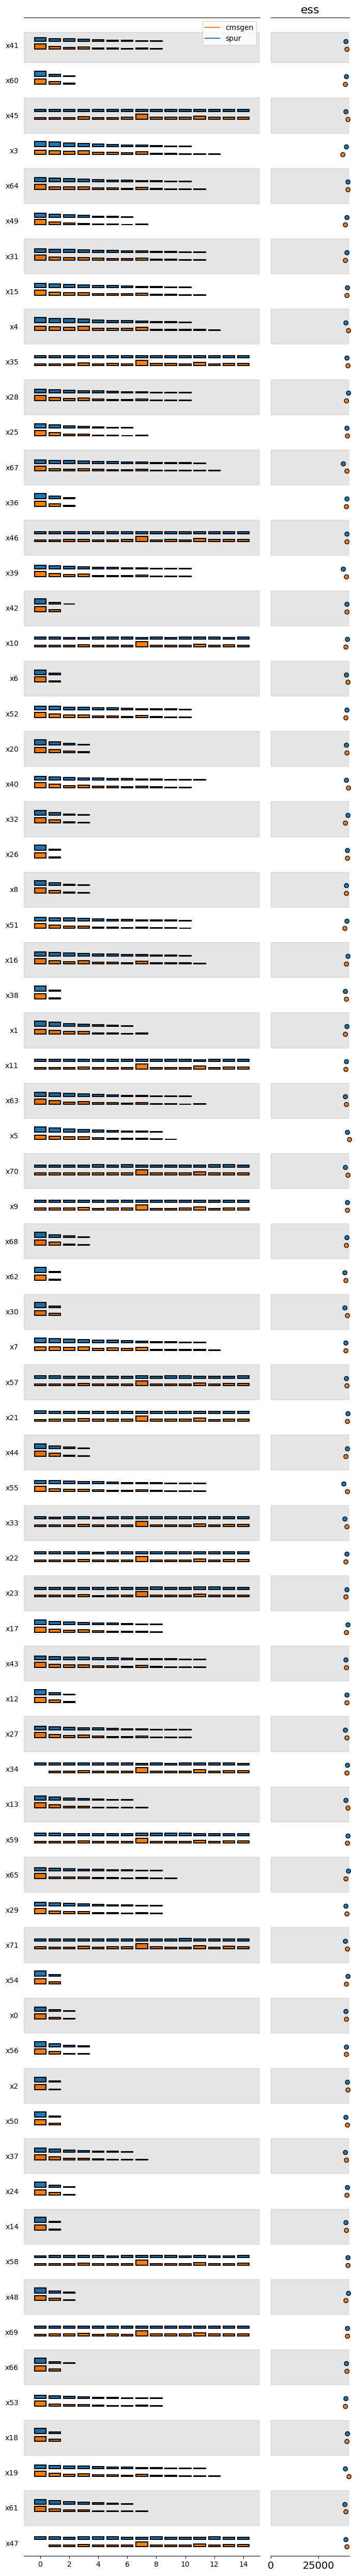

In [72]:
az.plot_forest(traces_books, combined=True, model_names=backends, hdi_prob=0.95, kind='ridgeplot', figsize=(7,50), ess=True, ridgeplot_overlap=0.5);